In [1]:
%load_ext autoreload
%autoreload 2

import os 
import shutil
import numpy as n
from datetime import date
from matplotlib import pyplot as plt
import time
import napari

In [2]:
os.chdir('/home/ali/packages/s2p-lbm/')

from suite3d.job import Job
from suite3d import lbmio, utils, ui
from suite3d import tiff_utils as tfu
from suite3d import file_utils as flu

In [26]:
job_params = {    
    'notch_filt' :     None,
    'planes' :         n.concatenate([n.arange(0,30,2), n.arange(1,31,2)]),
    'n_ch_tif' : 26,
    'convert_plane_ids_to_channel_ids' : False,
    
    'n_init_files' :   1,
    'init_file_pool' : None,
    'init_file_sample_method': 'random',
    
    'subtract_crosstalk' : True,
    'override_crosstalk' : 0.13,
    'crosstalk_n_planes' : 10, 
    
    'nonrigid' : True,
    'smooth_sigma' : 1.15,
    'maxregshift' : 0.15,
    'reg_filter_pcorr' : 1,
    'generate_sample_registered_bins' : False,

    'dtype' : n.float32,
    'tif_batch_size' : 1,
}



subjects_dir =   '/mnt/zortex-subjects/'
expt_info = { 
    'subject':         'AH012',
    'date' :          '2024-06-07',
    'expnum' :         [8],}

tifs, si_params, exp_str = flu.find_exp(subjects_dir, **expt_info, verbose=False)
job_params['fs'] = si_params['vol_rate']
job_params['fix_fastZ'] = 0

# Create the job
job = Job('/mnt/md0/runs',exp_str, tifs = tifs,
          params=job_params, create=True, overwrite=True, verbosity = 100)

job.params['planes'] = n.array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22,  1,  3,
         5,  7,  9, 11, 13, 15, 17])
job.params['3d_reg'] = True
job.params['fuse_shift_override'] = 8
job.params['cavity_size'] = 12
job.verbosity = 100

Job directory /mnt/md0/runs/s3d-AH012_2024-06-07_8 already exists
Loading job directory for AH012_2024-06-07_8 in /mnt/md0/runs
   Loading dirs 
      Found dir registered_fused_data
      Found dir summary
      Found dir iters
   Loading default params
      Updating param notch_filt
      Updating param planes
      Updating param n_ch_tif
      Updating param convert_plane_ids_to_channel_ids
      Updating param n_init_files
      Updating param init_file_pool
      Updating param init_file_sample_method
      Updating param subtract_crosstalk
      Updating param override_crosstalk
      Updating param crosstalk_n_planes
      Updating param nonrigid
      Updating param smooth_sigma
      Updating param maxregshift
      Updating param reg_filter_pcorr
      Updating param generate_sample_registered_bins
      Updating param dtype
      Updating param tif_batch_size
      Updating param fs
      Updating param fix_fastZ
   Updated main params file


In [27]:
job.params['gpu_reference_batch_size'] = 10
job.params['gpu_reg_batchsize'] = 10

In [35]:
job.params['init_file_sample_method'] = 'even'
job.params['init_n_frames'] = None
job.params['n_init_files'] = 6

   Saved a copy of params at /mnt/md0/runs/s3d-AH012_2024-06-07_8/summary
   Updated main params file
Launching initial pass
Saving summary to /mnt/md0/runs/s3d-AH012_2024-06-07_8/summary/summary.npy
   Loading init tifs with 26 channels
      Loading /mnt/zortex-subjects/AH012/2024-06-07/8/2024-06-07_8_AH012_2P_00001_00008.tif
      Loading /mnt/zortex-subjects/AH012/2024-06-07/8/2024-06-07_8_AH012_2P_00001_00016.tif
      Loading /mnt/zortex-subjects/AH012/2024-06-07/8/2024-06-07_8_AH012_2P_00001_00024.tif
      Loading /mnt/zortex-subjects/AH012/2024-06-07/8/2024-06-07_8_AH012_2P_00001_00032.tif
      Loading /mnt/zortex-subjects/AH012/2024-06-07/8/2024-06-07_8_AH012_2P_00001_00040.tif
      Loading /mnt/zortex-subjects/AH012/2024-06-07/8/2024-06-07_8_AH012_2P_00001_00048.tif
   Loaded 6 files, total 16.90 GB
   Loaded movie with 600 frames and shape 21, 1000, 720
      Enforcing positivity in mean image
   Subtracting crosstalk with forced coefficient 0.130
         Subtracting pla

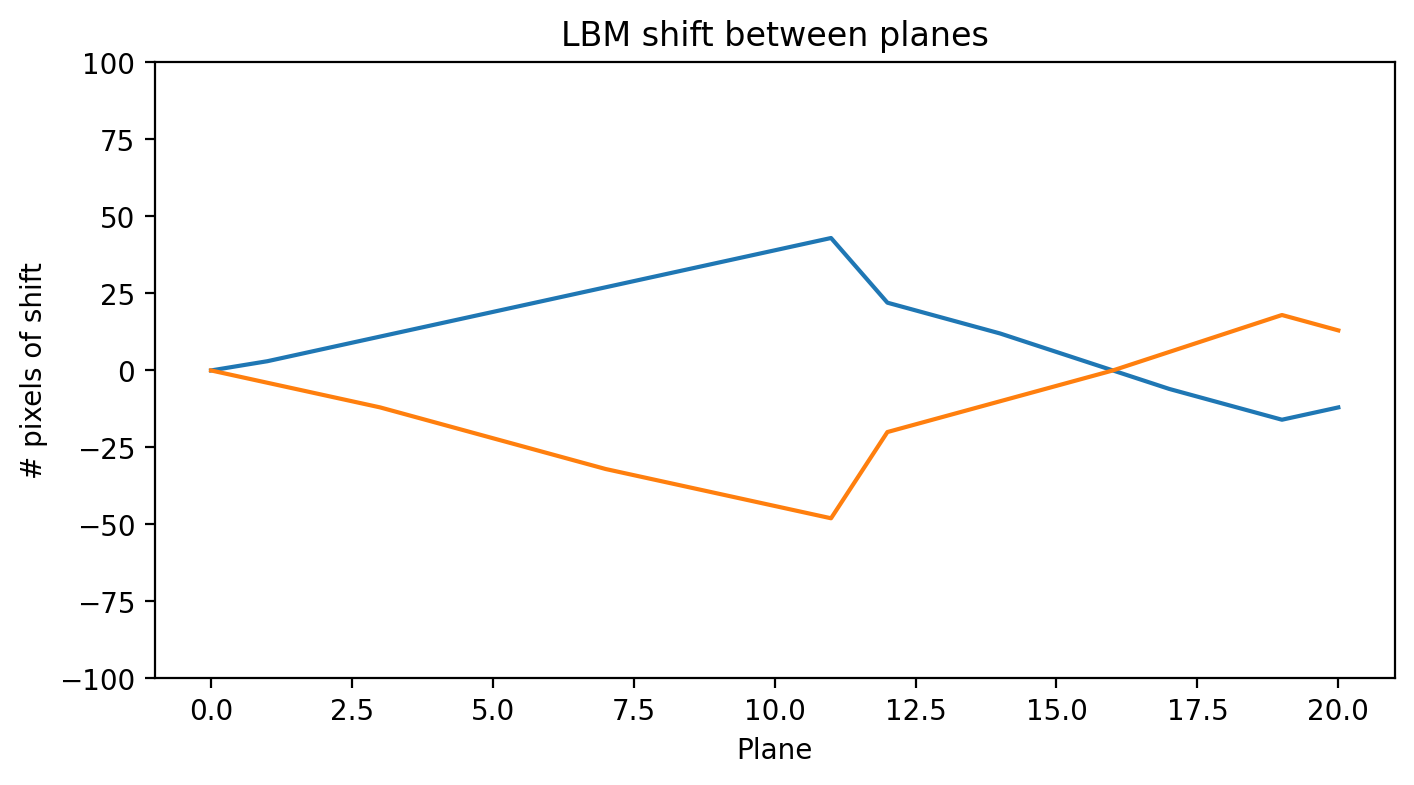

In [36]:
%%time
n.random.seed(5)
summary = job.run_init_pass()

In [37]:
summary = job.load_summary()

In [38]:
ref_vol = summary['ref_img_3d']

In [39]:
sig_range_high = n.percentile(ref_vol, 99.99, axis=(1,2))
sig_range_low = n.percentile(ref_vol, 25, axis=(1,2))

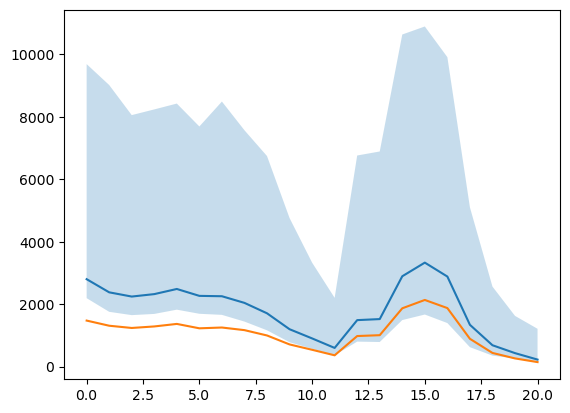

In [40]:
nz, ny, nx = ref_vol.shape

plt.plot(ref_vol.mean(axis=(1,2)))
plt.fill_between(n.arange(nz),sig_range_low, sig_range_high, alpha=0.25)
plt.plot(ref_vol.std(axis=(1,2)))

In [41]:
init_mov = n.load(os.path.join(job.dirs['summary'],'init_mov.npy'))

init_mean = init_mov.mean(axis=1)
init_std = init_mov.std(axis=1)
nz,ny,nx = init_mean.shape

pcts = n.array([n.percentile(init_std[i].flatten(), 98)  for i in range(nz)])

top_pix = [init_std[i] > pcts[i] for i in range(nz)]

top_pix_movs = n.array([init_mov[i][:,top_pix[i]] for i in range(nz)])

ff = top_pix_movs
df = n.diff(ff, axis=1)
dff = df / ff.mean(axis=1,keepdims=True)
abs_d_dff = n.abs(n.diff(dff,axis=1))
noise_level = n.nanmedian(abs_d_dff, axis=1)
noise_level = noise_level / job.params['fs']

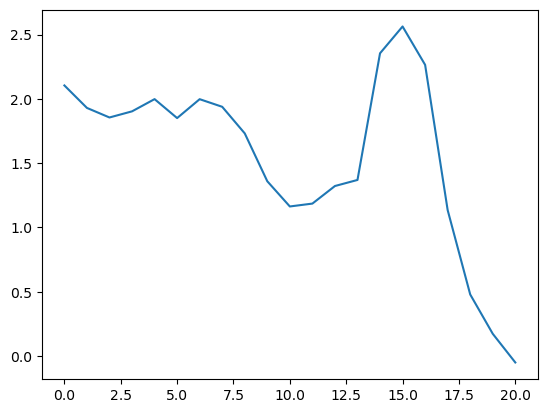

In [42]:
plt.plot((1-noise_level.mean(axis=1)) / noise_level.mean(axis=1))

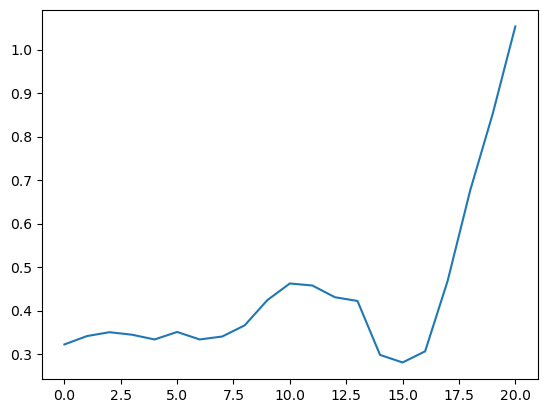

In [43]:
plt.plot(noise_level.mean(axis=1))

In [44]:
job.register_gpu_3d()

      Found dir /mnt/md0/runs/s3d-AH012_2024-06-07_8/registered_fused_data
      Updating self.dirs tag registered_fused_data
   Overriding fuse shift value to 8
   Not clipping frames for registration
Will analyze 55 tifs in 55 batches
   Enforcing positivity
   Launching IO thread
               [Thread] Loading batch 0 

         Memory at batch 0.  Total Used: 231.475 GB, Virtual Available: 287.406 GB, Virtual Used: 215.790 GB, Swap Used: 015.686 GB
Loading Batch 0 of 54
                  [Thread] Before load 0 
Total Used: 231.475 GB, Virtual Available: 287.406 GB, Virtual Used: 215.790 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/AH012/2024-06-07/8/2024-06-07_8_AH012_2P_00001_00001.tif


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.82 GB
               [Thread] Thread for batch 0 ready to join after 19.54 sec 

                  [Thread] After load 0 
Total Used: 234.352 GB, Virtual Available: 284.528 GB, Virtual Used: 218.667 GB, Swap Used: 015.686 GB
   Batch 0 IO thread joined
         Memory after IO thread joinTotal Used: 234.352 GB, Virtual Available: 284.528 GB, Virtual Used: 218.667 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 237.174 GB, Virtual Available: 281.707 GB, Virtual Used: 221.488 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 234.356 GB, Virtual Available: 284.525 GB, Virtual Used: 218.670 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
               [Thread] Loading batch 1 

         After IO thread launch:Total Used: 234.356 GB, Virtual Available: 284.525 GB, Virtual Used: 218.670 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 1000, 720)
                  [Thre

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.82 GB
               [Thread] Thread for batch 1 ready to join after 19.99 sec 

                  [Thread] After load 1 
Total Used: 240.062 GB, Virtual Available: 278.819 GB, Virtual Used: 224.376 GB, Swap Used: 015.686 GB
   Batch 1 IO thread joined
         Memory after IO thread joinTotal Used: 240.062 GB, Virtual Available: 278.819 GB, Virtual Used: 224.376 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 240.064 GB, Virtual Available: 278.816 GB, Virtual Used: 224.379 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 237.239 GB, Virtual Available: 281.642 GB, Virtual Used: 221.553 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
               [Thread] Loading batch 2 

                  [Thread] Before load 2 
Total Used: 237.239 GB, Virtual Available: 281.642 GB, Virtual Used: 221.553 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/AH012/2024-06-07/8/2024-06

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.82 GB
               [Thread] Thread for batch 2 ready to join after 19.17 sec 

                  [Thread] After load 2 
Total Used: 240.099 GB, Virtual Available: 278.782 GB, Virtual Used: 224.414 GB, Swap Used: 015.686 GB
   Batch 2 IO thread joined
         Memory after IO thread joinTotal Used: 240.099 GB, Virtual Available: 278.782 GB, Virtual Used: 224.414 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 240.096 GB, Virtual Available: 278.785 GB, Virtual Used: 224.410 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 237.276 GB, Virtual Available: 281.605 GB, Virtual Used: 221.590 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
               [Thread] Loading batch 3 

                  [Thread] Before load 3 
Total Used: 237.276 GB, Virtual Available: 281.605 GB, Virtual Used: 221.590 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/AH012/2024-06-07/8/2024-06

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.82 GB
               [Thread] Thread for batch 3 ready to join after 19.37 sec 

                  [Thread] After load 3 
Total Used: 240.085 GB, Virtual Available: 278.796 GB, Virtual Used: 224.400 GB, Swap Used: 015.686 GB
   Batch 3 IO thread joined
         Memory after IO thread joinTotal Used: 240.085 GB, Virtual Available: 278.796 GB, Virtual Used: 224.400 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 240.083 GB, Virtual Available: 278.798 GB, Virtual Used: 224.398 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 237.259 GB, Virtual Available: 281.621 GB, Virtual Used: 221.574 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
               [Thread] Loading batch 4 

                  [Thread] Before load 4 
Total Used: 237.259 GB, Virtual Available: 281.621 GB, Virtual Used: 221.574 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/AH012/2024-06-07/8/2024-06

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.82 GB
               [Thread] Thread for batch 4 ready to join after 19.21 sec 

                  [Thread] After load 4 
Total Used: 240.086 GB, Virtual Available: 278.795 GB, Virtual Used: 224.401 GB, Swap Used: 015.686 GB
   Batch 4 IO thread joined
         Memory after IO thread joinTotal Used: 240.086 GB, Virtual Available: 278.795 GB, Virtual Used: 224.401 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 240.083 GB, Virtual Available: 278.798 GB, Virtual Used: 224.397 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 237.264 GB, Virtual Available: 281.616 GB, Virtual Used: 221.579 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
               [Thread] Loading batch 5 

                  [Thread] Before load 5 
Total Used: 237.264 GB, Virtual Available: 281.616 GB, Virtual Used: 221.579 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/AH012/2024-06-07/8/2024-06

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.82 GB
               [Thread] Thread for batch 5 ready to join after 19.58 sec 

                  [Thread] After load 5 
Total Used: 240.100 GB, Virtual Available: 278.781 GB, Virtual Used: 224.414 GB, Swap Used: 015.686 GB
   Batch 5 IO thread joined
         Memory after IO thread joinTotal Used: 240.100 GB, Virtual Available: 278.781 GB, Virtual Used: 224.414 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 240.098 GB, Virtual Available: 278.783 GB, Virtual Used: 224.413 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 237.274 GB, Virtual Available: 281.607 GB, Virtual Used: 221.589 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
               [Thread] Loading batch 6 

         After IO thread launch:Total Used: 237.274 GB, Virtual Available: 281.607 GB, Virtual Used: 221.589 GB, Swap Used: 015.686 GB
                  [Thread] Before load 6 
Total Used: 237.274 GB, Virtu

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.82 GB
               [Thread] Thread for batch 6 ready to join after 19.37 sec 

                  [Thread] After load 6 
Total Used: 240.091 GB, Virtual Available: 278.789 GB, Virtual Used: 224.406 GB, Swap Used: 015.686 GB
   Batch 6 IO thread joined
         Memory after IO thread joinTotal Used: 240.091 GB, Virtual Available: 278.789 GB, Virtual Used: 224.406 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 240.088 GB, Virtual Available: 278.793 GB, Virtual Used: 224.402 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 237.267 GB, Virtual Available: 281.614 GB, Virtual Used: 221.582 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
               [Thread] Loading batch 7 

         After IO thread launch:Total Used: 237.267 GB, Virtual Available: 281.614 GB, Virtual Used: 221.582 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 1000, 720)
                  [Thre

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.82 GB
               [Thread] Thread for batch 7 ready to join after 19.09 sec 

                  [Thread] After load 7 
Total Used: 240.102 GB, Virtual Available: 278.779 GB, Virtual Used: 224.416 GB, Swap Used: 015.686 GB
   Batch 7 IO thread joined
         Memory after IO thread joinTotal Used: 240.102 GB, Virtual Available: 278.779 GB, Virtual Used: 224.416 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 240.099 GB, Virtual Available: 278.782 GB, Virtual Used: 224.413 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 237.275 GB, Virtual Available: 281.606 GB, Virtual Used: 221.589 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
               [Thread] Loading batch 8 

                  [Thread] Before load 8 
Total Used: 237.275 GB, Virtual Available: 281.606 GB, Virtual Used: 221.589 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/AH012/2024-06-07/8/2024-06

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.82 GB
               [Thread] Thread for batch 8 ready to join after 19.02 sec 

                  [Thread] After load 8 
Total Used: 240.091 GB, Virtual Available: 278.790 GB, Virtual Used: 224.405 GB, Swap Used: 015.686 GB
   Batch 8 IO thread joined
         Memory after IO thread joinTotal Used: 240.091 GB, Virtual Available: 278.790 GB, Virtual Used: 224.405 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 240.087 GB, Virtual Available: 278.794 GB, Virtual Used: 224.402 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 237.269 GB, Virtual Available: 281.612 GB, Virtual Used: 221.583 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
               [Thread] Loading batch 9 

                  [Thread] Before load 9 
Total Used: 237.269 GB, Virtual Available: 281.612 GB, Virtual Used: 221.583 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/AH012/2024-06-07/8/2024-06

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.82 GB
               [Thread] Thread for batch 9 ready to join after 19.16 sec 

                  [Thread] After load 9 
Total Used: 240.119 GB, Virtual Available: 278.762 GB, Virtual Used: 224.433 GB, Swap Used: 015.686 GB
   Batch 9 IO thread joined
         Memory after IO thread joinTotal Used: 240.119 GB, Virtual Available: 278.762 GB, Virtual Used: 224.433 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 240.117 GB, Virtual Available: 278.763 GB, Virtual Used: 224.432 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 237.293 GB, Virtual Available: 281.587 GB, Virtual Used: 221.608 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
               [Thread] Loading batch 10 

                  [Thread] Before load 10 
Total Used: 237.293 GB, Virtual Available: 281.587 GB, Virtual Used: 221.608 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/AH012/2024-06-07/8/2024-

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.82 GB
               [Thread] Thread for batch 10 ready to join after 19.13 sec 

                  [Thread] After load 10 
Total Used: 240.100 GB, Virtual Available: 278.781 GB, Virtual Used: 224.414 GB, Swap Used: 015.686 GB
   Batch 10 IO thread joined
         Memory after IO thread joinTotal Used: 240.100 GB, Virtual Available: 278.781 GB, Virtual Used: 224.414 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 240.096 GB, Virtual Available: 278.784 GB, Virtual Used: 224.411 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 237.278 GB, Virtual Available: 281.603 GB, Virtual Used: 221.593 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
               [Thread] Loading batch 11 

                  [Thread] Before load 11 
Total Used: 237.278 GB, Virtual Available: 281.603 GB, Virtual Used: 221.593 GB, Swap Used: 015.686 GB
         After IO thread launch:Total Used: 237.278 GB, 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.82 GB
               [Thread] Thread for batch 11 ready to join after 19.19 sec 

                  [Thread] After load 11 
Total Used: 240.104 GB, Virtual Available: 278.776 GB, Virtual Used: 224.419 GB, Swap Used: 015.686 GB
   Batch 11 IO thread joined
         Memory after IO thread joinTotal Used: 240.104 GB, Virtual Available: 278.776 GB, Virtual Used: 224.419 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 240.103 GB, Virtual Available: 278.777 GB, Virtual Used: 224.418 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 237.278 GB, Virtual Available: 281.603 GB, Virtual Used: 221.592 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
               [Thread] Loading batch 12 

                  [Thread] Before load 12 
Total Used: 237.278 GB, Virtual Available: 281.603 GB, Virtual Used: 221.592 GB, Swap Used: 015.686 GB
         After IO thread launch:Total Used: 237.278 GB, 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.82 GB
               [Thread] Thread for batch 12 ready to join after 19.03 sec 

                  [Thread] After load 12 
Total Used: 240.106 GB, Virtual Available: 278.775 GB, Virtual Used: 224.420 GB, Swap Used: 015.686 GB
   Batch 12 IO thread joined
         Memory after IO thread joinTotal Used: 240.106 GB, Virtual Available: 278.775 GB, Virtual Used: 224.420 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 240.107 GB, Virtual Available: 278.774 GB, Virtual Used: 224.421 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 237.288 GB, Virtual Available: 281.592 GB, Virtual Used: 221.603 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
               [Thread] Loading batch 13 

         After IO thread launch:Total Used: 237.288 GB, Virtual Available: 281.592 GB, Virtual Used: 221.603 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 1000, 720)
                  [

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.82 GB
               [Thread] Thread for batch 13 ready to join after 19.67 sec 

                  [Thread] After load 13 
Total Used: 240.103 GB, Virtual Available: 278.778 GB, Virtual Used: 224.417 GB, Swap Used: 015.686 GB
   Batch 13 IO thread joined
         Memory after IO thread joinTotal Used: 240.103 GB, Virtual Available: 278.778 GB, Virtual Used: 224.417 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 240.103 GB, Virtual Available: 278.778 GB, Virtual Used: 224.417 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 237.277 GB, Virtual Available: 281.603 GB, Virtual Used: 221.592 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
               [Thread] Loading batch 14 

                  [Thread] Before load 14 
Total Used: 237.277 GB, Virtual Available: 281.603 GB, Virtual Used: 221.592 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/AH012/2024-06-07/8/20

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.82 GB
               [Thread] Thread for batch 14 ready to join after 19.16 sec 

                  [Thread] After load 14 
Total Used: 240.111 GB, Virtual Available: 278.770 GB, Virtual Used: 224.425 GB, Swap Used: 015.686 GB
   Batch 14 IO thread joined
         Memory after IO thread joinTotal Used: 240.111 GB, Virtual Available: 278.770 GB, Virtual Used: 224.425 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 240.111 GB, Virtual Available: 278.769 GB, Virtual Used: 224.426 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 237.284 GB, Virtual Available: 281.597 GB, Virtual Used: 221.598 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
               [Thread] Loading batch 15 

                  [Thread] Before load 15 
Total Used: 237.284 GB, Virtual Available: 281.597 GB, Virtual Used: 221.598 GB, Swap Used: 015.686 GB
         After IO thread launch:Total Used: 237.284 GB, 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.82 GB
               [Thread] Thread for batch 15 ready to join after 19.60 sec 

                  [Thread] After load 15 
Total Used: 240.114 GB, Virtual Available: 278.767 GB, Virtual Used: 224.428 GB, Swap Used: 015.686 GB
   Batch 15 IO thread joined
         Memory after IO thread joinTotal Used: 240.114 GB, Virtual Available: 278.767 GB, Virtual Used: 224.428 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 240.114 GB, Virtual Available: 278.767 GB, Virtual Used: 224.429 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 237.288 GB, Virtual Available: 281.592 GB, Virtual Used: 221.603 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
               [Thread] Loading batch 16 

                  [Thread] Before load 16 
Total Used: 237.288 GB, Virtual Available: 281.592 GB, Virtual Used: 221.603 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/AH012/2024-06-07/8/20

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.82 GB
               [Thread] Thread for batch 16 ready to join after 19.74 sec 

                  [Thread] After load 16 
Total Used: 240.105 GB, Virtual Available: 278.776 GB, Virtual Used: 224.419 GB, Swap Used: 015.686 GB
   Batch 16 IO thread joined
         Memory after IO thread joinTotal Used: 240.105 GB, Virtual Available: 278.776 GB, Virtual Used: 224.419 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 240.101 GB, Virtual Available: 278.780 GB, Virtual Used: 224.416 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 237.283 GB, Virtual Available: 281.598 GB, Virtual Used: 221.597 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
               [Thread] Loading batch 17 

                  [Thread] Before load 17 
Total Used: 237.283 GB, Virtual Available: 281.598 GB, Virtual Used: 221.597 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/AH012/2024-06-07/8/20

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.82 GB
               [Thread] Thread for batch 17 ready to join after 19.69 sec 

                  [Thread] After load 17 
Total Used: 240.098 GB, Virtual Available: 278.783 GB, Virtual Used: 224.412 GB, Swap Used: 015.686 GB
   Batch 17 IO thread joined
         Memory after IO thread joinTotal Used: 240.098 GB, Virtual Available: 278.783 GB, Virtual Used: 224.412 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 240.099 GB, Virtual Available: 278.782 GB, Virtual Used: 224.413 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 237.275 GB, Virtual Available: 281.606 GB, Virtual Used: 221.589 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
               [Thread] Loading batch 18 

                  [Thread] Before load 18 
Total Used: 237.275 GB, Virtual Available: 281.606 GB, Virtual Used: 221.589 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/AH012/2024-06-07/8/20

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.82 GB
               [Thread] Thread for batch 18 ready to join after 19.47 sec 

                  [Thread] After load 18 
Total Used: 240.091 GB, Virtual Available: 278.790 GB, Virtual Used: 224.405 GB, Swap Used: 015.686 GB
   Batch 18 IO thread joined
         Memory after IO thread joinTotal Used: 240.091 GB, Virtual Available: 278.790 GB, Virtual Used: 224.405 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 240.094 GB, Virtual Available: 278.787 GB, Virtual Used: 224.409 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 237.266 GB, Virtual Available: 281.615 GB, Virtual Used: 221.580 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
               [Thread] Loading batch 19 

         After IO thread launch:Total Used: 237.266 GB, Virtual Available: 281.615 GB, Virtual Used: 221.580 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 1000, 720)
                  [

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.82 GB
               [Thread] Thread for batch 19 ready to join after 19.94 sec 

                  [Thread] After load 19 
Total Used: 240.074 GB, Virtual Available: 278.807 GB, Virtual Used: 224.388 GB, Swap Used: 015.686 GB
   Batch 19 IO thread joined
         Memory after IO thread joinTotal Used: 240.074 GB, Virtual Available: 278.807 GB, Virtual Used: 224.388 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 240.072 GB, Virtual Available: 278.809 GB, Virtual Used: 224.386 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 237.250 GB, Virtual Available: 281.631 GB, Virtual Used: 221.565 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
               [Thread] Loading batch 20 

         After IO thread launch:Total Used: 237.250 GB, Virtual Available: 281.631 GB, Virtual Used: 221.565 GB, Swap Used: 015.686 GB
                  [Thread] Before load 20 
Total Used: 237.250 GB, 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.82 GB
               [Thread] Thread for batch 20 ready to join after 20.48 sec 

                  [Thread] After load 20 
Total Used: 240.069 GB, Virtual Available: 278.812 GB, Virtual Used: 224.383 GB, Swap Used: 015.686 GB
   Batch 20 IO thread joined
         Memory after IO thread joinTotal Used: 240.069 GB, Virtual Available: 278.812 GB, Virtual Used: 224.383 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 240.065 GB, Virtual Available: 278.816 GB, Virtual Used: 224.379 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 237.245 GB, Virtual Available: 281.636 GB, Virtual Used: 221.559 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
               [Thread] Loading batch 21 

         After IO thread launch:Total Used: 237.245 GB, Virtual Available: 281.636 GB, Virtual Used: 221.559 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 1000, 720)
                  [

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.82 GB
               [Thread] Thread for batch 21 ready to join after 20.32 sec 

                  [Thread] After load 21 
Total Used: 240.101 GB, Virtual Available: 278.780 GB, Virtual Used: 224.415 GB, Swap Used: 015.686 GB
   Batch 21 IO thread joined
         Memory after IO thread joinTotal Used: 240.101 GB, Virtual Available: 278.780 GB, Virtual Used: 224.415 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 240.099 GB, Virtual Available: 278.782 GB, Virtual Used: 224.414 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 237.276 GB, Virtual Available: 281.605 GB, Virtual Used: 221.590 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
               [Thread] Loading batch 22 

         After IO thread launch:Total Used: 237.276 GB, Virtual Available: 281.605 GB, Virtual Used: 221.590 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 1000, 720)
                  [

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.82 GB
               [Thread] Thread for batch 22 ready to join after 20.20 sec 

                  [Thread] After load 22 
Total Used: 240.076 GB, Virtual Available: 278.805 GB, Virtual Used: 224.390 GB, Swap Used: 015.686 GB
   Batch 22 IO thread joined
         Memory after IO thread joinTotal Used: 240.076 GB, Virtual Available: 278.805 GB, Virtual Used: 224.390 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 240.072 GB, Virtual Available: 278.809 GB, Virtual Used: 224.386 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 237.253 GB, Virtual Available: 281.627 GB, Virtual Used: 221.568 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
               [Thread] Loading batch 23 

         After IO thread launch:Total Used: 237.253 GB, Virtual Available: 281.627 GB, Virtual Used: 221.568 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 1000, 720)
                  [

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.82 GB
               [Thread] Thread for batch 23 ready to join after 19.75 sec 

                  [Thread] After load 23 
Total Used: 240.077 GB, Virtual Available: 278.804 GB, Virtual Used: 224.391 GB, Swap Used: 015.686 GB
   Batch 23 IO thread joined
         Memory after IO thread joinTotal Used: 240.077 GB, Virtual Available: 278.804 GB, Virtual Used: 224.391 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 240.076 GB, Virtual Available: 278.804 GB, Virtual Used: 224.391 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 237.260 GB, Virtual Available: 281.620 GB, Virtual Used: 221.575 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
               [Thread] Loading batch 24 

         After IO thread launch:Total Used: 237.260 GB, Virtual Available: 281.620 GB, Virtual Used: 221.575 GB, Swap Used: 015.686 GB
                  [Thread] Before load 24 
Total Used: 237.260 GB, 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.82 GB
               [Thread] Thread for batch 24 ready to join after 19.83 sec 

                  [Thread] After load 24 
Total Used: 240.109 GB, Virtual Available: 278.772 GB, Virtual Used: 224.423 GB, Swap Used: 015.686 GB
   Batch 24 IO thread joined
         Memory after IO thread joinTotal Used: 240.109 GB, Virtual Available: 278.772 GB, Virtual Used: 224.423 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 240.108 GB, Virtual Available: 278.773 GB, Virtual Used: 224.422 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 237.288 GB, Virtual Available: 281.593 GB, Virtual Used: 221.602 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
               [Thread] Loading batch 25 

                  [Thread] Before load 25 
Total Used: 237.288 GB, Virtual Available: 281.593 GB, Virtual Used: 221.602 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/AH012/2024-06-07/8/20

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.82 GB
               [Thread] Thread for batch 25 ready to join after 19.83 sec 

                  [Thread] After load 25 
Total Used: 240.118 GB, Virtual Available: 278.763 GB, Virtual Used: 224.433 GB, Swap Used: 015.686 GB
   Batch 25 IO thread joined
         Memory after IO thread joinTotal Used: 240.118 GB, Virtual Available: 278.763 GB, Virtual Used: 224.433 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 240.119 GB, Virtual Available: 278.762 GB, Virtual Used: 224.434 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 237.303 GB, Virtual Available: 281.578 GB, Virtual Used: 221.618 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
               [Thread] Loading batch 26 

         After IO thread launch:Total Used: 237.303 GB, Virtual Available: 281.578 GB, Virtual Used: 221.618 GB, Swap Used: 015.686 GB
                  [Thread] Before load 26 
Total Used: 237.303 GB, 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.82 GB
               [Thread] Thread for batch 26 ready to join after 19.93 sec 

                  [Thread] After load 26 
Total Used: 240.119 GB, Virtual Available: 278.762 GB, Virtual Used: 224.433 GB, Swap Used: 015.686 GB
   Batch 26 IO thread joined
         Memory after IO thread joinTotal Used: 240.119 GB, Virtual Available: 278.762 GB, Virtual Used: 224.433 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 240.120 GB, Virtual Available: 278.761 GB, Virtual Used: 224.435 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 237.300 GB, Virtual Available: 281.581 GB, Virtual Used: 221.614 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
               [Thread] Loading batch 27 

                  [Thread] Before load 27 
Total Used: 237.300 GB, Virtual Available: 281.581 GB, Virtual Used: 221.614 GB, Swap Used: 015.686 GB
         After IO thread launch:Total Used: 237.300 GB, 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.82 GB
               [Thread] Thread for batch 27 ready to join after 19.59 sec 

                  [Thread] After load 27 
Total Used: 240.172 GB, Virtual Available: 278.709 GB, Virtual Used: 224.487 GB, Swap Used: 015.686 GB
   Batch 27 IO thread joined
         Memory after IO thread joinTotal Used: 240.172 GB, Virtual Available: 278.709 GB, Virtual Used: 224.487 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 240.171 GB, Virtual Available: 278.710 GB, Virtual Used: 224.485 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 237.347 GB, Virtual Available: 281.534 GB, Virtual Used: 221.661 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
               [Thread] Loading batch 28 

                  [Thread] Before load 28 
Total Used: 237.347 GB, Virtual Available: 281.534 GB, Virtual Used: 221.661 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/AH012/2024-06-07/8/20

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.82 GB
               [Thread] Thread for batch 28 ready to join after 19.65 sec 

                  [Thread] After load 28 
Total Used: 240.097 GB, Virtual Available: 278.783 GB, Virtual Used: 224.412 GB, Swap Used: 015.686 GB
   Batch 28 IO thread joined
         Memory after IO thread joinTotal Used: 240.097 GB, Virtual Available: 278.783 GB, Virtual Used: 224.412 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 240.096 GB, Virtual Available: 278.785 GB, Virtual Used: 224.410 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 237.276 GB, Virtual Available: 281.605 GB, Virtual Used: 221.590 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
               [Thread] Loading batch 29 

                  [Thread] Before load 29 
Total Used: 237.276 GB, Virtual Available: 281.605 GB, Virtual Used: 221.590 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/AH012/2024-06-07/8/20

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.82 GB
               [Thread] Thread for batch 29 ready to join after 19.38 sec 

                  [Thread] After load 29 
Total Used: 240.142 GB, Virtual Available: 278.739 GB, Virtual Used: 224.456 GB, Swap Used: 015.686 GB
   Batch 29 IO thread joined
         Memory after IO thread joinTotal Used: 240.142 GB, Virtual Available: 278.739 GB, Virtual Used: 224.456 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 240.140 GB, Virtual Available: 278.740 GB, Virtual Used: 224.455 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 237.316 GB, Virtual Available: 281.564 GB, Virtual Used: 221.631 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
               [Thread] Loading batch 30 

         After IO thread launch:Total Used: 237.316 GB, Virtual Available: 281.564 GB, Virtual Used: 221.631 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 1000, 720)
                  [

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.82 GB
               [Thread] Thread for batch 30 ready to join after 19.83 sec 

                  [Thread] After load 30 
Total Used: 240.106 GB, Virtual Available: 278.774 GB, Virtual Used: 224.421 GB, Swap Used: 015.686 GB
   Batch 30 IO thread joined
         Memory after IO thread joinTotal Used: 240.106 GB, Virtual Available: 278.774 GB, Virtual Used: 224.421 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 240.111 GB, Virtual Available: 278.770 GB, Virtual Used: 224.425 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 237.290 GB, Virtual Available: 281.590 GB, Virtual Used: 221.605 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
               [Thread] Loading batch 31 

                  [Thread] Before load 31 
Total Used: 237.290 GB, Virtual Available: 281.590 GB, Virtual Used: 221.605 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/AH012/2024-06-07/8/20

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.82 GB
               [Thread] Thread for batch 31 ready to join after 19.88 sec 

                  [Thread] After load 31 
Total Used: 240.114 GB, Virtual Available: 278.766 GB, Virtual Used: 224.429 GB, Swap Used: 015.686 GB
   Batch 31 IO thread joined
         Memory after IO thread joinTotal Used: 240.114 GB, Virtual Available: 278.766 GB, Virtual Used: 224.429 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 240.111 GB, Virtual Available: 278.770 GB, Virtual Used: 224.425 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 237.289 GB, Virtual Available: 281.592 GB, Virtual Used: 221.603 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
               [Thread] Loading batch 32 

                  [Thread] Before load 32 
Total Used: 237.289 GB, Virtual Available: 281.592 GB, Virtual Used: 221.603 GB, Swap Used: 015.686 GB
         After IO thread launch:Total Used: 237.289 GB, 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.82 GB
               [Thread] Thread for batch 32 ready to join after 19.91 sec 

                  [Thread] After load 32 
Total Used: 240.115 GB, Virtual Available: 278.765 GB, Virtual Used: 224.430 GB, Swap Used: 015.686 GB
   Batch 32 IO thread joined
         Memory after IO thread joinTotal Used: 240.115 GB, Virtual Available: 278.765 GB, Virtual Used: 224.430 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 240.116 GB, Virtual Available: 278.765 GB, Virtual Used: 224.430 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 237.298 GB, Virtual Available: 281.583 GB, Virtual Used: 221.612 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
               [Thread] Loading batch 33 

                  [Thread] Before load 33 
Total Used: 237.298 GB, Virtual Available: 281.583 GB, Virtual Used: 221.612 GB, Swap Used: 015.686 GB
         After IO thread launch:Total Used: 237.298 GB, 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.82 GB
               [Thread] Thread for batch 33 ready to join after 19.73 sec 

                  [Thread] After load 33 
Total Used: 240.104 GB, Virtual Available: 278.776 GB, Virtual Used: 224.419 GB, Swap Used: 015.686 GB
   Batch 33 IO thread joined
         Memory after IO thread joinTotal Used: 240.104 GB, Virtual Available: 278.776 GB, Virtual Used: 224.419 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 240.105 GB, Virtual Available: 278.776 GB, Virtual Used: 224.419 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 237.279 GB, Virtual Available: 281.602 GB, Virtual Used: 221.593 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
               [Thread] Loading batch 34 

                  [Thread] Before load 34 
Total Used: 237.279 GB, Virtual Available: 281.602 GB, Virtual Used: 221.593 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/AH012/2024-06-07/8/20

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.82 GB
               [Thread] Thread for batch 34 ready to join after 19.81 sec 

                  [Thread] After load 34 
Total Used: 240.097 GB, Virtual Available: 278.784 GB, Virtual Used: 224.411 GB, Swap Used: 015.686 GB
   Batch 34 IO thread joined
         Memory after IO thread joinTotal Used: 240.097 GB, Virtual Available: 278.784 GB, Virtual Used: 224.411 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 240.094 GB, Virtual Available: 278.787 GB, Virtual Used: 224.409 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 237.274 GB, Virtual Available: 281.607 GB, Virtual Used: 221.588 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
               [Thread] Loading batch 35 

         After IO thread launch:Total Used: 237.274 GB, Virtual Available: 281.607 GB, Virtual Used: 221.588 GB, Swap Used: 015.686 GB
                  [Thread] Before load 35 
Total Used: 237.274 GB, 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.82 GB
               [Thread] Thread for batch 35 ready to join after 19.77 sec 

                  [Thread] After load 35 
Total Used: 240.109 GB, Virtual Available: 278.772 GB, Virtual Used: 224.423 GB, Swap Used: 015.686 GB
   Batch 35 IO thread joined
         Memory after IO thread joinTotal Used: 240.109 GB, Virtual Available: 278.772 GB, Virtual Used: 224.423 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 240.109 GB, Virtual Available: 278.772 GB, Virtual Used: 224.424 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 237.293 GB, Virtual Available: 281.588 GB, Virtual Used: 221.608 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
               [Thread] Loading batch 36 

                  [Thread] Before load 36 
Total Used: 237.293 GB, Virtual Available: 281.588 GB, Virtual Used: 221.608 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/AH012/2024-06-07/8/20

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.82 GB
               [Thread] Thread for batch 36 ready to join after 19.77 sec 

                  [Thread] After load 36 
Total Used: 240.154 GB, Virtual Available: 278.727 GB, Virtual Used: 224.468 GB, Swap Used: 015.686 GB
   Batch 36 IO thread joined
         Memory after IO thread joinTotal Used: 240.154 GB, Virtual Available: 278.727 GB, Virtual Used: 224.468 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 240.150 GB, Virtual Available: 278.730 GB, Virtual Used: 224.465 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 237.330 GB, Virtual Available: 281.551 GB, Virtual Used: 221.645 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
               [Thread] Loading batch 37 

                  [Thread] Before load 37 
Total Used: 237.330 GB, Virtual Available: 281.551 GB, Virtual Used: 221.645 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/AH012/2024-06-07/8/20

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.82 GB
               [Thread] Thread for batch 37 ready to join after 20.45 sec 

                  [Thread] After load 37 
Total Used: 240.111 GB, Virtual Available: 278.770 GB, Virtual Used: 224.425 GB, Swap Used: 015.686 GB
   Batch 37 IO thread joined
         Memory after IO thread joinTotal Used: 240.111 GB, Virtual Available: 278.770 GB, Virtual Used: 224.425 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 240.114 GB, Virtual Available: 278.767 GB, Virtual Used: 224.428 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 237.288 GB, Virtual Available: 281.593 GB, Virtual Used: 221.602 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
               [Thread] Loading batch 38 

                  [Thread] Before load 38 
Total Used: 237.288 GB, Virtual Available: 281.593 GB, Virtual Used: 221.602 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/AH012/2024-06-07/8/20

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.82 GB
               [Thread] Thread for batch 38 ready to join after 20.05 sec 

                  [Thread] After load 38 
Total Used: 240.124 GB, Virtual Available: 278.757 GB, Virtual Used: 224.439 GB, Swap Used: 015.686 GB
   Batch 38 IO thread joined
         Memory after IO thread joinTotal Used: 240.124 GB, Virtual Available: 278.757 GB, Virtual Used: 224.439 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 240.121 GB, Virtual Available: 278.760 GB, Virtual Used: 224.435 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 237.301 GB, Virtual Available: 281.580 GB, Virtual Used: 221.615 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
               [Thread] Loading batch 39 

                  [Thread] Before load 39 
Total Used: 237.301 GB, Virtual Available: 281.580 GB, Virtual Used: 221.615 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/AH012/2024-06-07/8/20

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.82 GB
               [Thread] Thread for batch 39 ready to join after 20.16 sec 

                  [Thread] After load 39 
Total Used: 239.912 GB, Virtual Available: 278.969 GB, Virtual Used: 224.227 GB, Swap Used: 015.686 GB
   Batch 39 IO thread joined
         Memory after IO thread joinTotal Used: 239.912 GB, Virtual Available: 278.969 GB, Virtual Used: 224.227 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 239.904 GB, Virtual Available: 278.977 GB, Virtual Used: 224.218 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 237.088 GB, Virtual Available: 281.793 GB, Virtual Used: 221.402 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
               [Thread] Loading batch 40 

         After IO thread launch:Total Used: 237.088 GB, Virtual Available: 281.793 GB, Virtual Used: 221.402 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 1000, 720)
                  [

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.82 GB
               [Thread] Thread for batch 40 ready to join after 19.88 sec 

                  [Thread] After load 40 
Total Used: 240.114 GB, Virtual Available: 278.767 GB, Virtual Used: 224.428 GB, Swap Used: 015.686 GB
   Batch 40 IO thread joined
         Memory after IO thread joinTotal Used: 240.114 GB, Virtual Available: 278.767 GB, Virtual Used: 224.428 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 240.110 GB, Virtual Available: 278.771 GB, Virtual Used: 224.424 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 237.292 GB, Virtual Available: 281.589 GB, Virtual Used: 221.606 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
               [Thread] Loading batch 41 

                  [Thread] Before load 41 
Total Used: 237.292 GB, Virtual Available: 281.589 GB, Virtual Used: 221.606 GB, Swap Used: 015.686 GB
         After IO thread launch:Total Used: 237.292 GB, 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.82 GB
               [Thread] Thread for batch 41 ready to join after 19.95 sec 

                  [Thread] After load 41 
Total Used: 240.016 GB, Virtual Available: 278.865 GB, Virtual Used: 224.330 GB, Swap Used: 015.686 GB
   Batch 41 IO thread joined
         Memory after IO thread joinTotal Used: 240.016 GB, Virtual Available: 278.865 GB, Virtual Used: 224.330 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 240.022 GB, Virtual Available: 278.858 GB, Virtual Used: 224.337 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 237.197 GB, Virtual Available: 281.684 GB, Virtual Used: 221.511 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
               [Thread] Loading batch 42 

                  [Thread] Before load 42 
Total Used: 237.197 GB, Virtual Available: 281.684 GB, Virtual Used: 221.511 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/AH012/2024-06-07/8/20

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.82 GB
               [Thread] Thread for batch 42 ready to join after 19.70 sec 

                  [Thread] After load 42 
Total Used: 240.095 GB, Virtual Available: 278.786 GB, Virtual Used: 224.409 GB, Swap Used: 015.686 GB
   Batch 42 IO thread joined
         Memory after IO thread joinTotal Used: 240.095 GB, Virtual Available: 278.786 GB, Virtual Used: 224.409 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 240.097 GB, Virtual Available: 278.783 GB, Virtual Used: 224.412 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 237.269 GB, Virtual Available: 281.611 GB, Virtual Used: 221.584 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
               [Thread] Loading batch 43 

         After IO thread launch:Total Used: 237.269 GB, Virtual Available: 281.611 GB, Virtual Used: 221.584 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 1000, 720)
                  [

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.82 GB
               [Thread] Thread for batch 43 ready to join after 19.65 sec 

                  [Thread] After load 43 
Total Used: 240.097 GB, Virtual Available: 278.784 GB, Virtual Used: 224.411 GB, Swap Used: 015.686 GB
   Batch 43 IO thread joined
         Memory after IO thread joinTotal Used: 240.097 GB, Virtual Available: 278.784 GB, Virtual Used: 224.411 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 240.094 GB, Virtual Available: 278.787 GB, Virtual Used: 224.408 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 237.272 GB, Virtual Available: 281.609 GB, Virtual Used: 221.586 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
               [Thread] Loading batch 44 

                  [Thread] Before load 44 
Total Used: 237.272 GB, Virtual Available: 281.609 GB, Virtual Used: 221.586 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/AH012/2024-06-07/8/20

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.82 GB
               [Thread] Thread for batch 44 ready to join after 19.90 sec 

                  [Thread] After load 44 
Total Used: 240.138 GB, Virtual Available: 278.743 GB, Virtual Used: 224.452 GB, Swap Used: 015.686 GB
   Batch 44 IO thread joined
         Memory after IO thread joinTotal Used: 240.138 GB, Virtual Available: 278.743 GB, Virtual Used: 224.452 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 240.192 GB, Virtual Available: 278.689 GB, Virtual Used: 224.506 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 237.337 GB, Virtual Available: 281.544 GB, Virtual Used: 221.651 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
               [Thread] Loading batch 45 

                  [Thread] Before load 45 
Total Used: 237.337 GB, Virtual Available: 281.544 GB, Virtual Used: 221.651 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/AH012/2024-06-07/8/20

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.82 GB
               [Thread] Thread for batch 45 ready to join after 20.04 sec 

                  [Thread] After load 45 
Total Used: 240.126 GB, Virtual Available: 278.755 GB, Virtual Used: 224.441 GB, Swap Used: 015.686 GB
   Batch 45 IO thread joined
         Memory after IO thread joinTotal Used: 240.126 GB, Virtual Available: 278.755 GB, Virtual Used: 224.441 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 240.123 GB, Virtual Available: 278.758 GB, Virtual Used: 224.437 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 237.307 GB, Virtual Available: 281.574 GB, Virtual Used: 221.621 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
               [Thread] Loading batch 46 

                  [Thread] Before load 46 
Total Used: 237.307 GB, Virtual Available: 281.574 GB, Virtual Used: 221.621 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/AH012/2024-06-07/8/20

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.82 GB
               [Thread] Thread for batch 46 ready to join after 20.05 sec 

                  [Thread] After load 46 
Total Used: 240.195 GB, Virtual Available: 278.686 GB, Virtual Used: 224.510 GB, Swap Used: 015.686 GB
   Batch 46 IO thread joined
         Memory after IO thread joinTotal Used: 240.195 GB, Virtual Available: 278.686 GB, Virtual Used: 224.510 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 240.196 GB, Virtual Available: 278.684 GB, Virtual Used: 224.511 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 237.368 GB, Virtual Available: 281.512 GB, Virtual Used: 221.683 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
               [Thread] Loading batch 47 

                  [Thread] Before load 47 
Total Used: 237.368 GB, Virtual Available: 281.512 GB, Virtual Used: 221.683 GB, Swap Used: 015.686 GB
         After IO thread launch:Total Used: 237.368 GB, 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.82 GB
               [Thread] Thread for batch 47 ready to join after 20.47 sec 

                  [Thread] After load 47 
Total Used: 240.116 GB, Virtual Available: 278.765 GB, Virtual Used: 224.430 GB, Swap Used: 015.686 GB
   Batch 47 IO thread joined
         Memory after IO thread joinTotal Used: 240.115 GB, Virtual Available: 278.766 GB, Virtual Used: 224.430 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 240.113 GB, Virtual Available: 278.767 GB, Virtual Used: 224.428 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 237.290 GB, Virtual Available: 281.591 GB, Virtual Used: 221.604 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
               [Thread] Loading batch 48 

                  [Thread] Before load 48 
Total Used: 237.290 GB, Virtual Available: 281.591 GB, Virtual Used: 221.604 GB, Swap Used: 015.686 GB
         After IO thread launch:Total Used: 237.290 GB, 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.82 GB
               [Thread] Thread for batch 48 ready to join after 20.23 sec 

                  [Thread] After load 48 
Total Used: 240.184 GB, Virtual Available: 278.697 GB, Virtual Used: 224.498 GB, Swap Used: 015.686 GB
   Batch 48 IO thread joined
         Memory after IO thread joinTotal Used: 240.184 GB, Virtual Available: 278.697 GB, Virtual Used: 224.498 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 240.180 GB, Virtual Available: 278.701 GB, Virtual Used: 224.494 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 237.362 GB, Virtual Available: 281.519 GB, Virtual Used: 221.676 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
               [Thread] Loading batch 49 

                  [Thread] Before load 49 
Total Used: 237.362 GB, Virtual Available: 281.519 GB, Virtual Used: 221.676 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/AH012/2024-06-07/8/20

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.82 GB
               [Thread] Thread for batch 49 ready to join after 20.41 sec 

                  [Thread] After load 49 
Total Used: 240.078 GB, Virtual Available: 278.803 GB, Virtual Used: 224.393 GB, Swap Used: 015.686 GB
   Batch 49 IO thread joined
         Memory after IO thread joinTotal Used: 240.078 GB, Virtual Available: 278.803 GB, Virtual Used: 224.393 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 240.078 GB, Virtual Available: 278.802 GB, Virtual Used: 224.393 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 237.256 GB, Virtual Available: 281.624 GB, Virtual Used: 221.571 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
               [Thread] Loading batch 50 

                  [Thread] Before load 50 
Total Used: 237.256 GB, Virtual Available: 281.624 GB, Virtual Used: 221.571 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/AH012/2024-06-07/8/20

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.82 GB
               [Thread] Thread for batch 50 ready to join after 20.39 sec 

                  [Thread] After load 50 
Total Used: 240.250 GB, Virtual Available: 278.631 GB, Virtual Used: 224.564 GB, Swap Used: 015.686 GB
   Batch 50 IO thread joined
         Memory after IO thread joinTotal Used: 240.252 GB, Virtual Available: 278.629 GB, Virtual Used: 224.566 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 240.245 GB, Virtual Available: 278.636 GB, Virtual Used: 224.560 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 237.417 GB, Virtual Available: 281.464 GB, Virtual Used: 221.731 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
               [Thread] Loading batch 51 

                  [Thread] Before load 51 
Total Used: 237.417 GB, Virtual Available: 281.464 GB, Virtual Used: 221.731 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/AH012/2024-06-07/8/20

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.82 GB
               [Thread] Thread for batch 51 ready to join after 19.86 sec 

                  [Thread] After load 51 
Total Used: 240.137 GB, Virtual Available: 278.744 GB, Virtual Used: 224.451 GB, Swap Used: 015.686 GB
   Batch 51 IO thread joined
         Memory after IO thread joinTotal Used: 240.137 GB, Virtual Available: 278.744 GB, Virtual Used: 224.451 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 240.132 GB, Virtual Available: 278.748 GB, Virtual Used: 224.447 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 237.311 GB, Virtual Available: 281.570 GB, Virtual Used: 221.626 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
               [Thread] Loading batch 52 

                  [Thread] Before load 52 
Total Used: 237.311 GB, Virtual Available: 281.570 GB, Virtual Used: 221.626 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/AH012/2024-06-07/8/20

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.82 GB
               [Thread] Thread for batch 52 ready to join after 19.80 sec 

                  [Thread] After load 52 
Total Used: 240.280 GB, Virtual Available: 278.600 GB, Virtual Used: 224.595 GB, Swap Used: 015.686 GB
   Batch 52 IO thread joined
         Memory after IO thread joinTotal Used: 240.280 GB, Virtual Available: 278.600 GB, Virtual Used: 224.595 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 240.278 GB, Virtual Available: 278.603 GB, Virtual Used: 224.592 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 237.457 GB, Virtual Available: 281.423 GB, Virtual Used: 221.772 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
               [Thread] Loading batch 53 

         After IO thread launch:Total Used: 237.457 GB, Virtual Available: 281.423 GB, Virtual Used: 221.772 GB, Swap Used: 015.686 GB
                  [Thread] Before load 53 
Total Used: 237.457 GB, 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.82 GB
               [Thread] Thread for batch 53 ready to join after 20.07 sec 

                  [Thread] After load 53 
Total Used: 240.173 GB, Virtual Available: 278.708 GB, Virtual Used: 224.488 GB, Swap Used: 015.686 GB
   Batch 53 IO thread joined
         Memory after IO thread joinTotal Used: 240.173 GB, Virtual Available: 278.708 GB, Virtual Used: 224.488 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 240.175 GB, Virtual Available: 278.706 GB, Virtual Used: 224.489 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 237.359 GB, Virtual Available: 281.522 GB, Virtual Used: 221.673 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
               [Thread] Loading batch 54 

         After IO thread launch:Total Used: 237.359 GB, Virtual Available: 281.522 GB, Virtual Used: 221.673 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 1000, 720)
                  [

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 1.35 GB
               [Thread] Thread for batch 54 ready to join after 10.56 sec 

                  [Thread] After load 54 
Total Used: 238.770 GB, Virtual Available: 280.111 GB, Virtual Used: 223.085 GB, Swap Used: 015.686 GB
   Batch 54 IO thread joined
         Memory after IO thread joinTotal Used: 238.770 GB, Virtual Available: 280.111 GB, Virtual Used: 223.085 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 237.303 GB, Virtual Available: 281.577 GB, Virtual Used: 221.618 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 235.948 GB, Virtual Available: 282.933 GB, Virtual Used: 220.263 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 48, 1000, 720)
   Completed rigid reg on batch in :1.6130139827728271s
   Shifted the mov in: 0.42516541481018066s
         After all GPU Batches:Total Used: 237.555 GB, Virtual Available: 281.326 GB, Virtual Used: 221.869 GB, Swap Used: 015.686 GB
  

In [50]:
mov = job.get_registered_movie()

In [56]:
vol = mov[:,:100].mean(axis=1).compute()

(<Figure size 1200x900 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7f7a5e5bf8b0>)

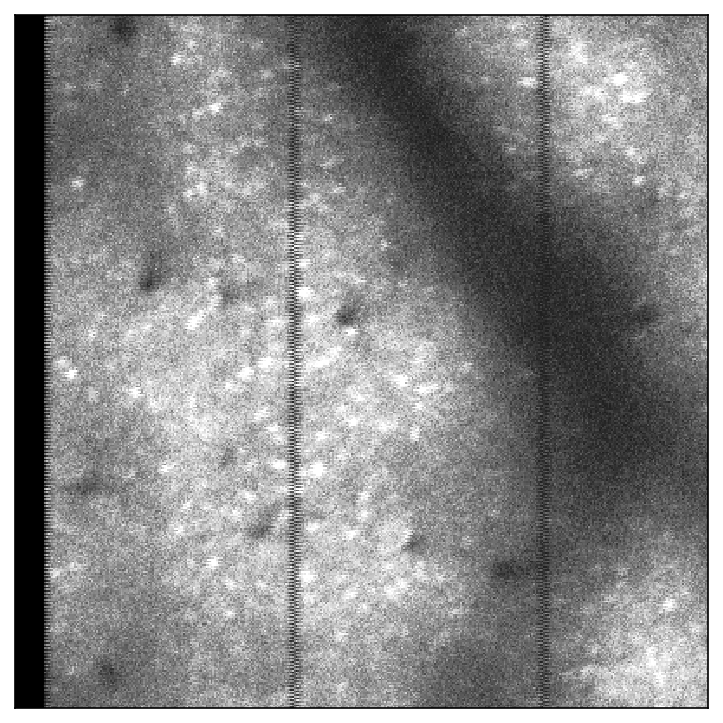

In [59]:
tfu.show_tif(vol[10, :400, :400])

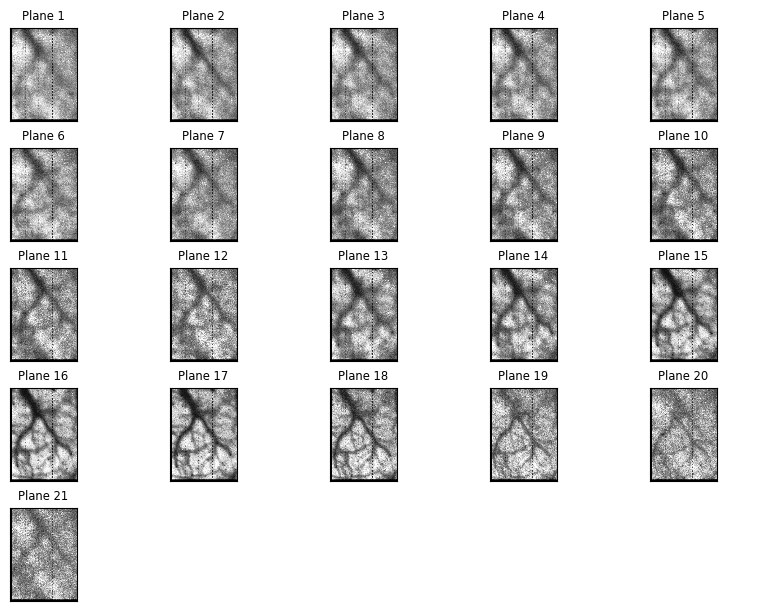

In [57]:
tfu.show_tif_all_planes(vol)

In [65]:
job.params['t_batch_size'] = 400
job.params['voxel_size_um'] = (15, 2.5, 2.5)
job.params['npil_filt_type'] = 'unif'
job.params['npil_filt_xy_um'] = 70
job.params['npil_filt_z_um'] = 15.0
job.params['cell_filt_type'] = 'unif'
job.params['cell_filt_xy_um'] = 2.5
job.params['cell_filt_z_um'] = 15.0
job.params['edge_crop_npix'] = 7
job.params['fix_vmap_edge_planes'] = True
job.params['sdnorm_exp'] = 0.85
job.params['intensity_thresh'] = 0.1
job.params['n_proc'] = 32

params_to_sweep = { 
    'cell_filt_xy_um': [2.5, 5.0, 10.0],
    'intensity_thresh' : [0.1, 0.3],
    'sdnorm_exp' : [0.85, 1.0]
}
mov_full = job.get_registered_movie('registered_fused_data', 'fused')
sweep_summary = job.sweep_corrmap(params_to_sweep, mov = mov_full[:,:100],all_combinations=True)

   Setting up sweep
   Created dir /mnt/md0/runs/s3d-AH012_2024-06-07_8/sweeps with tag sweeps
      Updating self.dirs tag sweeps
   Created dir /mnt/md0/runs/s3d-AH012_2024-06-07_8/sweeps/corrmap with tag sweeps-corrmap
      Updating self.dirs tag sweeps-corrmap
   Total of 12 combinations
      Created directory for comb_00000 with params comb00000-params-cell_filt_xy_um_2.500-intensity_thresh_0.100-sdnorm_exp_0.850
   Created dir /mnt/md0/runs/s3d-AH012_2024-06-07_8/sweeps/corrmap/comb_00000 with tag sweeps-corrmap-comb_00000
      Updating self.dirs tag sweeps-corrmap-comb_00000
      Created directory for comb_00001 with params comb00001-params-cell_filt_xy_um_2.500-intensity_thresh_0.100-sdnorm_exp_1.000
   Created dir /mnt/md0/runs/s3d-AH012_2024-06-07_8/sweeps/corrmap/comb_00001 with tag sweeps-corrmap-comb_00001
      Updating self.dirs tag sweeps-corrmap-comb_00001
      Created directory for comb_00002 with params comb00002-params-cell_filt_xy_um_2.500-intensity_thresh_0.3

         Reducing filtered movie to compute correlation map
      Overwriting existing /mnt/md0/runs/s3d-AH012_2024-06-07_8/sweeps/corrmap/sweep_summary.npy
Running combination 06/12
   Created dir /mnt/md0/runs/s3d-AH012_2024-06-07_8/sweeps/corrmap/comb_00005/corrmap with tag sweeps-corrmap-comb_00005-corrmap
      Updating self.dirs tag sweeps-corrmap-comb_00005-corrmap
   Created dir /mnt/md0/runs/s3d-AH012_2024-06-07_8/sweeps/corrmap/comb_00005/mov_sub with tag sweeps-corrmap-comb_00005-mov_sub
      Updating self.dirs tag sweeps-corrmap-comb_00005-mov_sub
   Saved a copy of params at /mnt/md0/runs/s3d-AH012_2024-06-07_8/sweeps/corrmap/comb_00005/corrmap
   Updated main params file
   Computing correlation map of movie with 100 frames, volume shape: 21, 1000, 720
      Running batch 1 of 1
         Loading movie into shared memory
         Subtracting neuropil and applying cell filters
         Reducing filtered movie to compute correlation map
      Overwriting existing /mnt/md0/r

In [66]:
job.params['t_batch_size'] = 400
job.params['voxel_size_um'] = (15, 2.5, 2.5)
job.params['npil_filt_type'] = 'unif'
job.params['npil_filt_xy_um'] = 70
job.params['npil_filt_z_um'] = 15.0
job.params['cell_filt_type'] = 'unif'
job.params['cell_filt_xy_um'] = 10
job.params['cell_filt_z_um'] = 15.0
job.params['edge_crop_npix'] = 7
job.params['fix_vmap_edge_planes'] = True
job.params['sdnorm_exp'] = 0.85
job.params['intensity_thresh'] = 0.1
job.params['n_proc'] = 32
job.calculate_corr_map()

      Found dir /mnt/md0/runs/s3d-AH012_2024-06-07_8/corrmap
      Updating self.dirs tag corrmap
      Found dir /mnt/md0/runs/s3d-AH012_2024-06-07_8/mov_sub
      Updating self.dirs tag mov_sub
   Saved a copy of params at /mnt/md0/runs/s3d-AH012_2024-06-07_8/corrmap
   Updated main params file
   Computing correlation map of movie with 5448 frames, volume shape: 21, 1000, 720
      Running batch 1 of 14
         Loading movie into shared memory
         Subtracting neuropil and applying cell filters
         Reducing filtered movie to compute correlation map
      Running batch 2 of 14
         Loading movie into shared memory
         Subtracting neuropil and applying cell filters
         Reducing filtered movie to compute correlation map
      Running batch 3 of 14
         Loading movie into shared memory
         Subtracting neuropil and applying cell filters
         Reducing filtered movie to compute correlation map
      Running batch 4 of 14
         Loading movie into shar

array([[[0.        , 0.        , 0.        , ..., 0.22430657,
         0.2328109 , 0.23916927],
        [0.        , 0.        , 0.        , ..., 0.22430657,
         0.2328109 , 0.23916927],
        [0.        , 0.        , 0.        , ..., 0.21875514,
         0.2269748 , 0.2331186 ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.08333106,
         0.08806051, 0.09523908],
        [0.        , 0.        , 0.        , ..., 0.08333106,
         0.08806051, 0.09523908],
        [0.        , 0.        , 0.        , ..., 0.07854255,
         0.08315212, 0.09021198],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0. 

In [67]:
results = job.load_corr_map_results()

(<Figure size 1200x900 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7f7a5deea100>)

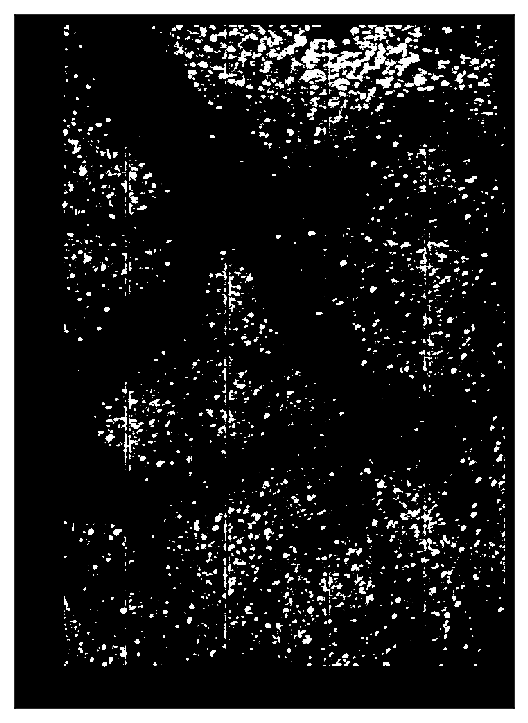

In [80]:
tfu.show_tif(results['vmap'][15], vminmax=(2.0,2.01))

In [81]:
%%time
job.params['detection_timebin'] = 1 
job.params['detection_time_crop'] = (None,None)
job.params['max_pix'] = 250
job.params['peak_thresh'] = 2.0

job.params['activity_thresh'] = 1.0
job.params['percentile'] = 98.0
job.params['extend_thresh'] = 0.15
job.params['max_iter'] = 10000 # maximum number of ROIs detected in given patch
combined_dir = job.segment_rois()

   Created dir /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation with tag segmentation
      Updating self.dirs tag segmentation
   Saved a copy of params at /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation
   Updated main params file
   Created dir /mnt/md0/runs/s3d-AH012_2024-06-07_8/rois with tag rois
      Updating self.dirs tag rois
   Saving results to /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation and /mnt/md0/runs/s3d-AH012_2024-06-07_8/rois 
dict_keys(['max_img', 'mean_img', 'vmap', 'all_params'])
   Detecting from patch 1 / 88
   Created dir /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation/patch-0000 with tag segmentation-patch-0000
         Loading 6.14 GB movie to memory, shape: (5448, 21, 120, 120) 
         Loaded
         Loading movie patch to shared memory
         Loaded
      Starting extraction with peak_thresh: 2.000 and Th2: 1.000
         Iter 0000: running 08 ROIs in parallel
         Added cell 1 at 13, 069, 072, peak: 3.430, thresh: 1.000, 1605 frames, 17

         Added cell 81 at 14, 033, 067, peak: 2.177, thresh: 1.000, 1759 frames, 10 pixels
         Added cell 82 at 15, 016, 076, peak: 2.175, thresh: 1.000, 1802 frames, 11 pixels
         Added cell 83 at 05, 044, 086, peak: 2.175, thresh: 1.000, 1778 frames, 10 pixels
         Added cell 84 at 15, 045, 094, peak: 2.168, thresh: 1.000, 1751 frames, 10 pixels
         Added cell 85 at 07, 103, 057, peak: 2.167, thresh: 1.000, 1805 frames, 12 pixels
         Added cell 86 at 04, 081, 081, peak: 2.164, thresh: 1.000, 1804 frames, 11 pixels
         Added cell 87 at 06, 079, 098, peak: 2.162, thresh: 1.000, 1828 frames, 9 pixels
         Added cell 88 at 09, 101, 056, peak: 2.161, thresh: 1.000, 1698 frames, 10 pixels
         Iter 0011: running 08 ROIs in parallel
         Added cell 89 at 07, 098, 088, peak: 2.160, thresh: 1.000, 1735 frames, 14 pixels
         Added cell 90 at 07, 037, 082, peak: 2.159, thresh: 1.000, 1756 frames, 9 pixels
         Added cell 91 at 07, 036, 101, peak

         Added cell 169 at 08, 082, 096, peak: 2.070, thresh: 1.000, 1758 frames, 10 pixels
         Added cell 170 at 05, 092, 093, peak: 2.070, thresh: 1.000, 1814 frames, 10 pixels
         Added cell 171 at 17, 000, 094, peak: 2.070, thresh: 1.000, 1275 frames, 3 pixels
         Added cell 172 at 14, 067, 065, peak: 2.070, thresh: 1.000, 1835 frames, 10 pixels
         Added cell 173 at 00, 060, 075, peak: 2.069, thresh: 1.000, 1763 frames, 9 pixels
         Added cell 174 at 17, 000, 085, peak: 2.067, thresh: 1.000, 1519 frames, 3 pixels
         Added cell 175 at 12, 086, 060, peak: 2.067, thresh: 1.000, 1748 frames, 10 pixels
         Added cell 176 at 08, 097, 094, peak: 2.066, thresh: 1.000, 1790 frames, 10 pixels
         Iter 0022: running 08 ROIs in parallel
         Added cell 177 at 06, 103, 068, peak: 2.066, thresh: 1.000, 1770 frames, 9 pixels
         Added cell 178 at 00, 063, 078, peak: 2.066, thresh: 1.000, 1824 frames, 10 pixels
         Added cell 179 at 17, 000, 

         Added cell 257 at 06, 033, 065, peak: 2.019, thresh: 1.000, 1733 frames, 9 pixels
         Added cell 258 at 08, 082, 049, peak: 2.019, thresh: 1.000, 1675 frames, 10 pixels
         Added cell 259 at 07, 055, 081, peak: 2.017, thresh: 1.000, 1770 frames, 8 pixels
         Added cell 260 at 14, 031, 065, peak: 2.017, thresh: 1.000, 1777 frames, 9 pixels
         Added cell 261 at 16, 012, 076, peak: 2.017, thresh: 1.000, 1824 frames, 9 pixels
         Added cell 262 at 08, 067, 101, peak: 2.016, thresh: 1.000, 1757 frames, 9 pixels
         Added cell 263 at 01, 101, 099, peak: 2.016, thresh: 1.000, 1841 frames, 9 pixels
         Added cell 264 at 08, 077, 080, peak: 2.016, thresh: 1.000, 1779 frames, 10 pixels
         Iter 0033: running 08 ROIs in parallel
         Added cell 265 at 15, 083, 077, peak: 2.015, thresh: 1.000, 1852 frames, 9 pixels
         Added cell 266 at 07, 076, 098, peak: 2.015, thresh: 1.000, 1739 frames, 9 pixels
         Added cell 267 at 00, 041, 085,

         Added cell 33 at 04, 055, 109, peak: 2.307, thresh: 1.000, 1751 frames, 15 pixels
         Added cell 34 at 00, 058, 117, peak: 2.304, thresh: 1.000, 1855 frames, 17 pixels
         Added cell 35 at 09, 094, 105, peak: 2.298, thresh: 1.000, 1730 frames, 14 pixels
         Added cell 36 at 09, 067, 157, peak: 2.296, thresh: 1.000, 1596 frames, 21 pixels
         Added cell 37 at 09, 081, 172, peak: 2.270, thresh: 1.000, 1660 frames, 12 pixels
         Added cell 38 at 09, 061, 168, peak: 2.261, thresh: 1.000, 1647 frames, 26 pixels
         Added cell 39 at 06, 036, 123, peak: 2.260, thresh: 1.000, 1678 frames, 12 pixels
         Added cell 40 at 10, 056, 108, peak: 2.250, thresh: 1.000, 1717 frames, 22 pixels
         Iter 0005: running 08 ROIs in parallel
         Added cell 41 at 08, 072, 157, peak: 2.241, thresh: 1.000, 1681 frames, 9 pixels
         Added cell 42 at 09, 082, 125, peak: 2.237, thresh: 1.000, 1687 frames, 13 pixels
         Added cell 43 at 07, 076, 126, pea

         Added cell 121 at 00, 057, 114, peak: 2.060, thresh: 1.000, 1767 frames, 14 pixels
         Added cell 122 at 09, 056, 110, peak: 2.058, thresh: 1.000, 1705 frames, 10 pixels
         Added cell 123 at 17, 000, 140, peak: 2.058, thresh: 1.000, 1019 frames, 3 pixels
         Added cell 124 at 17, 000, 185, peak: 2.058, thresh: 1.000, 1406 frames, 2 pixels
         Added cell 125 at 11, 084, 106, peak: 2.055, thresh: 1.000, 1618 frames, 14 pixels
         Added cell 126 at 17, 000, 150, peak: 2.055, thresh: 1.000, 1128 frames, 3 pixels
         Added cell 127 at 01, 064, 107, peak: 2.053, thresh: 1.000, 1678 frames, 11 pixels
         Added cell 128 at 07, 103, 126, peak: 2.052, thresh: 1.000, 1797 frames, 19 pixels
         Iter 0016: running 08 ROIs in parallel
         Added cell 129 at 09, 074, 150, peak: 2.052, thresh: 1.000, 1640 frames, 14 pixels
         Added cell 130 at 06, 064, 146, peak: 2.051, thresh: 1.000, 1678 frames, 9 pixels
         Added cell 131 at 09, 103, 

         Added cell 209 at 07, 098, 111, peak: 2.007, thresh: 1.000, 1797 frames, 10 pixels
         Added cell 210 at 10, 098, 108, peak: 2.007, thresh: 1.000, 1664 frames, 10 pixels
         Added cell 211 at 00, 058, 120, peak: 2.007, thresh: 1.000, 1711 frames, 9 pixels
         Added cell 212 at 17, 000, 168, peak: 2.006, thresh: 1.000, 670 frames, 3 pixels
         Added cell 213 at 10, 062, 183, peak: 2.005, thresh: 1.000, 1525 frames, 11 pixels
         Added cell 214 at 09, 048, 129, peak: 2.005, thresh: 1.000, 1721 frames, 9 pixels
         Added cell 215 at 09, 074, 118, peak: 2.005, thresh: 1.000, 1695 frames, 9 pixels
         Added cell 216 at 07, 077, 152, peak: 2.005, thresh: 1.000, 1751 frames, 9 pixels
         Iter 0027: running 05 ROIs in parallel
         Added cell 217 at 07, 078, 157, peak: 2.004, thresh: 1.000, 1730 frames, 9 pixels
         Added cell 218 at 17, 000, 152, peak: 2.003, thresh: 1.000, 904 frames, 3 pixels
         Added cell 219 at 01, 047, 118, 

         Added cell 73 at 01, 026, 266, peak: 2.362, thresh: 1.000, 1799 frames, 14 pixels
         Added cell 74 at 15, 051, 237, peak: 2.355, thresh: 1.000, 1890 frames, 15 pixels
         Added cell 75 at 00, 051, 235, peak: 2.355, thresh: 1.000, 1759 frames, 13 pixels
         Added cell 76 at 16, 024, 195, peak: 2.344, thresh: 1.000, 1751 frames, 13 pixels
         Added cell 77 at 16, 013, 229, peak: 2.339, thresh: 1.000, 1841 frames, 9 pixels
         Added cell 78 at 13, 044, 263, peak: 2.335, thresh: 1.000, 1734 frames, 10 pixels
         Added cell 79 at 02, 016, 266, peak: 2.334, thresh: 1.000, 1793 frames, 16 pixels
         Added cell 80 at 01, 037, 272, peak: 2.328, thresh: 1.000, 1754 frames, 14 pixels
         Iter 0010: running 08 ROIs in parallel
         Added cell 81 at 04, 072, 267, peak: 2.325, thresh: 1.000, 1677 frames, 9 pixels
         Added cell 82 at 16, 017, 273, peak: 2.322, thresh: 1.000, 1689 frames, 21 pixels
         Added cell 83 at 16, 024, 263, peak

         Added cell 161 at 17, 000, 233, peak: 2.151, thresh: 1.000, 1620 frames, 2 pixels
         Added cell 162 at 16, 077, 251, peak: 2.149, thresh: 1.000, 1928 frames, 10 pixels
         Added cell 163 at 17, 000, 257, peak: 2.148, thresh: 1.000, 1665 frames, 3 pixels
         Added cell 164 at 15, 026, 259, peak: 2.145, thresh: 1.000, 1853 frames, 10 pixels
         Added cell 165 at 16, 051, 230, peak: 2.145, thresh: 1.000, 1919 frames, 9 pixels
         Added cell 166 at 13, 026, 266, peak: 2.144, thresh: 1.000, 1728 frames, 9 pixels
         Added cell 167 at 15, 070, 264, peak: 2.143, thresh: 1.000, 1879 frames, 9 pixels
         Added cell 168 at 04, 081, 253, peak: 2.143, thresh: 1.000, 1679 frames, 12 pixels
         Iter 0021: running 08 ROIs in parallel
         Added cell 169 at 17, 000, 195, peak: 2.142, thresh: 1.000, 1649 frames, 3 pixels
         Added cell 170 at 12, 031, 258, peak: 2.142, thresh: 1.000, 1748 frames, 10 pixels
         Added cell 171 at 17, 000, 22

         Added cell 249 at 16, 067, 220, peak: 2.095, thresh: 1.000, 1800 frames, 11 pixels
         Added cell 250 at 15, 091, 257, peak: 2.094, thresh: 1.000, 1834 frames, 9 pixels
         Added cell 251 at 02, 094, 273, peak: 2.093, thresh: 1.000, 1806 frames, 9 pixels
         Added cell 252 at 16, 057, 229, peak: 2.093, thresh: 1.000, 1879 frames, 9 pixels
         Added cell 253 at 17, 000, 259, peak: 2.093, thresh: 1.000, 1519 frames, 1 pixels
         Added cell 254 at 16, 039, 231, peak: 2.092, thresh: 1.000, 1835 frames, 10 pixels
         Added cell 255 at 00, 025, 210, peak: 2.092, thresh: 1.000, 1578 frames, 10 pixels
         Added cell 256 at 00, 072, 259, peak: 2.092, thresh: 1.000, 1834 frames, 9 pixels
         Iter 0032: running 08 ROIs in parallel
         Added cell 257 at 00, 072, 273, peak: 2.092, thresh: 1.000, 1751 frames, 9 pixels
         Added cell 258 at 01, 019, 262, peak: 2.091, thresh: 1.000, 1776 frames, 9 pixels
         Added cell 259 at 17, 000, 222

         Added cell 337 at 02, 060, 235, peak: 2.049, thresh: 1.000, 1680 frames, 9 pixels
         Added cell 338 at 05, 047, 216, peak: 2.049, thresh: 1.000, 1672 frames, 12 pixels
         Added cell 339 at 15, 025, 210, peak: 2.048, thresh: 1.000, 1836 frames, 9 pixels
         Added cell 340 at 15, 055, 230, peak: 2.048, thresh: 1.000, 1825 frames, 9 pixels
         Added cell 341 at 17, 000, 242, peak: 2.047, thresh: 1.000, 1590 frames, 2 pixels
         Added cell 342 at 17, 000, 188, peak: 2.047, thresh: 1.000, 1544 frames, 3 pixels
         Added cell 343 at 14, 056, 271, peak: 2.047, thresh: 1.000, 1884 frames, 10 pixels
         Added cell 344 at 14, 063, 245, peak: 2.047, thresh: 1.000, 1818 frames, 9 pixels
         Iter 0043: running 08 ROIs in parallel
         Added cell 345 at 07, 089, 195, peak: 2.047, thresh: 1.000, 1693 frames, 9 pixels
         Added cell 346 at 17, 069, 256, peak: 2.046, thresh: 1.000, 1669 frames, 9 pixels
         Added cell 347 at 01, 098, 270,

         Added cell 425 at 16, 084, 261, peak: 2.026, thresh: 1.000, 1886 frames, 10 pixels
         Added cell 426 at 15, 032, 234, peak: 2.024, thresh: 1.000, 1875 frames, 9 pixels
         Added cell 427 at 02, 054, 236, peak: 2.024, thresh: 1.000, 1701 frames, 9 pixels
         Added cell 428 at 12, 037, 235, peak: 2.024, thresh: 1.000, 1779 frames, 9 pixels
         Added cell 429 at 01, 039, 264, peak: 2.023, thresh: 1.000, 1814 frames, 9 pixels
         Added cell 430 at 15, 081, 268, peak: 2.023, thresh: 1.000, 1891 frames, 9 pixels
         Added cell 431 at 17, 017, 222, peak: 2.023, thresh: 1.000, 1723 frames, 9 pixels
         Added cell 432 at 14, 071, 251, peak: 2.023, thresh: 1.000, 1831 frames, 9 pixels
         Iter 0054: running 08 ROIs in parallel
         Added cell 433 at 12, 068, 271, peak: 2.022, thresh: 1.000, 1785 frames, 9 pixels
         Added cell 434 at 12, 037, 267, peak: 2.022, thresh: 1.000, 1758 frames, 8 pixels
         Added cell 435 at 15, 033, 246, 

         Added cell 513 at 14, 034, 233, peak: 2.002, thresh: 1.000, 1806 frames, 10 pixels
         Added cell 514 at 01, 018, 217, peak: 2.002, thresh: 1.000, 1647 frames, 10 pixels
         Added cell 515 at 15, 067, 272, peak: 2.002, thresh: 1.000, 1841 frames, 9 pixels
         Added cell 516 at 01, 053, 260, peak: 2.002, thresh: 1.000, 1776 frames, 9 pixels
         Added cell 517 at 00, 019, 239, peak: 2.002, thresh: 1.000, 1704 frames, 9 pixels
         Added cell 518 at 16, 039, 252, peak: 2.002, thresh: 1.000, 1824 frames, 9 pixels
         Added cell 519 at 14, 023, 219, peak: 2.002, thresh: 1.000, 1800 frames, 9 pixels
         Added cell 520 at 14, 027, 242, peak: 2.002, thresh: 1.000, 1839 frames, 9 pixels
         Iter 0065: running 05 ROIs in parallel
         Added cell 521 at 15, 045, 232, peak: 2.002, thresh: 1.000, 1873 frames, 11 pixels
         Added cell 522 at 04, 036, 261, peak: 2.001, thresh: 1.000, 1775 frames, 9 pixels
         Added cell 523 at 15, 050, 234

         Added cell 73 at 13, 035, 320, peak: 2.939, thresh: 1.000, 1743 frames, 24 pixels
         Added cell 74 at 14, 032, 357, peak: 2.933, thresh: 1.000, 1775 frames, 19 pixels
         Added cell 75 at 13, 064, 301, peak: 2.918, thresh: 1.000, 1930 frames, 22 pixels
         Added cell 76 at 03, 044, 288, peak: 2.917, thresh: 1.000, 1760 frames, 13 pixels
         Added cell 77 at 14, 086, 338, peak: 2.916, thresh: 1.000, 1684 frames, 17 pixels
         Added cell 78 at 14, 042, 278, peak: 2.907, thresh: 1.000, 1852 frames, 14 pixels
         Added cell 79 at 12, 074, 303, peak: 2.898, thresh: 1.000, 2368 frames, 80 pixels
         Added cell 80 at 13, 049, 320, peak: 2.871, thresh: 1.000, 1714 frames, 21 pixels
         Iter 0010: running 08 ROIs in parallel
         Added cell 81 at 00, 076, 274, peak: 2.865, thresh: 1.000, 1845 frames, 18 pixels
         Added cell 82 at 07, 042, 297, peak: 2.864, thresh: 1.000, 1693 frames, 36 pixels
         Added cell 83 at 02, 033, 276, pe

         Added cell 161 at 07, 044, 301, peak: 2.509, thresh: 1.000, 1952 frames, 35 pixels
         Added cell 162 at 15, 056, 336, peak: 2.505, thresh: 1.000, 1884 frames, 13 pixels
         Added cell 163 at 14, 102, 280, peak: 2.504, thresh: 1.000, 1848 frames, 12 pixels
         Added cell 164 at 02, 034, 286, peak: 2.501, thresh: 1.000, 1759 frames, 9 pixels
         Added cell 165 at 12, 033, 330, peak: 2.500, thresh: 1.000, 1778 frames, 15 pixels
         Added cell 166 at 14, 028, 350, peak: 2.496, thresh: 1.000, 1909 frames, 12 pixels
         Added cell 167 at 15, 103, 339, peak: 2.496, thresh: 1.000, 1862 frames, 11 pixels
         Added cell 168 at 16, 033, 336, peak: 2.496, thresh: 1.000, 1791 frames, 13 pixels
         Iter 0021: running 08 ROIs in parallel
         Added cell 169 at 02, 041, 355, peak: 2.495, thresh: 1.000, 1807 frames, 13 pixels
         Added cell 170 at 06, 041, 352, peak: 2.490, thresh: 1.000, 1825 frames, 14 pixels
         Added cell 171 at 13, 04

         Added cell 249 at 00, 101, 339, peak: 2.365, thresh: 1.000, 1774 frames, 9 pixels
         Added cell 250 at 13, 041, 337, peak: 2.365, thresh: 1.000, 1753 frames, 9 pixels
         Added cell 251 at 04, 070, 295, peak: 2.365, thresh: 1.000, 1881 frames, 17 pixels
         Added cell 252 at 15, 035, 330, peak: 2.364, thresh: 1.000, 1879 frames, 11 pixels
         Added cell 253 at 03, 079, 290, peak: 2.363, thresh: 1.000, 1773 frames, 9 pixels
         Added cell 254 at 12, 071, 345, peak: 2.363, thresh: 1.000, 1753 frames, 9 pixels
         Added cell 255 at 10, 070, 296, peak: 2.361, thresh: 1.000, 1591 frames, 19 pixels
         Added cell 256 at 12, 086, 305, peak: 2.360, thresh: 1.000, 1676 frames, 10 pixels
         Iter 0032: running 08 ROIs in parallel
         Added cell 257 at 00, 101, 334, peak: 2.358, thresh: 1.000, 1759 frames, 10 pixels
         Added cell 258 at 03, 053, 339, peak: 2.357, thresh: 1.000, 1762 frames, 12 pixels
         Added cell 259 at 00, 092, 

         Added cell 337 at 07, 046, 296, peak: 2.280, thresh: 1.000, 1738 frames, 9 pixels
         Added cell 338 at 06, 046, 278, peak: 2.277, thresh: 1.000, 1819 frames, 17 pixels
         Added cell 339 at 17, 062, 357, peak: 2.277, thresh: 1.000, 1655 frames, 9 pixels
         Added cell 340 at 15, 027, 318, peak: 2.276, thresh: 1.000, 1901 frames, 11 pixels
         Added cell 341 at 14, 050, 356, peak: 2.276, thresh: 1.000, 1857 frames, 13 pixels
         Added cell 342 at 16, 066, 322, peak: 2.275, thresh: 1.000, 1780 frames, 9 pixels
         Added cell 343 at 16, 077, 327, peak: 2.275, thresh: 1.000, 1828 frames, 11 pixels
         Added cell 344 at 12, 038, 287, peak: 2.274, thresh: 1.000, 1796 frames, 9 pixels
         Iter 0043: running 08 ROIs in parallel
         Added cell 345 at 13, 031, 276, peak: 2.273, thresh: 1.000, 1741 frames, 9 pixels
         Added cell 346 at 02, 100, 339, peak: 2.273, thresh: 1.000, 1740 frames, 9 pixels
         Added cell 347 at 13, 047, 31

         Added cell 425 at 12, 053, 343, peak: 2.220, thresh: 1.000, 1773 frames, 13 pixels
         Added cell 426 at 02, 101, 332, peak: 2.219, thresh: 1.000, 1749 frames, 11 pixels
         Added cell 427 at 01, 012, 310, peak: 2.219, thresh: 1.000, 1866 frames, 15 pixels
         Added cell 428 at 06, 075, 330, peak: 2.218, thresh: 1.000, 1837 frames, 14 pixels
         Added cell 429 at 03, 083, 322, peak: 2.218, thresh: 1.000, 1878 frames, 9 pixels
         Added cell 430 at 03, 041, 353, peak: 2.217, thresh: 1.000, 1779 frames, 10 pixels
         Added cell 431 at 03, 060, 351, peak: 2.217, thresh: 1.000, 1825 frames, 10 pixels
         Added cell 432 at 15, 056, 339, peak: 2.216, thresh: 1.000, 1905 frames, 9 pixels
         Iter 0054: running 08 ROIs in parallel
         Added cell 433 at 12, 086, 301, peak: 2.216, thresh: 1.000, 1765 frames, 10 pixels
         Added cell 434 at 12, 065, 357, peak: 2.216, thresh: 1.000, 1722 frames, 9 pixels
         Added cell 435 at 01, 052,

         Added cell 513 at 17, 000, 343, peak: 2.181, thresh: 1.000, 1589 frames, 2 pixels
         Added cell 514 at 05, 043, 354, peak: 2.181, thresh: 1.000, 1687 frames, 9 pixels
         Added cell 515 at 13, 047, 347, peak: 2.180, thresh: 1.000, 1813 frames, 12 pixels
         Added cell 516 at 02, 094, 277, peak: 2.180, thresh: 1.000, 1832 frames, 10 pixels
         Added cell 517 at 14, 044, 309, peak: 2.180, thresh: 1.000, 1774 frames, 9 pixels
         Added cell 518 at 03, 103, 297, peak: 2.180, thresh: 1.000, 1822 frames, 12 pixels
         Added cell 519 at 15, 084, 300, peak: 2.179, thresh: 1.000, 1831 frames, 9 pixels
         Added cell 520 at 01, 103, 331, peak: 2.179, thresh: 1.000, 1830 frames, 11 pixels
         Iter 0065: running 08 ROIs in parallel
         Added cell 521 at 01, 072, 280, peak: 2.178, thresh: 1.000, 1852 frames, 9 pixels
         Added cell 522 at 14, 089, 348, peak: 2.178, thresh: 1.000, 1839 frames, 11 pixels
         Added cell 523 at 15, 022, 3

         Added cell 601 at 05, 032, 302, peak: 2.151, thresh: 1.000, 1805 frames, 11 pixels
         Added cell 602 at 02, 048, 284, peak: 2.151, thresh: 1.000, 1767 frames, 9 pixels
         Added cell 603 at 09, 077, 347, peak: 2.151, thresh: 1.000, 1726 frames, 11 pixels
         Added cell 604 at 12, 059, 321, peak: 2.151, thresh: 1.000, 1783 frames, 9 pixels
         Added cell 605 at 17, 000, 355, peak: 2.151, thresh: 1.000, 1604 frames, 2 pixels
         Added cell 606 at 13, 038, 319, peak: 2.151, thresh: 1.000, 1741 frames, 9 pixels
         Added cell 607 at 17, 000, 313, peak: 2.150, thresh: 1.000, 1650 frames, 2 pixels
         Added cell 608 at 17, 083, 355, peak: 2.150, thresh: 1.000, 1636 frames, 10 pixels
         Iter 0076: running 08 ROIs in parallel
         Added cell 609 at 01, 066, 293, peak: 2.150, thresh: 1.000, 1827 frames, 11 pixels
         Added cell 610 at 14, 037, 313, peak: 2.149, thresh: 1.000, 1874 frames, 9 pixels
         Added cell 611 at 03, 044, 29

         Added cell 689 at 14, 046, 327, peak: 2.125, thresh: 1.000, 1867 frames, 9 pixels
         Added cell 690 at 16, 072, 358, peak: 2.125, thresh: 1.000, 1800 frames, 9 pixels
         Added cell 691 at 09, 048, 302, peak: 2.125, thresh: 1.000, 1639 frames, 10 pixels
         Added cell 692 at 15, 015, 342, peak: 2.125, thresh: 1.000, 1791 frames, 11 pixels
         Added cell 693 at 06, 059, 357, peak: 2.125, thresh: 1.000, 1752 frames, 14 pixels
         Added cell 694 at 04, 024, 296, peak: 2.124, thresh: 1.000, 1838 frames, 11 pixels
         Added cell 695 at 16, 011, 353, peak: 2.124, thresh: 1.000, 1730 frames, 10 pixels
         Added cell 696 at 12, 031, 289, peak: 2.124, thresh: 1.000, 1715 frames, 9 pixels
         Iter 0087: running 08 ROIs in parallel
         Added cell 697 at 15, 043, 322, peak: 2.124, thresh: 1.000, 1904 frames, 10 pixels
         Added cell 698 at 02, 033, 320, peak: 2.124, thresh: 1.000, 1782 frames, 9 pixels
         Added cell 699 at 15, 055, 

         Added cell 777 at 03, 049, 329, peak: 2.106, thresh: 1.000, 1862 frames, 9 pixels
         Added cell 778 at 03, 071, 320, peak: 2.105, thresh: 1.000, 1897 frames, 9 pixels
         Added cell 779 at 05, 067, 285, peak: 2.105, thresh: 1.000, 1718 frames, 10 pixels
         Added cell 780 at 00, 059, 322, peak: 2.105, thresh: 1.000, 1775 frames, 9 pixels
         Added cell 781 at 12, 042, 314, peak: 2.105, thresh: 1.000, 1753 frames, 10 pixels
         Added cell 782 at 14, 054, 349, peak: 2.105, thresh: 1.000, 1886 frames, 8 pixels
         Added cell 783 at 05, 030, 297, peak: 2.104, thresh: 1.000, 1713 frames, 9 pixels
         Added cell 784 at 02, 064, 302, peak: 2.104, thresh: 1.000, 1795 frames, 14 pixels
         Iter 0098: running 08 ROIs in parallel
         Added cell 785 at 13, 085, 347, peak: 2.104, thresh: 1.000, 1760 frames, 9 pixels
         Added cell 786 at 14, 027, 321, peak: 2.104, thresh: 1.000, 1815 frames, 9 pixels
         Added cell 787 at 07, 037, 336

         Added cell 865 at 14, 040, 290, peak: 2.088, thresh: 1.000, 1816 frames, 10 pixels
         Added cell 866 at 04, 091, 317, peak: 2.087, thresh: 1.000, 1843 frames, 9 pixels
         Added cell 867 at 14, 054, 356, peak: 2.087, thresh: 1.000, 1815 frames, 11 pixels
         Added cell 868 at 06, 054, 290, peak: 2.087, thresh: 1.000, 1732 frames, 9 pixels
         Added cell 869 at 01, 061, 326, peak: 2.087, thresh: 1.000, 1804 frames, 9 pixels
         Added cell 870 at 14, 091, 312, peak: 2.087, thresh: 1.000, 1800 frames, 9 pixels
         Added cell 871 at 12, 086, 325, peak: 2.087, thresh: 1.000, 1736 frames, 9 pixels
         Added cell 872 at 01, 085, 277, peak: 2.086, thresh: 1.000, 1827 frames, 9 pixels
         Iter 0109: running 08 ROIs in parallel
         Added cell 873 at 07, 036, 303, peak: 2.086, thresh: 1.000, 1703 frames, 10 pixels
         Added cell 874 at 15, 030, 285, peak: 2.086, thresh: 1.000, 1902 frames, 9 pixels
         Added cell 875 at 14, 069, 317

         Added cell 953 at 14, 074, 357, peak: 2.074, thresh: 1.000, 1831 frames, 9 pixels
         Added cell 954 at 17, 000, 281, peak: 2.074, thresh: 1.000, 1426 frames, 3 pixels
         Added cell 955 at 04, 067, 288, peak: 2.073, thresh: 1.000, 1807 frames, 9 pixels
         Added cell 956 at 02, 033, 324, peak: 2.073, thresh: 1.000, 1823 frames, 9 pixels
         Added cell 957 at 13, 031, 332, peak: 2.073, thresh: 1.000, 1787 frames, 9 pixels
         Added cell 958 at 17, 073, 312, peak: 2.073, thresh: 1.000, 1769 frames, 9 pixels
         Added cell 959 at 04, 074, 335, peak: 2.073, thresh: 1.000, 1824 frames, 9 pixels
         Added cell 960 at 14, 066, 274, peak: 2.073, thresh: 1.000, 1833 frames, 9 pixels
         Iter 0120: running 08 ROIs in parallel
         Added cell 961 at 01, 049, 327, peak: 2.072, thresh: 1.000, 1838 frames, 9 pixels
         Added cell 962 at 08, 044, 305, peak: 2.072, thresh: 1.000, 1546 frames, 8 pixels
         Added cell 963 at 14, 033, 309, p

         Added cell 1041 at 07, 097, 293, peak: 2.060, thresh: 1.000, 1685 frames, 10 pixels
         Added cell 1042 at 15, 029, 343, peak: 2.060, thresh: 1.000, 1848 frames, 9 pixels
         Added cell 1043 at 04, 048, 315, peak: 2.060, thresh: 1.000, 1727 frames, 9 pixels
         Added cell 1044 at 08, 053, 338, peak: 2.060, thresh: 1.000, 1765 frames, 9 pixels
         Added cell 1045 at 03, 042, 281, peak: 2.060, thresh: 1.000, 1753 frames, 9 pixels
         Added cell 1046 at 07, 087, 335, peak: 2.060, thresh: 1.000, 1702 frames, 9 pixels
         Added cell 1047 at 17, 044, 349, peak: 2.060, thresh: 1.000, 1699 frames, 10 pixels
         Added cell 1048 at 03, 081, 327, peak: 2.059, thresh: 1.000, 1833 frames, 9 pixels
         Iter 0131: running 08 ROIs in parallel
         Added cell 1049 at 07, 050, 344, peak: 2.059, thresh: 1.000, 1771 frames, 9 pixels
         Added cell 1050 at 16, 060, 347, peak: 2.059, thresh: 1.000, 1840 frames, 11 pixels
         Added cell 1051 at 0

         Added cell 1129 at 03, 098, 337, peak: 2.046, thresh: 1.000, 1779 frames, 9 pixels
         Added cell 1130 at 16, 027, 352, peak: 2.046, thresh: 1.000, 1758 frames, 9 pixels
         Added cell 1131 at 16, 073, 355, peak: 2.046, thresh: 1.000, 1753 frames, 9 pixels
         Added cell 1132 at 14, 091, 346, peak: 2.046, thresh: 1.000, 1770 frames, 8 pixels
         Added cell 1133 at 15, 062, 299, peak: 2.046, thresh: 1.000, 1919 frames, 9 pixels
         Added cell 1134 at 12, 031, 279, peak: 2.046, thresh: 1.000, 1724 frames, 9 pixels
         Added cell 1135 at 16, 040, 279, peak: 2.046, thresh: 1.000, 1847 frames, 9 pixels
         Added cell 1136 at 15, 039, 326, peak: 2.045, thresh: 1.000, 1878 frames, 8 pixels
         Iter 0142: running 08 ROIs in parallel
         Added cell 1137 at 05, 031, 353, peak: 2.045, thresh: 1.000, 1813 frames, 8 pixels
         Added cell 1138 at 14, 071, 358, peak: 2.045, thresh: 1.000, 1836 frames, 10 pixels
         Added cell 1139 at 05,

         Added cell 1217 at 02, 097, 325, peak: 2.035, thresh: 1.000, 1838 frames, 10 pixels
         Added cell 1218 at 15, 029, 337, peak: 2.035, thresh: 1.000, 1841 frames, 9 pixels
         Added cell 1219 at 12, 086, 322, peak: 2.035, thresh: 1.000, 1755 frames, 9 pixels
         Added cell 1220 at 03, 026, 286, peak: 2.035, thresh: 1.000, 1769 frames, 9 pixels
         Added cell 1221 at 10, 071, 338, peak: 2.035, thresh: 1.000, 1649 frames, 9 pixels
         Added cell 1222 at 03, 029, 324, peak: 2.035, thresh: 1.000, 1748 frames, 9 pixels
         Added cell 1223 at 07, 073, 351, peak: 2.035, thresh: 1.000, 1803 frames, 9 pixels
         Added cell 1224 at 14, 043, 336, peak: 2.034, thresh: 1.000, 1745 frames, 9 pixels
         Iter 0153: running 08 ROIs in parallel
         Added cell 1225 at 16, 035, 338, peak: 2.034, thresh: 1.000, 1802 frames, 8 pixels
         Added cell 1226 at 06, 086, 354, peak: 2.034, thresh: 1.000, 1763 frames, 9 pixels
         Added cell 1227 at 14,

         Added cell 1305 at 02, 085, 344, peak: 2.026, thresh: 1.000, 1795 frames, 9 pixels
         Added cell 1306 at 01, 061, 318, peak: 2.026, thresh: 1.000, 1766 frames, 10 pixels
         Added cell 1307 at 15, 092, 308, peak: 2.026, thresh: 1.000, 1752 frames, 20 pixels
         Added cell 1308 at 03, 079, 293, peak: 2.026, thresh: 1.000, 1807 frames, 9 pixels
         Added cell 1309 at 00, 099, 283, peak: 2.026, thresh: 1.000, 1809 frames, 9 pixels
         Added cell 1310 at 00, 042, 350, peak: 2.026, thresh: 1.000, 1854 frames, 10 pixels
         Added cell 1311 at 12, 041, 352, peak: 2.026, thresh: 1.000, 1828 frames, 9 pixels
         Added cell 1312 at 05, 066, 319, peak: 2.026, thresh: 1.000, 1776 frames, 9 pixels
         Iter 0164: running 08 ROIs in parallel
         Added cell 1313 at 03, 043, 350, peak: 2.026, thresh: 1.000, 1693 frames, 10 pixels
         Added cell 1314 at 13, 058, 302, peak: 2.026, thresh: 1.000, 1748 frames, 9 pixels
         Added cell 1315 at 

         Added cell 1393 at 02, 057, 342, peak: 2.018, thresh: 1.000, 1769 frames, 9 pixels
         Added cell 1394 at 15, 085, 320, peak: 2.018, thresh: 1.000, 1863 frames, 9 pixels
         Added cell 1395 at 16, 013, 358, peak: 2.018, thresh: 1.000, 1789 frames, 9 pixels
         Added cell 1396 at 15, 045, 314, peak: 2.018, thresh: 1.000, 1822 frames, 8 pixels
         Added cell 1397 at 16, 064, 297, peak: 2.018, thresh: 1.000, 1859 frames, 9 pixels
         Added cell 1398 at 02, 083, 329, peak: 2.018, thresh: 1.000, 1851 frames, 9 pixels
         Added cell 1399 at 14, 024, 321, peak: 2.018, thresh: 1.000, 1892 frames, 9 pixels
         Added cell 1400 at 07, 073, 315, peak: 2.018, thresh: 1.000, 1784 frames, 9 pixels
         Iter 0175: running 08 ROIs in parallel
         Added cell 1401 at 03, 076, 318, peak: 2.018, thresh: 1.000, 1848 frames, 9 pixels
         Added cell 1402 at 01, 068, 276, peak: 2.018, thresh: 1.000, 1835 frames, 11 pixels
         Added cell 1403 at 02,

         Added cell 1481 at 15, 017, 317, peak: 2.011, thresh: 1.000, 1830 frames, 8 pixels
         Added cell 1482 at 12, 077, 351, peak: 2.010, thresh: 1.000, 1769 frames, 9 pixels
         Added cell 1483 at 15, 054, 292, peak: 2.010, thresh: 1.000, 1844 frames, 9 pixels
         Added cell 1484 at 02, 067, 328, peak: 2.010, thresh: 1.000, 1738 frames, 10 pixels
         Added cell 1485 at 14, 100, 274, peak: 2.010, thresh: 1.000, 1868 frames, 10 pixels
         Added cell 1486 at 14, 059, 323, peak: 2.010, thresh: 1.000, 1853 frames, 9 pixels
         Added cell 1487 at 12, 073, 326, peak: 2.010, thresh: 1.000, 1800 frames, 9 pixels
         Added cell 1488 at 06, 063, 349, peak: 2.010, thresh: 1.000, 1786 frames, 9 pixels
         Iter 0186: running 08 ROIs in parallel
         Added cell 1489 at 16, 059, 315, peak: 2.010, thresh: 1.000, 1858 frames, 9 pixels
         Added cell 1490 at 14, 033, 278, peak: 2.010, thresh: 1.000, 1820 frames, 9 pixels
         Added cell 1491 at 16

         Added cell 1569 at 00, 041, 334, peak: 2.003, thresh: 1.000, 1820 frames, 9 pixels
         Added cell 1570 at 16, 057, 319, peak: 2.003, thresh: 1.000, 1845 frames, 8 pixels
         Added cell 1571 at 05, 085, 340, peak: 2.003, thresh: 1.000, 1749 frames, 9 pixels
         Added cell 1572 at 03, 068, 309, peak: 2.003, thresh: 1.000, 1829 frames, 9 pixels
         Added cell 1573 at 14, 063, 345, peak: 2.003, thresh: 1.000, 1851 frames, 8 pixels
         Added cell 1574 at 14, 064, 282, peak: 2.003, thresh: 1.000, 1867 frames, 9 pixels
         Added cell 1575 at 15, 081, 318, peak: 2.003, thresh: 1.000, 1917 frames, 8 pixels
         Added cell 1576 at 15, 075, 316, peak: 2.003, thresh: 1.000, 1837 frames, 9 pixels
         Iter 0197: running 08 ROIs in parallel
         Added cell 1577 at 14, 080, 294, peak: 2.003, thresh: 1.000, 1841 frames, 9 pixels
         Added cell 1578 at 16, 085, 334, peak: 2.002, thresh: 1.000, 1788 frames, 8 pixels
         Added cell 1579 at 05, 

         Added cell 49 at 13, 086, 436, peak: 3.267, thresh: 1.000, 1798 frames, 26 pixels
         Added cell 50 at 03, 092, 411, peak: 3.254, thresh: 1.000, 1821 frames, 115 pixels
         Added cell 51 at 16, 012, 416, peak: 3.247, thresh: 1.000, 1924 frames, 27 pixels
         Added cell 52 at 05, 031, 399, peak: 3.223, thresh: 1.000, 2002 frames, 37 pixels
         Added cell 53 at 04, 089, 431, peak: 3.214, thresh: 1.000, 1732 frames, 9 pixels
         Added cell 54 at 14, 060, 440, peak: 3.212, thresh: 1.000, 1920 frames, 34 pixels
         Added cell 55 at 03, 059, 440, peak: 3.212, thresh: 1.000, 1766 frames, 13 pixels
         Added cell 56 at 08, 080, 382, peak: 3.209, thresh: 1.000, 1696 frames, 21 pixels
         Iter 0007: running 08 ROIs in parallel
         Added cell 57 at 14, 100, 444, peak: 3.201, thresh: 1.000, 1902 frames, 25 pixels
         Added cell 58 at 04, 086, 434, peak: 3.193, thresh: 1.000, 1552 frames, 10 pixels
         Added cell 59 at 14, 047, 392, pe

         Added cell 137 at 12, 069, 371, peak: 2.795, thresh: 1.000, 1709 frames, 17 pixels
         Added cell 138 at 13, 074, 367, peak: 2.783, thresh: 1.000, 1738 frames, 15 pixels
         Added cell 139 at 14, 074, 386, peak: 2.782, thresh: 1.000, 1836 frames, 14 pixels
         Added cell 140 at 03, 101, 379, peak: 2.782, thresh: 1.000, 1644 frames, 21 pixels
         Added cell 141 at 14, 072, 442, peak: 2.780, thresh: 1.000, 1848 frames, 21 pixels
         Added cell 142 at 16, 059, 432, peak: 2.777, thresh: 1.000, 1761 frames, 15 pixels
         Added cell 143 at 06, 090, 390, peak: 2.774, thresh: 1.000, 1753 frames, 21 pixels
         Added cell 144 at 13, 073, 412, peak: 2.771, thresh: 1.000, 1821 frames, 21 pixels
         Iter 0018: running 08 ROIs in parallel
         Added cell 145 at 13, 090, 439, peak: 2.765, thresh: 1.000, 1824 frames, 17 pixels
         Added cell 146 at 12, 075, 411, peak: 2.764, thresh: 1.000, 1686 frames, 16 pixels
         Added cell 147 at 12, 0

         Added cell 225 at 08, 080, 386, peak: 2.576, thresh: 1.000, 1706 frames, 10 pixels
         Added cell 226 at 12, 079, 393, peak: 2.573, thresh: 1.000, 1722 frames, 9 pixels
         Added cell 227 at 14, 072, 420, peak: 2.571, thresh: 1.000, 1883 frames, 13 pixels
         Added cell 228 at 17, 069, 401, peak: 2.569, thresh: 1.000, 1765 frames, 16 pixels
         Added cell 229 at 14, 059, 436, peak: 2.569, thresh: 1.000, 1856 frames, 12 pixels
         Added cell 230 at 12, 043, 380, peak: 2.565, thresh: 1.000, 1802 frames, 12 pixels
         Added cell 231 at 01, 069, 383, peak: 2.557, thresh: 1.000, 1866 frames, 17 pixels
         Added cell 232 at 08, 058, 412, peak: 2.557, thresh: 1.000, 1853 frames, 13 pixels
         Iter 0029: running 08 ROIs in parallel
         Added cell 233 at 08, 102, 426, peak: 2.553, thresh: 1.000, 1736 frames, 22 pixels
         Added cell 234 at 12, 079, 380, peak: 2.553, thresh: 1.000, 1919 frames, 10 pixels
         Added cell 235 at 16, 07

         Added cell 313 at 08, 082, 379, peak: 2.441, thresh: 1.000, 1681 frames, 11 pixels
         Added cell 314 at 16, 012, 406, peak: 2.440, thresh: 1.000, 1788 frames, 13 pixels
         Added cell 315 at 13, 090, 427, peak: 2.439, thresh: 1.000, 1739 frames, 9 pixels
         Added cell 316 at 12, 098, 444, peak: 2.438, thresh: 1.000, 1814 frames, 28 pixels
         Added cell 317 at 04, 048, 391, peak: 2.434, thresh: 1.000, 1858 frames, 18 pixels
         Added cell 318 at 07, 040, 393, peak: 2.432, thresh: 1.000, 1681 frames, 10 pixels
         Added cell 319 at 14, 038, 363, peak: 2.432, thresh: 1.000, 1895 frames, 16 pixels
         Added cell 320 at 12, 081, 382, peak: 2.431, thresh: 1.000, 1814 frames, 12 pixels
         Iter 0040: running 08 ROIs in parallel
         Added cell 321 at 15, 091, 396, peak: 2.429, thresh: 1.000, 1839 frames, 13 pixels
         Added cell 322 at 03, 051, 372, peak: 2.428, thresh: 1.000, 1689 frames, 13 pixels
         Added cell 323 at 03, 04

         Added cell 401 at 14, 089, 392, peak: 2.347, thresh: 1.000, 1913 frames, 9 pixels
         Added cell 402 at 15, 096, 427, peak: 2.346, thresh: 1.000, 1882 frames, 15 pixels
         Added cell 403 at 01, 076, 367, peak: 2.345, thresh: 1.000, 1845 frames, 11 pixels
         Added cell 404 at 08, 056, 432, peak: 2.345, thresh: 1.000, 1607 frames, 14 pixels
         Added cell 405 at 06, 068, 368, peak: 2.344, thresh: 1.000, 1754 frames, 15 pixels
         Added cell 406 at 08, 100, 375, peak: 2.344, thresh: 1.000, 1662 frames, 10 pixels
         Added cell 407 at 15, 089, 433, peak: 2.343, thresh: 1.000, 1894 frames, 9 pixels
         Added cell 408 at 04, 079, 362, peak: 2.341, thresh: 1.000, 1795 frames, 9 pixels
         Iter 0051: running 08 ROIs in parallel
         Added cell 409 at 14, 073, 438, peak: 2.341, thresh: 1.000, 1879 frames, 14 pixels
         Added cell 410 at 01, 097, 399, peak: 2.340, thresh: 1.000, 1785 frames, 13 pixels
         Added cell 411 at 05, 064,

         Added cell 489 at 15, 101, 381, peak: 2.285, thresh: 1.000, 1876 frames, 10 pixels
         Added cell 490 at 04, 100, 388, peak: 2.285, thresh: 1.000, 1783 frames, 9 pixels
         Added cell 491 at 14, 092, 403, peak: 2.285, thresh: 1.000, 1862 frames, 9 pixels
         Added cell 492 at 14, 057, 383, peak: 2.285, thresh: 1.000, 1834 frames, 12 pixels
         Added cell 493 at 13, 045, 370, peak: 2.283, thresh: 1.000, 1711 frames, 9 pixels
         Added cell 494 at 12, 037, 406, peak: 2.283, thresh: 1.000, 1719 frames, 13 pixels
         Added cell 495 at 08, 065, 410, peak: 2.282, thresh: 1.000, 1739 frames, 17 pixels
         Added cell 496 at 07, 099, 399, peak: 2.281, thresh: 1.000, 1718 frames, 12 pixels
         Iter 0062: running 08 ROIs in parallel
         Added cell 497 at 15, 048, 360, peak: 2.280, thresh: 1.000, 1817 frames, 10 pixels
         Added cell 498 at 06, 056, 405, peak: 2.280, thresh: 1.000, 1649 frames, 10 pixels
         Added cell 499 at 00, 022,

         Added cell 577 at 15, 054, 395, peak: 2.240, thresh: 1.000, 1860 frames, 9 pixels
         Added cell 578 at 12, 070, 374, peak: 2.237, thresh: 1.000, 1810 frames, 9 pixels
         Added cell 579 at 06, 091, 393, peak: 2.237, thresh: 1.000, 1833 frames, 9 pixels
         Added cell 580 at 03, 091, 418, peak: 2.237, thresh: 1.000, 1735 frames, 11 pixels
         Added cell 581 at 06, 102, 412, peak: 2.236, thresh: 1.000, 1807 frames, 12 pixels
         Added cell 582 at 03, 099, 439, peak: 2.236, thresh: 1.000, 1707 frames, 10 pixels
         Added cell 583 at 02, 096, 418, peak: 2.236, thresh: 1.000, 1837 frames, 9 pixels
         Added cell 584 at 12, 042, 368, peak: 2.236, thresh: 1.000, 1760 frames, 9 pixels
         Iter 0073: running 08 ROIs in parallel
         Added cell 585 at 16, 095, 423, peak: 2.235, thresh: 1.000, 1885 frames, 9 pixels
         Added cell 586 at 10, 058, 436, peak: 2.235, thresh: 1.000, 1617 frames, 16 pixels
         Added cell 587 at 01, 078, 43

         Added cell 665 at 16, 057, 388, peak: 2.199, thresh: 1.000, 1812 frames, 9 pixels
         Added cell 666 at 06, 098, 444, peak: 2.196, thresh: 1.000, 1816 frames, 13 pixels
         Added cell 667 at 17, 074, 428, peak: 2.196, thresh: 1.000, 1732 frames, 11 pixels
         Added cell 668 at 05, 076, 426, peak: 2.196, thresh: 1.000, 1803 frames, 8 pixels
         Added cell 669 at 16, 023, 400, peak: 2.195, thresh: 1.000, 1799 frames, 9 pixels
         Added cell 670 at 04, 052, 425, peak: 2.195, thresh: 1.000, 1698 frames, 9 pixels
         Added cell 671 at 13, 084, 401, peak: 2.195, thresh: 1.000, 1758 frames, 10 pixels
         Added cell 672 at 15, 015, 400, peak: 2.195, thresh: 1.000, 1751 frames, 11 pixels
         Iter 0084: running 08 ROIs in parallel
         Added cell 673 at 03, 054, 370, peak: 2.195, thresh: 1.000, 1762 frames, 9 pixels
         Added cell 674 at 12, 056, 433, peak: 2.194, thresh: 1.000, 1764 frames, 10 pixels
         Added cell 675 at 06, 076, 4

         Added cell 753 at 14, 071, 361, peak: 2.163, thresh: 1.000, 1922 frames, 8 pixels
         Added cell 754 at 04, 032, 410, peak: 2.163, thresh: 1.000, 1710 frames, 9 pixels
         Added cell 755 at 08, 074, 405, peak: 2.163, thresh: 1.000, 1761 frames, 12 pixels
         Added cell 756 at 10, 088, 413, peak: 2.163, thresh: 1.000, 1622 frames, 11 pixels
         Added cell 757 at 14, 021, 380, peak: 2.163, thresh: 1.000, 1810 frames, 10 pixels
         Added cell 758 at 14, 080, 416, peak: 2.162, thresh: 1.000, 1842 frames, 9 pixels
         Added cell 759 at 15, 068, 366, peak: 2.162, thresh: 1.000, 1901 frames, 9 pixels
         Added cell 760 at 14, 060, 364, peak: 2.162, thresh: 1.000, 1842 frames, 10 pixels
         Iter 0095: running 08 ROIs in parallel
         Added cell 761 at 14, 026, 389, peak: 2.161, thresh: 1.000, 1830 frames, 10 pixels
         Added cell 762 at 14, 076, 371, peak: 2.161, thresh: 1.000, 1838 frames, 9 pixels
         Added cell 763 at 12, 076, 4

         Added cell 841 at 04, 061, 381, peak: 2.137, thresh: 1.000, 1886 frames, 11 pixels
         Added cell 842 at 12, 073, 377, peak: 2.136, thresh: 1.000, 1780 frames, 9 pixels
         Added cell 843 at 00, 044, 396, peak: 2.136, thresh: 1.000, 1745 frames, 9 pixels
         Added cell 844 at 12, 092, 429, peak: 2.135, thresh: 1.000, 1810 frames, 9 pixels
         Added cell 845 at 02, 097, 366, peak: 2.134, thresh: 1.000, 1765 frames, 9 pixels
         Added cell 846 at 16, 039, 376, peak: 2.134, thresh: 1.000, 1849 frames, 11 pixels
         Added cell 847 at 13, 088, 423, peak: 2.134, thresh: 1.000, 1746 frames, 9 pixels
         Added cell 848 at 01, 100, 412, peak: 2.134, thresh: 1.000, 1848 frames, 9 pixels
         Iter 0106: running 08 ROIs in parallel
         Added cell 849 at 17, 000, 398, peak: 2.134, thresh: 1.000, 1473 frames, 2 pixels
         Added cell 850 at 15, 043, 415, peak: 2.134, thresh: 1.000, 1872 frames, 9 pixels
         Added cell 851 at 15, 067, 431,

         Added cell 929 at 17, 000, 404, peak: 2.116, thresh: 1.000, 1440 frames, 2 pixels
         Added cell 930 at 16, 046, 360, peak: 2.116, thresh: 1.000, 1819 frames, 9 pixels
         Added cell 931 at 15, 102, 387, peak: 2.116, thresh: 1.000, 1886 frames, 9 pixels
         Added cell 932 at 08, 083, 383, peak: 2.115, thresh: 1.000, 1736 frames, 9 pixels
         Added cell 933 at 13, 102, 397, peak: 2.115, thresh: 1.000, 1753 frames, 9 pixels
         Added cell 934 at 03, 100, 432, peak: 2.115, thresh: 1.000, 1781 frames, 9 pixels
         Added cell 935 at 15, 048, 444, peak: 2.115, thresh: 1.000, 1774 frames, 9 pixels
         Added cell 936 at 12, 091, 361, peak: 2.114, thresh: 1.000, 1785 frames, 9 pixels
         Iter 0117: running 08 ROIs in parallel
         Added cell 937 at 13, 037, 374, peak: 2.114, thresh: 1.000, 1818 frames, 9 pixels
         Added cell 938 at 03, 065, 361, peak: 2.114, thresh: 1.000, 1771 frames, 9 pixels
         Added cell 939 at 15, 055, 419, p

         Added cell 1017 at 00, 060, 416, peak: 2.099, thresh: 1.000, 1772 frames, 9 pixels
         Added cell 1018 at 12, 075, 438, peak: 2.098, thresh: 1.000, 1821 frames, 9 pixels
         Added cell 1019 at 06, 091, 387, peak: 2.098, thresh: 1.000, 1742 frames, 10 pixels
         Added cell 1020 at 12, 071, 421, peak: 2.098, thresh: 1.000, 1884 frames, 9 pixels
         Added cell 1021 at 16, 088, 411, peak: 2.098, thresh: 1.000, 1878 frames, 9 pixels
         Added cell 1022 at 14, 098, 370, peak: 2.098, thresh: 1.000, 1845 frames, 9 pixels
         Added cell 1023 at 06, 044, 377, peak: 2.097, thresh: 1.000, 1718 frames, 9 pixels
         Added cell 1024 at 06, 032, 394, peak: 2.097, thresh: 1.000, 1730 frames, 10 pixels
         Iter 0128: running 08 ROIs in parallel
         Added cell 1025 at 03, 055, 405, peak: 2.097, thresh: 1.000, 1814 frames, 9 pixels
         Added cell 1026 at 12, 103, 401, peak: 2.097, thresh: 1.000, 1782 frames, 9 pixels
         Added cell 1027 at 15

         Added cell 1105 at 05, 076, 400, peak: 2.085, thresh: 1.000, 1770 frames, 9 pixels
         Added cell 1106 at 15, 097, 382, peak: 2.085, thresh: 1.000, 1884 frames, 9 pixels
         Added cell 1107 at 04, 070, 366, peak: 2.085, thresh: 1.000, 1893 frames, 12 pixels
         Added cell 1108 at 12, 070, 418, peak: 2.085, thresh: 1.000, 1730 frames, 9 pixels
         Added cell 1109 at 14, 052, 442, peak: 2.085, thresh: 1.000, 1853 frames, 9 pixels
         Added cell 1110 at 16, 060, 422, peak: 2.085, thresh: 1.000, 1862 frames, 9 pixels
         Added cell 1111 at 13, 096, 436, peak: 2.085, thresh: 1.000, 1799 frames, 10 pixels
         Added cell 1112 at 13, 085, 409, peak: 2.084, thresh: 1.000, 1781 frames, 9 pixels
         Iter 0139: running 08 ROIs in parallel
         Added cell 1113 at 16, 029, 403, peak: 2.084, thresh: 1.000, 1716 frames, 11 pixels
         Added cell 1114 at 01, 098, 426, peak: 2.084, thresh: 1.000, 1834 frames, 8 pixels
         Added cell 1115 at 1

         Added cell 1193 at 04, 038, 435, peak: 2.070, thresh: 1.000, 1748 frames, 9 pixels
         Added cell 1194 at 15, 075, 367, peak: 2.070, thresh: 1.000, 1873 frames, 9 pixels
         Added cell 1195 at 13, 055, 383, peak: 2.070, thresh: 1.000, 1751 frames, 9 pixels
         Added cell 1196 at 15, 061, 379, peak: 2.070, thresh: 1.000, 1931 frames, 8 pixels
         Added cell 1197 at 04, 051, 393, peak: 2.069, thresh: 1.000, 1827 frames, 9 pixels
         Added cell 1198 at 12, 086, 425, peak: 2.069, thresh: 1.000, 1697 frames, 9 pixels
         Added cell 1199 at 14, 103, 420, peak: 2.069, thresh: 1.000, 1803 frames, 9 pixels
         Added cell 1200 at 03, 028, 360, peak: 2.069, thresh: 1.000, 1763 frames, 9 pixels
         Iter 0150: running 08 ROIs in parallel
         Added cell 1201 at 15, 045, 369, peak: 2.069, thresh: 1.000, 1851 frames, 10 pixels
         Added cell 1202 at 12, 085, 384, peak: 2.069, thresh: 1.000, 1777 frames, 9 pixels
         Added cell 1203 at 13,

         Added cell 1281 at 15, 049, 402, peak: 2.056, thresh: 1.000, 1901 frames, 9 pixels
         Added cell 1282 at 03, 082, 427, peak: 2.056, thresh: 1.000, 1764 frames, 9 pixels
         Added cell 1283 at 12, 034, 393, peak: 2.056, thresh: 1.000, 1766 frames, 8 pixels
         Added cell 1284 at 07, 061, 374, peak: 2.056, thresh: 1.000, 1772 frames, 9 pixels
         Added cell 1285 at 01, 078, 420, peak: 2.056, thresh: 1.000, 1805 frames, 9 pixels
         Added cell 1286 at 14, 086, 444, peak: 2.056, thresh: 1.000, 1912 frames, 13 pixels
         Added cell 1287 at 13, 085, 371, peak: 2.056, thresh: 1.000, 1727 frames, 9 pixels
         Added cell 1288 at 16, 057, 414, peak: 2.056, thresh: 1.000, 1845 frames, 9 pixels
         Iter 0161: running 08 ROIs in parallel
         Added cell 1289 at 08, 094, 415, peak: 2.056, thresh: 1.000, 1732 frames, 10 pixels
         Added cell 1290 at 05, 073, 441, peak: 2.056, thresh: 1.000, 1740 frames, 9 pixels
         Added cell 1291 at 14

         Added cell 1369 at 14, 065, 372, peak: 2.045, thresh: 1.000, 1824 frames, 9 pixels
         Added cell 1370 at 14, 079, 430, peak: 2.045, thresh: 1.000, 1892 frames, 9 pixels
         Added cell 1371 at 06, 038, 361, peak: 2.045, thresh: 1.000, 1758 frames, 12 pixels
         Added cell 1372 at 01, 075, 421, peak: 2.045, thresh: 1.000, 1788 frames, 9 pixels
         Added cell 1373 at 05, 065, 382, peak: 2.045, thresh: 1.000, 1842 frames, 10 pixels
         Added cell 1374 at 12, 095, 395, peak: 2.045, thresh: 1.000, 1784 frames, 9 pixels
         Added cell 1375 at 14, 021, 421, peak: 2.045, thresh: 1.000, 1749 frames, 9 pixels
         Added cell 1376 at 14, 068, 389, peak: 2.045, thresh: 1.000, 1811 frames, 9 pixels
         Iter 0172: running 08 ROIs in parallel
         Added cell 1377 at 15, 087, 364, peak: 2.045, thresh: 1.000, 1839 frames, 10 pixels
         Added cell 1378 at 14, 079, 387, peak: 2.044, thresh: 1.000, 1887 frames, 9 pixels
         Added cell 1379 at 0

         Added cell 1457 at 15, 041, 359, peak: 2.036, thresh: 1.000, 1883 frames, 9 pixels
         Added cell 1458 at 13, 036, 369, peak: 2.036, thresh: 1.000, 1737 frames, 11 pixels
         Added cell 1459 at 03, 034, 366, peak: 2.036, thresh: 1.000, 1779 frames, 10 pixels
         Added cell 1460 at 06, 070, 434, peak: 2.035, thresh: 1.000, 1771 frames, 9 pixels
         Added cell 1461 at 16, 079, 440, peak: 2.035, thresh: 1.000, 1893 frames, 9 pixels
         Added cell 1462 at 03, 091, 366, peak: 2.035, thresh: 1.000, 1736 frames, 10 pixels
         Added cell 1463 at 14, 072, 388, peak: 2.035, thresh: 1.000, 1831 frames, 8 pixels
         Added cell 1464 at 03, 053, 392, peak: 2.035, thresh: 1.000, 1824 frames, 10 pixels
         Iter 0183: running 08 ROIs in parallel
         Added cell 1465 at 12, 047, 410, peak: 2.035, thresh: 1.000, 1752 frames, 9 pixels
         Added cell 1466 at 17, 000, 430, peak: 2.035, thresh: 1.000, 1253 frames, 3 pixels
         Added cell 1467 at 

         Added cell 1545 at 15, 096, 409, peak: 2.026, thresh: 1.000, 1948 frames, 9 pixels
         Added cell 1546 at 16, 070, 374, peak: 2.026, thresh: 1.000, 1880 frames, 9 pixels
         Added cell 1547 at 14, 049, 362, peak: 2.026, thresh: 1.000, 1865 frames, 9 pixels
         Added cell 1548 at 13, 072, 444, peak: 2.026, thresh: 1.000, 1773 frames, 10 pixels
         Added cell 1549 at 14, 065, 405, peak: 2.026, thresh: 1.000, 1790 frames, 9 pixels
         Added cell 1550 at 13, 068, 433, peak: 2.026, thresh: 1.000, 1729 frames, 9 pixels
         Added cell 1551 at 08, 096, 417, peak: 2.025, thresh: 1.000, 1748 frames, 8 pixels
         Added cell 1552 at 14, 044, 422, peak: 2.025, thresh: 1.000, 1853 frames, 8 pixels
         Iter 0194: running 08 ROIs in parallel
         Added cell 1553 at 05, 094, 437, peak: 2.025, thresh: 1.000, 1790 frames, 11 pixels
         Added cell 1554 at 02, 070, 365, peak: 2.025, thresh: 1.000, 1746 frames, 9 pixels
         Added cell 1555 at 16

         Added cell 1633 at 13, 034, 425, peak: 2.017, thresh: 1.000, 1740 frames, 8 pixels
         Added cell 1634 at 15, 023, 410, peak: 2.017, thresh: 1.000, 1832 frames, 9 pixels
         Added cell 1635 at 03, 102, 390, peak: 2.016, thresh: 1.000, 1806 frames, 9 pixels
         Added cell 1636 at 04, 037, 417, peak: 2.016, thresh: 1.000, 1799 frames, 9 pixels
         Added cell 1637 at 00, 044, 399, peak: 2.016, thresh: 1.000, 1776 frames, 9 pixels
         Added cell 1638 at 13, 046, 402, peak: 2.016, thresh: 1.000, 1809 frames, 9 pixels
         Added cell 1639 at 12, 099, 379, peak: 2.016, thresh: 1.000, 1724 frames, 8 pixels
         Added cell 1640 at 07, 096, 405, peak: 2.016, thresh: 1.000, 1743 frames, 9 pixels
         Iter 0205: running 08 ROIs in parallel
         Added cell 1641 at 06, 049, 396, peak: 2.016, thresh: 1.000, 1814 frames, 9 pixels
         Added cell 1642 at 15, 078, 376, peak: 2.016, thresh: 1.000, 1816 frames, 9 pixels
         Added cell 1643 at 16, 

         Added cell 1721 at 16, 094, 388, peak: 2.008, thresh: 1.000, 1825 frames, 9 pixels
         Added cell 1722 at 01, 079, 393, peak: 2.008, thresh: 1.000, 1790 frames, 9 pixels
         Added cell 1723 at 14, 074, 402, peak: 2.008, thresh: 1.000, 1823 frames, 9 pixels
         Added cell 1724 at 00, 086, 415, peak: 2.008, thresh: 1.000, 1775 frames, 9 pixels
         Added cell 1725 at 14, 050, 359, peak: 2.008, thresh: 1.000, 1882 frames, 9 pixels
         Added cell 1726 at 15, 049, 368, peak: 2.008, thresh: 1.000, 1834 frames, 9 pixels
         Added cell 1727 at 03, 075, 382, peak: 2.008, thresh: 1.000, 1741 frames, 9 pixels
         Added cell 1728 at 15, 017, 406, peak: 2.008, thresh: 1.000, 1732 frames, 9 pixels
         Iter 0216: running 08 ROIs in parallel
         Added cell 1729 at 10, 051, 415, peak: 2.008, thresh: 1.000, 1695 frames, 9 pixels
         Added cell 1730 at 00, 083, 413, peak: 2.008, thresh: 1.000, 1816 frames, 9 pixels
         Added cell 1731 at 03, 

   Found 1805 cells in 226 iterations
   Saving cells to /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation/patch-0004/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation/patch-0004/iscell.npy
   Detecting from patch 6 / 88
   Created dir /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation/patch-0005 with tag segmentation-patch-0005
         Loading 6.14 GB movie to memory, shape: (5448, 21, 120, 120) 
         Loaded
         Loading movie patch to shared memory
         Loaded
      Starting extraction with peak_thresh: 2.000 and Th2: 1.000
         Iter 0000: running 08 ROIs in parallel
         Added cell 1 at 02, 026, 511, peak: 5.724, thresh: 1.000, 2089 frames, 32 pixels
         Added cell 2 at 07, 048, 448, peak: 5.469, thresh: 1.000, 1719 frames, 46 pixels
         Added cell 3 at 13, 077, 478, peak: 5.317, thresh: 1.000, 1859 frames, 26 pixels
         Added cell 4 at 16, 089, 469, peak: 4.674, thresh: 1.000, 2009 frames, 28 pixels
         Added

         Added cell 81 at 16, 027, 487, peak: 2.922, thresh: 1.000, 1873 frames, 24 pixels
         Added cell 82 at 13, 103, 481, peak: 2.922, thresh: 1.000, 1762 frames, 15 pixels
         Added cell 83 at 12, 079, 460, peak: 2.918, thresh: 1.000, 1776 frames, 32 pixels
         Added cell 84 at 04, 077, 463, peak: 2.911, thresh: 1.000, 1722 frames, 13 pixels
         Added cell 85 at 07, 059, 497, peak: 2.904, thresh: 1.000, 1715 frames, 24 pixels
         Added cell 86 at 15, 039, 455, peak: 2.898, thresh: 1.000, 1913 frames, 32 pixels
         Added cell 87 at 03, 074, 476, peak: 2.883, thresh: 1.000, 1618 frames, 18 pixels
         Added cell 88 at 13, 091, 456, peak: 2.877, thresh: 1.000, 1606 frames, 13 pixels
         Iter 0011: running 08 ROIs in parallel
         Added cell 89 at 16, 051, 474, peak: 2.872, thresh: 1.000, 1795 frames, 18 pixels
         Added cell 90 at 14, 093, 527, peak: 2.872, thresh: 1.000, 1879 frames, 17 pixels
         Added cell 91 at 12, 097, 473, pe

         Added cell 169 at 15, 097, 477, peak: 2.595, thresh: 1.000, 1948 frames, 22 pixels
         Added cell 170 at 13, 092, 465, peak: 2.593, thresh: 1.000, 1946 frames, 14 pixels
         Added cell 171 at 12, 076, 506, peak: 2.591, thresh: 1.000, 1841 frames, 14 pixels
         Added cell 172 at 13, 072, 475, peak: 2.591, thresh: 1.000, 1800 frames, 20 pixels
         Added cell 173 at 15, 043, 527, peak: 2.590, thresh: 1.000, 1881 frames, 15 pixels
         Added cell 174 at 06, 065, 462, peak: 2.588, thresh: 1.000, 1649 frames, 16 pixels
         Added cell 175 at 15, 055, 479, peak: 2.586, thresh: 1.000, 1865 frames, 15 pixels
         Added cell 176 at 05, 089, 452, peak: 2.585, thresh: 1.000, 1893 frames, 188 pixels
         Iter 0022: running 08 ROIs in parallel
         Added cell 177 at 12, 049, 510, peak: 2.579, thresh: 1.000, 1706 frames, 14 pixels
         Added cell 178 at 16, 097, 488, peak: 2.577, thresh: 1.000, 1881 frames, 16 pixels
         Added cell 179 at 04, 

         Added cell 257 at 02, 085, 504, peak: 2.428, thresh: 1.000, 1733 frames, 12 pixels
         Added cell 258 at 12, 055, 453, peak: 2.424, thresh: 1.000, 1746 frames, 16 pixels
         Added cell 259 at 13, 082, 488, peak: 2.423, thresh: 1.000, 1825 frames, 10 pixels
         Added cell 260 at 02, 073, 470, peak: 2.421, thresh: 1.000, 1745 frames, 12 pixels
         Added cell 261 at 13, 077, 470, peak: 2.419, thresh: 1.000, 1704 frames, 14 pixels
         Added cell 262 at 12, 078, 500, peak: 2.416, thresh: 1.000, 1688 frames, 9 pixels
         Added cell 263 at 15, 097, 472, peak: 2.416, thresh: 1.000, 1846 frames, 12 pixels
         Added cell 264 at 13, 099, 464, peak: 2.415, thresh: 1.000, 1778 frames, 14 pixels
         Iter 0033: running 08 ROIs in parallel
         Added cell 265 at 04, 075, 522, peak: 2.415, thresh: 1.000, 1797 frames, 12 pixels
         Added cell 266 at 01, 060, 521, peak: 2.414, thresh: 1.000, 1746 frames, 13 pixels
         Added cell 267 at 13, 10

         Added cell 345 at 15, 039, 496, peak: 2.317, thresh: 1.000, 1878 frames, 12 pixels
         Added cell 346 at 04, 042, 505, peak: 2.317, thresh: 1.000, 1655 frames, 10 pixels
         Added cell 347 at 15, 064, 507, peak: 2.316, thresh: 1.000, 1886 frames, 17 pixels
         Added cell 348 at 15, 040, 482, peak: 2.316, thresh: 1.000, 1750 frames, 11 pixels
         Added cell 349 at 07, 058, 501, peak: 2.315, thresh: 1.000, 1729 frames, 10 pixels
         Added cell 350 at 14, 072, 445, peak: 2.314, thresh: 1.000, 1858 frames, 26 pixels
         Added cell 351 at 02, 082, 506, peak: 2.314, thresh: 1.000, 1685 frames, 12 pixels
         Added cell 352 at 16, 035, 530, peak: 2.312, thresh: 1.000, 1882 frames, 14 pixels
         Iter 0044: running 08 ROIs in parallel
         Added cell 353 at 09, 050, 445, peak: 2.312, thresh: 1.000, 1709 frames, 18 pixels
         Added cell 354 at 03, 093, 527, peak: 2.311, thresh: 1.000, 1766 frames, 11 pixels
         Added cell 355 at 01, 0

         Added cell 433 at 00, 062, 519, peak: 2.250, thresh: 1.000, 1789 frames, 9 pixels
         Added cell 434 at 14, 087, 472, peak: 2.250, thresh: 1.000, 1815 frames, 8 pixels
         Added cell 435 at 15, 025, 526, peak: 2.250, thresh: 1.000, 1842 frames, 10 pixels
         Added cell 436 at 03, 082, 469, peak: 2.250, thresh: 1.000, 1839 frames, 12 pixels
         Added cell 437 at 14, 041, 453, peak: 2.249, thresh: 1.000, 1762 frames, 15 pixels
         Added cell 438 at 12, 036, 447, peak: 2.249, thresh: 1.000, 1888 frames, 24 pixels
         Added cell 439 at 16, 088, 473, peak: 2.247, thresh: 1.000, 1807 frames, 9 pixels
         Added cell 440 at 16, 014, 530, peak: 2.246, thresh: 1.000, 1882 frames, 10 pixels
         Iter 0055: running 08 ROIs in parallel
         Added cell 441 at 04, 085, 464, peak: 2.245, thresh: 1.000, 1913 frames, 13 pixels
         Added cell 442 at 05, 088, 472, peak: 2.245, thresh: 1.000, 1755 frames, 9 pixels
         Added cell 443 at 04, 043, 

         Added cell 521 at 04, 085, 461, peak: 2.199, thresh: 1.000, 1809 frames, 10 pixels
         Added cell 522 at 16, 060, 527, peak: 2.198, thresh: 1.000, 1882 frames, 12 pixels
         Added cell 523 at 15, 066, 466, peak: 2.198, thresh: 1.000, 1823 frames, 9 pixels
         Added cell 524 at 16, 103, 500, peak: 2.198, thresh: 1.000, 1798 frames, 10 pixels
         Added cell 525 at 15, 074, 490, peak: 2.198, thresh: 1.000, 1820 frames, 10 pixels
         Added cell 526 at 03, 085, 476, peak: 2.197, thresh: 1.000, 1785 frames, 11 pixels
         Added cell 527 at 14, 102, 526, peak: 2.196, thresh: 1.000, 1812 frames, 9 pixels
         Added cell 528 at 08, 073, 458, peak: 2.195, thresh: 1.000, 1782 frames, 12 pixels
         Iter 0066: running 08 ROIs in parallel
         Added cell 529 at 04, 103, 510, peak: 2.194, thresh: 1.000, 1714 frames, 9 pixels
         Added cell 530 at 04, 075, 519, peak: 2.194, thresh: 1.000, 1758 frames, 9 pixels
         Added cell 531 at 15, 031, 

         Added cell 609 at 03, 097, 514, peak: 2.157, thresh: 1.000, 1765 frames, 10 pixels
         Added cell 610 at 03, 068, 487, peak: 2.157, thresh: 1.000, 1720 frames, 10 pixels
         Added cell 611 at 16, 034, 506, peak: 2.156, thresh: 1.000, 1821 frames, 10 pixels
         Added cell 612 at 06, 065, 487, peak: 2.156, thresh: 1.000, 1625 frames, 9 pixels
         Added cell 613 at 04, 076, 511, peak: 2.155, thresh: 1.000, 1812 frames, 10 pixels
         Added cell 614 at 15, 083, 485, peak: 2.154, thresh: 1.000, 1838 frames, 10 pixels
         Added cell 615 at 00, 097, 481, peak: 2.154, thresh: 1.000, 1825 frames, 11 pixels
         Added cell 616 at 16, 055, 469, peak: 2.154, thresh: 1.000, 1786 frames, 10 pixels
         Iter 0077: running 08 ROIs in parallel
         Added cell 617 at 14, 051, 452, peak: 2.154, thresh: 1.000, 1997 frames, 48 pixels
         Added cell 618 at 12, 049, 458, peak: 2.154, thresh: 1.000, 1700 frames, 9 pixels
         Added cell 619 at 16, 097

         Added cell 697 at 16, 093, 461, peak: 2.128, thresh: 1.000, 1879 frames, 10 pixels
         Added cell 698 at 03, 069, 478, peak: 2.128, thresh: 1.000, 1736 frames, 9 pixels
         Added cell 699 at 13, 080, 473, peak: 2.128, thresh: 1.000, 1762 frames, 9 pixels
         Added cell 700 at 16, 097, 492, peak: 2.128, thresh: 1.000, 1937 frames, 11 pixels
         Added cell 701 at 14, 080, 445, peak: 2.128, thresh: 1.000, 2315 frames, 71 pixels
         Added cell 702 at 15, 051, 519, peak: 2.127, thresh: 1.000, 1805 frames, 9 pixels
         Added cell 703 at 03, 024, 518, peak: 2.127, thresh: 1.000, 1701 frames, 10 pixels
         Added cell 704 at 04, 078, 509, peak: 2.127, thresh: 1.000, 1769 frames, 10 pixels
         Iter 0088: running 08 ROIs in parallel
         Added cell 705 at 15, 079, 458, peak: 2.127, thresh: 1.000, 1947 frames, 12 pixels
         Added cell 706 at 13, 046, 484, peak: 2.127, thresh: 1.000, 1681 frames, 9 pixels
         Added cell 707 at 05, 064, 

         Added cell 785 at 09, 068, 529, peak: 2.105, thresh: 1.000, 1761 frames, 10 pixels
         Added cell 786 at 04, 059, 478, peak: 2.105, thresh: 1.000, 1801 frames, 10 pixels
         Added cell 787 at 15, 034, 519, peak: 2.105, thresh: 1.000, 1889 frames, 10 pixels
         Added cell 788 at 03, 103, 519, peak: 2.105, thresh: 1.000, 1738 frames, 9 pixels
         Added cell 789 at 00, 035, 505, peak: 2.105, thresh: 1.000, 1742 frames, 9 pixels
         Added cell 790 at 01, 084, 530, peak: 2.104, thresh: 1.000, 1851 frames, 9 pixels
         Added cell 791 at 15, 070, 510, peak: 2.104, thresh: 1.000, 1809 frames, 9 pixels
         Added cell 792 at 14, 071, 478, peak: 2.104, thresh: 1.000, 1799 frames, 9 pixels
         Iter 0099: running 08 ROIs in parallel
         Added cell 793 at 12, 071, 520, peak: 2.104, thresh: 1.000, 1695 frames, 9 pixels
         Added cell 794 at 17, 000, 522, peak: 2.103, thresh: 1.000, 1593 frames, 3 pixels
         Added cell 795 at 03, 075, 471

         Added cell 873 at 14, 069, 515, peak: 2.080, thresh: 1.000, 1864 frames, 10 pixels
         Added cell 874 at 15, 074, 526, peak: 2.080, thresh: 1.000, 1854 frames, 9 pixels
         Added cell 875 at 03, 085, 458, peak: 2.080, thresh: 1.000, 1791 frames, 9 pixels
         Added cell 876 at 12, 085, 499, peak: 2.080, thresh: 1.000, 1801 frames, 9 pixels
         Added cell 877 at 00, 033, 508, peak: 2.079, thresh: 1.000, 1733 frames, 10 pixels
         Added cell 878 at 04, 103, 503, peak: 2.079, thresh: 1.000, 1838 frames, 9 pixels
         Added cell 879 at 14, 032, 487, peak: 2.079, thresh: 1.000, 1785 frames, 10 pixels
         Added cell 880 at 17, 000, 510, peak: 2.079, thresh: 1.000, 1595 frames, 3 pixels
         Iter 0110: running 08 ROIs in parallel
         Added cell 881 at 16, 051, 505, peak: 2.079, thresh: 1.000, 1852 frames, 12 pixels
         Added cell 882 at 01, 077, 457, peak: 2.079, thresh: 1.000, 1796 frames, 10 pixels
         Added cell 883 at 15, 081, 5

         Added cell 961 at 16, 019, 520, peak: 2.063, thresh: 1.000, 1802 frames, 9 pixels
         Added cell 962 at 05, 090, 463, peak: 2.063, thresh: 1.000, 1791 frames, 9 pixels
         Added cell 963 at 15, 091, 455, peak: 2.063, thresh: 1.000, 1801 frames, 9 pixels
         Added cell 964 at 04, 069, 481, peak: 2.062, thresh: 1.000, 1786 frames, 9 pixels
         Added cell 965 at 17, 000, 506, peak: 2.062, thresh: 1.000, 1586 frames, 3 pixels
         Added cell 966 at 15, 034, 526, peak: 2.062, thresh: 1.000, 1865 frames, 10 pixels
         Added cell 967 at 14, 076, 491, peak: 2.062, thresh: 1.000, 1811 frames, 9 pixels
         Added cell 968 at 14, 076, 505, peak: 2.062, thresh: 1.000, 1806 frames, 9 pixels
         Iter 0121: running 08 ROIs in parallel
         Added cell 969 at 13, 090, 446, peak: 2.062, thresh: 1.000, 1819 frames, 9 pixels
         Added cell 970 at 16, 009, 498, peak: 2.062, thresh: 1.000, 1775 frames, 12 pixels
         Added cell 971 at 16, 079, 518,

         Added cell 1049 at 05, 071, 463, peak: 2.050, thresh: 1.000, 1776 frames, 9 pixels
         Added cell 1050 at 15, 021, 484, peak: 2.050, thresh: 1.000, 1735 frames, 8 pixels
         Added cell 1051 at 05, 093, 465, peak: 2.049, thresh: 1.000, 1836 frames, 9 pixels
         Added cell 1052 at 13, 088, 475, peak: 2.049, thresh: 1.000, 1830 frames, 10 pixels
         Added cell 1053 at 12, 081, 519, peak: 2.049, thresh: 1.000, 1806 frames, 9 pixels
         Added cell 1054 at 14, 069, 474, peak: 2.048, thresh: 1.000, 1822 frames, 10 pixels
         Added cell 1055 at 16, 068, 463, peak: 2.048, thresh: 1.000, 1778 frames, 9 pixels
         Added cell 1056 at 17, 000, 504, peak: 2.048, thresh: 1.000, 1323 frames, 1 pixels
         Iter 0132: running 08 ROIs in parallel
         Added cell 1057 at 04, 099, 491, peak: 2.048, thresh: 1.000, 1791 frames, 9 pixels
         Added cell 1058 at 17, 000, 457, peak: 2.048, thresh: 1.000, 1206 frames, 2 pixels
         Added cell 1059 at 15

         Added cell 1137 at 06, 035, 468, peak: 2.039, thresh: 1.000, 1665 frames, 9 pixels
         Added cell 1138 at 12, 078, 517, peak: 2.038, thresh: 1.000, 1818 frames, 9 pixels
         Added cell 1139 at 16, 011, 463, peak: 2.038, thresh: 1.000, 1687 frames, 8 pixels
         Added cell 1140 at 05, 067, 485, peak: 2.038, thresh: 1.000, 1765 frames, 9 pixels
         Added cell 1141 at 07, 061, 499, peak: 2.038, thresh: 1.000, 1719 frames, 9 pixels
         Added cell 1142 at 08, 095, 481, peak: 2.038, thresh: 1.000, 1702 frames, 9 pixels
         Added cell 1143 at 00, 061, 512, peak: 2.038, thresh: 1.000, 1770 frames, 10 pixels
         Added cell 1144 at 04, 058, 481, peak: 2.038, thresh: 1.000, 1750 frames, 8 pixels
         Iter 0143: running 08 ROIs in parallel
         Added cell 1145 at 12, 076, 514, peak: 2.038, thresh: 1.000, 1838 frames, 9 pixels
         Added cell 1146 at 12, 069, 470, peak: 2.038, thresh: 1.000, 1821 frames, 9 pixels
         Added cell 1147 at 14,

         Added cell 1225 at 01, 093, 480, peak: 2.025, thresh: 1.000, 1823 frames, 9 pixels
         Added cell 1226 at 16, 028, 491, peak: 2.025, thresh: 1.000, 1752 frames, 9 pixels
         Added cell 1227 at 15, 067, 518, peak: 2.025, thresh: 1.000, 1817 frames, 7 pixels
         Added cell 1228 at 12, 093, 491, peak: 2.025, thresh: 1.000, 1831 frames, 9 pixels
         Added cell 1229 at 12, 077, 468, peak: 2.025, thresh: 1.000, 1827 frames, 9 pixels
         Added cell 1230 at 03, 069, 496, peak: 2.025, thresh: 1.000, 1752 frames, 9 pixels
         Added cell 1231 at 16, 083, 463, peak: 2.024, thresh: 1.000, 1860 frames, 9 pixels
         Added cell 1232 at 07, 078, 509, peak: 2.024, thresh: 1.000, 1713 frames, 9 pixels
         Iter 0154: running 08 ROIs in parallel
         Added cell 1233 at 03, 099, 484, peak: 2.024, thresh: 1.000, 1787 frames, 8 pixels
         Added cell 1234 at 00, 064, 511, peak: 2.024, thresh: 1.000, 1760 frames, 9 pixels
         Added cell 1235 at 17, 

         Added cell 1313 at 17, 047, 481, peak: 2.013, thresh: 1.000, 1676 frames, 9 pixels
         Added cell 1314 at 06, 083, 471, peak: 2.013, thresh: 1.000, 1841 frames, 9 pixels
         Added cell 1315 at 17, 102, 483, peak: 2.013, thresh: 1.000, 1727 frames, 10 pixels
         Added cell 1316 at 09, 095, 458, peak: 2.013, thresh: 1.000, 1665 frames, 9 pixels
         Added cell 1317 at 02, 087, 489, peak: 2.013, thresh: 1.000, 1774 frames, 9 pixels
         Added cell 1318 at 08, 047, 460, peak: 2.013, thresh: 1.000, 1677 frames, 10 pixels
         Added cell 1319 at 14, 065, 459, peak: 2.013, thresh: 1.000, 1807 frames, 9 pixels
         Added cell 1320 at 07, 056, 489, peak: 2.013, thresh: 1.000, 1767 frames, 9 pixels
         Iter 0165: running 08 ROIs in parallel
         Added cell 1321 at 10, 103, 502, peak: 2.013, thresh: 1.000, 1674 frames, 10 pixels
         Added cell 1322 at 03, 073, 504, peak: 2.012, thresh: 1.000, 1740 frames, 10 pixels
         Added cell 1323 at 

         Added cell 1401 at 16, 044, 446, peak: 2.002, thresh: 1.000, 1682 frames, 9 pixels
         Added cell 1402 at 06, 060, 528, peak: 2.002, thresh: 1.000, 1731 frames, 11 pixels
         Added cell 1403 at 15, 023, 497, peak: 2.001, thresh: 1.000, 1763 frames, 9 pixels
         Added cell 1404 at 17, 094, 463, peak: 2.001, thresh: 1.000, 1767 frames, 9 pixels
         Added cell 1405 at 16, 055, 466, peak: 2.001, thresh: 1.000, 1831 frames, 9 pixels
         Added cell 1406 at 15, 083, 522, peak: 2.001, thresh: 1.000, 1832 frames, 9 pixels
         Added cell 1407 at 17, 042, 504, peak: 2.001, thresh: 1.000, 1817 frames, 9 pixels
         Added cell 1408 at 15, 066, 505, peak: 2.001, thresh: 1.000, 1834 frames, 9 pixels
         Iter 0176: running 07 ROIs in parallel
         Added cell 1409 at 08, 101, 496, peak: 2.000, thresh: 1.000, 1769 frames, 10 pixels
         Added cell 1410 at 07, 103, 487, peak: 2.000, thresh: 1.000, 1740 frames, 9 pixels
         Added cell 1411 at 14

         Added cell 65 at 14, 093, 531, peak: 2.769, thresh: 1.000, 1884 frames, 21 pixels
         Added cell 66 at 15, 015, 542, peak: 2.740, thresh: 1.000, 1941 frames, 15 pixels
         Added cell 67 at 15, 028, 585, peak: 2.740, thresh: 1.000, 1804 frames, 14 pixels
         Added cell 68 at 04, 037, 566, peak: 2.727, thresh: 1.000, 1726 frames, 26 pixels
         Added cell 69 at 07, 083, 569, peak: 2.708, thresh: 1.000, 1755 frames, 22 pixels
         Added cell 70 at 15, 098, 616, peak: 2.680, thresh: 1.000, 1840 frames, 36 pixels
         Added cell 71 at 14, 080, 531, peak: 2.674, thresh: 1.000, 1772 frames, 15 pixels
         Added cell 72 at 07, 065, 553, peak: 2.670, thresh: 1.000, 2121 frames, 32 pixels
         Iter 0009: running 08 ROIs in parallel
         Added cell 73 at 15, 096, 588, peak: 2.645, thresh: 1.000, 1913 frames, 18 pixels
         Added cell 74 at 12, 072, 560, peak: 2.645, thresh: 1.000, 1751 frames, 16 pixels
         Added cell 75 at 17, 048, 587, pe

         Added cell 153 at 03, 042, 559, peak: 2.409, thresh: 1.000, 1772 frames, 12 pixels
         Added cell 154 at 07, 101, 560, peak: 2.407, thresh: 1.000, 1626 frames, 11 pixels
         Added cell 155 at 04, 095, 534, peak: 2.406, thresh: 1.000, 1690 frames, 13 pixels
         Added cell 156 at 16, 009, 568, peak: 2.403, thresh: 1.000, 1858 frames, 12 pixels
         Added cell 157 at 16, 040, 560, peak: 2.402, thresh: 1.000, 1927 frames, 13 pixels
         Added cell 158 at 15, 082, 545, peak: 2.398, thresh: 1.000, 1897 frames, 14 pixels
         Added cell 159 at 14, 103, 554, peak: 2.395, thresh: 1.000, 1861 frames, 18 pixels
         Added cell 160 at 16, 044, 545, peak: 2.394, thresh: 1.000, 1851 frames, 11 pixels
         Iter 0020: running 08 ROIs in parallel
         Added cell 161 at 17, 067, 534, peak: 2.394, thresh: 1.000, 1702 frames, 15 pixels
         Added cell 162 at 16, 100, 576, peak: 2.391, thresh: 1.000, 1763 frames, 13 pixels
         Added cell 163 at 16, 0

         Added cell 241 at 17, 000, 590, peak: 2.278, thresh: 1.000, 1625 frames, 3 pixels
         Added cell 242 at 03, 095, 539, peak: 2.278, thresh: 1.000, 1662 frames, 9 pixels
         Added cell 243 at 17, 090, 565, peak: 2.277, thresh: 1.000, 1658 frames, 16 pixels
         Added cell 244 at 12, 103, 549, peak: 2.277, thresh: 1.000, 1715 frames, 11 pixels
         Added cell 245 at 16, 099, 541, peak: 2.276, thresh: 1.000, 1864 frames, 12 pixels
         Added cell 246 at 08, 040, 560, peak: 2.275, thresh: 1.000, 1700 frames, 16 pixels
         Added cell 247 at 14, 078, 564, peak: 2.275, thresh: 1.000, 1881 frames, 11 pixels
         Added cell 248 at 04, 061, 603, peak: 2.274, thresh: 1.000, 1705 frames, 9 pixels
         Iter 0031: running 08 ROIs in parallel
         Added cell 249 at 16, 022, 570, peak: 2.274, thresh: 1.000, 1829 frames, 12 pixels
         Added cell 250 at 08, 044, 543, peak: 2.272, thresh: 1.000, 1646 frames, 9 pixels
         Added cell 251 at 15, 069, 

         Added cell 329 at 14, 022, 532, peak: 2.205, thresh: 1.000, 1855 frames, 9 pixels
         Added cell 330 at 14, 092, 592, peak: 2.204, thresh: 1.000, 2126 frames, 51 pixels
         Added cell 331 at 15, 047, 562, peak: 2.204, thresh: 1.000, 1860 frames, 9 pixels
         Added cell 332 at 15, 087, 615, peak: 2.203, thresh: 1.000, 1843 frames, 12 pixels
         Added cell 333 at 12, 080, 587, peak: 2.202, thresh: 1.000, 1702 frames, 12 pixels
         Added cell 334 at 17, 007, 534, peak: 2.200, thresh: 1.000, 1688 frames, 15 pixels
         Added cell 335 at 04, 080, 587, peak: 2.200, thresh: 1.000, 1740 frames, 11 pixels
         Added cell 336 at 13, 058, 562, peak: 2.199, thresh: 1.000, 1730 frames, 13 pixels
         Iter 0042: running 08 ROIs in parallel
         Added cell 337 at 15, 025, 531, peak: 2.205, thresh: 1.000, 1897 frames, 9 pixels
         Added cell 338 at 00, 010, 538, peak: 2.199, thresh: 1.000, 1908 frames, 35 pixels
         Added cell 339 at 14, 073,

         Added cell 417 at 08, 063, 615, peak: 2.155, thresh: 1.000, 1668 frames, 10 pixels
         Added cell 418 at 03, 092, 545, peak: 2.155, thresh: 1.000, 1730 frames, 9 pixels
         Added cell 419 at 16, 046, 540, peak: 2.154, thresh: 1.000, 1821 frames, 10 pixels
         Added cell 420 at 15, 065, 569, peak: 2.154, thresh: 1.000, 1912 frames, 11 pixels
         Added cell 421 at 17, 000, 536, peak: 2.153, thresh: 1.000, 1621 frames, 2 pixels
         Added cell 422 at 04, 064, 534, peak: 2.153, thresh: 1.000, 1754 frames, 9 pixels
         Added cell 423 at 04, 100, 552, peak: 2.153, thresh: 1.000, 1711 frames, 11 pixels
         Added cell 424 at 16, 022, 533, peak: 2.150, thresh: 1.000, 1892 frames, 13 pixels
         Iter 0053: running 08 ROIs in parallel
         Added cell 425 at 17, 000, 542, peak: 2.149, thresh: 1.000, 1640 frames, 2 pixels
         Added cell 426 at 06, 035, 570, peak: 2.149, thresh: 1.000, 1643 frames, 10 pixels
         Added cell 427 at 16, 058, 

         Added cell 505 at 14, 090, 577, peak: 2.116, thresh: 1.000, 1845 frames, 12 pixels
         Added cell 506 at 16, 078, 605, peak: 2.116, thresh: 1.000, 1771 frames, 9 pixels
         Added cell 507 at 04, 081, 597, peak: 2.115, thresh: 1.000, 1700 frames, 11 pixels
         Added cell 508 at 15, 101, 547, peak: 2.115, thresh: 1.000, 1770 frames, 9 pixels
         Added cell 509 at 00, 010, 550, peak: 2.115, thresh: 1.000, 1737 frames, 9 pixels
         Added cell 510 at 17, 000, 615, peak: 2.115, thresh: 1.000, 1632 frames, 3 pixels
         Added cell 511 at 17, 000, 607, peak: 2.114, thresh: 1.000, 1631 frames, 3 pixels
         Added cell 512 at 17, 000, 600, peak: 2.114, thresh: 1.000, 1663 frames, 3 pixels
         Iter 0064: running 08 ROIs in parallel
         Added cell 513 at 15, 051, 608, peak: 2.113, thresh: 1.000, 1856 frames, 10 pixels
         Added cell 514 at 12, 071, 539, peak: 2.112, thresh: 1.000, 1653 frames, 12 pixels
         Added cell 515 at 14, 031, 54

         Added cell 593 at 08, 063, 560, peak: 2.087, thresh: 1.000, 1691 frames, 9 pixels
         Added cell 594 at 16, 069, 572, peak: 2.087, thresh: 1.000, 1755 frames, 9 pixels
         Added cell 595 at 13, 085, 535, peak: 2.087, thresh: 1.000, 1786 frames, 9 pixels
         Added cell 596 at 14, 103, 562, peak: 2.086, thresh: 1.000, 1822 frames, 9 pixels
         Added cell 597 at 15, 056, 576, peak: 2.086, thresh: 1.000, 1813 frames, 9 pixels
         Added cell 598 at 06, 070, 531, peak: 2.086, thresh: 1.000, 1850 frames, 9 pixels
         Added cell 599 at 16, 061, 552, peak: 2.086, thresh: 1.000, 1850 frames, 9 pixels
         Added cell 600 at 16, 016, 578, peak: 2.086, thresh: 1.000, 1824 frames, 10 pixels
         Iter 0075: running 08 ROIs in parallel
         Added cell 601 at 15, 068, 575, peak: 2.086, thresh: 1.000, 1835 frames, 9 pixels
         Added cell 602 at 16, 056, 572, peak: 2.086, thresh: 1.000, 1774 frames, 9 pixels
         Added cell 603 at 03, 042, 562, 

         Added cell 681 at 07, 085, 581, peak: 2.063, thresh: 1.000, 1697 frames, 9 pixels
         Added cell 682 at 12, 041, 606, peak: 2.062, thresh: 1.000, 1630 frames, 9 pixels
         Added cell 683 at 14, 099, 558, peak: 2.062, thresh: 1.000, 1734 frames, 9 pixels
         Added cell 684 at 14, 103, 570, peak: 2.061, thresh: 1.000, 1810 frames, 9 pixels
         Added cell 685 at 15, 027, 572, peak: 2.061, thresh: 1.000, 1821 frames, 10 pixels
         Added cell 686 at 09, 069, 602, peak: 2.061, thresh: 1.000, 1617 frames, 10 pixels
         Added cell 687 at 16, 036, 563, peak: 2.061, thresh: 1.000, 1798 frames, 9 pixels
         Added cell 688 at 16, 026, 559, peak: 2.061, thresh: 1.000, 1795 frames, 9 pixels
         Iter 0086: running 08 ROIs in parallel
         Added cell 689 at 15, 071, 610, peak: 2.061, thresh: 1.000, 1785 frames, 10 pixels
         Added cell 690 at 14, 040, 536, peak: 2.060, thresh: 1.000, 1835 frames, 9 pixels
         Added cell 691 at 07, 058, 581

         Added cell 769 at 16, 030, 569, peak: 2.041, thresh: 1.000, 1824 frames, 9 pixels
         Added cell 770 at 04, 061, 536, peak: 2.041, thresh: 1.000, 1724 frames, 9 pixels
         Added cell 771 at 04, 094, 537, peak: 2.041, thresh: 1.000, 1738 frames, 9 pixels
         Added cell 772 at 07, 091, 532, peak: 2.041, thresh: 1.000, 1753 frames, 9 pixels
         Added cell 773 at 17, 000, 596, peak: 2.041, thresh: 1.000, 1621 frames, 2 pixels
         Added cell 774 at 15, 089, 600, peak: 2.040, thresh: 1.000, 1752 frames, 10 pixels
         Added cell 775 at 03, 085, 586, peak: 2.040, thresh: 1.000, 1797 frames, 10 pixels
         Added cell 776 at 14, 087, 591, peak: 2.040, thresh: 1.000, 1788 frames, 11 pixels
         Iter 0097: running 08 ROIs in parallel
         Added cell 777 at 14, 027, 531, peak: 2.040, thresh: 1.000, 1847 frames, 9 pixels
         Added cell 778 at 15, 079, 554, peak: 2.040, thresh: 1.000, 1819 frames, 9 pixels
         Added cell 779 at 16, 071, 607

         Added cell 857 at 03, 068, 538, peak: 2.026, thresh: 1.000, 1749 frames, 9 pixels
         Added cell 858 at 15, 048, 610, peak: 2.026, thresh: 1.000, 1739 frames, 9 pixels
         Added cell 859 at 06, 039, 576, peak: 2.026, thresh: 1.000, 1703 frames, 9 pixels
         Added cell 860 at 16, 040, 539, peak: 2.025, thresh: 1.000, 1876 frames, 10 pixels
         Added cell 861 at 06, 049, 606, peak: 2.025, thresh: 1.000, 1671 frames, 10 pixels
         Added cell 862 at 04, 044, 560, peak: 2.025, thresh: 1.000, 1744 frames, 10 pixels
         Added cell 863 at 16, 022, 608, peak: 2.025, thresh: 1.000, 1761 frames, 9 pixels
         Added cell 864 at 02, 017, 602, peak: 2.025, thresh: 1.000, 1709 frames, 9 pixels
         Iter 0108: running 08 ROIs in parallel
         Added cell 865 at 14, 079, 608, peak: 2.025, thresh: 1.000, 1790 frames, 9 pixels
         Added cell 866 at 14, 063, 614, peak: 2.025, thresh: 1.000, 1765 frames, 9 pixels
         Added cell 867 at 15, 079, 533

         Added cell 945 at 15, 097, 568, peak: 2.010, thresh: 1.000, 1722 frames, 9 pixels
         Added cell 946 at 08, 043, 604, peak: 2.010, thresh: 1.000, 1724 frames, 10 pixels
         Added cell 947 at 05, 044, 544, peak: 2.010, thresh: 1.000, 1792 frames, 9 pixels
         Added cell 948 at 14, 087, 599, peak: 2.009, thresh: 1.000, 1809 frames, 11 pixels
         Added cell 949 at 05, 082, 603, peak: 2.009, thresh: 1.000, 1743 frames, 9 pixels
         Added cell 950 at 07, 080, 582, peak: 2.009, thresh: 1.000, 1733 frames, 8 pixels
         Added cell 951 at 13, 033, 555, peak: 2.009, thresh: 1.000, 1744 frames, 10 pixels
         Added cell 952 at 16, 009, 552, peak: 2.009, thresh: 1.000, 1821 frames, 9 pixels
         Iter 0119: running 08 ROIs in parallel
         Added cell 953 at 04, 093, 585, peak: 2.008, thresh: 1.000, 1703 frames, 9 pixels
         Added cell 954 at 09, 068, 609, peak: 2.008, thresh: 1.000, 1702 frames, 9 pixels
         Added cell 955 at 13, 056, 582

         Added cell 25 at 15, 067, 660, peak: 2.587, thresh: 1.000, 1729 frames, 10 pixels
         Added cell 26 at 14, 081, 644, peak: 2.578, thresh: 1.000, 1775 frames, 17 pixels
         Added cell 27 at 15, 093, 678, peak: 2.554, thresh: 1.000, 1777 frames, 16 pixels
         Added cell 28 at 15, 071, 676, peak: 2.552, thresh: 1.000, 1760 frames, 17 pixels
         Added cell 29 at 16, 099, 678, peak: 2.530, thresh: 1.000, 2019 frames, 29 pixels
         Added cell 30 at 05, 098, 639, peak: 2.522, thresh: 1.000, 1708 frames, 10 pixels
         Added cell 31 at 16, 055, 672, peak: 2.512, thresh: 1.000, 1840 frames, 19 pixels
         Added cell 32 at 15, 075, 636, peak: 2.510, thresh: 1.000, 1784 frames, 16 pixels
         Iter 0004: running 08 ROIs in parallel
         Added cell 33 at 16, 083, 633, peak: 2.506, thresh: 1.000, 1796 frames, 15 pixels
         Added cell 34 at 16, 009, 641, peak: 2.490, thresh: 1.000, 1779 frames, 15 pixels
         Added cell 35 at 14, 103, 667, pe

         Added cell 113 at 17, 063, 685, peak: 2.196, thresh: 1.000, 1609 frames, 13 pixels
         Added cell 114 at 16, 045, 652, peak: 2.196, thresh: 1.000, 1735 frames, 11 pixels
         Added cell 115 at 05, 099, 689, peak: 2.195, thresh: 1.000, 1606 frames, 9 pixels
         Added cell 116 at 16, 073, 652, peak: 2.192, thresh: 1.000, 1761 frames, 12 pixels
         Added cell 117 at 01, 019, 619, peak: 2.187, thresh: 1.000, 1712 frames, 9 pixels
         Added cell 118 at 15, 038, 665, peak: 2.186, thresh: 1.000, 1818 frames, 10 pixels
         Added cell 119 at 12, 054, 672, peak: 2.185, thresh: 1.000, 1622 frames, 12 pixels
         Added cell 120 at 13, 059, 624, peak: 2.183, thresh: 1.000, 1696 frames, 9 pixels
         Iter 0015: running 08 ROIs in parallel
         Added cell 121 at 15, 101, 657, peak: 2.183, thresh: 1.000, 1814 frames, 10 pixels
         Added cell 122 at 14, 095, 656, peak: 2.180, thresh: 1.000, 1749 frames, 9 pixels
         Added cell 123 at 07, 083, 

         Added cell 201 at 14, 060, 664, peak: 2.102, thresh: 1.000, 1701 frames, 10 pixels
         Added cell 202 at 16, 086, 632, peak: 2.102, thresh: 1.000, 1790 frames, 9 pixels
         Added cell 203 at 17, 000, 617, peak: 2.101, thresh: 1.000, 1599 frames, 3 pixels
         Added cell 204 at 14, 100, 663, peak: 2.099, thresh: 1.000, 1838 frames, 9 pixels
         Added cell 205 at 16, 073, 656, peak: 2.098, thresh: 1.000, 1783 frames, 10 pixels
         Added cell 206 at 17, 000, 685, peak: 2.097, thresh: 1.000, 1593 frames, 3 pixels
         Added cell 207 at 15, 087, 638, peak: 2.096, thresh: 1.000, 1729 frames, 10 pixels
         Added cell 208 at 16, 025, 630, peak: 2.096, thresh: 1.000, 1739 frames, 9 pixels
         Iter 0026: running 08 ROIs in parallel
         Added cell 209 at 13, 053, 654, peak: 2.095, thresh: 1.000, 1642 frames, 11 pixels
         Added cell 210 at 13, 062, 618, peak: 2.095, thresh: 1.000, 1603 frames, 11 pixels
         Added cell 211 at 03, 061, 6

         Added cell 289 at 17, 025, 719, peak: 2.052, thresh: 1.000, 803 frames, 3 pixels
         Added cell 290 at 15, 073, 691, peak: 2.051, thresh: 1.000, 1722 frames, 9 pixels
         Added cell 291 at 16, 071, 619, peak: 2.051, thresh: 1.000, 1760 frames, 9 pixels
         Added cell 292 at 17, 000, 687, peak: 2.051, thresh: 1.000, 1193 frames, 1 pixels
         Added cell 293 at 00, 098, 624, peak: 2.050, thresh: 1.000, 1699 frames, 9 pixels
         Added cell 294 at 14, 065, 669, peak: 2.050, thresh: 1.000, 1775 frames, 9 pixels
         Added cell 295 at 07, 081, 630, peak: 2.050, thresh: 1.000, 1654 frames, 11 pixels
         Added cell 296 at 05, 068, 650, peak: 2.049, thresh: 1.000, 1716 frames, 9 pixels
         Iter 0037: running 08 ROIs in parallel
         Added cell 297 at 17, 020, 719, peak: 2.051, thresh: 1.000, 958 frames, 3 pixels
         Added cell 298 at 16, 055, 668, peak: 2.047, thresh: 1.000, 1715 frames, 9 pixels
         Added cell 299 at 17, 032, 719, pe

         Added cell 377 at 06, 048, 631, peak: 2.019, thresh: 1.000, 1657 frames, 10 pixels
         Added cell 378 at 15, 085, 683, peak: 2.019, thresh: 1.000, 1794 frames, 9 pixels
         Added cell 379 at 16, 098, 682, peak: 2.019, thresh: 1.000, 1707 frames, 9 pixels
         Added cell 380 at 06, 053, 631, peak: 2.019, thresh: 1.000, 1673 frames, 9 pixels
         Added cell 381 at 00, 102, 620, peak: 2.019, thresh: 1.000, 1727 frames, 9 pixels
         Added cell 382 at 17, 098, 719, peak: 2.018, thresh: 1.000, 1290 frames, 3 pixels
         Added cell 383 at 16, 027, 621, peak: 2.018, thresh: 1.000, 1811 frames, 10 pixels
         Added cell 384 at 16, 016, 686, peak: 2.017, thresh: 1.000, 1736 frames, 9 pixels
         Iter 0048: running 08 ROIs in parallel
         Added cell 385 at 15, 038, 692, peak: 2.017, thresh: 1.000, 1692 frames, 8 pixels
         Added cell 386 at 16, 048, 649, peak: 2.017, thresh: 1.000, 1782 frames, 9 pixels
         Added cell 387 at 15, 101, 624,

         Added cell 17 at 09, 175, 078, peak: 3.040, thresh: 1.000, 1810 frames, 20 pixels
         Added cell 18 at 01, 137, 073, peak: 2.997, thresh: 1.000, 1993 frames, 24 pixels
         Added cell 19 at 04, 117, 060, peak: 2.987, thresh: 1.000, 1692 frames, 23 pixels
         Added cell 20 at 06, 145, 052, peak: 2.939, thresh: 1.000, 1756 frames, 21 pixels
         Added cell 21 at 15, 182, 083, peak: 2.935, thresh: 1.000, 1914 frames, 19 pixels
         Added cell 22 at 08, 137, 068, peak: 2.928, thresh: 1.000, 1819 frames, 54 pixels
         Added cell 23 at 07, 187, 062, peak: 2.927, thresh: 1.000, 1771 frames, 34 pixels
         Added cell 24 at 06, 158, 074, peak: 2.861, thresh: 1.000, 1879 frames, 33 pixels
         Iter 0003: running 08 ROIs in parallel
         Added cell 25 at 01, 138, 076, peak: 2.914, thresh: 1.000, 1934 frames, 21 pixels
         Added cell 26 at 07, 178, 076, peak: 2.852, thresh: 1.000, 1898 frames, 23 pixels
         Added cell 27 at 02, 143, 074, pe

         Added cell 105 at 07, 191, 064, peak: 2.322, thresh: 1.000, 1869 frames, 13 pixels
         Added cell 106 at 15, 141, 086, peak: 2.317, thresh: 1.000, 1833 frames, 10 pixels
         Added cell 107 at 07, 172, 073, peak: 2.316, thresh: 1.000, 1823 frames, 12 pixels
         Added cell 108 at 06, 166, 048, peak: 2.311, thresh: 1.000, 1838 frames, 8 pixels
         Added cell 109 at 06, 176, 098, peak: 2.310, thresh: 1.000, 1945 frames, 19 pixels
         Added cell 110 at 03, 191, 064, peak: 2.303, thresh: 1.000, 1921 frames, 11 pixels
         Added cell 111 at 06, 124, 083, peak: 2.302, thresh: 1.000, 1840 frames, 10 pixels
         Added cell 112 at 09, 116, 086, peak: 2.302, thresh: 1.000, 1666 frames, 10 pixels
         Iter 0014: running 08 ROIs in parallel
         Added cell 113 at 08, 166, 076, peak: 2.301, thresh: 1.000, 1721 frames, 17 pixels
         Added cell 114 at 06, 135, 098, peak: 2.299, thresh: 1.000, 1827 frames, 11 pixels
         Added cell 115 at 07, 18

         Added cell 193 at 15, 168, 076, peak: 2.185, thresh: 1.000, 1819 frames, 9 pixels
         Added cell 194 at 15, 150, 084, peak: 2.184, thresh: 1.000, 1841 frames, 10 pixels
         Added cell 195 at 15, 185, 083, peak: 2.184, thresh: 1.000, 1866 frames, 9 pixels
         Added cell 196 at 16, 116, 094, peak: 2.183, thresh: 1.000, 1725 frames, 9 pixels
         Added cell 197 at 07, 169, 045, peak: 2.182, thresh: 1.000, 1861 frames, 10 pixels
         Added cell 198 at 04, 118, 063, peak: 2.181, thresh: 1.000, 1765 frames, 10 pixels
         Added cell 199 at 08, 191, 073, peak: 2.181, thresh: 1.000, 1842 frames, 9 pixels
         Added cell 200 at 07, 178, 058, peak: 2.181, thresh: 1.000, 1802 frames, 10 pixels
         Iter 0025: running 08 ROIs in parallel
         Added cell 201 at 09, 116, 089, peak: 2.180, thresh: 1.000, 1721 frames, 10 pixels
         Added cell 202 at 00, 168, 092, peak: 2.179, thresh: 1.000, 1832 frames, 9 pixels
         Added cell 203 at 05, 104, 0

         Added cell 281 at 03, 137, 088, peak: 2.118, thresh: 1.000, 1874 frames, 9 pixels
         Added cell 282 at 07, 177, 045, peak: 2.118, thresh: 1.000, 1794 frames, 9 pixels
         Added cell 283 at 02, 175, 075, peak: 2.117, thresh: 1.000, 1846 frames, 9 pixels
         Added cell 284 at 02, 185, 100, peak: 2.116, thresh: 1.000, 1858 frames, 10 pixels
         Added cell 285 at 07, 121, 080, peak: 2.116, thresh: 1.000, 1799 frames, 9 pixels
         Added cell 286 at 14, 189, 090, peak: 2.115, thresh: 1.000, 1941 frames, 16 pixels
         Added cell 287 at 08, 189, 039, peak: 2.115, thresh: 1.000, 1784 frames, 9 pixels
         Added cell 288 at 07, 183, 070, peak: 2.115, thresh: 1.000, 1891 frames, 10 pixels
         Iter 0036: running 08 ROIs in parallel
         Added cell 289 at 06, 105, 087, peak: 2.115, thresh: 1.000, 1775 frames, 11 pixels
         Added cell 290 at 06, 160, 077, peak: 2.114, thresh: 1.000, 1829 frames, 11 pixels
         Added cell 291 at 04, 184, 0

         Added cell 369 at 06, 178, 064, peak: 2.072, thresh: 1.000, 1798 frames, 11 pixels
         Added cell 370 at 12, 141, 089, peak: 2.071, thresh: 1.000, 1763 frames, 9 pixels
         Added cell 371 at 04, 105, 078, peak: 2.070, thresh: 1.000, 1782 frames, 8 pixels
         Added cell 372 at 06, 107, 052, peak: 2.070, thresh: 1.000, 1758 frames, 9 pixels
         Added cell 373 at 08, 191, 055, peak: 2.070, thresh: 1.000, 1822 frames, 11 pixels
         Added cell 374 at 08, 117, 084, peak: 2.069, thresh: 1.000, 1775 frames, 10 pixels
         Added cell 375 at 01, 124, 075, peak: 2.069, thresh: 1.000, 1805 frames, 9 pixels
         Added cell 376 at 12, 123, 101, peak: 2.069, thresh: 1.000, 1731 frames, 10 pixels
         Iter 0047: running 08 ROIs in parallel
         Added cell 377 at 07, 174, 067, peak: 2.071, thresh: 1.000, 1692 frames, 10 pixels
         Added cell 378 at 00, 140, 101, peak: 2.068, thresh: 1.000, 1837 frames, 10 pixels
         Added cell 379 at 14, 128, 

         Added cell 457 at 01, 183, 080, peak: 2.042, thresh: 1.000, 1854 frames, 10 pixels
         Added cell 458 at 04, 119, 074, peak: 2.042, thresh: 1.000, 1831 frames, 12 pixels
         Added cell 459 at 00, 191, 100, peak: 2.041, thresh: 1.000, 1877 frames, 9 pixels
         Added cell 460 at 07, 169, 055, peak: 2.041, thresh: 1.000, 1822 frames, 9 pixels
         Added cell 461 at 01, 115, 078, peak: 2.041, thresh: 1.000, 1806 frames, 9 pixels
         Added cell 462 at 07, 177, 061, peak: 2.041, thresh: 1.000, 1846 frames, 9 pixels
         Added cell 463 at 08, 162, 099, peak: 2.041, thresh: 1.000, 1718 frames, 9 pixels
         Added cell 464 at 12, 134, 092, peak: 2.040, thresh: 1.000, 1745 frames, 9 pixels
         Iter 0058: running 08 ROIs in parallel
         Added cell 465 at 07, 143, 055, peak: 2.040, thresh: 1.000, 1747 frames, 9 pixels
         Added cell 466 at 06, 173, 065, peak: 2.040, thresh: 1.000, 1725 frames, 8 pixels
         Added cell 467 at 05, 141, 087,

         Added cell 545 at 01, 132, 073, peak: 2.023, thresh: 1.000, 1789 frames, 10 pixels
         Added cell 546 at 06, 137, 101, peak: 2.023, thresh: 1.000, 1827 frames, 9 pixels
         Added cell 547 at 01, 120, 078, peak: 2.023, thresh: 1.000, 1750 frames, 9 pixels
         Added cell 548 at 06, 187, 048, peak: 2.023, thresh: 1.000, 1841 frames, 9 pixels
         Added cell 549 at 02, 158, 084, peak: 2.023, thresh: 1.000, 1823 frames, 9 pixels
         Added cell 550 at 01, 130, 084, peak: 2.022, thresh: 1.000, 1814 frames, 9 pixels
         Added cell 551 at 08, 156, 057, peak: 2.022, thresh: 1.000, 1775 frames, 10 pixels
         Added cell 552 at 07, 104, 091, peak: 2.020, thresh: 1.000, 1763 frames, 11 pixels
         Iter 0069: running 08 ROIs in parallel
         Added cell 553 at 08, 160, 060, peak: 2.021, thresh: 1.000, 1740 frames, 9 pixels
         Added cell 554 at 14, 185, 092, peak: 2.020, thresh: 1.000, 1804 frames, 9 pixels
         Added cell 555 at 07, 187, 081

         Added cell 633 at 00, 147, 075, peak: 2.004, thresh: 1.000, 1812 frames, 10 pixels
         Added cell 634 at 14, 173, 084, peak: 2.004, thresh: 1.000, 1834 frames, 9 pixels
         Added cell 635 at 06, 188, 101, peak: 2.004, thresh: 1.000, 1897 frames, 9 pixels
         Added cell 636 at 03, 160, 089, peak: 2.004, thresh: 1.000, 1823 frames, 9 pixels
         Added cell 637 at 01, 119, 099, peak: 2.004, thresh: 1.000, 1814 frames, 9 pixels
         Added cell 638 at 07, 139, 055, peak: 2.004, thresh: 1.000, 1691 frames, 10 pixels
         Added cell 639 at 12, 189, 060, peak: 2.004, thresh: 1.000, 1840 frames, 9 pixels
         Added cell 640 at 16, 191, 101, peak: 2.004, thresh: 1.000, 1799 frames, 12 pixels
         Iter 0080: running 08 ROIs in parallel
         Added cell 641 at 01, 150, 079, peak: 2.004, thresh: 1.000, 1826 frames, 9 pixels
         Added cell 642 at 17, 153, 091, peak: 2.004, thresh: 1.000, 1747 frames, 9 pixels
         Added cell 643 at 04, 183, 061

         Added cell 33 at 09, 168, 144, peak: 2.855, thresh: 1.000, 1747 frames, 34 pixels
         Added cell 34 at 06, 136, 125, peak: 2.841, thresh: 1.000, 1928 frames, 24 pixels
         Added cell 35 at 08, 145, 174, peak: 2.836, thresh: 1.000, 1812 frames, 28 pixels
         Added cell 36 at 07, 185, 104, peak: 2.827, thresh: 1.000, 1899 frames, 23 pixels
         Added cell 37 at 05, 183, 184, peak: 2.817, thresh: 1.000, 1735 frames, 25 pixels
         Added cell 38 at 07, 158, 131, peak: 2.816, thresh: 1.000, 1792 frames, 25 pixels
         Added cell 39 at 10, 175, 150, peak: 2.809, thresh: 1.000, 1938 frames, 40 pixels
         Added cell 40 at 14, 186, 124, peak: 2.770, thresh: 1.000, 1866 frames, 16 pixels
         Iter 0005: running 08 ROIs in parallel
         Added cell 41 at 09, 154, 128, peak: 2.769, thresh: 1.000, 1750 frames, 62 pixels
         Added cell 42 at 00, 170, 138, peak: 2.764, thresh: 1.000, 1943 frames, 21 pixels
         Added cell 43 at 14, 191, 179, pe

         Added cell 121 at 08, 135, 186, peak: 2.371, thresh: 1.000, 1790 frames, 13 pixels
         Added cell 122 at 08, 177, 105, peak: 2.369, thresh: 1.000, 1775 frames, 13 pixels
         Added cell 123 at 09, 131, 154, peak: 2.365, thresh: 1.000, 1648 frames, 25 pixels
         Added cell 124 at 05, 168, 107, peak: 2.362, thresh: 1.000, 1824 frames, 10 pixels
         Added cell 125 at 10, 190, 148, peak: 2.359, thresh: 1.000, 1707 frames, 14 pixels
         Added cell 126 at 15, 158, 120, peak: 2.356, thresh: 1.000, 1857 frames, 12 pixels
         Added cell 127 at 08, 104, 121, peak: 2.354, thresh: 1.000, 1782 frames, 24 pixels
         Added cell 128 at 00, 121, 119, peak: 2.353, thresh: 1.000, 1895 frames, 13 pixels
         Iter 0016: running 08 ROIs in parallel
         Added cell 129 at 07, 130, 115, peak: 2.350, thresh: 1.000, 1812 frames, 15 pixels
         Added cell 130 at 02, 161, 108, peak: 2.349, thresh: 1.000, 1828 frames, 11 pixels
         Added cell 131 at 10, 1

         Added cell 209 at 08, 175, 177, peak: 2.240, thresh: 1.000, 1789 frames, 11 pixels
         Added cell 210 at 04, 133, 108, peak: 2.240, thresh: 1.000, 1855 frames, 11 pixels
         Added cell 211 at 03, 140, 123, peak: 2.240, thresh: 1.000, 1837 frames, 11 pixels
         Added cell 212 at 08, 143, 106, peak: 2.238, thresh: 1.000, 1719 frames, 12 pixels
         Added cell 213 at 10, 161, 171, peak: 2.235, thresh: 1.000, 1797 frames, 10 pixels
         Added cell 214 at 06, 141, 145, peak: 2.232, thresh: 1.000, 1812 frames, 9 pixels
         Added cell 215 at 06, 121, 123, peak: 2.227, thresh: 1.000, 1799 frames, 10 pixels
         Added cell 216 at 06, 191, 120, peak: 2.226, thresh: 1.000, 1885 frames, 13 pixels
         Iter 0027: running 08 ROIs in parallel
         Added cell 217 at 09, 125, 143, peak: 2.223, thresh: 1.000, 1769 frames, 12 pixels
         Added cell 218 at 07, 183, 131, peak: 2.222, thresh: 1.000, 1767 frames, 9 pixels
         Added cell 219 at 10, 125

         Added cell 297 at 05, 191, 103, peak: 2.161, thresh: 1.000, 1796 frames, 10 pixels
         Added cell 298 at 08, 174, 151, peak: 2.160, thresh: 1.000, 1733 frames, 11 pixels
         Added cell 299 at 08, 172, 126, peak: 2.159, thresh: 1.000, 1805 frames, 13 pixels
         Added cell 300 at 07, 181, 106, peak: 2.159, thresh: 1.000, 1878 frames, 11 pixels
         Added cell 301 at 08, 124, 154, peak: 2.158, thresh: 1.000, 1772 frames, 10 pixels
         Added cell 302 at 12, 155, 129, peak: 2.158, thresh: 1.000, 1669 frames, 9 pixels
         Added cell 303 at 09, 128, 116, peak: 2.157, thresh: 1.000, 1773 frames, 13 pixels
         Added cell 304 at 04, 154, 141, peak: 2.157, thresh: 1.000, 1819 frames, 9 pixels
         Iter 0038: running 08 ROIs in parallel
         Added cell 305 at 09, 152, 140, peak: 2.157, thresh: 1.000, 1768 frames, 10 pixels
         Added cell 306 at 03, 176, 103, peak: 2.155, thresh: 1.000, 1784 frames, 9 pixels
         Added cell 307 at 05, 133,

         Added cell 385 at 12, 188, 111, peak: 2.116, thresh: 1.000, 1804 frames, 9 pixels
         Added cell 386 at 10, 176, 159, peak: 2.116, thresh: 1.000, 2092 frames, 34 pixels
         Added cell 387 at 08, 191, 143, peak: 2.115, thresh: 1.000, 1825 frames, 9 pixels
         Added cell 388 at 10, 161, 174, peak: 2.114, thresh: 1.000, 1732 frames, 9 pixels
         Added cell 389 at 03, 158, 128, peak: 2.114, thresh: 1.000, 1837 frames, 8 pixels
         Added cell 390 at 05, 183, 180, peak: 2.113, thresh: 1.000, 1713 frames, 11 pixels
         Added cell 391 at 06, 164, 112, peak: 2.113, thresh: 1.000, 1862 frames, 9 pixels
         Added cell 392 at 07, 151, 142, peak: 2.112, thresh: 1.000, 1848 frames, 9 pixels
         Iter 0049: running 08 ROIs in parallel
         Added cell 393 at 16, 183, 130, peak: 2.112, thresh: 1.000, 1836 frames, 9 pixels
         Added cell 394 at 04, 172, 112, peak: 2.112, thresh: 1.000, 1820 frames, 9 pixels
         Added cell 395 at 07, 190, 159,

         Added cell 473 at 12, 146, 144, peak: 2.084, thresh: 1.000, 1802 frames, 9 pixels
         Added cell 474 at 12, 154, 124, peak: 2.084, thresh: 1.000, 1801 frames, 10 pixels
         Added cell 475 at 10, 122, 151, peak: 2.084, thresh: 1.000, 1652 frames, 9 pixels
         Added cell 476 at 11, 157, 178, peak: 2.084, thresh: 1.000, 1683 frames, 9 pixels
         Added cell 477 at 00, 124, 137, peak: 2.084, thresh: 1.000, 1782 frames, 9 pixels
         Added cell 478 at 08, 178, 102, peak: 2.084, thresh: 1.000, 1816 frames, 11 pixels
         Added cell 479 at 06, 166, 159, peak: 2.084, thresh: 1.000, 1797 frames, 17 pixels
         Added cell 480 at 08, 125, 118, peak: 2.083, thresh: 1.000, 1740 frames, 9 pixels
         Iter 0060: running 08 ROIs in parallel
         Added cell 481 at 11, 174, 108, peak: 2.083, thresh: 1.000, 1671 frames, 10 pixels
         Added cell 482 at 08, 130, 173, peak: 2.083, thresh: 1.000, 1786 frames, 9 pixels
         Added cell 483 at 15, 131, 10

         Added cell 561 at 02, 169, 167, peak: 2.066, thresh: 1.000, 1747 frames, 10 pixels
         Added cell 562 at 09, 171, 110, peak: 2.065, thresh: 1.000, 1777 frames, 10 pixels
         Added cell 563 at 00, 190, 121, peak: 2.065, thresh: 1.000, 1862 frames, 9 pixels
         Added cell 564 at 07, 189, 132, peak: 2.065, thresh: 1.000, 1892 frames, 9 pixels
         Added cell 565 at 07, 145, 179, peak: 2.065, thresh: 1.000, 1805 frames, 10 pixels
         Added cell 566 at 04, 191, 185, peak: 2.065, thresh: 1.000, 1827 frames, 9 pixels
         Added cell 567 at 01, 156, 118, peak: 2.065, thresh: 1.000, 1835 frames, 10 pixels
         Added cell 568 at 09, 129, 176, peak: 2.065, thresh: 1.000, 1755 frames, 9 pixels
         Iter 0071: running 08 ROIs in parallel
         Added cell 569 at 08, 191, 104, peak: 2.065, thresh: 1.000, 1819 frames, 9 pixels
         Added cell 570 at 16, 191, 124, peak: 2.064, thresh: 1.000, 1837 frames, 10 pixels
         Added cell 571 at 08, 175, 1

         Added cell 649 at 00, 175, 115, peak: 2.048, thresh: 1.000, 1857 frames, 9 pixels
         Added cell 650 at 09, 159, 118, peak: 2.048, thresh: 1.000, 1720 frames, 10 pixels
         Added cell 651 at 06, 185, 131, peak: 2.048, thresh: 1.000, 1845 frames, 9 pixels
         Added cell 652 at 00, 150, 109, peak: 2.048, thresh: 1.000, 1848 frames, 9 pixels
         Added cell 653 at 08, 152, 132, peak: 2.048, thresh: 1.000, 1753 frames, 10 pixels
         Added cell 654 at 04, 141, 112, peak: 2.048, thresh: 1.000, 1856 frames, 9 pixels
         Added cell 655 at 09, 121, 158, peak: 2.047, thresh: 1.000, 1738 frames, 9 pixels
         Added cell 656 at 13, 154, 146, peak: 2.047, thresh: 1.000, 1760 frames, 9 pixels
         Iter 0082: running 08 ROIs in parallel
         Added cell 657 at 14, 186, 127, peak: 2.047, thresh: 1.000, 1822 frames, 9 pixels
         Added cell 658 at 01, 164, 103, peak: 2.046, thresh: 1.000, 1818 frames, 9 pixels
         Added cell 659 at 07, 116, 121,

         Added cell 737 at 00, 159, 117, peak: 2.033, thresh: 1.000, 1856 frames, 9 pixels
         Added cell 738 at 04, 148, 171, peak: 2.033, thresh: 1.000, 1746 frames, 9 pixels
         Added cell 739 at 15, 187, 109, peak: 2.033, thresh: 1.000, 1881 frames, 9 pixels
         Added cell 740 at 06, 126, 129, peak: 2.033, thresh: 1.000, 1758 frames, 9 pixels
         Added cell 741 at 13, 106, 106, peak: 2.033, thresh: 1.000, 1729 frames, 9 pixels
         Added cell 742 at 07, 158, 120, peak: 2.032, thresh: 1.000, 1779 frames, 9 pixels
         Added cell 743 at 07, 191, 110, peak: 2.032, thresh: 1.000, 1784 frames, 9 pixels
         Added cell 744 at 01, 190, 159, peak: 2.032, thresh: 1.000, 1897 frames, 28 pixels
         Iter 0093: running 08 ROIs in parallel
         Added cell 745 at 08, 178, 175, peak: 2.032, thresh: 1.000, 1799 frames, 9 pixels
         Added cell 746 at 00, 155, 159, peak: 2.032, thresh: 1.000, 1791 frames, 9 pixels
         Added cell 747 at 08, 133, 177, 

         Added cell 825 at 03, 142, 137, peak: 2.020, thresh: 1.000, 1775 frames, 9 pixels
         Added cell 826 at 07, 186, 157, peak: 2.020, thresh: 1.000, 1851 frames, 9 pixels
         Added cell 827 at 02, 160, 102, peak: 2.020, thresh: 1.000, 1839 frames, 9 pixels
         Added cell 828 at 08, 184, 106, peak: 2.020, thresh: 1.000, 1755 frames, 9 pixels
         Added cell 829 at 00, 141, 107, peak: 2.019, thresh: 1.000, 1863 frames, 9 pixels
         Added cell 830 at 08, 142, 120, peak: 2.018, thresh: 1.000, 1752 frames, 9 pixels
         Added cell 831 at 08, 148, 119, peak: 2.018, thresh: 1.000, 1757 frames, 10 pixels
         Added cell 832 at 00, 168, 134, peak: 2.018, thresh: 1.000, 1871 frames, 9 pixels
         Iter 0104: running 08 ROIs in parallel
         Added cell 833 at 12, 142, 142, peak: 2.018, thresh: 1.000, 1740 frames, 10 pixels
         Added cell 834 at 03, 167, 177, peak: 2.018, thresh: 1.000, 1799 frames, 10 pixels
         Added cell 835 at 12, 162, 142

         Added cell 913 at 05, 133, 129, peak: 2.008, thresh: 1.000, 1827 frames, 9 pixels
         Added cell 914 at 07, 121, 110, peak: 2.008, thresh: 1.000, 1769 frames, 10 pixels
         Added cell 915 at 04, 157, 111, peak: 2.008, thresh: 1.000, 1786 frames, 9 pixels
         Added cell 916 at 09, 137, 141, peak: 2.008, thresh: 1.000, 1754 frames, 10 pixels
         Added cell 917 at 14, 115, 109, peak: 2.008, thresh: 1.000, 1765 frames, 9 pixels
         Added cell 918 at 14, 178, 159, peak: 2.008, thresh: 1.000, 1733 frames, 10 pixels
         Added cell 919 at 10, 107, 176, peak: 2.008, thresh: 1.000, 1674 frames, 9 pixels
         Added cell 920 at 06, 164, 135, peak: 2.008, thresh: 1.000, 1882 frames, 9 pixels
         Iter 0115: running 08 ROIs in parallel
         Added cell 921 at 07, 132, 164, peak: 2.008, thresh: 1.000, 1804 frames, 11 pixels
         Added cell 922 at 00, 180, 108, peak: 2.008, thresh: 1.000, 1854 frames, 8 pixels
         Added cell 923 at 01, 175, 11

         Loaded
         Loading movie patch to shared memory
         Loaded
      Starting extraction with peak_thresh: 2.000 and Th2: 1.000
         Iter 0000: running 08 ROIs in parallel
         Added cell 1 at 07, 167, 192, peak: 3.208, thresh: 1.000, 1855 frames, 33 pixels
         Added cell 2 at 09, 185, 193, peak: 3.063, thresh: 1.000, 1735 frames, 48 pixels
         Added cell 3 at 09, 154, 188, peak: 2.976, thresh: 1.000, 1814 frames, 105 pixels
         Added cell 4 at 08, 184, 238, peak: 2.786, thresh: 1.000, 1705 frames, 35 pixels
         Added cell 5 at 09, 186, 223, peak: 2.728, thresh: 1.000, 1843 frames, 93 pixels
         Added cell 6 at 06, 179, 190, peak: 2.699, thresh: 1.000, 1783 frames, 21 pixels
         Added cell 7 at 09, 161, 226, peak: 2.641, thresh: 1.000, 1858 frames, 17 pixels
         Added cell 8 at 16, 135, 257, peak: 2.630, thresh: 1.000, 1746 frames, 19 pixels
         Iter 0001: running 08 ROIs in parallel
         Added cell 9 at 07, 186, 218, p

         Added cell 89 at 08, 189, 188, peak: 2.093, thresh: 1.000, 1771 frames, 11 pixels
         Added cell 90 at 09, 125, 191, peak: 2.093, thresh: 1.000, 1662 frames, 9 pixels
         Added cell 91 at 06, 165, 222, peak: 2.092, thresh: 1.000, 1775 frames, 10 pixels
         Added cell 92 at 07, 163, 190, peak: 2.091, thresh: 1.000, 1827 frames, 9 pixels
         Added cell 93 at 09, 145, 235, peak: 2.090, thresh: 1.000, 1632 frames, 12 pixels
         Added cell 94 at 07, 186, 204, peak: 2.088, thresh: 1.000, 1865 frames, 9 pixels
         Added cell 95 at 07, 183, 215, peak: 2.085, thresh: 1.000, 1792 frames, 9 pixels
         Added cell 96 at 06, 174, 211, peak: 2.084, thresh: 1.000, 1811 frames, 9 pixels
         Iter 0012: running 08 ROIs in parallel
         Added cell 97 at 07, 142, 189, peak: 2.083, thresh: 1.000, 1815 frames, 10 pixels
         Added cell 98 at 09, 188, 191, peak: 2.080, thresh: 1.000, 1722 frames, 9 pixels
         Added cell 99 at 07, 191, 197, peak: 2.

         Added cell 177 at 06, 188, 207, peak: 2.001, thresh: 1.000, 1824 frames, 9 pixels
         Added cell 178 at 06, 175, 189, peak: 2.001, thresh: 1.000, 1783 frames, 9 pixels
         Added cell 179 at 05, 188, 190, peak: 2.001, thresh: 1.000, 1750 frames, 9 pixels
         Added cell 180 at 09, 191, 227, peak: 2.000, thresh: 1.000, 1765 frames, 11 pixels
      Iter 0023: peak is too small  - ending extraction
   Found 180 cells in 23 iterations
   Saving cells to /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation/patch-0010/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation/patch-0010/iscell.npy
   Detecting from patch 12 / 88
   Created dir /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation/patch-0011 with tag segmentation-patch-0011
         Loading 6.14 GB movie to memory, shape: (5448, 21, 120, 120) 
         Loaded
         Loading movie patch to shared memory
         Loaded
      Starting extraction with peak_thresh: 2.000 and Th2: 1.000
  

         Added cell 81 at 01, 148, 358, peak: 2.192, thresh: 1.000, 1805 frames, 9 pixels
         Added cell 82 at 05, 114, 320, peak: 2.190, thresh: 1.000, 1751 frames, 10 pixels
         Added cell 83 at 01, 113, 332, peak: 2.187, thresh: 1.000, 1851 frames, 12 pixels
         Added cell 84 at 06, 127, 350, peak: 2.187, thresh: 1.000, 1766 frames, 9 pixels
         Added cell 85 at 05, 107, 338, peak: 2.186, thresh: 1.000, 1739 frames, 9 pixels
         Added cell 86 at 02, 105, 313, peak: 2.184, thresh: 1.000, 1844 frames, 9 pixels
         Added cell 87 at 14, 105, 358, peak: 2.176, thresh: 1.000, 1804 frames, 10 pixels
         Added cell 88 at 08, 155, 358, peak: 2.174, thresh: 1.000, 1580 frames, 14 pixels
         Iter 0011: running 08 ROIs in parallel
         Added cell 89 at 02, 131, 347, peak: 2.173, thresh: 1.000, 1708 frames, 11 pixels
         Added cell 90 at 06, 117, 316, peak: 2.171, thresh: 1.000, 1738 frames, 12 pixels
         Added cell 91 at 04, 119, 310, peak: 

         Added cell 169 at 15, 107, 357, peak: 2.076, thresh: 1.000, 1891 frames, 9 pixels
         Added cell 170 at 00, 154, 282, peak: 2.072, thresh: 1.000, 1707 frames, 9 pixels
         Added cell 171 at 02, 157, 328, peak: 2.072, thresh: 1.000, 1738 frames, 10 pixels
         Added cell 172 at 07, 123, 355, peak: 2.071, thresh: 1.000, 1722 frames, 10 pixels
         Added cell 173 at 05, 110, 285, peak: 2.071, thresh: 1.000, 1725 frames, 9 pixels
         Added cell 174 at 16, 132, 284, peak: 2.070, thresh: 1.000, 1774 frames, 9 pixels
         Added cell 175 at 01, 151, 295, peak: 2.069, thresh: 1.000, 1709 frames, 9 pixels
         Added cell 176 at 03, 121, 312, peak: 2.069, thresh: 1.000, 1730 frames, 9 pixels
         Iter 0022: running 08 ROIs in parallel
         Added cell 177 at 15, 126, 279, peak: 2.069, thresh: 1.000, 1813 frames, 10 pixels
         Added cell 178 at 02, 116, 358, peak: 2.068, thresh: 1.000, 1797 frames, 10 pixels
         Added cell 179 at 01, 128, 33

         Added cell 257 at 06, 106, 340, peak: 2.023, thresh: 1.000, 1688 frames, 9 pixels
         Added cell 258 at 14, 104, 296, peak: 2.023, thresh: 1.000, 1780 frames, 9 pixels
         Added cell 259 at 03, 133, 356, peak: 2.023, thresh: 1.000, 1853 frames, 9 pixels
         Added cell 260 at 06, 106, 345, peak: 2.022, thresh: 1.000, 1703 frames, 9 pixels
         Added cell 261 at 02, 146, 299, peak: 2.022, thresh: 1.000, 1717 frames, 9 pixels
         Added cell 262 at 00, 129, 351, peak: 2.022, thresh: 1.000, 1776 frames, 9 pixels
         Added cell 263 at 00, 124, 292, peak: 2.021, thresh: 1.000, 1737 frames, 8 pixels
         Added cell 264 at 15, 113, 303, peak: 2.021, thresh: 1.000, 1767 frames, 9 pixels
         Iter 0033: running 08 ROIs in parallel
         Added cell 265 at 15, 124, 281, peak: 2.020, thresh: 1.000, 1824 frames, 10 pixels
         Added cell 266 at 16, 163, 353, peak: 2.020, thresh: 1.000, 1842 frames, 9 pixels
         Added cell 267 at 16, 142, 346, 

         Added cell 9 at 01, 139, 434, peak: 4.311, thresh: 1.000, 1662 frames, 57 pixels
         Added cell 10 at 13, 140, 434, peak: 3.639, thresh: 1.000, 1539 frames, 22 pixels
         Added cell 11 at 16, 104, 438, peak: 3.625, thresh: 1.000, 1837 frames, 29 pixels
         Added cell 12 at 00, 142, 428, peak: 3.604, thresh: 1.000, 1669 frames, 63 pixels
         Added cell 13 at 16, 186, 390, peak: 3.444, thresh: 1.000, 2094 frames, 21 pixels
         Added cell 14 at 03, 152, 374, peak: 3.411, thresh: 1.000, 1696 frames, 20 pixels
         Added cell 15 at 01, 174, 406, peak: 3.383, thresh: 1.000, 1731 frames, 21 pixels
         Added cell 16 at 12, 104, 409, peak: 3.338, thresh: 1.000, 1829 frames, 29 pixels
         Iter 0002: running 08 ROIs in parallel
         Added cell 17 at 12, 142, 435, peak: 3.525, thresh: 1.000, 1904 frames, 27 pixels
         Added cell 18 at 15, 136, 431, peak: 3.316, thresh: 1.000, 1910 frames, 27 pixels
         Added cell 19 at 01, 148, 434, pea

         Added cell 97 at 14, 178, 402, peak: 2.509, thresh: 1.000, 1846 frames, 10 pixels
         Added cell 98 at 15, 169, 398, peak: 2.496, thresh: 1.000, 1818 frames, 11 pixels
         Added cell 99 at 14, 105, 361, peak: 2.496, thresh: 1.000, 1818 frames, 11 pixels
         Added cell 100 at 02, 175, 433, peak: 2.496, thresh: 1.000, 1700 frames, 15 pixels
         Added cell 101 at 06, 106, 402, peak: 2.494, thresh: 1.000, 1754 frames, 9 pixels
         Added cell 102 at 15, 142, 427, peak: 2.490, thresh: 1.000, 1840 frames, 12 pixels
         Added cell 103 at 07, 162, 393, peak: 2.489, thresh: 1.000, 1723 frames, 16 pixels
         Added cell 104 at 07, 106, 424, peak: 2.488, thresh: 1.000, 1755 frames, 18 pixels
         Iter 0013: running 08 ROIs in parallel
         Added cell 105 at 12, 132, 359, peak: 2.487, thresh: 1.000, 1747 frames, 14 pixels
         Added cell 106 at 01, 135, 436, peak: 2.486, thresh: 1.000, 1678 frames, 10 pixels
         Added cell 107 at 00, 164, 

         Added cell 185 at 13, 112, 441, peak: 2.316, thresh: 1.000, 1776 frames, 18 pixels
         Added cell 186 at 04, 107, 372, peak: 2.316, thresh: 1.000, 1763 frames, 10 pixels
         Added cell 187 at 00, 107, 394, peak: 2.316, thresh: 1.000, 1803 frames, 11 pixels
         Added cell 188 at 13, 116, 379, peak: 2.314, thresh: 1.000, 1720 frames, 12 pixels
         Added cell 189 at 00, 117, 376, peak: 2.311, thresh: 1.000, 1721 frames, 9 pixels
         Added cell 190 at 00, 121, 421, peak: 2.311, thresh: 1.000, 1843 frames, 12 pixels
         Added cell 191 at 00, 154, 426, peak: 2.307, thresh: 1.000, 1843 frames, 10 pixels
         Added cell 192 at 17, 124, 442, peak: 2.304, thresh: 1.000, 1787 frames, 14 pixels
         Iter 0024: running 08 ROIs in parallel
         Added cell 193 at 02, 121, 368, peak: 2.304, thresh: 1.000, 1646 frames, 11 pixels
         Added cell 194 at 01, 179, 427, peak: 2.303, thresh: 1.000, 1810 frames, 10 pixels
         Added cell 195 at 12, 12

         Added cell 273 at 12, 145, 428, peak: 2.223, thresh: 1.000, 1733 frames, 9 pixels
         Added cell 274 at 08, 116, 392, peak: 2.221, thresh: 1.000, 1696 frames, 10 pixels
         Added cell 275 at 15, 168, 435, peak: 2.220, thresh: 1.000, 1834 frames, 9 pixels
         Added cell 276 at 12, 110, 422, peak: 2.220, thresh: 1.000, 1727 frames, 9 pixels
         Added cell 277 at 09, 185, 400, peak: 2.219, thresh: 1.000, 1693 frames, 11 pixels
         Added cell 278 at 03, 182, 412, peak: 2.218, thresh: 1.000, 1816 frames, 12 pixels
         Added cell 279 at 12, 120, 413, peak: 2.218, thresh: 1.000, 1690 frames, 9 pixels
         Added cell 280 at 01, 178, 389, peak: 2.217, thresh: 1.000, 1838 frames, 12 pixels
         Iter 0035: running 08 ROIs in parallel
         Added cell 281 at 17, 133, 402, peak: 2.217, thresh: 1.000, 1653 frames, 10 pixels
         Added cell 282 at 15, 144, 401, peak: 2.215, thresh: 1.000, 1892 frames, 11 pixels
         Added cell 283 at 00, 121, 

         Added cell 361 at 00, 121, 373, peak: 2.159, thresh: 1.000, 1804 frames, 9 pixels
         Added cell 362 at 14, 140, 405, peak: 2.159, thresh: 1.000, 1868 frames, 9 pixels
         Added cell 363 at 01, 161, 432, peak: 2.159, thresh: 1.000, 1789 frames, 9 pixels
         Added cell 364 at 12, 176, 437, peak: 2.158, thresh: 1.000, 1779 frames, 12 pixels
         Added cell 365 at 02, 134, 401, peak: 2.157, thresh: 1.000, 1875 frames, 11 pixels
         Added cell 366 at 05, 154, 442, peak: 2.156, thresh: 1.000, 1742 frames, 9 pixels
         Added cell 367 at 12, 145, 431, peak: 2.156, thresh: 1.000, 1691 frames, 10 pixels
         Added cell 368 at 01, 156, 439, peak: 2.156, thresh: 1.000, 1833 frames, 10 pixels
         Iter 0046: running 08 ROIs in parallel
         Added cell 369 at 05, 134, 428, peak: 2.156, thresh: 1.000, 1765 frames, 12 pixels
         Added cell 370 at 15, 111, 370, peak: 2.155, thresh: 1.000, 1861 frames, 10 pixels
         Added cell 371 at 14, 146, 

         Added cell 449 at 07, 104, 376, peak: 2.123, thresh: 1.000, 1780 frames, 9 pixels
         Added cell 450 at 01, 131, 362, peak: 2.123, thresh: 1.000, 1767 frames, 9 pixels
         Added cell 451 at 15, 104, 426, peak: 2.123, thresh: 1.000, 1880 frames, 9 pixels
         Added cell 452 at 01, 113, 421, peak: 2.123, thresh: 1.000, 1776 frames, 10 pixels
         Added cell 453 at 17, 140, 413, peak: 2.122, thresh: 1.000, 1731 frames, 9 pixels
         Added cell 454 at 13, 108, 392, peak: 2.122, thresh: 1.000, 1787 frames, 9 pixels
         Added cell 455 at 13, 165, 418, peak: 2.121, thresh: 1.000, 1707 frames, 9 pixels
         Added cell 456 at 10, 182, 421, peak: 2.121, thresh: 1.000, 1610 frames, 10 pixels
         Iter 0057: running 08 ROIs in parallel
         Added cell 457 at 07, 111, 421, peak: 2.121, thresh: 1.000, 1795 frames, 9 pixels
         Added cell 458 at 16, 130, 403, peak: 2.120, thresh: 1.000, 1842 frames, 9 pixels
         Added cell 459 at 15, 153, 367,

         Added cell 537 at 12, 122, 388, peak: 2.095, thresh: 1.000, 1757 frames, 9 pixels
         Added cell 538 at 02, 177, 402, peak: 2.095, thresh: 1.000, 1757 frames, 9 pixels
         Added cell 539 at 15, 139, 360, peak: 2.095, thresh: 1.000, 1855 frames, 9 pixels
         Added cell 540 at 00, 120, 377, peak: 2.093, thresh: 1.000, 1783 frames, 9 pixels
         Added cell 541 at 02, 171, 392, peak: 2.092, thresh: 1.000, 1787 frames, 9 pixels
         Added cell 542 at 06, 104, 412, peak: 2.092, thresh: 1.000, 1814 frames, 9 pixels
         Added cell 543 at 08, 105, 364, peak: 2.092, thresh: 1.000, 1577 frames, 9 pixels
         Added cell 544 at 02, 107, 370, peak: 2.091, thresh: 1.000, 1714 frames, 9 pixels
         Iter 0068: running 08 ROIs in parallel
         Added cell 545 at 02, 132, 392, peak: 2.091, thresh: 1.000, 1772 frames, 10 pixels
         Added cell 546 at 14, 126, 434, peak: 2.091, thresh: 1.000, 1851 frames, 9 pixels
         Added cell 547 at 16, 133, 421, 

         Added cell 625 at 15, 112, 378, peak: 2.072, thresh: 1.000, 1908 frames, 10 pixels
         Added cell 626 at 00, 186, 410, peak: 2.072, thresh: 1.000, 1781 frames, 9 pixels
         Added cell 627 at 05, 162, 423, peak: 2.072, thresh: 1.000, 1676 frames, 9 pixels
         Added cell 628 at 03, 172, 415, peak: 2.072, thresh: 1.000, 1789 frames, 9 pixels
         Added cell 629 at 15, 112, 393, peak: 2.071, thresh: 1.000, 1879 frames, 10 pixels
         Added cell 630 at 15, 191, 366, peak: 2.071, thresh: 1.000, 1880 frames, 9 pixels
         Added cell 631 at 16, 131, 436, peak: 2.071, thresh: 1.000, 1870 frames, 9 pixels
         Added cell 632 at 06, 184, 409, peak: 2.071, thresh: 1.000, 1785 frames, 9 pixels
         Iter 0079: running 08 ROIs in parallel
         Added cell 633 at 07, 188, 389, peak: 2.071, thresh: 1.000, 1747 frames, 12 pixels
         Added cell 634 at 00, 145, 381, peak: 2.071, thresh: 1.000, 1829 frames, 9 pixels
         Added cell 635 at 01, 111, 376

         Added cell 713 at 07, 122, 386, peak: 2.053, thresh: 1.000, 1744 frames, 9 pixels
         Added cell 714 at 01, 133, 438, peak: 2.053, thresh: 1.000, 1770 frames, 9 pixels
         Added cell 715 at 15, 104, 418, peak: 2.052, thresh: 1.000, 1910 frames, 9 pixels
         Added cell 716 at 07, 123, 410, peak: 2.052, thresh: 1.000, 1793 frames, 10 pixels
         Added cell 717 at 12, 106, 389, peak: 2.052, thresh: 1.000, 1699 frames, 9 pixels
         Added cell 718 at 01, 190, 433, peak: 2.052, thresh: 1.000, 1788 frames, 9 pixels
         Added cell 719 at 00, 173, 439, peak: 2.052, thresh: 1.000, 1820 frames, 9 pixels
         Added cell 720 at 05, 108, 400, peak: 2.052, thresh: 1.000, 1826 frames, 9 pixels
         Iter 0090: running 08 ROIs in parallel
         Added cell 721 at 03, 140, 442, peak: 2.052, thresh: 1.000, 1745 frames, 9 pixels
         Added cell 722 at 12, 125, 433, peak: 2.051, thresh: 1.000, 1748 frames, 9 pixels
         Added cell 723 at 02, 140, 377, 

         Added cell 801 at 08, 190, 417, peak: 2.039, thresh: 1.000, 1729 frames, 11 pixels
         Added cell 802 at 01, 111, 429, peak: 2.039, thresh: 1.000, 1767 frames, 9 pixels
         Added cell 803 at 16, 109, 373, peak: 2.039, thresh: 1.000, 1855 frames, 9 pixels
         Added cell 804 at 17, 126, 439, peak: 2.038, thresh: 1.000, 1731 frames, 11 pixels
         Added cell 805 at 01, 134, 433, peak: 2.038, thresh: 1.000, 1807 frames, 9 pixels
         Added cell 806 at 01, 163, 371, peak: 2.038, thresh: 1.000, 1814 frames, 9 pixels
         Added cell 807 at 15, 122, 426, peak: 2.038, thresh: 1.000, 1877 frames, 9 pixels
         Added cell 808 at 04, 137, 432, peak: 2.038, thresh: 1.000, 1777 frames, 9 pixels
         Iter 0101: running 08 ROIs in parallel
         Added cell 809 at 00, 182, 422, peak: 2.038, thresh: 1.000, 1841 frames, 9 pixels
         Added cell 810 at 12, 116, 404, peak: 2.037, thresh: 1.000, 1825 frames, 9 pixels
         Added cell 811 at 14, 138, 366,

         Added cell 889 at 04, 140, 403, peak: 2.025, thresh: 1.000, 1816 frames, 9 pixels
         Added cell 890 at 02, 177, 405, peak: 2.025, thresh: 1.000, 1851 frames, 9 pixels
         Added cell 891 at 05, 139, 408, peak: 2.025, thresh: 1.000, 1771 frames, 9 pixels
         Added cell 892 at 00, 143, 379, peak: 2.025, thresh: 1.000, 1823 frames, 8 pixels
         Added cell 893 at 14, 161, 401, peak: 2.025, thresh: 1.000, 1819 frames, 9 pixels
         Added cell 894 at 13, 148, 433, peak: 2.024, thresh: 1.000, 1721 frames, 9 pixels
         Added cell 895 at 02, 112, 371, peak: 2.024, thresh: 1.000, 1785 frames, 9 pixels
         Added cell 896 at 16, 126, 404, peak: 2.024, thresh: 1.000, 1874 frames, 9 pixels
         Iter 0112: running 08 ROIs in parallel
         Added cell 897 at 14, 147, 365, peak: 2.024, thresh: 1.000, 1760 frames, 9 pixels
         Added cell 898 at 15, 128, 417, peak: 2.024, thresh: 1.000, 1838 frames, 9 pixels
         Added cell 899 at 00, 142, 397, p

         Added cell 977 at 15, 106, 421, peak: 2.016, thresh: 1.000, 1892 frames, 9 pixels
         Added cell 978 at 05, 124, 370, peak: 2.016, thresh: 1.000, 1803 frames, 9 pixels
         Added cell 979 at 15, 172, 400, peak: 2.016, thresh: 1.000, 1803 frames, 9 pixels
         Added cell 980 at 10, 150, 405, peak: 2.016, thresh: 1.000, 1735 frames, 12 pixels
         Added cell 981 at 14, 104, 407, peak: 2.016, thresh: 1.000, 1868 frames, 9 pixels
         Added cell 982 at 13, 165, 415, peak: 2.016, thresh: 1.000, 1737 frames, 9 pixels
         Added cell 983 at 04, 164, 419, peak: 2.016, thresh: 1.000, 1777 frames, 9 pixels
         Added cell 984 at 07, 163, 399, peak: 2.016, thresh: 1.000, 1743 frames, 9 pixels
         Iter 0123: running 08 ROIs in parallel
         Added cell 985 at 15, 150, 368, peak: 2.016, thresh: 1.000, 1789 frames, 9 pixels
         Added cell 986 at 14, 109, 415, peak: 2.015, thresh: 1.000, 1852 frames, 9 pixels
         Added cell 987 at 13, 125, 360, 

         Added cell 1065 at 00, 168, 421, peak: 2.007, thresh: 1.000, 1819 frames, 9 pixels
         Added cell 1066 at 13, 142, 444, peak: 2.007, thresh: 1.000, 1668 frames, 9 pixels
         Added cell 1067 at 03, 116, 417, peak: 2.007, thresh: 1.000, 1803 frames, 9 pixels
         Added cell 1068 at 00, 108, 439, peak: 2.007, thresh: 1.000, 1836 frames, 10 pixels
         Added cell 1069 at 15, 118, 414, peak: 2.006, thresh: 1.000, 1889 frames, 9 pixels
         Added cell 1070 at 13, 123, 410, peak: 2.006, thresh: 1.000, 1752 frames, 9 pixels
         Added cell 1071 at 14, 179, 368, peak: 2.006, thresh: 1.000, 1873 frames, 9 pixels
         Added cell 1072 at 00, 128, 385, peak: 2.006, thresh: 1.000, 1797 frames, 9 pixels
         Iter 0134: running 08 ROIs in parallel
         Added cell 1073 at 07, 159, 394, peak: 2.006, thresh: 1.000, 1703 frames, 9 pixels
         Added cell 1074 at 14, 157, 367, peak: 2.006, thresh: 1.000, 1866 frames, 9 pixels
         Added cell 1075 at 00,

         Added cell 17 at 02, 131, 499, peak: 3.224, thresh: 1.000, 1487 frames, 19 pixels
         Added cell 18 at 13, 117, 454, peak: 3.172, thresh: 1.000, 1750 frames, 26 pixels
         Added cell 19 at 13, 121, 503, peak: 3.155, thresh: 1.000, 1830 frames, 18 pixels
         Added cell 20 at 14, 104, 522, peak: 3.149, thresh: 1.000, 2049 frames, 22 pixels
         Added cell 21 at 14, 123, 462, peak: 3.132, thresh: 1.000, 1818 frames, 27 pixels
         Added cell 22 at 02, 175, 474, peak: 3.107, thresh: 1.000, 2035 frames, 43 pixels
         Added cell 23 at 04, 126, 526, peak: 3.107, thresh: 1.000, 1802 frames, 24 pixels
         Added cell 24 at 14, 113, 529, peak: 3.104, thresh: 1.000, 1813 frames, 20 pixels
         Iter 0003: running 08 ROIs in parallel
         Added cell 25 at 12, 121, 466, peak: 3.077, thresh: 1.000, 1791 frames, 22 pixels
         Added cell 26 at 13, 135, 477, peak: 3.064, thresh: 1.000, 1845 frames, 24 pixels
         Added cell 27 at 12, 125, 504, pe

         Added cell 105 at 01, 157, 446, peak: 2.512, thresh: 1.000, 1979 frames, 42 pixels
         Added cell 106 at 16, 171, 487, peak: 2.512, thresh: 1.000, 2004 frames, 17 pixels
         Added cell 107 at 02, 157, 481, peak: 2.508, thresh: 1.000, 1772 frames, 16 pixels
         Added cell 108 at 00, 144, 447, peak: 2.500, thresh: 1.000, 2249 frames, 64 pixels
         Added cell 109 at 02, 175, 469, peak: 2.499, thresh: 1.000, 1756 frames, 16 pixels
         Added cell 110 at 03, 167, 521, peak: 2.498, thresh: 1.000, 1833 frames, 21 pixels
         Added cell 111 at 02, 123, 463, peak: 2.484, thresh: 1.000, 1850 frames, 13 pixels
         Added cell 112 at 12, 114, 496, peak: 2.479, thresh: 1.000, 1856 frames, 17 pixels
         Iter 0014: running 08 ROIs in parallel
         Added cell 113 at 14, 114, 526, peak: 2.478, thresh: 1.000, 1845 frames, 12 pixels
         Added cell 114 at 07, 169, 513, peak: 2.477, thresh: 1.000, 1774 frames, 13 pixels
         Added cell 115 at 12, 1

         Added cell 193 at 14, 109, 480, peak: 2.331, thresh: 1.000, 1875 frames, 14 pixels
         Added cell 194 at 12, 115, 492, peak: 2.330, thresh: 1.000, 1707 frames, 9 pixels
         Added cell 195 at 12, 135, 483, peak: 2.329, thresh: 1.000, 1760 frames, 10 pixels
         Added cell 196 at 12, 149, 521, peak: 2.328, thresh: 1.000, 1739 frames, 11 pixels
         Added cell 197 at 12, 122, 500, peak: 2.327, thresh: 1.000, 1813 frames, 11 pixels
         Added cell 198 at 14, 159, 489, peak: 2.327, thresh: 1.000, 1840 frames, 9 pixels
         Added cell 199 at 08, 129, 465, peak: 2.326, thresh: 1.000, 1801 frames, 18 pixels
         Added cell 200 at 15, 106, 518, peak: 2.325, thresh: 1.000, 1900 frames, 15 pixels
         Iter 0025: running 08 ROIs in parallel
         Added cell 201 at 00, 139, 494, peak: 2.324, thresh: 1.000, 1734 frames, 12 pixels
         Added cell 202 at 14, 113, 520, peak: 2.322, thresh: 1.000, 1751 frames, 9 pixels
         Added cell 203 at 12, 137,

         Added cell 281 at 15, 154, 460, peak: 2.238, thresh: 1.000, 1844 frames, 12 pixels
         Added cell 282 at 14, 128, 509, peak: 2.237, thresh: 1.000, 1800 frames, 11 pixels
         Added cell 283 at 14, 126, 460, peak: 2.235, thresh: 1.000, 1850 frames, 9 pixels
         Added cell 284 at 00, 177, 456, peak: 2.235, thresh: 1.000, 1901 frames, 11 pixels
         Added cell 285 at 15, 164, 447, peak: 2.235, thresh: 1.000, 2147 frames, 52 pixels
         Added cell 286 at 12, 134, 507, peak: 2.235, thresh: 1.000, 1799 frames, 9 pixels
         Added cell 287 at 06, 177, 507, peak: 2.233, thresh: 1.000, 1712 frames, 10 pixels
         Added cell 288 at 08, 142, 478, peak: 2.231, thresh: 1.000, 1690 frames, 12 pixels
         Iter 0036: running 08 ROIs in parallel
         Added cell 289 at 04, 128, 463, peak: 2.231, thresh: 1.000, 1774 frames, 9 pixels
         Added cell 290 at 14, 127, 489, peak: 2.231, thresh: 1.000, 1850 frames, 10 pixels
         Added cell 291 at 15, 129,

         Added cell 369 at 06, 147, 495, peak: 2.176, thresh: 1.000, 1785 frames, 12 pixels
         Added cell 370 at 14, 117, 528, peak: 2.175, thresh: 1.000, 1847 frames, 9 pixels
         Added cell 371 at 02, 117, 481, peak: 2.175, thresh: 1.000, 1772 frames, 9 pixels
         Added cell 372 at 14, 126, 525, peak: 2.175, thresh: 1.000, 1824 frames, 10 pixels
         Added cell 373 at 13, 115, 519, peak: 2.174, thresh: 1.000, 1790 frames, 9 pixels
         Added cell 374 at 04, 113, 474, peak: 2.174, thresh: 1.000, 1831 frames, 10 pixels
         Added cell 375 at 04, 142, 505, peak: 2.173, thresh: 1.000, 1791 frames, 9 pixels
         Added cell 376 at 09, 139, 482, peak: 2.173, thresh: 1.000, 1676 frames, 12 pixels
         Iter 0047: running 08 ROIs in parallel
         Added cell 377 at 15, 167, 447, peak: 2.172, thresh: 1.000, 1851 frames, 11 pixels
         Added cell 378 at 12, 105, 467, peak: 2.172, thresh: 1.000, 1809 frames, 9 pixels
         Added cell 379 at 07, 185, 5

         Added cell 457 at 01, 179, 460, peak: 2.139, thresh: 1.000, 1796 frames, 11 pixels
         Added cell 458 at 00, 111, 465, peak: 2.139, thresh: 1.000, 1892 frames, 10 pixels
         Added cell 459 at 15, 114, 445, peak: 2.139, thresh: 1.000, 1836 frames, 9 pixels
         Added cell 460 at 14, 133, 505, peak: 2.139, thresh: 1.000, 1805 frames, 9 pixels
         Added cell 461 at 15, 147, 462, peak: 2.139, thresh: 1.000, 1896 frames, 9 pixels
         Added cell 462 at 03, 134, 523, peak: 2.139, thresh: 1.000, 1802 frames, 8 pixels
         Added cell 463 at 16, 137, 456, peak: 2.139, thresh: 1.000, 1948 frames, 9 pixels
         Added cell 464 at 07, 105, 487, peak: 2.138, thresh: 1.000, 1799 frames, 12 pixels
         Iter 0058: running 08 ROIs in parallel
         Added cell 465 at 04, 175, 459, peak: 2.137, thresh: 1.000, 1821 frames, 9 pixels
         Added cell 466 at 02, 183, 503, peak: 2.136, thresh: 1.000, 1744 frames, 10 pixels
         Added cell 467 at 01, 173, 45

         Added cell 545 at 12, 104, 506, peak: 2.108, thresh: 1.000, 1824 frames, 9 pixels
         Added cell 546 at 12, 115, 487, peak: 2.108, thresh: 1.000, 1836 frames, 9 pixels
         Added cell 547 at 13, 116, 457, peak: 2.108, thresh: 1.000, 1705 frames, 9 pixels
         Added cell 548 at 07, 171, 518, peak: 2.108, thresh: 1.000, 1717 frames, 9 pixels
         Added cell 549 at 06, 117, 479, peak: 2.107, thresh: 1.000, 1798 frames, 9 pixels
         Added cell 550 at 08, 129, 492, peak: 2.107, thresh: 1.000, 1702 frames, 9 pixels
         Added cell 551 at 04, 118, 447, peak: 2.107, thresh: 1.000, 2098 frames, 65 pixels
         Added cell 552 at 04, 163, 476, peak: 2.107, thresh: 1.000, 1839 frames, 9 pixels
         Iter 0069: running 08 ROIs in parallel
         Added cell 553 at 07, 169, 510, peak: 2.106, thresh: 1.000, 1640 frames, 9 pixels
         Added cell 554 at 04, 104, 502, peak: 2.106, thresh: 1.000, 1789 frames, 9 pixels
         Added cell 555 at 03, 123, 471, 

         Added cell 633 at 15, 122, 494, peak: 2.083, thresh: 1.000, 1885 frames, 9 pixels
         Added cell 634 at 14, 121, 485, peak: 2.083, thresh: 1.000, 1815 frames, 9 pixels
         Added cell 635 at 16, 175, 473, peak: 2.082, thresh: 1.000, 1864 frames, 9 pixels
         Added cell 636 at 15, 175, 482, peak: 2.082, thresh: 1.000, 1863 frames, 9 pixels
         Added cell 637 at 14, 167, 519, peak: 2.082, thresh: 1.000, 1863 frames, 9 pixels
         Added cell 638 at 14, 124, 504, peak: 2.082, thresh: 1.000, 1834 frames, 9 pixels
         Added cell 639 at 16, 143, 458, peak: 2.082, thresh: 1.000, 1939 frames, 11 pixels
         Added cell 640 at 01, 147, 467, peak: 2.082, thresh: 1.000, 1828 frames, 9 pixels
         Iter 0080: running 08 ROIs in parallel
         Added cell 641 at 12, 152, 521, peak: 2.081, thresh: 1.000, 1773 frames, 9 pixels
         Added cell 642 at 08, 144, 525, peak: 2.081, thresh: 1.000, 1702 frames, 10 pixels
         Added cell 643 at 14, 173, 487,

         Added cell 721 at 03, 134, 453, peak: 2.064, thresh: 1.000, 1756 frames, 9 pixels
         Added cell 722 at 17, 187, 509, peak: 2.063, thresh: 1.000, 1739 frames, 11 pixels
         Added cell 723 at 15, 109, 457, peak: 2.063, thresh: 1.000, 1915 frames, 9 pixels
         Added cell 724 at 03, 107, 491, peak: 2.063, thresh: 1.000, 1709 frames, 10 pixels
         Added cell 725 at 12, 172, 472, peak: 2.063, thresh: 1.000, 1683 frames, 9 pixels
         Added cell 726 at 02, 114, 507, peak: 2.063, thresh: 1.000, 1756 frames, 9 pixels
         Added cell 727 at 14, 125, 470, peak: 2.062, thresh: 1.000, 1830 frames, 9 pixels
         Added cell 728 at 00, 149, 459, peak: 2.062, thresh: 1.000, 1838 frames, 11 pixels
         Iter 0091: running 08 ROIs in parallel
         Added cell 729 at 02, 104, 480, peak: 2.062, thresh: 1.000, 1738 frames, 10 pixels
         Added cell 730 at 12, 156, 506, peak: 2.062, thresh: 1.000, 1750 frames, 9 pixels
         Added cell 731 at 12, 110, 48

         Added cell 809 at 03, 171, 454, peak: 2.049, thresh: 1.000, 1806 frames, 11 pixels
         Added cell 810 at 12, 111, 462, peak: 2.049, thresh: 1.000, 1792 frames, 9 pixels
         Added cell 811 at 15, 134, 485, peak: 2.049, thresh: 1.000, 1918 frames, 9 pixels
         Added cell 812 at 15, 176, 479, peak: 2.049, thresh: 1.000, 1845 frames, 9 pixels
         Added cell 813 at 12, 133, 488, peak: 2.048, thresh: 1.000, 1798 frames, 8 pixels
         Added cell 814 at 09, 188, 447, peak: 2.048, thresh: 1.000, 1574 frames, 10 pixels
         Added cell 815 at 17, 122, 469, peak: 2.048, thresh: 1.000, 1662 frames, 9 pixels
         Added cell 816 at 04, 113, 498, peak: 2.048, thresh: 1.000, 1850 frames, 9 pixels
         Iter 0102: running 08 ROIs in parallel
         Added cell 817 at 06, 174, 515, peak: 2.048, thresh: 1.000, 1715 frames, 9 pixels
         Added cell 818 at 03, 166, 525, peak: 2.048, thresh: 1.000, 1813 frames, 9 pixels
         Added cell 819 at 12, 187, 483,

         Added cell 897 at 12, 120, 479, peak: 2.034, thresh: 1.000, 1753 frames, 10 pixels
         Added cell 898 at 16, 141, 476, peak: 2.034, thresh: 1.000, 1835 frames, 9 pixels
         Added cell 899 at 14, 169, 482, peak: 2.034, thresh: 1.000, 1830 frames, 10 pixels
         Added cell 900 at 08, 150, 478, peak: 2.034, thresh: 1.000, 1722 frames, 9 pixels
         Added cell 901 at 17, 143, 453, peak: 2.033, thresh: 1.000, 1718 frames, 19 pixels
         Added cell 902 at 16, 181, 490, peak: 2.033, thresh: 1.000, 1808 frames, 9 pixels
         Added cell 903 at 15, 109, 460, peak: 2.033, thresh: 1.000, 1884 frames, 9 pixels
         Added cell 904 at 16, 124, 498, peak: 2.033, thresh: 1.000, 1877 frames, 10 pixels
         Iter 0113: running 08 ROIs in parallel
         Added cell 905 at 15, 108, 520, peak: 2.032, thresh: 1.000, 1823 frames, 7 pixels
         Added cell 906 at 06, 187, 487, peak: 2.032, thresh: 1.000, 1785 frames, 9 pixels
         Added cell 907 at 01, 144, 46

         Added cell 985 at 03, 151, 473, peak: 2.021, thresh: 1.000, 1826 frames, 9 pixels
         Added cell 986 at 14, 107, 488, peak: 2.021, thresh: 1.000, 1825 frames, 9 pixels
         Added cell 987 at 12, 191, 482, peak: 2.021, thresh: 1.000, 1703 frames, 9 pixels
         Added cell 988 at 12, 119, 511, peak: 2.020, thresh: 1.000, 1770 frames, 8 pixels
         Added cell 989 at 02, 115, 479, peak: 2.020, thresh: 1.000, 1715 frames, 9 pixels
         Added cell 990 at 15, 139, 470, peak: 2.020, thresh: 1.000, 1780 frames, 9 pixels
         Added cell 991 at 06, 133, 492, peak: 2.020, thresh: 1.000, 1772 frames, 9 pixels
         Added cell 992 at 05, 153, 519, peak: 2.020, thresh: 1.000, 1741 frames, 9 pixels
         Iter 0124: running 08 ROIs in parallel
         Added cell 993 at 03, 121, 501, peak: 2.020, thresh: 1.000, 1778 frames, 9 pixels
         Added cell 994 at 07, 153, 476, peak: 2.020, thresh: 1.000, 1739 frames, 9 pixels
         Added cell 995 at 16, 164, 453, p

         Added cell 1073 at 16, 122, 445, peak: 2.013, thresh: 1.000, 1812 frames, 10 pixels
         Added cell 1074 at 12, 125, 522, peak: 2.013, thresh: 1.000, 1718 frames, 9 pixels
         Added cell 1075 at 03, 170, 520, peak: 2.013, thresh: 1.000, 1718 frames, 9 pixels
         Added cell 1076 at 12, 118, 461, peak: 2.013, thresh: 1.000, 1800 frames, 9 pixels
         Added cell 1077 at 05, 117, 470, peak: 2.013, thresh: 1.000, 1755 frames, 9 pixels
         Added cell 1078 at 02, 117, 453, peak: 2.013, thresh: 1.000, 1709 frames, 10 pixels
         Added cell 1079 at 15, 156, 527, peak: 2.013, thresh: 1.000, 1836 frames, 9 pixels
         Added cell 1080 at 15, 133, 502, peak: 2.013, thresh: 1.000, 1854 frames, 9 pixels
         Iter 0135: running 08 ROIs in parallel
         Added cell 1081 at 16, 151, 483, peak: 2.013, thresh: 1.000, 1781 frames, 9 pixels
         Added cell 1082 at 14, 139, 503, peak: 2.013, thresh: 1.000, 1818 frames, 9 pixels
         Added cell 1083 at 02

         Added cell 1161 at 00, 137, 454, peak: 2.005, thresh: 1.000, 1808 frames, 9 pixels
         Added cell 1162 at 14, 175, 459, peak: 2.005, thresh: 1.000, 1861 frames, 9 pixels
         Added cell 1163 at 00, 149, 465, peak: 2.005, thresh: 1.000, 1832 frames, 9 pixels
         Added cell 1164 at 15, 121, 447, peak: 2.005, thresh: 1.000, 1835 frames, 10 pixels
         Added cell 1165 at 14, 174, 490, peak: 2.004, thresh: 1.000, 1838 frames, 9 pixels
         Added cell 1166 at 13, 111, 520, peak: 2.004, thresh: 1.000, 1768 frames, 9 pixels
         Added cell 1167 at 00, 173, 461, peak: 2.004, thresh: 1.000, 1773 frames, 8 pixels
         Added cell 1168 at 00, 165, 476, peak: 2.004, thresh: 1.000, 1837 frames, 9 pixels
         Iter 0146: running 08 ROIs in parallel
         Added cell 1169 at 16, 129, 445, peak: 2.004, thresh: 1.000, 1805 frames, 9 pixels
         Added cell 1170 at 03, 118, 514, peak: 2.004, thresh: 1.000, 1762 frames, 9 pixels
         Added cell 1171 at 15,

         Added cell 33 at 07, 122, 562, peak: 2.765, thresh: 1.000, 1722 frames, 31 pixels
         Added cell 34 at 13, 112, 545, peak: 2.747, thresh: 1.000, 1729 frames, 15 pixels
         Added cell 35 at 12, 149, 574, peak: 2.727, thresh: 1.000, 1682 frames, 20 pixels
         Added cell 36 at 01, 191, 560, peak: 2.711, thresh: 1.000, 1722 frames, 39 pixels
         Added cell 37 at 03, 126, 541, peak: 2.711, thresh: 1.000, 1881 frames, 18 pixels
         Added cell 38 at 07, 168, 582, peak: 2.710, thresh: 1.000, 1635 frames, 9 pixels
         Added cell 39 at 12, 189, 610, peak: 2.699, thresh: 1.000, 1808 frames, 10 pixels
         Added cell 40 at 12, 108, 581, peak: 2.693, thresh: 1.000, 1709 frames, 22 pixels
         Iter 0005: running 08 ROIs in parallel
         Added cell 41 at 08, 107, 550, peak: 2.686, thresh: 1.000, 1799 frames, 31 pixels
         Added cell 42 at 00, 184, 575, peak: 2.685, thresh: 1.000, 1779 frames, 10 pixels
         Added cell 43 at 01, 184, 560, pea

         Added cell 121 at 15, 104, 602, peak: 2.373, thresh: 1.000, 1755 frames, 11 pixels
         Added cell 122 at 07, 108, 538, peak: 2.372, thresh: 1.000, 1743 frames, 18 pixels
         Added cell 123 at 12, 172, 593, peak: 2.368, thresh: 1.000, 1714 frames, 16 pixels
         Added cell 124 at 14, 191, 597, peak: 2.365, thresh: 1.000, 1766 frames, 21 pixels
         Added cell 125 at 15, 186, 551, peak: 2.365, thresh: 1.000, 1773 frames, 10 pixels
         Added cell 126 at 14, 108, 544, peak: 2.362, thresh: 1.000, 1892 frames, 12 pixels
         Added cell 127 at 12, 145, 602, peak: 2.358, thresh: 1.000, 1708 frames, 9 pixels
         Added cell 128 at 14, 104, 554, peak: 2.356, thresh: 1.000, 1835 frames, 14 pixels
         Iter 0016: running 08 ROIs in parallel
         Added cell 129 at 05, 106, 532, peak: 2.355, thresh: 1.000, 1687 frames, 11 pixels
         Added cell 130 at 12, 176, 578, peak: 2.348, thresh: 1.000, 1749 frames, 15 pixels
         Added cell 131 at 15, 18

         Added cell 209 at 13, 148, 534, peak: 2.212, thresh: 1.000, 1772 frames, 9 pixels
         Added cell 210 at 07, 169, 588, peak: 2.211, thresh: 1.000, 1711 frames, 9 pixels
         Added cell 211 at 12, 146, 592, peak: 2.210, thresh: 1.000, 1611 frames, 9 pixels
         Added cell 212 at 07, 145, 531, peak: 2.208, thresh: 1.000, 1874 frames, 10 pixels
         Added cell 213 at 13, 109, 547, peak: 2.208, thresh: 1.000, 1730 frames, 9 pixels
         Added cell 214 at 16, 164, 578, peak: 2.207, thresh: 1.000, 1784 frames, 11 pixels
         Added cell 215 at 12, 150, 577, peak: 2.203, thresh: 1.000, 1729 frames, 9 pixels
         Added cell 216 at 05, 142, 577, peak: 2.203, thresh: 1.000, 1732 frames, 10 pixels
         Iter 0027: running 08 ROIs in parallel
         Added cell 217 at 00, 186, 560, peak: 2.203, thresh: 1.000, 1830 frames, 9 pixels
         Added cell 218 at 06, 153, 569, peak: 2.202, thresh: 1.000, 1692 frames, 9 pixels
         Added cell 219 at 02, 151, 552

         Added cell 297 at 12, 176, 581, peak: 2.136, thresh: 1.000, 1750 frames, 9 pixels
         Added cell 298 at 15, 104, 535, peak: 2.135, thresh: 1.000, 1820 frames, 11 pixels
         Added cell 299 at 02, 172, 585, peak: 2.132, thresh: 1.000, 1726 frames, 11 pixels
         Added cell 300 at 06, 173, 579, peak: 2.132, thresh: 1.000, 1737 frames, 9 pixels
         Added cell 301 at 15, 107, 582, peak: 2.130, thresh: 1.000, 1817 frames, 9 pixels
         Added cell 302 at 13, 137, 611, peak: 2.130, thresh: 1.000, 1633 frames, 10 pixels
         Added cell 303 at 15, 112, 543, peak: 2.129, thresh: 1.000, 1869 frames, 11 pixels
         Added cell 304 at 00, 118, 571, peak: 2.128, thresh: 1.000, 1811 frames, 9 pixels
         Iter 0038: running 08 ROIs in parallel
         Added cell 305 at 00, 187, 554, peak: 2.128, thresh: 1.000, 1775 frames, 9 pixels
         Added cell 306 at 06, 116, 572, peak: 2.128, thresh: 1.000, 1788 frames, 9 pixels
         Added cell 307 at 14, 104, 57

         Added cell 385 at 12, 187, 598, peak: 2.083, thresh: 1.000, 1709 frames, 9 pixels
         Added cell 386 at 16, 111, 532, peak: 2.083, thresh: 1.000, 1844 frames, 9 pixels
         Added cell 387 at 17, 132, 574, peak: 2.083, thresh: 1.000, 1654 frames, 9 pixels
         Added cell 388 at 03, 140, 552, peak: 2.083, thresh: 1.000, 1755 frames, 9 pixels
         Added cell 389 at 12, 126, 535, peak: 2.081, thresh: 1.000, 1705 frames, 9 pixels
         Added cell 390 at 13, 107, 590, peak: 2.080, thresh: 1.000, 1730 frames, 12 pixels
         Added cell 391 at 14, 123, 610, peak: 2.079, thresh: 1.000, 1660 frames, 9 pixels
         Added cell 392 at 07, 109, 542, peak: 2.079, thresh: 1.000, 1797 frames, 9 pixels
         Iter 0049: running 08 ROIs in parallel
         Added cell 393 at 02, 144, 552, peak: 2.082, thresh: 1.000, 1778 frames, 9 pixels
         Added cell 394 at 14, 183, 554, peak: 2.078, thresh: 1.000, 1806 frames, 9 pixels
         Added cell 395 at 13, 111, 607, 

         Added cell 473 at 06, 108, 556, peak: 2.049, thresh: 1.000, 1712 frames, 9 pixels
         Added cell 474 at 05, 176, 549, peak: 2.049, thresh: 1.000, 1810 frames, 9 pixels
         Added cell 475 at 13, 155, 604, peak: 2.049, thresh: 1.000, 1708 frames, 9 pixels
         Added cell 476 at 10, 185, 616, peak: 2.049, thresh: 1.000, 1576 frames, 11 pixels
         Added cell 477 at 14, 138, 541, peak: 2.049, thresh: 1.000, 1861 frames, 9 pixels
         Added cell 478 at 12, 141, 600, peak: 2.049, thresh: 1.000, 1734 frames, 9 pixels
         Added cell 479 at 00, 118, 574, peak: 2.049, thresh: 1.000, 1775 frames, 9 pixels
         Added cell 480 at 05, 110, 535, peak: 2.048, thresh: 1.000, 1744 frames, 9 pixels
         Iter 0060: running 08 ROIs in parallel
         Added cell 481 at 14, 156, 566, peak: 2.048, thresh: 1.000, 1828 frames, 9 pixels
         Added cell 482 at 14, 139, 601, peak: 2.048, thresh: 1.000, 1748 frames, 9 pixels
         Added cell 483 at 12, 178, 574, 

         Added cell 561 at 12, 119, 546, peak: 2.026, thresh: 1.000, 1757 frames, 9 pixels
         Added cell 562 at 15, 187, 610, peak: 2.026, thresh: 1.000, 1826 frames, 9 pixels
         Added cell 563 at 14, 114, 600, peak: 2.026, thresh: 1.000, 1733 frames, 9 pixels
         Added cell 564 at 03, 162, 538, peak: 2.026, thresh: 1.000, 1770 frames, 9 pixels
         Added cell 565 at 12, 140, 593, peak: 2.026, thresh: 1.000, 1622 frames, 9 pixels
         Added cell 566 at 03, 144, 590, peak: 2.025, thresh: 1.000, 1708 frames, 10 pixels
         Added cell 567 at 05, 122, 561, peak: 2.025, thresh: 1.000, 1702 frames, 10 pixels
         Added cell 568 at 07, 132, 573, peak: 2.025, thresh: 1.000, 1770 frames, 9 pixels
         Iter 0071: running 08 ROIs in parallel
         Added cell 569 at 13, 129, 559, peak: 2.025, thresh: 1.000, 1729 frames, 9 pixels
         Added cell 570 at 01, 126, 544, peak: 2.025, thresh: 1.000, 1805 frames, 9 pixels
         Added cell 571 at 02, 152, 565,

         Added cell 649 at 14, 156, 616, peak: 2.006, thresh: 1.000, 1739 frames, 9 pixels
         Added cell 650 at 14, 152, 546, peak: 2.006, thresh: 1.000, 1798 frames, 9 pixels
         Added cell 651 at 14, 131, 544, peak: 2.006, thresh: 1.000, 1862 frames, 9 pixels
         Added cell 652 at 13, 186, 562, peak: 2.006, thresh: 1.000, 1796 frames, 9 pixels
         Added cell 653 at 16, 149, 542, peak: 2.005, thresh: 1.000, 1866 frames, 10 pixels
         Added cell 654 at 13, 133, 607, peak: 2.005, thresh: 1.000, 1586 frames, 9 pixels
         Added cell 655 at 14, 147, 612, peak: 2.004, thresh: 1.000, 1770 frames, 9 pixels
         Added cell 656 at 16, 108, 593, peak: 2.004, thresh: 1.000, 1582 frames, 11 pixels
         Iter 0082: running 08 ROIs in parallel
         Added cell 657 at 15, 144, 537, peak: 2.005, thresh: 1.000, 1834 frames, 9 pixels
         Added cell 658 at 14, 159, 591, peak: 2.004, thresh: 1.000, 1773 frames, 9 pixels
         Added cell 659 at 04, 116, 610,

         Added cell 57 at 13, 128, 687, peak: 2.594, thresh: 1.000, 1657 frames, 12 pixels
         Added cell 58 at 05, 111, 640, peak: 2.551, thresh: 1.000, 1855 frames, 21 pixels
         Added cell 59 at 13, 141, 686, peak: 2.545, thresh: 1.000, 1579 frames, 15 pixels
         Added cell 60 at 13, 130, 666, peak: 2.542, thresh: 1.000, 1763 frames, 16 pixels
         Added cell 61 at 03, 167, 617, peak: 2.541, thresh: 1.000, 1757 frames, 18 pixels
         Added cell 62 at 14, 116, 675, peak: 2.524, thresh: 1.000, 1788 frames, 15 pixels
         Added cell 63 at 17, 166, 684, peak: 2.516, thresh: 1.000, 1553 frames, 15 pixels
         Added cell 64 at 13, 185, 680, peak: 2.516, thresh: 1.000, 1749 frames, 15 pixels
         Iter 0008: running 08 ROIs in parallel
         Added cell 65 at 01, 183, 628, peak: 2.513, thresh: 1.000, 1779 frames, 14 pixels
         Added cell 66 at 06, 161, 618, peak: 2.511, thresh: 1.000, 1714 frames, 18 pixels
         Added cell 67 at 17, 104, 676, pe

         Added cell 145 at 15, 142, 687, peak: 2.238, thresh: 1.000, 1788 frames, 10 pixels
         Added cell 146 at 14, 154, 670, peak: 2.237, thresh: 1.000, 1786 frames, 9 pixels
         Added cell 147 at 14, 107, 644, peak: 2.234, thresh: 1.000, 1787 frames, 12 pixels
         Added cell 148 at 13, 157, 646, peak: 2.227, thresh: 1.000, 1709 frames, 12 pixels
         Added cell 149 at 08, 175, 659, peak: 2.227, thresh: 1.000, 1653 frames, 13 pixels
         Added cell 150 at 14, 133, 667, peak: 2.224, thresh: 1.000, 1753 frames, 9 pixels
         Added cell 151 at 14, 127, 663, peak: 2.222, thresh: 1.000, 1747 frames, 9 pixels
         Added cell 152 at 07, 180, 659, peak: 2.222, thresh: 1.000, 1806 frames, 13 pixels
         Iter 0019: running 08 ROIs in parallel
         Added cell 153 at 05, 182, 688, peak: 2.219, thresh: 1.000, 1765 frames, 13 pixels
         Added cell 154 at 05, 112, 617, peak: 2.217, thresh: 1.000, 1715 frames, 10 pixels
         Added cell 155 at 15, 133,

         Added cell 233 at 16, 134, 677, peak: 2.122, thresh: 1.000, 1686 frames, 9 pixels
         Added cell 234 at 14, 104, 671, peak: 2.121, thresh: 1.000, 1724 frames, 9 pixels
         Added cell 235 at 13, 185, 677, peak: 2.121, thresh: 1.000, 1662 frames, 9 pixels
         Added cell 236 at 14, 109, 666, peak: 2.121, thresh: 1.000, 1760 frames, 9 pixels
         Added cell 237 at 14, 115, 639, peak: 2.120, thresh: 1.000, 1771 frames, 10 pixels
         Added cell 238 at 05, 184, 671, peak: 2.120, thresh: 1.000, 1717 frames, 11 pixels
         Added cell 239 at 13, 190, 686, peak: 2.120, thresh: 1.000, 1649 frames, 9 pixels
         Added cell 240 at 05, 179, 653, peak: 2.116, thresh: 1.000, 1697 frames, 10 pixels
         Iter 0030: running 08 ROIs in parallel
         Added cell 241 at 13, 191, 674, peak: 2.116, thresh: 1.000, 1650 frames, 10 pixels
         Added cell 242 at 04, 130, 689, peak: 2.116, thresh: 1.000, 1803 frames, 11 pixels
         Added cell 243 at 03, 186, 6

         Added cell 321 at 15, 144, 692, peak: 2.070, thresh: 1.000, 1757 frames, 9 pixels
         Added cell 322 at 12, 185, 661, peak: 2.070, thresh: 1.000, 1763 frames, 10 pixels
         Added cell 323 at 15, 142, 674, peak: 2.069, thresh: 1.000, 1798 frames, 9 pixels
         Added cell 324 at 03, 191, 684, peak: 2.069, thresh: 1.000, 1671 frames, 9 pixels
         Added cell 325 at 07, 141, 664, peak: 2.069, thresh: 1.000, 1681 frames, 11 pixels
         Added cell 326 at 16, 109, 620, peak: 2.069, thresh: 1.000, 1773 frames, 9 pixels
         Added cell 327 at 14, 133, 688, peak: 2.068, thresh: 1.000, 1759 frames, 9 pixels
         Added cell 328 at 17, 160, 719, peak: 2.066, thresh: 1.000, 1519 frames, 3 pixels
         Iter 0041: running 08 ROIs in parallel
         Added cell 329 at 17, 109, 719, peak: 2.066, thresh: 1.000, 1399 frames, 3 pixels
         Added cell 330 at 06, 179, 681, peak: 2.066, thresh: 1.000, 1784 frames, 9 pixels
         Added cell 331 at 13, 114, 679,

         Added cell 409 at 12, 185, 635, peak: 2.038, thresh: 1.000, 1759 frames, 9 pixels
         Added cell 410 at 03, 148, 691, peak: 2.037, thresh: 1.000, 1716 frames, 9 pixels
         Added cell 411 at 00, 155, 683, peak: 2.037, thresh: 1.000, 1767 frames, 9 pixels
         Added cell 412 at 17, 133, 719, peak: 2.037, thresh: 1.000, 870 frames, 2 pixels
         Added cell 413 at 15, 140, 685, peak: 2.036, thresh: 1.000, 1752 frames, 8 pixels
         Added cell 414 at 12, 191, 684, peak: 2.036, thresh: 1.000, 1741 frames, 14 pixels
         Added cell 415 at 15, 123, 663, peak: 2.036, thresh: 1.000, 1815 frames, 9 pixels
         Added cell 416 at 17, 173, 719, peak: 2.036, thresh: 1.000, 1360 frames, 2 pixels
         Iter 0052: running 08 ROIs in parallel
         Added cell 417 at 17, 150, 719, peak: 2.036, thresh: 1.000, 1499 frames, 3 pixels
         Added cell 418 at 15, 107, 642, peak: 2.036, thresh: 1.000, 1778 frames, 9 pixels
         Added cell 419 at 12, 179, 634, p

         Added cell 497 at 04, 104, 688, peak: 2.013, thresh: 1.000, 1691 frames, 9 pixels
         Added cell 498 at 12, 132, 656, peak: 2.013, thresh: 1.000, 1694 frames, 9 pixels
         Added cell 499 at 12, 182, 666, peak: 2.012, thresh: 1.000, 1712 frames, 9 pixels
         Added cell 500 at 03, 152, 666, peak: 2.012, thresh: 1.000, 1654 frames, 9 pixels
         Added cell 501 at 01, 185, 630, peak: 2.012, thresh: 1.000, 1724 frames, 9 pixels
         Added cell 502 at 01, 121, 674, peak: 2.012, thresh: 1.000, 1692 frames, 9 pixels
         Added cell 503 at 03, 150, 671, peak: 2.011, thresh: 1.000, 1667 frames, 9 pixels
         Added cell 504 at 12, 152, 671, peak: 2.011, thresh: 1.000, 1728 frames, 10 pixels
         Iter 0063: running 08 ROIs in parallel
         Added cell 505 at 15, 174, 689, peak: 2.010, thresh: 1.000, 1867 frames, 10 pixels
         Added cell 506 at 14, 109, 662, peak: 2.010, thresh: 1.000, 1674 frames, 9 pixels
         Added cell 507 at 12, 179, 683,

         Added cell 25 at 06, 243, 068, peak: 3.011, thresh: 1.000, 1948 frames, 23 pixels
         Added cell 26 at 05, 225, 065, peak: 2.984, thresh: 1.000, 1850 frames, 23 pixels
         Added cell 27 at 14, 226, 069, peak: 2.982, thresh: 1.000, 1832 frames, 19 pixels
         Added cell 28 at 07, 277, 076, peak: 2.975, thresh: 1.000, 1791 frames, 28 pixels
         Added cell 29 at 07, 225, 083, peak: 2.964, thresh: 1.000, 1877 frames, 25 pixels
         Added cell 30 at 09, 222, 067, peak: 2.958, thresh: 1.000, 1805 frames, 28 pixels
         Added cell 31 at 06, 202, 048, peak: 2.953, thresh: 1.000, 1924 frames, 18 pixels
         Added cell 32 at 06, 221, 070, peak: 2.932, thresh: 1.000, 1948 frames, 22 pixels
         Iter 0004: running 08 ROIs in parallel
         Added cell 33 at 07, 243, 064, peak: 2.911, thresh: 1.000, 1856 frames, 21 pixels
         Added cell 34 at 07, 225, 095, peak: 2.876, thresh: 1.000, 1865 frames, 46 pixels
         Added cell 35 at 04, 201, 062, pe

         Added cell 113 at 08, 224, 069, peak: 2.433, thresh: 1.000, 1799 frames, 18 pixels
         Added cell 114 at 12, 245, 082, peak: 2.424, thresh: 1.000, 1752 frames, 10 pixels
         Added cell 115 at 15, 192, 087, peak: 2.423, thresh: 1.000, 2098 frames, 21 pixels
         Added cell 116 at 08, 206, 070, peak: 2.423, thresh: 1.000, 1811 frames, 13 pixels
         Added cell 117 at 13, 207, 063, peak: 2.422, thresh: 1.000, 1713 frames, 9 pixels
         Added cell 118 at 08, 192, 061, peak: 2.421, thresh: 1.000, 1996 frames, 42 pixels
         Added cell 119 at 09, 218, 100, peak: 2.416, thresh: 1.000, 1803 frames, 15 pixels
         Added cell 120 at 04, 273, 066, peak: 2.413, thresh: 1.000, 1710 frames, 9 pixels
         Iter 0015: running 08 ROIs in parallel
         Added cell 121 at 03, 248, 066, peak: 2.409, thresh: 1.000, 1894 frames, 11 pixels
         Added cell 122 at 01, 256, 076, peak: 2.408, thresh: 1.000, 1868 frames, 11 pixels
         Added cell 123 at 07, 279

         Added cell 201 at 08, 209, 071, peak: 2.263, thresh: 1.000, 1827 frames, 12 pixels
         Added cell 202 at 07, 222, 087, peak: 2.263, thresh: 1.000, 1933 frames, 14 pixels
         Added cell 203 at 06, 246, 058, peak: 2.260, thresh: 1.000, 1870 frames, 16 pixels
         Added cell 204 at 09, 221, 035, peak: 2.260, thresh: 1.000, 1718 frames, 19 pixels
         Added cell 205 at 08, 240, 050, peak: 2.258, thresh: 1.000, 1739 frames, 9 pixels
         Added cell 206 at 15, 249, 081, peak: 2.257, thresh: 1.000, 1866 frames, 9 pixels
         Added cell 207 at 06, 195, 057, peak: 2.257, thresh: 1.000, 1890 frames, 13 pixels
         Added cell 208 at 07, 238, 101, peak: 2.254, thresh: 1.000, 1863 frames, 11 pixels
         Iter 0026: running 08 ROIs in parallel
         Added cell 209 at 08, 258, 101, peak: 2.252, thresh: 1.000, 1833 frames, 13 pixels
         Added cell 210 at 07, 261, 048, peak: 2.251, thresh: 1.000, 1765 frames, 9 pixels
         Added cell 211 at 08, 236,

         Added cell 289 at 08, 250, 039, peak: 2.183, thresh: 1.000, 1758 frames, 11 pixels
         Added cell 290 at 00, 233, 088, peak: 2.182, thresh: 1.000, 1904 frames, 9 pixels
         Added cell 291 at 10, 262, 088, peak: 2.182, thresh: 1.000, 1667 frames, 12 pixels
         Added cell 292 at 14, 221, 090, peak: 2.180, thresh: 1.000, 1842 frames, 9 pixels
         Added cell 293 at 06, 221, 056, peak: 2.180, thresh: 1.000, 1786 frames, 9 pixels
         Added cell 294 at 07, 195, 101, peak: 2.180, thresh: 1.000, 1819 frames, 12 pixels
         Added cell 295 at 04, 222, 067, peak: 2.179, thresh: 1.000, 1928 frames, 11 pixels
         Added cell 296 at 05, 220, 094, peak: 2.179, thresh: 1.000, 1857 frames, 10 pixels
         Iter 0037: running 08 ROIs in parallel
         Added cell 297 at 08, 203, 087, peak: 2.178, thresh: 1.000, 1811 frames, 14 pixels
         Added cell 298 at 03, 241, 087, peak: 2.178, thresh: 1.000, 1853 frames, 9 pixels
         Added cell 299 at 07, 276, 

         Added cell 377 at 17, 252, 096, peak: 2.126, thresh: 1.000, 1800 frames, 10 pixels
         Added cell 378 at 15, 269, 070, peak: 2.126, thresh: 1.000, 1896 frames, 9 pixels
         Added cell 379 at 02, 267, 076, peak: 2.126, thresh: 1.000, 1880 frames, 9 pixels
         Added cell 380 at 09, 267, 048, peak: 2.125, thresh: 1.000, 1673 frames, 10 pixels
         Added cell 381 at 14, 273, 079, peak: 2.124, thresh: 1.000, 1883 frames, 9 pixels
         Added cell 382 at 07, 267, 097, peak: 2.123, thresh: 1.000, 1845 frames, 9 pixels
         Added cell 383 at 06, 213, 055, peak: 2.123, thresh: 1.000, 1842 frames, 9 pixels
         Added cell 384 at 04, 242, 085, peak: 2.123, thresh: 1.000, 1889 frames, 10 pixels
         Iter 0048: running 08 ROIs in parallel
         Added cell 385 at 15, 276, 081, peak: 2.123, thresh: 1.000, 1908 frames, 10 pixels
         Added cell 386 at 12, 253, 062, peak: 2.123, thresh: 1.000, 1753 frames, 10 pixels
         Added cell 387 at 13, 225, 1

         Added cell 465 at 07, 194, 048, peak: 2.091, thresh: 1.000, 1835 frames, 9 pixels
         Added cell 466 at 01, 229, 075, peak: 2.091, thresh: 1.000, 1920 frames, 9 pixels
         Added cell 467 at 15, 247, 083, peak: 2.090, thresh: 1.000, 1837 frames, 9 pixels
         Added cell 468 at 07, 223, 072, peak: 2.090, thresh: 1.000, 1811 frames, 9 pixels
         Added cell 469 at 07, 249, 089, peak: 2.088, thresh: 1.000, 1886 frames, 9 pixels
         Added cell 470 at 16, 200, 085, peak: 2.088, thresh: 1.000, 1852 frames, 8 pixels
         Added cell 471 at 04, 237, 082, peak: 2.087, thresh: 1.000, 1864 frames, 9 pixels
         Added cell 472 at 07, 279, 094, peak: 2.087, thresh: 1.000, 1889 frames, 12 pixels
         Iter 0059: running 08 ROIs in parallel
         Added cell 473 at 07, 254, 101, peak: 2.087, thresh: 1.000, 1832 frames, 10 pixels
         Added cell 474 at 06, 279, 073, peak: 2.087, thresh: 1.000, 1851 frames, 9 pixels
         Added cell 475 at 07, 238, 077,

         Added cell 553 at 10, 237, 094, peak: 2.064, thresh: 1.000, 1741 frames, 11 pixels
         Added cell 554 at 03, 248, 069, peak: 2.063, thresh: 1.000, 1880 frames, 9 pixels
         Added cell 555 at 15, 257, 071, peak: 2.062, thresh: 1.000, 1892 frames, 10 pixels
         Added cell 556 at 08, 195, 094, peak: 2.062, thresh: 1.000, 1878 frames, 9 pixels
         Added cell 557 at 04, 209, 062, peak: 2.062, thresh: 1.000, 1818 frames, 9 pixels
         Added cell 558 at 15, 244, 082, peak: 2.062, thresh: 1.000, 1859 frames, 8 pixels
         Added cell 559 at 14, 240, 070, peak: 2.061, thresh: 1.000, 1890 frames, 9 pixels
         Added cell 560 at 13, 263, 083, peak: 2.061, thresh: 1.000, 1745 frames, 9 pixels
         Iter 0070: running 08 ROIs in parallel
         Added cell 561 at 07, 215, 046, peak: 2.060, thresh: 1.000, 1826 frames, 9 pixels
         Added cell 562 at 06, 201, 097, peak: 2.060, thresh: 1.000, 1886 frames, 9 pixels
         Added cell 563 at 09, 219, 085,

         Added cell 641 at 09, 218, 035, peak: 2.042, thresh: 1.000, 1718 frames, 9 pixels
         Added cell 642 at 07, 277, 046, peak: 2.042, thresh: 1.000, 1767 frames, 9 pixels
         Added cell 643 at 07, 260, 095, peak: 2.042, thresh: 1.000, 1854 frames, 9 pixels
         Added cell 644 at 17, 235, 086, peak: 2.042, thresh: 1.000, 1799 frames, 8 pixels
         Added cell 645 at 04, 252, 081, peak: 2.041, thresh: 1.000, 1857 frames, 9 pixels
         Added cell 646 at 04, 246, 097, peak: 2.041, thresh: 1.000, 1857 frames, 9 pixels
         Added cell 647 at 00, 192, 095, peak: 2.040, thresh: 1.000, 1852 frames, 9 pixels
         Added cell 648 at 07, 228, 053, peak: 2.040, thresh: 1.000, 1798 frames, 10 pixels
         Iter 0081: running 08 ROIs in parallel
         Added cell 649 at 07, 234, 097, peak: 2.040, thresh: 1.000, 1890 frames, 11 pixels
         Added cell 650 at 03, 239, 099, peak: 2.040, thresh: 1.000, 1863 frames, 9 pixels
         Added cell 651 at 04, 252, 058,

         Added cell 729 at 06, 205, 051, peak: 2.026, thresh: 1.000, 1873 frames, 9 pixels
         Added cell 730 at 14, 243, 069, peak: 2.026, thresh: 1.000, 1843 frames, 10 pixels
         Added cell 731 at 04, 236, 101, peak: 2.026, thresh: 1.000, 1891 frames, 9 pixels
         Added cell 732 at 06, 236, 059, peak: 2.026, thresh: 1.000, 1860 frames, 8 pixels
         Added cell 733 at 15, 221, 073, peak: 2.026, thresh: 1.000, 1872 frames, 9 pixels
         Added cell 734 at 01, 246, 071, peak: 2.026, thresh: 1.000, 1908 frames, 9 pixels
         Added cell 735 at 14, 249, 071, peak: 2.026, thresh: 1.000, 1827 frames, 8 pixels
         Added cell 736 at 06, 239, 068, peak: 2.025, thresh: 1.000, 1898 frames, 9 pixels
         Iter 0092: running 08 ROIs in parallel
         Added cell 737 at 16, 254, 076, peak: 2.025, thresh: 1.000, 1901 frames, 9 pixels
         Added cell 738 at 16, 239, 092, peak: 2.025, thresh: 1.000, 1837 frames, 10 pixels
         Added cell 739 at 01, 273, 082,

         Added cell 817 at 06, 276, 078, peak: 2.011, thresh: 1.000, 1874 frames, 10 pixels
         Added cell 818 at 10, 207, 038, peak: 2.011, thresh: 1.000, 1659 frames, 9 pixels
         Added cell 819 at 06, 215, 093, peak: 2.011, thresh: 1.000, 1826 frames, 10 pixels
         Added cell 820 at 12, 262, 091, peak: 2.011, thresh: 1.000, 1794 frames, 9 pixels
         Added cell 821 at 16, 269, 079, peak: 2.011, thresh: 1.000, 1867 frames, 9 pixels
         Added cell 822 at 02, 229, 086, peak: 2.011, thresh: 1.000, 1874 frames, 10 pixels
         Added cell 823 at 12, 278, 079, peak: 2.010, thresh: 1.000, 1821 frames, 9 pixels
         Added cell 824 at 07, 195, 084, peak: 2.010, thresh: 1.000, 1876 frames, 9 pixels
         Iter 0103: running 08 ROIs in parallel
         Added cell 825 at 06, 215, 088, peak: 2.011, thresh: 1.000, 1901 frames, 9 pixels
         Added cell 826 at 08, 258, 064, peak: 2.010, thresh: 1.000, 1721 frames, 9 pixels
         Added cell 827 at 08, 199, 073

         Added cell 905 at 15, 240, 098, peak: 2.002, thresh: 1.000, 1884 frames, 9 pixels
         Added cell 906 at 14, 192, 089, peak: 2.001, thresh: 1.000, 1902 frames, 9 pixels
         Added cell 907 at 09, 223, 100, peak: 2.001, thresh: 1.000, 1756 frames, 9 pixels
         Added cell 908 at 12, 198, 097, peak: 2.001, thresh: 1.000, 1798 frames, 9 pixels
         Added cell 909 at 14, 279, 097, peak: 2.001, thresh: 1.000, 1851 frames, 13 pixels
         Added cell 910 at 15, 202, 095, peak: 2.001, thresh: 1.000, 1854 frames, 9 pixels
         Added cell 911 at 08, 196, 072, peak: 2.000, thresh: 1.000, 1851 frames, 8 pixels
         Added cell 912 at 13, 233, 060, peak: 2.000, thresh: 1.000, 1796 frames, 9 pixels
         Iter 0114: running 04 ROIs in parallel
         Added cell 913 at 00, 279, 086, peak: 2.000, thresh: 1.000, 1866 frames, 8 pixels
         Added cell 914 at 09, 221, 083, peak: 2.000, thresh: 1.000, 1732 frames, 8 pixels
         Added cell 915 at 15, 212, 081, 

         Added cell 73 at 06, 207, 109, peak: 2.648, thresh: 1.000, 1990 frames, 22 pixels
         Added cell 74 at 08, 196, 159, peak: 2.638, thresh: 1.000, 2507 frames, 208 pixels
         Added cell 75 at 01, 249, 181, peak: 2.634, thresh: 1.000, 1799 frames, 14 pixels
         Added cell 76 at 03, 233, 187, peak: 2.625, thresh: 1.000, 1808 frames, 22 pixels
         Added cell 77 at 05, 255, 182, peak: 2.617, thresh: 1.000, 1961 frames, 19 pixels
         Added cell 78 at 14, 217, 177, peak: 2.616, thresh: 1.000, 1653 frames, 14 pixels
         Added cell 79 at 14, 201, 108, peak: 2.613, thresh: 1.000, 1810 frames, 19 pixels
         Added cell 80 at 14, 192, 179, peak: 2.610, thresh: 1.000, 1785 frames, 23 pixels
         Iter 0010: running 08 ROIs in parallel
         Added cell 81 at 07, 196, 123, peak: 2.600, thresh: 1.000, 1761 frames, 24 pixels
         Added cell 82 at 03, 264, 116, peak: 2.598, thresh: 1.000, 1843 frames, 23 pixels
         Added cell 83 at 09, 218, 142, p

         Added cell 161 at 07, 254, 110, peak: 2.390, thresh: 1.000, 1799 frames, 10 pixels
         Added cell 162 at 07, 238, 102, peak: 2.390, thresh: 1.000, 1840 frames, 12 pixels
         Added cell 163 at 16, 192, 104, peak: 2.390, thresh: 1.000, 1851 frames, 11 pixels
         Added cell 164 at 08, 224, 160, peak: 2.389, thresh: 1.000, 2449 frames, 85 pixels
         Added cell 165 at 08, 252, 157, peak: 2.389, thresh: 1.000, 1843 frames, 19 pixels
         Added cell 166 at 08, 243, 181, peak: 2.388, thresh: 1.000, 1706 frames, 18 pixels
         Added cell 167 at 01, 277, 159, peak: 2.386, thresh: 1.000, 2395 frames, 113 pixels
         Added cell 168 at 08, 270, 123, peak: 2.384, thresh: 1.000, 1848 frames, 18 pixels
         Iter 0021: running 08 ROIs in parallel
         Added cell 169 at 10, 259, 178, peak: 2.380, thresh: 1.000, 1714 frames, 20 pixels
         Added cell 170 at 14, 198, 152, peak: 2.377, thresh: 1.000, 1882 frames, 81 pixels
         Added cell 171 at 05, 

         Added cell 249 at 09, 269, 120, peak: 2.283, thresh: 1.000, 1768 frames, 15 pixels
         Added cell 250 at 03, 257, 187, peak: 2.280, thresh: 1.000, 1763 frames, 9 pixels
         Added cell 251 at 08, 216, 129, peak: 2.279, thresh: 1.000, 1804 frames, 17 pixels
         Added cell 252 at 03, 219, 184, peak: 2.279, thresh: 1.000, 1789 frames, 9 pixels
         Added cell 253 at 07, 224, 126, peak: 2.279, thresh: 1.000, 1814 frames, 12 pixels
         Added cell 254 at 12, 210, 106, peak: 2.275, thresh: 1.000, 1822 frames, 11 pixels
         Added cell 255 at 09, 226, 108, peak: 2.274, thresh: 1.000, 1798 frames, 13 pixels
         Added cell 256 at 08, 206, 186, peak: 2.273, thresh: 1.000, 1839 frames, 12 pixels
         Iter 0032: running 08 ROIs in parallel
         Added cell 257 at 08, 253, 168, peak: 2.273, thresh: 1.000, 1834 frames, 14 pixels
         Added cell 258 at 09, 267, 106, peak: 2.272, thresh: 1.000, 1823 frames, 15 pixels
         Added cell 259 at 09, 208

         Added cell 337 at 14, 266, 121, peak: 2.215, thresh: 1.000, 1825 frames, 9 pixels
         Added cell 338 at 15, 252, 114, peak: 2.215, thresh: 1.000, 1888 frames, 11 pixels
         Added cell 339 at 16, 206, 136, peak: 2.214, thresh: 1.000, 1798 frames, 20 pixels
         Added cell 340 at 02, 235, 122, peak: 2.213, thresh: 1.000, 1813 frames, 9 pixels
         Added cell 341 at 03, 267, 128, peak: 2.213, thresh: 1.000, 1877 frames, 10 pixels
         Added cell 342 at 06, 279, 154, peak: 2.212, thresh: 1.000, 1899 frames, 9 pixels
         Added cell 343 at 13, 213, 145, peak: 2.212, thresh: 1.000, 1766 frames, 9 pixels
         Added cell 344 at 04, 197, 104, peak: 2.210, thresh: 1.000, 1910 frames, 9 pixels
         Iter 0043: running 08 ROIs in parallel
         Added cell 345 at 08, 226, 161, peak: 2.208, thresh: 1.000, 1739 frames, 11 pixels
         Added cell 346 at 14, 199, 105, peak: 2.208, thresh: 1.000, 1795 frames, 10 pixels
         Added cell 347 at 16, 257, 1

         Added cell 425 at 16, 234, 159, peak: 2.172, thresh: 1.000, 2283 frames, 51 pixels
         Added cell 426 at 06, 198, 122, peak: 2.172, thresh: 1.000, 1886 frames, 12 pixels
         Added cell 427 at 14, 205, 147, peak: 2.171, thresh: 1.000, 1886 frames, 12 pixels
         Added cell 428 at 01, 261, 179, peak: 2.171, thresh: 1.000, 1866 frames, 9 pixels
         Added cell 429 at 17, 197, 102, peak: 2.171, thresh: 1.000, 1832 frames, 13 pixels
         Added cell 430 at 13, 208, 165, peak: 2.171, thresh: 1.000, 2323 frames, 181 pixels
         Added cell 431 at 08, 212, 123, peak: 2.170, thresh: 1.000, 1816 frames, 11 pixels
         Added cell 432 at 14, 202, 159, peak: 2.170, thresh: 1.000, 1919 frames, 22 pixels
         Iter 0054: running 08 ROIs in parallel
         Added cell 433 at 13, 229, 135, peak: 2.169, thresh: 1.000, 1721 frames, 9 pixels
         Added cell 434 at 10, 193, 123, peak: 2.168, thresh: 1.000, 1722 frames, 11 pixels
         Added cell 435 at 08, 23

         Added cell 513 at 12, 235, 113, peak: 2.141, thresh: 1.000, 1818 frames, 9 pixels
         Added cell 514 at 10, 192, 148, peak: 2.140, thresh: 1.000, 1684 frames, 9 pixels
         Added cell 515 at 06, 226, 124, peak: 2.139, thresh: 1.000, 1835 frames, 10 pixels
         Added cell 516 at 15, 244, 156, peak: 2.139, thresh: 1.000, 1843 frames, 9 pixels
         Added cell 517 at 01, 246, 156, peak: 2.139, thresh: 1.000, 1827 frames, 10 pixels
         Added cell 518 at 14, 237, 165, peak: 2.138, thresh: 1.000, 1971 frames, 45 pixels
         Added cell 519 at 07, 229, 117, peak: 2.138, thresh: 1.000, 1883 frames, 11 pixels
         Added cell 520 at 08, 269, 175, peak: 2.138, thresh: 1.000, 1782 frames, 11 pixels
         Iter 0065: running 08 ROIs in parallel
         Added cell 521 at 05, 262, 103, peak: 2.138, thresh: 1.000, 1888 frames, 10 pixels
         Added cell 522 at 09, 201, 117, peak: 2.138, thresh: 1.000, 1722 frames, 10 pixels
         Added cell 523 at 08, 258,

         Added cell 601 at 08, 274, 119, peak: 2.115, thresh: 1.000, 1814 frames, 10 pixels
         Added cell 602 at 15, 279, 179, peak: 2.115, thresh: 1.000, 1786 frames, 9 pixels
         Added cell 603 at 06, 223, 177, peak: 2.115, thresh: 1.000, 1833 frames, 8 pixels
         Added cell 604 at 05, 273, 187, peak: 2.115, thresh: 1.000, 1861 frames, 9 pixels
         Added cell 605 at 15, 268, 137, peak: 2.114, thresh: 1.000, 1918 frames, 10 pixels
         Added cell 606 at 00, 243, 182, peak: 2.114, thresh: 1.000, 1876 frames, 9 pixels
         Added cell 607 at 08, 256, 170, peak: 2.114, thresh: 1.000, 1814 frames, 9 pixels
         Added cell 608 at 13, 213, 141, peak: 2.114, thresh: 1.000, 1764 frames, 9 pixels
         Iter 0076: running 08 ROIs in parallel
         Added cell 609 at 01, 221, 127, peak: 2.114, thresh: 1.000, 1871 frames, 9 pixels
         Added cell 610 at 06, 214, 176, peak: 2.114, thresh: 1.000, 1818 frames, 9 pixels
         Added cell 611 at 00, 236, 161,

         Added cell 689 at 09, 240, 118, peak: 2.097, thresh: 1.000, 1683 frames, 9 pixels
         Added cell 690 at 08, 242, 106, peak: 2.096, thresh: 1.000, 1847 frames, 9 pixels
         Added cell 691 at 08, 252, 180, peak: 2.096, thresh: 1.000, 1797 frames, 10 pixels
         Added cell 692 at 15, 196, 124, peak: 2.096, thresh: 1.000, 1895 frames, 10 pixels
         Added cell 693 at 17, 194, 107, peak: 2.096, thresh: 1.000, 1776 frames, 9 pixels
         Added cell 694 at 07, 205, 149, peak: 2.096, thresh: 1.000, 1813 frames, 9 pixels
         Added cell 695 at 15, 257, 127, peak: 2.096, thresh: 1.000, 1879 frames, 10 pixels
         Added cell 696 at 03, 235, 159, peak: 2.096, thresh: 1.000, 2220 frames, 47 pixels
         Iter 0087: running 08 ROIs in parallel
         Added cell 697 at 02, 237, 124, peak: 2.095, thresh: 1.000, 1826 frames, 9 pixels
         Added cell 698 at 07, 237, 110, peak: 2.095, thresh: 1.000, 1871 frames, 11 pixels
         Added cell 699 at 09, 226, 1

         Added cell 777 at 09, 247, 178, peak: 2.081, thresh: 1.000, 1717 frames, 9 pixels
         Added cell 778 at 08, 193, 111, peak: 2.081, thresh: 1.000, 1863 frames, 10 pixels
         Added cell 779 at 16, 261, 158, peak: 2.081, thresh: 1.000, 1900 frames, 10 pixels
         Added cell 780 at 06, 200, 118, peak: 2.081, thresh: 1.000, 1872 frames, 10 pixels
         Added cell 781 at 09, 204, 108, peak: 2.081, thresh: 1.000, 1717 frames, 9 pixels
         Added cell 782 at 09, 268, 168, peak: 2.081, thresh: 1.000, 1739 frames, 10 pixels
         Added cell 783 at 03, 199, 174, peak: 2.080, thresh: 1.000, 1835 frames, 9 pixels
         Added cell 784 at 08, 233, 135, peak: 2.080, thresh: 1.000, 1844 frames, 9 pixels
         Iter 0098: running 08 ROIs in parallel
         Added cell 785 at 06, 218, 141, peak: 2.080, thresh: 1.000, 1864 frames, 10 pixels
         Added cell 786 at 02, 276, 122, peak: 2.080, thresh: 1.000, 1811 frames, 9 pixels
         Added cell 787 at 15, 197, 1

         Added cell 865 at 15, 206, 138, peak: 2.068, thresh: 1.000, 1856 frames, 9 pixels
         Added cell 866 at 04, 208, 153, peak: 2.067, thresh: 1.000, 1823 frames, 10 pixels
         Added cell 867 at 06, 210, 184, peak: 2.067, thresh: 1.000, 1808 frames, 10 pixels
         Added cell 868 at 14, 231, 180, peak: 2.067, thresh: 1.000, 1901 frames, 9 pixels
         Added cell 869 at 05, 249, 109, peak: 2.067, thresh: 1.000, 1754 frames, 10 pixels
         Added cell 870 at 08, 253, 122, peak: 2.067, thresh: 1.000, 1782 frames, 9 pixels
         Added cell 871 at 02, 204, 133, peak: 2.067, thresh: 1.000, 1844 frames, 10 pixels
         Added cell 872 at 00, 268, 170, peak: 2.067, thresh: 1.000, 1860 frames, 9 pixels
         Iter 0109: running 08 ROIs in parallel
         Added cell 873 at 13, 209, 158, peak: 2.067, thresh: 1.000, 1757 frames, 9 pixels
         Added cell 874 at 00, 213, 187, peak: 2.067, thresh: 1.000, 1888 frames, 9 pixels
         Added cell 875 at 01, 264, 17

         Added cell 953 at 06, 208, 112, peak: 2.057, thresh: 1.000, 1859 frames, 9 pixels
         Added cell 954 at 13, 204, 166, peak: 2.057, thresh: 1.000, 2133 frames, 60 pixels
         Added cell 955 at 08, 209, 170, peak: 2.057, thresh: 1.000, 1795 frames, 9 pixels
         Added cell 956 at 04, 250, 185, peak: 2.057, thresh: 1.000, 1858 frames, 9 pixels
         Added cell 957 at 00, 272, 114, peak: 2.057, thresh: 1.000, 1828 frames, 9 pixels
         Added cell 958 at 15, 250, 142, peak: 2.057, thresh: 1.000, 1925 frames, 10 pixels
         Added cell 959 at 01, 243, 130, peak: 2.056, thresh: 1.000, 1825 frames, 8 pixels
         Added cell 960 at 12, 224, 145, peak: 2.056, thresh: 1.000, 1815 frames, 9 pixels
         Iter 0120: running 08 ROIs in parallel
         Added cell 961 at 08, 199, 173, peak: 2.056, thresh: 1.000, 1855 frames, 9 pixels
         Added cell 962 at 06, 259, 108, peak: 2.056, thresh: 1.000, 1869 frames, 9 pixels
         Added cell 963 at 07, 278, 118,

         Added cell 1041 at 01, 250, 156, peak: 2.048, thresh: 1.000, 1843 frames, 8 pixels
         Added cell 1042 at 02, 222, 143, peak: 2.048, thresh: 1.000, 1753 frames, 9 pixels
         Added cell 1043 at 08, 213, 172, peak: 2.048, thresh: 1.000, 1815 frames, 9 pixels
         Added cell 1044 at 15, 248, 131, peak: 2.048, thresh: 1.000, 1889 frames, 9 pixels
         Added cell 1045 at 14, 222, 135, peak: 2.048, thresh: 1.000, 1917 frames, 10 pixels
         Added cell 1046 at 08, 195, 183, peak: 2.047, thresh: 1.000, 1723 frames, 9 pixels
         Added cell 1047 at 15, 209, 174, peak: 2.047, thresh: 1.000, 1818 frames, 9 pixels
         Added cell 1048 at 14, 192, 142, peak: 2.047, thresh: 1.000, 1777 frames, 9 pixels
         Iter 0131: running 08 ROIs in parallel
         Added cell 1049 at 01, 231, 107, peak: 2.046, thresh: 1.000, 1929 frames, 9 pixels
         Added cell 1050 at 16, 208, 134, peak: 2.046, thresh: 1.000, 1738 frames, 8 pixels
         Added cell 1051 at 17,

         Added cell 1129 at 00, 243, 121, peak: 2.038, thresh: 1.000, 1913 frames, 9 pixels
         Added cell 1130 at 03, 192, 139, peak: 2.038, thresh: 1.000, 1838 frames, 9 pixels
         Added cell 1131 at 08, 259, 174, peak: 2.038, thresh: 1.000, 1843 frames, 9 pixels
         Added cell 1132 at 07, 276, 144, peak: 2.038, thresh: 1.000, 1865 frames, 9 pixels
         Added cell 1133 at 00, 255, 187, peak: 2.038, thresh: 1.000, 1898 frames, 10 pixels
         Added cell 1134 at 16, 255, 168, peak: 2.038, thresh: 1.000, 1894 frames, 11 pixels
         Added cell 1135 at 07, 256, 115, peak: 2.038, thresh: 1.000, 1770 frames, 10 pixels
         Added cell 1136 at 03, 238, 110, peak: 2.038, thresh: 1.000, 1832 frames, 9 pixels
         Iter 0142: running 08 ROIs in parallel
         Added cell 1137 at 07, 271, 181, peak: 2.038, thresh: 1.000, 1816 frames, 9 pixels
         Added cell 1138 at 04, 208, 159, peak: 2.038, thresh: 1.000, 2120 frames, 45 pixels
         Added cell 1139 at 

         Added cell 1217 at 04, 195, 102, peak: 2.029, thresh: 1.000, 1799 frames, 9 pixels
         Added cell 1218 at 07, 221, 159, peak: 2.029, thresh: 1.000, 1828 frames, 9 pixels
         Added cell 1219 at 02, 270, 122, peak: 2.029, thresh: 1.000, 1881 frames, 9 pixels
         Added cell 1220 at 08, 260, 140, peak: 2.029, thresh: 1.000, 1785 frames, 9 pixels
         Added cell 1221 at 15, 199, 165, peak: 2.029, thresh: 1.000, 1823 frames, 45 pixels
         Added cell 1222 at 07, 235, 175, peak: 2.029, thresh: 1.000, 1823 frames, 9 pixels
         Added cell 1223 at 04, 209, 103, peak: 2.029, thresh: 1.000, 1848 frames, 9 pixels
         Added cell 1224 at 08, 208, 184, peak: 2.028, thresh: 1.000, 1776 frames, 9 pixels
         Iter 0153: running 08 ROIs in parallel
         Added cell 1225 at 14, 220, 176, peak: 2.028, thresh: 1.000, 1918 frames, 9 pixels
         Added cell 1226 at 04, 200, 105, peak: 2.028, thresh: 1.000, 1823 frames, 9 pixels
         Added cell 1227 at 00,

         Added cell 1305 at 12, 207, 174, peak: 2.022, thresh: 1.000, 1814 frames, 12 pixels
         Added cell 1306 at 13, 251, 102, peak: 2.022, thresh: 1.000, 1766 frames, 9 pixels
         Added cell 1307 at 15, 253, 169, peak: 2.022, thresh: 1.000, 1885 frames, 9 pixels
         Added cell 1308 at 01, 207, 128, peak: 2.022, thresh: 1.000, 1841 frames, 9 pixels
         Added cell 1309 at 07, 199, 124, peak: 2.022, thresh: 1.000, 1828 frames, 9 pixels
         Added cell 1310 at 03, 195, 143, peak: 2.022, thresh: 1.000, 1769 frames, 9 pixels
         Added cell 1311 at 15, 229, 152, peak: 2.022, thresh: 1.000, 1933 frames, 9 pixels
         Added cell 1312 at 15, 226, 113, peak: 2.021, thresh: 1.000, 1967 frames, 9 pixels
         Iter 0164: running 08 ROIs in parallel
         Added cell 1313 at 13, 209, 176, peak: 2.021, thresh: 1.000, 1786 frames, 9 pixels
         Added cell 1314 at 04, 257, 109, peak: 2.021, thresh: 1.000, 1854 frames, 9 pixels
         Added cell 1315 at 00,

         Added cell 1393 at 01, 236, 178, peak: 2.015, thresh: 1.000, 1852 frames, 9 pixels
         Added cell 1394 at 00, 227, 122, peak: 2.015, thresh: 1.000, 1850 frames, 9 pixels
         Added cell 1395 at 01, 277, 147, peak: 2.015, thresh: 1.000, 1845 frames, 9 pixels
         Added cell 1396 at 06, 227, 146, peak: 2.014, thresh: 1.000, 1874 frames, 11 pixels
         Added cell 1397 at 16, 241, 176, peak: 2.014, thresh: 1.000, 1843 frames, 9 pixels
         Added cell 1398 at 00, 216, 113, peak: 2.014, thresh: 1.000, 1873 frames, 9 pixels
         Added cell 1399 at 07, 261, 116, peak: 2.014, thresh: 1.000, 1829 frames, 9 pixels
         Added cell 1400 at 04, 227, 185, peak: 2.014, thresh: 1.000, 1860 frames, 9 pixels
         Iter 0175: running 08 ROIs in parallel
         Added cell 1401 at 15, 275, 170, peak: 2.014, thresh: 1.000, 1893 frames, 10 pixels
         Added cell 1402 at 09, 268, 185, peak: 2.014, thresh: 1.000, 1729 frames, 9 pixels
         Added cell 1403 at 06

         Added cell 1481 at 08, 217, 139, peak: 2.010, thresh: 1.000, 1801 frames, 9 pixels
         Added cell 1482 at 14, 197, 103, peak: 2.010, thresh: 1.000, 1827 frames, 10 pixels
         Added cell 1483 at 01, 235, 166, peak: 2.010, thresh: 1.000, 1831 frames, 9 pixels
         Added cell 1484 at 00, 250, 173, peak: 2.009, thresh: 1.000, 1870 frames, 10 pixels
         Added cell 1485 at 05, 204, 159, peak: 2.009, thresh: 1.000, 1878 frames, 25 pixels
         Added cell 1486 at 15, 204, 102, peak: 2.009, thresh: 1.000, 1848 frames, 9 pixels
         Added cell 1487 at 00, 222, 116, peak: 2.009, thresh: 1.000, 1928 frames, 8 pixels
         Added cell 1488 at 15, 231, 104, peak: 2.009, thresh: 1.000, 1913 frames, 9 pixels
         Iter 0186: running 08 ROIs in parallel
         Added cell 1489 at 07, 258, 141, peak: 2.009, thresh: 1.000, 1861 frames, 9 pixels
         Added cell 1490 at 17, 255, 181, peak: 2.009, thresh: 1.000, 1796 frames, 9 pixels
         Added cell 1491 at 1

         Added cell 1569 at 12, 197, 139, peak: 2.004, thresh: 1.000, 1834 frames, 9 pixels
         Added cell 1570 at 01, 244, 127, peak: 2.004, thresh: 1.000, 1878 frames, 9 pixels
         Added cell 1571 at 14, 250, 156, peak: 2.004, thresh: 1.000, 1884 frames, 9 pixels
         Added cell 1572 at 14, 253, 176, peak: 2.004, thresh: 1.000, 1857 frames, 10 pixels
         Added cell 1573 at 03, 229, 172, peak: 2.003, thresh: 1.000, 1829 frames, 9 pixels
         Added cell 1574 at 14, 270, 183, peak: 2.003, thresh: 1.000, 1839 frames, 9 pixels
         Added cell 1575 at 04, 273, 140, peak: 2.003, thresh: 1.000, 1829 frames, 9 pixels
         Added cell 1576 at 10, 258, 142, peak: 2.003, thresh: 1.000, 1639 frames, 9 pixels
         Iter 0197: running 08 ROIs in parallel
         Added cell 1577 at 00, 255, 103, peak: 2.003, thresh: 1.000, 1850 frames, 9 pixels
         Added cell 1578 at 14, 229, 147, peak: 2.003, thresh: 1.000, 1889 frames, 9 pixels
         Added cell 1579 at 14,

         Added cell 9 at 08, 225, 245, peak: 3.293, thresh: 1.000, 1827 frames, 57 pixels
         Added cell 10 at 02, 245, 189, peak: 3.237, thresh: 1.000, 1946 frames, 26 pixels
         Added cell 11 at 04, 266, 220, peak: 3.190, thresh: 1.000, 1886 frames, 78 pixels
         Added cell 12 at 12, 217, 200, peak: 3.180, thresh: 1.000, 1685 frames, 18 pixels
         Added cell 13 at 08, 229, 223, peak: 3.119, thresh: 1.000, 1825 frames, 27 pixels
         Added cell 14 at 08, 278, 192, peak: 3.040, thresh: 1.000, 1733 frames, 56 pixels
         Added cell 15 at 09, 220, 191, peak: 3.021, thresh: 1.000, 1727 frames, 113 pixels
         Added cell 16 at 09, 232, 188, peak: 2.995, thresh: 1.000, 1876 frames, 171 pixels
         Iter 0002: running 08 ROIs in parallel
         Added cell 17 at 13, 249, 194, peak: 2.995, thresh: 1.000, 1603 frames, 17 pixels
         Added cell 18 at 06, 201, 235, peak: 2.978, thresh: 1.000, 1760 frames, 22 pixels
         Added cell 19 at 08, 199, 212, p

         Added cell 97 at 01, 255, 191, peak: 2.364, thresh: 1.000, 1792 frames, 9 pixels
         Added cell 98 at 01, 249, 198, peak: 2.363, thresh: 1.000, 1838 frames, 14 pixels
         Added cell 99 at 03, 245, 209, peak: 2.346, thresh: 1.000, 1845 frames, 10 pixels
         Added cell 100 at 03, 225, 188, peak: 2.345, thresh: 1.000, 1833 frames, 11 pixels
         Added cell 101 at 02, 229, 222, peak: 2.345, thresh: 1.000, 1827 frames, 17 pixels
         Added cell 102 at 13, 262, 191, peak: 2.344, thresh: 1.000, 1757 frames, 10 pixels
         Added cell 103 at 08, 221, 200, peak: 2.341, thresh: 1.000, 1876 frames, 11 pixels
         Added cell 104 at 11, 220, 265, peak: 2.339, thresh: 1.000, 1656 frames, 18 pixels
         Iter 0013: running 08 ROIs in parallel
         Added cell 105 at 07, 233, 218, peak: 2.338, thresh: 1.000, 1825 frames, 16 pixels
         Added cell 106 at 08, 262, 203, peak: 2.337, thresh: 1.000, 1855 frames, 19 pixels
         Added cell 107 at 02, 247, 

         Added cell 185 at 00, 261, 193, peak: 2.209, thresh: 1.000, 1883 frames, 9 pixels
         Added cell 186 at 07, 211, 219, peak: 2.209, thresh: 1.000, 1853 frames, 10 pixels
         Added cell 187 at 10, 249, 196, peak: 2.208, thresh: 1.000, 1740 frames, 13 pixels
         Added cell 188 at 14, 249, 220, peak: 2.204, thresh: 1.000, 1872 frames, 10 pixels
         Added cell 189 at 07, 211, 259, peak: 2.203, thresh: 1.000, 1752 frames, 10 pixels
         Added cell 190 at 14, 253, 236, peak: 2.201, thresh: 1.000, 1692 frames, 10 pixels
         Added cell 191 at 08, 275, 208, peak: 2.200, thresh: 1.000, 1733 frames, 10 pixels
         Added cell 192 at 10, 255, 203, peak: 2.200, thresh: 1.000, 1724 frames, 9 pixels
         Iter 0024: running 08 ROIs in parallel
         Added cell 193 at 02, 239, 202, peak: 2.199, thresh: 1.000, 1846 frames, 10 pixels
         Added cell 194 at 00, 247, 199, peak: 2.198, thresh: 1.000, 1881 frames, 9 pixels
         Added cell 195 at 06, 192,

         Added cell 273 at 13, 253, 207, peak: 2.136, thresh: 1.000, 1808 frames, 9 pixels
         Added cell 274 at 07, 199, 224, peak: 2.135, thresh: 1.000, 1835 frames, 9 pixels
         Added cell 275 at 06, 205, 226, peak: 2.134, thresh: 1.000, 1829 frames, 10 pixels
         Added cell 276 at 09, 225, 237, peak: 2.133, thresh: 1.000, 1714 frames, 10 pixels
         Added cell 277 at 14, 239, 199, peak: 2.133, thresh: 1.000, 1892 frames, 11 pixels
         Added cell 278 at 08, 208, 244, peak: 2.132, thresh: 1.000, 1655 frames, 10 pixels
         Added cell 279 at 02, 238, 198, peak: 2.132, thresh: 1.000, 1847 frames, 9 pixels
         Added cell 280 at 09, 192, 225, peak: 2.132, thresh: 1.000, 1641 frames, 9 pixels
         Iter 0035: running 08 ROIs in parallel
         Added cell 281 at 13, 217, 215, peak: 2.131, thresh: 1.000, 1772 frames, 8 pixels
         Added cell 282 at 09, 230, 248, peak: 2.131, thresh: 1.000, 1673 frames, 10 pixels
         Added cell 283 at 14, 215, 1

         Added cell 361 at 03, 243, 219, peak: 2.084, thresh: 1.000, 1834 frames, 9 pixels
         Added cell 362 at 09, 212, 231, peak: 2.084, thresh: 1.000, 1751 frames, 9 pixels
         Added cell 363 at 01, 252, 190, peak: 2.084, thresh: 1.000, 1828 frames, 9 pixels
         Added cell 364 at 05, 240, 206, peak: 2.083, thresh: 1.000, 1817 frames, 9 pixels
         Added cell 365 at 07, 223, 194, peak: 2.083, thresh: 1.000, 1854 frames, 9 pixels
         Added cell 366 at 07, 200, 203, peak: 2.083, thresh: 1.000, 1747 frames, 9 pixels
         Added cell 367 at 06, 234, 240, peak: 2.082, thresh: 1.000, 1786 frames, 9 pixels
         Added cell 368 at 06, 214, 225, peak: 2.082, thresh: 1.000, 1817 frames, 10 pixels
         Iter 0046: running 08 ROIs in parallel
         Added cell 369 at 03, 199, 206, peak: 2.082, thresh: 1.000, 1808 frames, 9 pixels
         Added cell 370 at 00, 222, 205, peak: 2.081, thresh: 1.000, 1846 frames, 10 pixels
         Added cell 371 at 15, 244, 202,

         Added cell 449 at 00, 212, 188, peak: 2.054, thresh: 1.000, 1916 frames, 10 pixels
         Added cell 450 at 14, 226, 189, peak: 2.054, thresh: 1.000, 1875 frames, 9 pixels
         Added cell 451 at 07, 221, 258, peak: 2.054, thresh: 1.000, 1796 frames, 11 pixels
         Added cell 452 at 09, 276, 260, peak: 2.053, thresh: 1.000, 1684 frames, 10 pixels
         Added cell 453 at 14, 235, 194, peak: 2.053, thresh: 1.000, 1948 frames, 10 pixels
         Added cell 454 at 09, 269, 211, peak: 2.053, thresh: 1.000, 1728 frames, 8 pixels
         Added cell 455 at 05, 275, 208, peak: 2.053, thresh: 1.000, 1807 frames, 9 pixels
         Added cell 456 at 05, 268, 204, peak: 2.053, thresh: 1.000, 1808 frames, 9 pixels
         Iter 0057: running 08 ROIs in parallel
         Added cell 457 at 07, 202, 241, peak: 2.052, thresh: 1.000, 1778 frames, 9 pixels
         Added cell 458 at 07, 202, 229, peak: 2.052, thresh: 1.000, 1869 frames, 9 pixels
         Added cell 459 at 14, 239, 19

         Added cell 537 at 13, 243, 198, peak: 2.031, thresh: 1.000, 1790 frames, 9 pixels
         Added cell 538 at 07, 232, 241, peak: 2.031, thresh: 1.000, 1782 frames, 10 pixels
         Added cell 539 at 08, 271, 267, peak: 2.031, thresh: 1.000, 1757 frames, 10 pixels
         Added cell 540 at 08, 231, 225, peak: 2.031, thresh: 1.000, 1751 frames, 9 pixels
         Added cell 541 at 07, 206, 217, peak: 2.031, thresh: 1.000, 1761 frames, 9 pixels
         Added cell 542 at 16, 251, 195, peak: 2.030, thresh: 1.000, 1893 frames, 8 pixels
         Added cell 543 at 03, 218, 223, peak: 2.030, thresh: 1.000, 1754 frames, 9 pixels
         Added cell 544 at 06, 204, 231, peak: 2.030, thresh: 1.000, 1750 frames, 9 pixels
         Iter 0068: running 08 ROIs in parallel
         Added cell 545 at 03, 239, 200, peak: 2.030, thresh: 1.000, 1837 frames, 9 pixels
         Added cell 546 at 08, 204, 188, peak: 2.030, thresh: 1.000, 1822 frames, 9 pixels
         Added cell 547 at 03, 261, 194,

         Added cell 625 at 09, 228, 259, peak: 2.014, thresh: 1.000, 1684 frames, 9 pixels
         Added cell 626 at 10, 245, 195, peak: 2.014, thresh: 1.000, 1699 frames, 9 pixels
         Added cell 627 at 13, 219, 217, peak: 2.013, thresh: 1.000, 1730 frames, 10 pixels
         Added cell 628 at 05, 241, 231, peak: 2.013, thresh: 1.000, 1715 frames, 10 pixels
         Added cell 629 at 06, 212, 232, peak: 2.013, thresh: 1.000, 1777 frames, 9 pixels
         Added cell 630 at 06, 259, 213, peak: 2.013, thresh: 1.000, 1765 frames, 9 pixels
         Added cell 631 at 06, 208, 225, peak: 2.013, thresh: 1.000, 1838 frames, 9 pixels
         Added cell 632 at 05, 230, 201, peak: 2.013, thresh: 1.000, 1853 frames, 10 pixels
         Iter 0079: running 08 ROIs in parallel
         Added cell 633 at 09, 278, 250, peak: 2.013, thresh: 1.000, 1697 frames, 10 pixels
         Added cell 634 at 14, 233, 199, peak: 2.013, thresh: 1.000, 1896 frames, 9 pixels
         Added cell 635 at 08, 261, 19

         Iter 0000: running 08 ROIs in parallel
         Added cell 1 at 16, 217, 317, peak: 2.914, thresh: 1.000, 1756 frames, 19 pixels
         Added cell 2 at 01, 207, 351, peak: 2.325, thresh: 1.000, 1732 frames, 14 pixels
         Added cell 3 at 00, 205, 358, peak: 2.223, thresh: 1.000, 1780 frames, 10 pixels
         Added cell 4 at 10, 276, 285, peak: 2.209, thresh: 1.000, 1681 frames, 13 pixels
         Added cell 5 at 16, 193, 358, peak: 2.142, thresh: 1.000, 1787 frames, 22 pixels
         Added cell 6 at 08, 220, 274, peak: 2.096, thresh: 1.000, 1697 frames, 10 pixels
         Added cell 7 at 09, 279, 279, peak: 2.051, thresh: 1.000, 1755 frames, 18 pixels
         Added cell 8 at 15, 211, 327, peak: 2.045, thresh: 1.000, 1742 frames, 9 pixels
         Iter 0001: running 08 ROIs in parallel
         Added cell 9 at 16, 217, 313, peak: 2.124, thresh: 1.000, 1717 frames, 9 pixels
         Added cell 10 at 01, 201, 358, peak: 2.077, thresh: 1.000, 1778 frames, 9 pixels
      

         Added cell 65 at 14, 201, 390, peak: 2.030, thresh: 1.000, 1831 frames, 9 pixels
         Added cell 66 at 00, 208, 391, peak: 2.028, thresh: 1.000, 1820 frames, 9 pixels
         Added cell 67 at 04, 212, 428, peak: 2.027, thresh: 1.000, 1767 frames, 9 pixels
         Added cell 68 at 03, 196, 419, peak: 2.025, thresh: 1.000, 1787 frames, 9 pixels
         Added cell 69 at 01, 206, 377, peak: 2.025, thresh: 1.000, 1756 frames, 9 pixels
         Added cell 70 at 12, 193, 361, peak: 2.021, thresh: 1.000, 1715 frames, 9 pixels
         Added cell 71 at 01, 196, 416, peak: 2.021, thresh: 1.000, 1826 frames, 9 pixels
         Added cell 72 at 05, 208, 400, peak: 2.015, thresh: 1.000, 1751 frames, 9 pixels
         Iter 0009: running 08 ROIs in parallel
         Added cell 73 at 04, 200, 375, peak: 2.014, thresh: 1.000, 1736 frames, 9 pixels
         Added cell 74 at 02, 199, 366, peak: 2.013, thresh: 1.000, 1785 frames, 9 pixels
         Added cell 75 at 00, 198, 429, peak: 2.012,

         Added cell 65 at 01, 194, 477, peak: 2.056, thresh: 1.000, 1779 frames, 9 pixels
         Added cell 66 at 06, 222, 485, peak: 2.056, thresh: 1.000, 1750 frames, 10 pixels
         Added cell 67 at 07, 200, 473, peak: 2.051, thresh: 1.000, 1810 frames, 10 pixels
         Added cell 68 at 02, 210, 464, peak: 2.050, thresh: 1.000, 1785 frames, 10 pixels
         Added cell 69 at 12, 203, 465, peak: 2.050, thresh: 1.000, 1639 frames, 9 pixels
         Added cell 70 at 10, 269, 457, peak: 2.048, thresh: 1.000, 1662 frames, 10 pixels
         Added cell 71 at 00, 193, 484, peak: 2.048, thresh: 1.000, 1830 frames, 9 pixels
         Added cell 72 at 05, 210, 459, peak: 2.044, thresh: 1.000, 1731 frames, 9 pixels
         Iter 0009: running 08 ROIs in parallel
         Added cell 73 at 00, 235, 513, peak: 2.044, thresh: 1.000, 1761 frames, 9 pixels
         Added cell 74 at 15, 216, 517, peak: 2.043, thresh: 1.000, 1732 frames, 9 pixels
         Added cell 75 at 08, 197, 479, peak: 2.

         Added cell 17 at 12, 206, 615, peak: 2.966, thresh: 1.000, 1693 frames, 13 pixels
         Added cell 18 at 13, 200, 588, peak: 2.959, thresh: 1.000, 1806 frames, 26 pixels
         Added cell 19 at 02, 243, 612, peak: 2.936, thresh: 1.000, 1771 frames, 23 pixels
         Added cell 20 at 17, 222, 567, peak: 2.931, thresh: 1.000, 1964 frames, 17 pixels
         Added cell 21 at 13, 229, 600, peak: 2.931, thresh: 1.000, 1773 frames, 28 pixels
         Added cell 22 at 02, 211, 602, peak: 2.886, thresh: 1.000, 1611 frames, 24 pixels
         Added cell 23 at 01, 192, 564, peak: 2.875, thresh: 1.000, 1796 frames, 57 pixels
         Added cell 24 at 16, 272, 536, peak: 2.874, thresh: 1.000, 1742 frames, 15 pixels
         Iter 0003: running 08 ROIs in parallel
         Added cell 25 at 12, 197, 611, peak: 2.816, thresh: 1.000, 1793 frames, 19 pixels
         Added cell 26 at 05, 236, 576, peak: 2.815, thresh: 1.000, 1600 frames, 17 pixels
         Added cell 27 at 00, 245, 616, pe

         Added cell 105 at 14, 237, 584, peak: 2.285, thresh: 1.000, 1831 frames, 9 pixels
         Added cell 106 at 15, 231, 541, peak: 2.278, thresh: 1.000, 1865 frames, 13 pixels
         Added cell 107 at 14, 253, 616, peak: 2.278, thresh: 1.000, 1835 frames, 11 pixels
         Added cell 108 at 07, 279, 611, peak: 2.275, thresh: 1.000, 1771 frames, 12 pixels
         Added cell 109 at 13, 229, 596, peak: 2.275, thresh: 1.000, 2204 frames, 113 pixels
         Added cell 110 at 15, 200, 570, peak: 2.272, thresh: 1.000, 1872 frames, 10 pixels
         Added cell 111 at 12, 268, 570, peak: 2.271, thresh: 1.000, 1758 frames, 11 pixels
         Added cell 112 at 01, 217, 597, peak: 2.267, thresh: 1.000, 2238 frames, 65 pixels
         Iter 0014: running 08 ROIs in parallel
         Added cell 113 at 01, 247, 609, peak: 2.267, thresh: 1.000, 1795 frames, 9 pixels
         Added cell 114 at 07, 248, 564, peak: 2.266, thresh: 1.000, 1759 frames, 10 pixels
         Added cell 115 at 16, 23

         Added cell 193 at 05, 269, 603, peak: 2.151, thresh: 1.000, 1694 frames, 9 pixels
         Added cell 194 at 14, 211, 591, peak: 2.149, thresh: 1.000, 2190 frames, 49 pixels
         Added cell 195 at 14, 201, 613, peak: 2.148, thresh: 1.000, 1823 frames, 9 pixels
         Added cell 196 at 06, 194, 535, peak: 2.148, thresh: 1.000, 1741 frames, 9 pixels
         Added cell 197 at 09, 238, 584, peak: 2.148, thresh: 1.000, 1678 frames, 12 pixels
         Added cell 198 at 15, 194, 604, peak: 2.147, thresh: 1.000, 1863 frames, 9 pixels
         Added cell 199 at 09, 266, 588, peak: 2.146, thresh: 1.000, 1703 frames, 19 pixels
         Added cell 200 at 00, 264, 534, peak: 2.146, thresh: 1.000, 1809 frames, 9 pixels
         Iter 0025: running 08 ROIs in parallel
         Added cell 201 at 12, 276, 581, peak: 2.145, thresh: 1.000, 1683 frames, 9 pixels
         Added cell 202 at 15, 228, 590, peak: 2.145, thresh: 1.000, 1875 frames, 10 pixels
         Added cell 203 at 16, 231, 58

         Added cell 281 at 03, 226, 560, peak: 2.097, thresh: 1.000, 1780 frames, 9 pixels
         Added cell 282 at 14, 200, 577, peak: 2.097, thresh: 1.000, 1873 frames, 9 pixels
         Added cell 283 at 15, 266, 543, peak: 2.096, thresh: 1.000, 1809 frames, 10 pixels
         Added cell 284 at 07, 195, 604, peak: 2.096, thresh: 1.000, 1757 frames, 11 pixels
         Added cell 285 at 07, 218, 593, peak: 2.096, thresh: 1.000, 1968 frames, 24 pixels
         Added cell 286 at 12, 208, 613, peak: 2.096, thresh: 1.000, 1783 frames, 9 pixels
         Added cell 287 at 01, 256, 544, peak: 2.095, thresh: 1.000, 1771 frames, 10 pixels
         Added cell 288 at 17, 239, 572, peak: 2.095, thresh: 1.000, 1789 frames, 11 pixels
         Iter 0036: running 08 ROIs in parallel
         Added cell 289 at 08, 231, 606, peak: 2.094, thresh: 1.000, 1748 frames, 9 pixels
         Added cell 290 at 13, 228, 563, peak: 2.094, thresh: 1.000, 1708 frames, 10 pixels
         Added cell 291 at 15, 231, 

         Added cell 369 at 03, 226, 570, peak: 2.062, thresh: 1.000, 1796 frames, 9 pixels
         Added cell 370 at 15, 247, 552, peak: 2.062, thresh: 1.000, 1860 frames, 9 pixels
         Added cell 371 at 15, 196, 585, peak: 2.061, thresh: 1.000, 1890 frames, 8 pixels
         Added cell 372 at 15, 194, 590, peak: 2.061, thresh: 1.000, 1862 frames, 10 pixels
         Added cell 373 at 02, 195, 604, peak: 2.061, thresh: 1.000, 1787 frames, 9 pixels
         Added cell 374 at 14, 197, 616, peak: 2.061, thresh: 1.000, 1951 frames, 9 pixels
         Added cell 375 at 15, 240, 579, peak: 2.061, thresh: 1.000, 1846 frames, 9 pixels
         Added cell 376 at 07, 248, 556, peak: 2.061, thresh: 1.000, 1738 frames, 10 pixels
         Iter 0047: running 08 ROIs in parallel
         Added cell 377 at 12, 211, 612, peak: 2.060, thresh: 1.000, 1820 frames, 9 pixels
         Added cell 378 at 13, 195, 616, peak: 2.060, thresh: 1.000, 1814 frames, 9 pixels
         Added cell 379 at 05, 269, 612,

         Added cell 457 at 02, 239, 612, peak: 2.039, thresh: 1.000, 1806 frames, 9 pixels
         Added cell 458 at 05, 272, 603, peak: 2.038, thresh: 1.000, 1762 frames, 10 pixels
         Added cell 459 at 15, 223, 614, peak: 2.037, thresh: 1.000, 1965 frames, 10 pixels
         Added cell 460 at 16, 232, 554, peak: 2.037, thresh: 1.000, 1816 frames, 9 pixels
         Added cell 461 at 13, 217, 614, peak: 2.037, thresh: 1.000, 1809 frames, 10 pixels
         Added cell 462 at 10, 260, 583, peak: 2.037, thresh: 1.000, 1590 frames, 11 pixels
         Added cell 463 at 15, 221, 600, peak: 2.037, thresh: 1.000, 1900 frames, 9 pixels
         Added cell 464 at 17, 277, 538, peak: 2.036, thresh: 1.000, 1699 frames, 10 pixels
         Iter 0058: running 08 ROIs in parallel
         Added cell 465 at 00, 256, 578, peak: 2.036, thresh: 1.000, 1869 frames, 9 pixels
         Added cell 466 at 14, 211, 598, peak: 2.036, thresh: 1.000, 1921 frames, 37 pixels
         Added cell 467 at 12, 254, 

         Added cell 545 at 15, 198, 567, peak: 2.021, thresh: 1.000, 1841 frames, 9 pixels
         Added cell 546 at 06, 235, 606, peak: 2.021, thresh: 1.000, 1784 frames, 9 pixels
         Added cell 547 at 02, 195, 610, peak: 2.021, thresh: 1.000, 1827 frames, 9 pixels
         Added cell 548 at 04, 241, 607, peak: 2.020, thresh: 1.000, 1763 frames, 9 pixels
         Added cell 549 at 17, 240, 569, peak: 2.020, thresh: 1.000, 1788 frames, 11 pixels
         Added cell 550 at 09, 250, 573, peak: 2.020, thresh: 1.000, 1687 frames, 10 pixels
         Added cell 551 at 04, 207, 578, peak: 2.020, thresh: 1.000, 1784 frames, 9 pixels
         Added cell 552 at 15, 221, 603, peak: 2.020, thresh: 1.000, 1908 frames, 9 pixels
         Iter 0069: running 08 ROIs in parallel
         Added cell 553 at 07, 218, 590, peak: 2.020, thresh: 1.000, 1805 frames, 10 pixels
         Added cell 554 at 15, 230, 584, peak: 2.019, thresh: 1.000, 1926 frames, 9 pixels
         Added cell 555 at 15, 208, 553

         Added cell 633 at 06, 277, 560, peak: 2.006, thresh: 1.000, 1769 frames, 8 pixels
         Added cell 634 at 14, 276, 591, peak: 2.006, thresh: 1.000, 1776 frames, 13 pixels
         Added cell 635 at 16, 235, 610, peak: 2.006, thresh: 1.000, 1846 frames, 9 pixels
         Added cell 636 at 15, 256, 582, peak: 2.006, thresh: 1.000, 1772 frames, 9 pixels
         Added cell 637 at 09, 250, 570, peak: 2.006, thresh: 1.000, 1679 frames, 11 pixels
         Added cell 638 at 09, 267, 578, peak: 2.006, thresh: 1.000, 1670 frames, 9 pixels
         Added cell 639 at 15, 195, 616, peak: 2.006, thresh: 1.000, 1850 frames, 10 pixels
         Added cell 640 at 03, 233, 574, peak: 2.005, thresh: 1.000, 1759 frames, 9 pixels
         Iter 0080: running 08 ROIs in parallel
         Added cell 641 at 02, 195, 543, peak: 2.005, thresh: 1.000, 1738 frames, 10 pixels
         Added cell 642 at 02, 215, 597, peak: 2.005, thresh: 1.000, 1668 frames, 10 pixels
         Added cell 643 at 14, 213, 6

         Added cell 41 at 17, 275, 677, peak: 2.722, thresh: 1.000, 1646 frames, 15 pixels
         Added cell 42 at 01, 203, 619, peak: 2.707, thresh: 1.000, 1736 frames, 11 pixels
         Added cell 43 at 00, 257, 633, peak: 2.682, thresh: 1.000, 1735 frames, 16 pixels
         Added cell 44 at 01, 260, 670, peak: 2.675, thresh: 1.000, 1682 frames, 11 pixels
         Added cell 45 at 03, 198, 695, peak: 2.668, thresh: 1.000, 1700 frames, 17 pixels
         Added cell 46 at 03, 256, 653, peak: 2.654, thresh: 1.000, 1615 frames, 11 pixels
         Added cell 47 at 00, 259, 625, peak: 2.653, thresh: 1.000, 1807 frames, 17 pixels
         Added cell 48 at 14, 268, 619, peak: 2.641, thresh: 1.000, 1710 frames, 12 pixels
         Iter 0006: running 08 ROIs in parallel
         Added cell 49 at 04, 225, 672, peak: 2.639, thresh: 1.000, 1716 frames, 15 pixels
         Added cell 50 at 12, 205, 622, peak: 2.637, thresh: 1.000, 1763 frames, 9 pixels
         Added cell 51 at 02, 225, 646, pea

         Added cell 129 at 14, 217, 626, peak: 2.289, thresh: 1.000, 1841 frames, 10 pixels
         Added cell 130 at 15, 239, 656, peak: 2.288, thresh: 1.000, 1883 frames, 11 pixels
         Added cell 131 at 04, 199, 691, peak: 2.285, thresh: 1.000, 1763 frames, 11 pixels
         Added cell 132 at 04, 209, 632, peak: 2.277, thresh: 1.000, 1784 frames, 16 pixels
         Added cell 133 at 12, 226, 676, peak: 2.274, thresh: 1.000, 1748 frames, 10 pixels
         Added cell 134 at 15, 267, 634, peak: 2.273, thresh: 1.000, 1806 frames, 32 pixels
         Added cell 135 at 14, 257, 663, peak: 2.272, thresh: 1.000, 1809 frames, 11 pixels
         Added cell 136 at 04, 237, 654, peak: 2.272, thresh: 1.000, 1703 frames, 12 pixels
         Iter 0017: running 08 ROIs in parallel
         Added cell 137 at 14, 234, 688, peak: 2.264, thresh: 1.000, 1779 frames, 10 pixels
         Added cell 138 at 04, 202, 645, peak: 2.263, thresh: 1.000, 1765 frames, 10 pixels
         Added cell 139 at 09, 1

         Added cell 217 at 15, 250, 645, peak: 2.158, thresh: 1.000, 1803 frames, 9 pixels
         Added cell 218 at 14, 267, 686, peak: 2.158, thresh: 1.000, 1893 frames, 10 pixels
         Added cell 219 at 14, 235, 657, peak: 2.156, thresh: 1.000, 1758 frames, 10 pixels
         Added cell 220 at 14, 225, 667, peak: 2.155, thresh: 1.000, 1855 frames, 12 pixels
         Added cell 221 at 02, 237, 627, peak: 2.153, thresh: 1.000, 1753 frames, 12 pixels
         Added cell 222 at 00, 256, 625, peak: 2.151, thresh: 1.000, 1805 frames, 9 pixels
         Added cell 223 at 00, 248, 620, peak: 2.148, thresh: 1.000, 1746 frames, 9 pixels
         Added cell 224 at 09, 273, 642, peak: 2.147, thresh: 1.000, 1691 frames, 12 pixels
         Iter 0028: running 08 ROIs in parallel
         Added cell 225 at 05, 207, 651, peak: 2.145, thresh: 1.000, 1755 frames, 9 pixels
         Added cell 226 at 04, 221, 649, peak: 2.144, thresh: 1.000, 1740 frames, 9 pixels
         Added cell 227 at 14, 266, 6

         Added cell 305 at 13, 212, 620, peak: 2.094, thresh: 1.000, 1712 frames, 10 pixels
         Added cell 306 at 07, 279, 649, peak: 2.094, thresh: 1.000, 1731 frames, 9 pixels
         Added cell 307 at 15, 238, 694, peak: 2.093, thresh: 1.000, 1772 frames, 9 pixels
         Added cell 308 at 03, 231, 633, peak: 2.092, thresh: 1.000, 1816 frames, 10 pixels
         Added cell 309 at 03, 211, 638, peak: 2.092, thresh: 1.000, 1696 frames, 9 pixels
         Added cell 310 at 14, 253, 652, peak: 2.092, thresh: 1.000, 1756 frames, 9 pixels
         Added cell 311 at 14, 199, 617, peak: 2.092, thresh: 1.000, 1912 frames, 10 pixels
         Added cell 312 at 12, 275, 680, peak: 2.091, thresh: 1.000, 1750 frames, 9 pixels
         Iter 0039: running 08 ROIs in parallel
         Added cell 313 at 08, 277, 621, peak: 2.090, thresh: 1.000, 1739 frames, 11 pixels
         Added cell 314 at 06, 265, 617, peak: 2.090, thresh: 1.000, 1794 frames, 9 pixels
         Added cell 315 at 12, 263, 67

         Added cell 393 at 17, 239, 719, peak: 2.064, thresh: 1.000, 801 frames, 2 pixels
         Added cell 394 at 15, 225, 621, peak: 2.064, thresh: 1.000, 1820 frames, 9 pixels
         Added cell 395 at 13, 199, 681, peak: 2.064, thresh: 1.000, 1688 frames, 9 pixels
         Added cell 396 at 14, 266, 697, peak: 2.063, thresh: 1.000, 1808 frames, 9 pixels
         Added cell 397 at 14, 236, 686, peak: 2.063, thresh: 1.000, 1796 frames, 8 pixels
         Added cell 398 at 14, 271, 687, peak: 2.063, thresh: 1.000, 1823 frames, 9 pixels
         Added cell 399 at 14, 219, 624, peak: 2.062, thresh: 1.000, 1866 frames, 10 pixels
         Added cell 400 at 00, 255, 622, peak: 2.062, thresh: 1.000, 1802 frames, 10 pixels
         Iter 0050: running 08 ROIs in parallel
         Added cell 401 at 17, 272, 719, peak: 2.061, thresh: 1.000, 1140 frames, 2 pixels
         Added cell 402 at 12, 220, 624, peak: 2.061, thresh: 1.000, 1716 frames, 9 pixels
         Added cell 403 at 15, 255, 674, 

         Added cell 481 at 13, 245, 624, peak: 2.036, thresh: 1.000, 1740 frames, 8 pixels
         Added cell 482 at 13, 279, 693, peak: 2.036, thresh: 1.000, 1745 frames, 9 pixels
         Added cell 483 at 13, 208, 693, peak: 2.036, thresh: 1.000, 1652 frames, 9 pixels
         Added cell 484 at 12, 257, 646, peak: 2.036, thresh: 1.000, 1692 frames, 9 pixels
         Added cell 485 at 12, 244, 648, peak: 2.036, thresh: 1.000, 1683 frames, 9 pixels
         Added cell 486 at 13, 200, 676, peak: 2.035, thresh: 1.000, 1650 frames, 9 pixels
         Added cell 487 at 15, 271, 671, peak: 2.035, thresh: 1.000, 1861 frames, 9 pixels
         Added cell 488 at 17, 270, 719, peak: 2.035, thresh: 1.000, 653 frames, 1 pixels
         Iter 0061: running 08 ROIs in parallel
         Added cell 489 at 15, 210, 648, peak: 2.035, thresh: 1.000, 1871 frames, 10 pixels
         Added cell 490 at 14, 217, 632, peak: 2.035, thresh: 1.000, 1841 frames, 9 pixels
         Added cell 491 at 02, 239, 645, p

         Added cell 569 at 00, 253, 684, peak: 2.015, thresh: 1.000, 1769 frames, 9 pixels
         Added cell 570 at 16, 203, 641, peak: 2.015, thresh: 1.000, 1776 frames, 9 pixels
         Added cell 571 at 04, 233, 628, peak: 2.015, thresh: 1.000, 1723 frames, 9 pixels
         Added cell 572 at 12, 237, 623, peak: 2.015, thresh: 1.000, 1754 frames, 9 pixels
         Added cell 573 at 03, 220, 689, peak: 2.015, thresh: 1.000, 1765 frames, 10 pixels
         Added cell 574 at 15, 255, 622, peak: 2.014, thresh: 1.000, 1879 frames, 9 pixels
         Added cell 575 at 12, 263, 667, peak: 2.014, thresh: 1.000, 1717 frames, 9 pixels
         Added cell 576 at 14, 211, 639, peak: 2.014, thresh: 1.000, 1886 frames, 10 pixels
         Iter 0072: running 08 ROIs in parallel
         Added cell 577 at 03, 215, 686, peak: 2.014, thresh: 1.000, 1754 frames, 9 pixels
         Added cell 578 at 12, 199, 622, peak: 2.014, thresh: 1.000, 1842 frames, 9 pixels
         Added cell 579 at 08, 276, 638,

         Added cell 657 at 14, 255, 685, peak: 2.001, thresh: 1.000, 1788 frames, 8 pixels
         Added cell 658 at 14, 219, 617, peak: 2.001, thresh: 1.000, 1844 frames, 9 pixels
         Added cell 659 at 14, 208, 641, peak: 2.001, thresh: 1.000, 1894 frames, 9 pixels
         Added cell 660 at 09, 266, 622, peak: 2.001, thresh: 1.000, 1699 frames, 9 pixels
         Added cell 661 at 16, 264, 666, peak: 2.001, thresh: 1.000, 1835 frames, 9 pixels
         Added cell 662 at 15, 239, 618, peak: 2.001, thresh: 1.000, 1953 frames, 10 pixels
         Added cell 663 at 17, 264, 719, peak: 2.001, thresh: 1.000, 700 frames, 3 pixels
         Added cell 664 at 03, 198, 698, peak: 2.001, thresh: 1.000, 1685 frames, 9 pixels
         Iter 0083: running 07 ROIs in parallel
         Added cell 665 at 14, 236, 677, peak: 2.000, thresh: 1.000, 1781 frames, 9 pixels
         Added cell 666 at 12, 247, 659, peak: 2.000, thresh: 1.000, 1752 frames, 9 pixels
         Added cell 667 at 00, 230, 685, p

         Added cell 65 at 15, 350, 084, peak: 2.379, thresh: 1.000, 1900 frames, 10 pixels
         Added cell 66 at 06, 361, 056, peak: 2.369, thresh: 1.000, 1829 frames, 15 pixels
         Added cell 67 at 06, 328, 050, peak: 2.367, thresh: 1.000, 1869 frames, 16 pixels
         Added cell 68 at 08, 359, 069, peak: 2.366, thresh: 1.000, 1765 frames, 16 pixels
         Added cell 69 at 09, 317, 056, peak: 2.363, thresh: 1.000, 1821 frames, 18 pixels
         Added cell 70 at 02, 318, 075, peak: 2.362, thresh: 1.000, 1883 frames, 12 pixels
         Added cell 71 at 02, 346, 100, peak: 2.358, thresh: 1.000, 1860 frames, 10 pixels
         Added cell 72 at 07, 311, 049, peak: 2.356, thresh: 1.000, 1789 frames, 12 pixels
         Iter 0009: running 08 ROIs in parallel
         Added cell 73 at 10, 282, 100, peak: 2.354, thresh: 1.000, 1691 frames, 15 pixels
         Added cell 74 at 04, 348, 085, peak: 2.348, thresh: 1.000, 1879 frames, 11 pixels
         Added cell 75 at 07, 343, 088, pe

         Added cell 153 at 06, 342, 075, peak: 2.193, thresh: 1.000, 1868 frames, 10 pixels
         Added cell 154 at 08, 329, 043, peak: 2.191, thresh: 1.000, 1761 frames, 14 pixels
         Added cell 155 at 06, 308, 098, peak: 2.191, thresh: 1.000, 1848 frames, 12 pixels
         Added cell 156 at 11, 297, 095, peak: 2.188, thresh: 1.000, 1686 frames, 13 pixels
         Added cell 157 at 08, 321, 086, peak: 2.187, thresh: 1.000, 1836 frames, 12 pixels
         Added cell 158 at 12, 325, 098, peak: 2.186, thresh: 1.000, 1770 frames, 9 pixels
         Added cell 159 at 16, 293, 075, peak: 2.186, thresh: 1.000, 1902 frames, 9 pixels
         Added cell 160 at 08, 284, 083, peak: 2.184, thresh: 1.000, 1731 frames, 12 pixels
         Iter 0020: running 08 ROIs in parallel
         Added cell 161 at 07, 321, 084, peak: 2.184, thresh: 1.000, 1824 frames, 9 pixels
         Added cell 162 at 05, 352, 062, peak: 2.182, thresh: 1.000, 1831 frames, 12 pixels
         Added cell 163 at 01, 325,

         Added cell 241 at 08, 349, 039, peak: 2.123, thresh: 1.000, 1737 frames, 10 pixels
         Added cell 242 at 14, 362, 085, peak: 2.122, thresh: 1.000, 1810 frames, 9 pixels
         Added cell 243 at 00, 318, 096, peak: 2.120, thresh: 1.000, 1912 frames, 10 pixels
         Added cell 244 at 00, 356, 094, peak: 2.119, thresh: 1.000, 1864 frames, 8 pixels
         Added cell 245 at 07, 334, 085, peak: 2.119, thresh: 1.000, 1834 frames, 9 pixels
         Added cell 246 at 08, 284, 077, peak: 2.118, thresh: 1.000, 1802 frames, 11 pixels
         Added cell 247 at 04, 341, 059, peak: 2.118, thresh: 1.000, 1765 frames, 9 pixels
         Added cell 248 at 00, 305, 098, peak: 2.115, thresh: 1.000, 1881 frames, 10 pixels
         Iter 0031: running 08 ROIs in parallel
         Added cell 249 at 01, 280, 071, peak: 2.115, thresh: 1.000, 1878 frames, 10 pixels
         Added cell 250 at 00, 348, 098, peak: 2.115, thresh: 1.000, 1927 frames, 10 pixels
         Added cell 251 at 07, 364, 

         Added cell 329 at 07, 308, 084, peak: 2.080, thresh: 1.000, 1813 frames, 10 pixels
         Added cell 330 at 09, 287, 093, peak: 2.079, thresh: 1.000, 1677 frames, 9 pixels
         Added cell 331 at 07, 289, 098, peak: 2.079, thresh: 1.000, 1867 frames, 10 pixels
         Added cell 332 at 04, 295, 084, peak: 2.078, thresh: 1.000, 1913 frames, 9 pixels
         Added cell 333 at 00, 361, 089, peak: 2.078, thresh: 1.000, 1837 frames, 9 pixels
         Added cell 334 at 04, 347, 082, peak: 2.077, thresh: 1.000, 1859 frames, 9 pixels
         Added cell 335 at 00, 309, 095, peak: 2.077, thresh: 1.000, 1878 frames, 8 pixels
         Added cell 336 at 14, 296, 075, peak: 2.076, thresh: 1.000, 1901 frames, 10 pixels
         Iter 0042: running 08 ROIs in parallel
         Added cell 337 at 09, 299, 051, peak: 2.076, thresh: 1.000, 1658 frames, 9 pixels
         Added cell 338 at 06, 310, 100, peak: 2.076, thresh: 1.000, 1845 frames, 9 pixels
         Added cell 339 at 08, 298, 089

         Added cell 417 at 04, 351, 086, peak: 2.046, thresh: 1.000, 1859 frames, 9 pixels
         Added cell 418 at 12, 347, 087, peak: 2.046, thresh: 1.000, 1813 frames, 9 pixels
         Added cell 419 at 07, 315, 049, peak: 2.046, thresh: 1.000, 1800 frames, 9 pixels
         Added cell 420 at 05, 346, 074, peak: 2.046, thresh: 1.000, 1862 frames, 9 pixels
         Added cell 421 at 07, 295, 043, peak: 2.046, thresh: 1.000, 1827 frames, 9 pixels
         Added cell 422 at 01, 280, 085, peak: 2.045, thresh: 1.000, 1868 frames, 9 pixels
         Added cell 423 at 09, 289, 096, peak: 2.045, thresh: 1.000, 1724 frames, 9 pixels
         Added cell 424 at 00, 343, 085, peak: 2.045, thresh: 1.000, 1860 frames, 9 pixels
         Iter 0053: running 08 ROIs in parallel
         Added cell 425 at 09, 286, 099, peak: 2.045, thresh: 1.000, 1734 frames, 9 pixels
         Added cell 426 at 00, 345, 078, peak: 2.045, thresh: 1.000, 1917 frames, 10 pixels
         Added cell 427 at 08, 355, 070, 

         Added cell 505 at 01, 313, 099, peak: 2.023, thresh: 1.000, 1838 frames, 9 pixels
         Added cell 506 at 05, 351, 056, peak: 2.023, thresh: 1.000, 1777 frames, 9 pixels
         Added cell 507 at 05, 345, 096, peak: 2.023, thresh: 1.000, 1862 frames, 9 pixels
         Added cell 508 at 15, 325, 083, peak: 2.022, thresh: 1.000, 1821 frames, 9 pixels
         Added cell 509 at 07, 362, 068, peak: 2.022, thresh: 1.000, 1769 frames, 9 pixels
         Added cell 510 at 08, 294, 065, peak: 2.022, thresh: 1.000, 1728 frames, 10 pixels
         Added cell 511 at 06, 281, 069, peak: 2.021, thresh: 1.000, 1800 frames, 9 pixels
         Added cell 512 at 08, 321, 093, peak: 2.021, thresh: 1.000, 1816 frames, 9 pixels
         Iter 0064: running 08 ROIs in parallel
         Added cell 513 at 06, 348, 097, peak: 2.022, thresh: 1.000, 1867 frames, 9 pixels
         Added cell 514 at 07, 291, 048, peak: 2.021, thresh: 1.000, 1776 frames, 9 pixels
         Added cell 515 at 13, 336, 096, 

         Added cell 593 at 08, 340, 096, peak: 2.008, thresh: 1.000, 1832 frames, 9 pixels
         Added cell 594 at 07, 365, 068, peak: 2.007, thresh: 1.000, 1826 frames, 9 pixels
         Added cell 595 at 07, 299, 054, peak: 2.007, thresh: 1.000, 1774 frames, 9 pixels
         Added cell 596 at 00, 321, 081, peak: 2.007, thresh: 1.000, 1857 frames, 9 pixels
         Added cell 597 at 09, 297, 091, peak: 2.007, thresh: 1.000, 1721 frames, 9 pixels
         Added cell 598 at 16, 334, 082, peak: 2.007, thresh: 1.000, 1828 frames, 9 pixels
         Added cell 599 at 15, 325, 092, peak: 2.007, thresh: 1.000, 1886 frames, 9 pixels
         Added cell 600 at 02, 315, 076, peak: 2.007, thresh: 1.000, 1860 frames, 9 pixels
         Iter 0075: running 08 ROIs in parallel
         Added cell 601 at 00, 318, 084, peak: 2.006, thresh: 1.000, 1838 frames, 9 pixels
         Added cell 602 at 16, 341, 086, peak: 2.006, thresh: 1.000, 1866 frames, 9 pixels
         Added cell 603 at 08, 320, 047, p

         Added cell 33 at 09, 299, 168, peak: 2.748, thresh: 1.000, 1727 frames, 29 pixels
         Added cell 34 at 01, 351, 175, peak: 2.743, thresh: 1.000, 1821 frames, 27 pixels
         Added cell 35 at 06, 296, 143, peak: 2.743, thresh: 1.000, 1784 frames, 28 pixels
         Added cell 36 at 03, 319, 186, peak: 2.733, thresh: 1.000, 1790 frames, 22 pixels
         Added cell 37 at 08, 358, 113, peak: 2.728, thresh: 1.000, 1859 frames, 56 pixels
         Added cell 38 at 07, 336, 127, peak: 2.725, thresh: 1.000, 1937 frames, 67 pixels
         Added cell 39 at 09, 304, 125, peak: 2.707, thresh: 1.000, 1737 frames, 52 pixels
         Added cell 40 at 07, 282, 187, peak: 2.699, thresh: 1.000, 1734 frames, 63 pixels
         Iter 0005: running 08 ROIs in parallel
         Added cell 41 at 09, 325, 143, peak: 2.694, thresh: 1.000, 1805 frames, 33 pixels
         Added cell 42 at 09, 344, 136, peak: 2.687, thresh: 1.000, 1720 frames, 25 pixels
         Added cell 43 at 15, 354, 103, pe

         Added cell 121 at 07, 322, 177, peak: 2.352, thresh: 1.000, 1792 frames, 21 pixels
         Added cell 122 at 08, 320, 187, peak: 2.346, thresh: 1.000, 1785 frames, 28 pixels
         Added cell 123 at 09, 288, 121, peak: 2.345, thresh: 1.000, 1796 frames, 16 pixels
         Added cell 124 at 09, 349, 176, peak: 2.341, thresh: 1.000, 1762 frames, 23 pixels
         Added cell 125 at 06, 286, 152, peak: 2.341, thresh: 1.000, 1851 frames, 13 pixels
         Added cell 126 at 09, 346, 159, peak: 2.339, thresh: 1.000, 2406 frames, 107 pixels
         Added cell 127 at 03, 287, 149, peak: 2.339, thresh: 1.000, 1803 frames, 9 pixels
         Added cell 128 at 00, 280, 153, peak: 2.338, thresh: 1.000, 1875 frames, 12 pixels
         Iter 0016: running 08 ROIs in parallel
         Added cell 129 at 13, 343, 111, peak: 2.338, thresh: 1.000, 1789 frames, 11 pixels
         Added cell 130 at 03, 321, 168, peak: 2.336, thresh: 1.000, 1748 frames, 9 pixels
         Added cell 131 at 02, 32

         Added cell 209 at 09, 327, 168, peak: 2.237, thresh: 1.000, 1755 frames, 10 pixels
         Added cell 210 at 00, 289, 154, peak: 2.232, thresh: 1.000, 1830 frames, 9 pixels
         Added cell 211 at 10, 300, 130, peak: 2.231, thresh: 1.000, 1685 frames, 10 pixels
         Added cell 212 at 02, 291, 171, peak: 2.230, thresh: 1.000, 1813 frames, 9 pixels
         Added cell 213 at 13, 297, 187, peak: 2.227, thresh: 1.000, 1761 frames, 11 pixels
         Added cell 214 at 01, 281, 178, peak: 2.227, thresh: 1.000, 1871 frames, 10 pixels
         Added cell 215 at 11, 324, 138, peak: 2.227, thresh: 1.000, 1634 frames, 16 pixels
         Added cell 216 at 00, 324, 159, peak: 2.226, thresh: 1.000, 2245 frames, 68 pixels
         Iter 0027: running 08 ROIs in parallel
         Added cell 217 at 00, 340, 149, peak: 2.226, thresh: 1.000, 1876 frames, 12 pixels
         Added cell 218 at 14, 285, 179, peak: 2.225, thresh: 1.000, 1753 frames, 11 pixels
         Added cell 219 at 14, 363

         Added cell 297 at 08, 342, 119, peak: 2.173, thresh: 1.000, 1816 frames, 10 pixels
         Added cell 298 at 06, 310, 105, peak: 2.173, thresh: 1.000, 1868 frames, 11 pixels
         Added cell 299 at 01, 289, 121, peak: 2.172, thresh: 1.000, 1972 frames, 9 pixels
         Added cell 300 at 08, 350, 144, peak: 2.172, thresh: 1.000, 1816 frames, 8 pixels
         Added cell 301 at 00, 363, 143, peak: 2.172, thresh: 1.000, 1876 frames, 9 pixels
         Added cell 302 at 02, 347, 181, peak: 2.172, thresh: 1.000, 1866 frames, 9 pixels
         Added cell 303 at 14, 317, 175, peak: 2.171, thresh: 1.000, 1857 frames, 10 pixels
         Added cell 304 at 06, 344, 116, peak: 2.171, thresh: 1.000, 1866 frames, 10 pixels
         Iter 0038: running 08 ROIs in parallel
         Added cell 305 at 07, 312, 108, peak: 2.172, thresh: 1.000, 1807 frames, 11 pixels
         Added cell 306 at 00, 298, 165, peak: 2.170, thresh: 1.000, 1909 frames, 50 pixels
         Added cell 307 at 10, 340, 

         Added cell 385 at 09, 337, 187, peak: 2.135, thresh: 1.000, 1766 frames, 13 pixels
         Added cell 386 at 03, 288, 145, peak: 2.135, thresh: 1.000, 1813 frames, 9 pixels
         Added cell 387 at 07, 329, 126, peak: 2.135, thresh: 1.000, 1795 frames, 9 pixels
         Added cell 388 at 09, 320, 116, peak: 2.135, thresh: 1.000, 1736 frames, 9 pixels
         Added cell 389 at 14, 346, 110, peak: 2.135, thresh: 1.000, 1892 frames, 11 pixels
         Added cell 390 at 00, 290, 149, peak: 2.134, thresh: 1.000, 1856 frames, 12 pixels
         Added cell 391 at 08, 284, 143, peak: 2.134, thresh: 1.000, 1795 frames, 9 pixels
         Added cell 392 at 08, 345, 125, peak: 2.134, thresh: 1.000, 1788 frames, 9 pixels
         Iter 0049: running 08 ROIs in parallel
         Added cell 393 at 08, 318, 124, peak: 2.134, thresh: 1.000, 1844 frames, 12 pixels
         Added cell 394 at 15, 281, 165, peak: 2.133, thresh: 1.000, 1936 frames, 58 pixels
         Added cell 395 at 01, 306, 1

         Added cell 473 at 01, 327, 176, peak: 2.104, thresh: 1.000, 1821 frames, 9 pixels
         Added cell 474 at 08, 347, 169, peak: 2.103, thresh: 1.000, 1836 frames, 10 pixels
         Added cell 475 at 00, 307, 159, peak: 2.102, thresh: 1.000, 1882 frames, 13 pixels
         Added cell 476 at 01, 365, 112, peak: 2.101, thresh: 1.000, 1863 frames, 9 pixels
         Added cell 477 at 10, 286, 170, peak: 2.100, thresh: 1.000, 1645 frames, 9 pixels
         Added cell 478 at 00, 288, 130, peak: 2.100, thresh: 1.000, 1912 frames, 9 pixels
         Added cell 479 at 12, 314, 187, peak: 2.099, thresh: 1.000, 1764 frames, 9 pixels
         Added cell 480 at 14, 293, 123, peak: 2.099, thresh: 1.000, 1849 frames, 9 pixels
         Iter 0060: running 08 ROIs in parallel
         Added cell 481 at 08, 351, 172, peak: 2.102, thresh: 1.000, 1790 frames, 9 pixels
         Added cell 482 at 03, 361, 171, peak: 2.099, thresh: 1.000, 1882 frames, 9 pixels
         Added cell 483 at 08, 323, 104,

         Added cell 561 at 00, 354, 165, peak: 2.080, thresh: 1.000, 1867 frames, 15 pixels
         Added cell 562 at 03, 341, 105, peak: 2.080, thresh: 1.000, 1825 frames, 10 pixels
         Added cell 563 at 08, 352, 151, peak: 2.080, thresh: 1.000, 1791 frames, 11 pixels
         Added cell 564 at 01, 290, 152, peak: 2.080, thresh: 1.000, 1826 frames, 9 pixels
         Added cell 565 at 07, 367, 138, peak: 2.080, thresh: 1.000, 1753 frames, 9 pixels
         Added cell 566 at 07, 322, 127, peak: 2.080, thresh: 1.000, 1881 frames, 9 pixels
         Added cell 567 at 01, 350, 110, peak: 2.080, thresh: 1.000, 1810 frames, 9 pixels
         Added cell 568 at 02, 294, 126, peak: 2.080, thresh: 1.000, 1862 frames, 9 pixels
         Iter 0071: running 08 ROIs in parallel
         Added cell 569 at 00, 284, 127, peak: 2.079, thresh: 1.000, 1929 frames, 8 pixels
         Added cell 570 at 00, 285, 159, peak: 2.079, thresh: 1.000, 2180 frames, 50 pixels
         Added cell 571 at 04, 302, 12

         Added cell 649 at 09, 285, 157, peak: 2.062, thresh: 1.000, 1702 frames, 12 pixels
         Added cell 650 at 08, 333, 150, peak: 2.062, thresh: 1.000, 1794 frames, 9 pixels
         Added cell 651 at 09, 287, 180, peak: 2.061, thresh: 1.000, 1734 frames, 9 pixels
         Added cell 652 at 07, 302, 154, peak: 2.061, thresh: 1.000, 1853 frames, 9 pixels
         Added cell 653 at 15, 333, 145, peak: 2.061, thresh: 1.000, 1895 frames, 9 pixels
         Added cell 654 at 16, 336, 135, peak: 2.061, thresh: 1.000, 1861 frames, 9 pixels
         Added cell 655 at 08, 316, 183, peak: 2.061, thresh: 1.000, 1756 frames, 9 pixels
         Added cell 656 at 00, 367, 111, peak: 2.061, thresh: 1.000, 1839 frames, 9 pixels
         Iter 0082: running 08 ROIs in parallel
         Added cell 657 at 08, 295, 112, peak: 2.061, thresh: 1.000, 1822 frames, 9 pixels
         Added cell 658 at 15, 280, 178, peak: 2.060, thresh: 1.000, 1857 frames, 10 pixels
         Added cell 659 at 00, 367, 105,

         Added cell 737 at 02, 305, 173, peak: 2.048, thresh: 1.000, 1793 frames, 9 pixels
         Added cell 738 at 03, 291, 130, peak: 2.048, thresh: 1.000, 1882 frames, 9 pixels
         Added cell 739 at 03, 344, 141, peak: 2.048, thresh: 1.000, 1871 frames, 9 pixels
         Added cell 740 at 14, 360, 144, peak: 2.048, thresh: 1.000, 1861 frames, 9 pixels
         Added cell 741 at 01, 289, 118, peak: 2.048, thresh: 1.000, 1878 frames, 9 pixels
         Added cell 742 at 00, 331, 172, peak: 2.047, thresh: 1.000, 1865 frames, 9 pixels
         Added cell 743 at 08, 328, 155, peak: 2.047, thresh: 1.000, 1811 frames, 9 pixels
         Added cell 744 at 09, 301, 164, peak: 2.047, thresh: 1.000, 2057 frames, 104 pixels
         Iter 0093: running 08 ROIs in parallel
         Added cell 745 at 07, 303, 114, peak: 2.047, thresh: 1.000, 1825 frames, 9 pixels
         Added cell 746 at 04, 352, 182, peak: 2.047, thresh: 1.000, 1826 frames, 9 pixels
         Added cell 747 at 02, 331, 143,

         Added cell 825 at 14, 327, 150, peak: 2.036, thresh: 1.000, 1838 frames, 9 pixels
         Added cell 826 at 06, 292, 106, peak: 2.036, thresh: 1.000, 1805 frames, 8 pixels
         Added cell 827 at 00, 280, 142, peak: 2.036, thresh: 1.000, 1842 frames, 9 pixels
         Added cell 828 at 12, 292, 106, peak: 2.036, thresh: 1.000, 1757 frames, 9 pixels
         Added cell 829 at 15, 290, 144, peak: 2.036, thresh: 1.000, 1817 frames, 9 pixels
         Added cell 830 at 08, 319, 148, peak: 2.036, thresh: 1.000, 1789 frames, 9 pixels
         Added cell 831 at 14, 312, 128, peak: 2.035, thresh: 1.000, 1785 frames, 9 pixels
         Added cell 832 at 14, 315, 173, peak: 2.035, thresh: 1.000, 1782 frames, 8 pixels
         Iter 0104: running 08 ROIs in parallel
         Added cell 833 at 01, 346, 177, peak: 2.035, thresh: 1.000, 1851 frames, 9 pixels
         Added cell 834 at 01, 304, 111, peak: 2.035, thresh: 1.000, 1821 frames, 9 pixels
         Added cell 835 at 05, 300, 135, p

         Added cell 913 at 03, 365, 172, peak: 2.026, thresh: 1.000, 1797 frames, 8 pixels
         Added cell 914 at 00, 302, 152, peak: 2.026, thresh: 1.000, 1862 frames, 9 pixels
         Added cell 915 at 01, 332, 140, peak: 2.026, thresh: 1.000, 1785 frames, 9 pixels
         Added cell 916 at 03, 296, 148, peak: 2.026, thresh: 1.000, 1902 frames, 9 pixels
         Added cell 917 at 01, 333, 182, peak: 2.026, thresh: 1.000, 1808 frames, 9 pixels
         Added cell 918 at 04, 338, 107, peak: 2.026, thresh: 1.000, 1863 frames, 9 pixels
         Added cell 919 at 13, 319, 102, peak: 2.025, thresh: 1.000, 1841 frames, 9 pixels
         Added cell 920 at 14, 347, 174, peak: 2.025, thresh: 1.000, 1899 frames, 9 pixels
         Iter 0115: running 08 ROIs in parallel
         Added cell 921 at 02, 280, 187, peak: 2.025, thresh: 1.000, 1818 frames, 9 pixels
         Added cell 922 at 14, 304, 180, peak: 2.025, thresh: 1.000, 1796 frames, 9 pixels
         Added cell 923 at 14, 280, 145, p

         Added cell 1001 at 12, 331, 107, peak: 2.015, thresh: 1.000, 1779 frames, 9 pixels
         Added cell 1002 at 07, 293, 174, peak: 2.015, thresh: 1.000, 1783 frames, 11 pixels
         Added cell 1003 at 03, 309, 159, peak: 2.015, thresh: 1.000, 1772 frames, 10 pixels
         Added cell 1004 at 00, 284, 114, peak: 2.015, thresh: 1.000, 1881 frames, 9 pixels
         Added cell 1005 at 08, 363, 154, peak: 2.015, thresh: 1.000, 1739 frames, 9 pixels
         Added cell 1006 at 03, 357, 178, peak: 2.015, thresh: 1.000, 1828 frames, 9 pixels
         Added cell 1007 at 07, 327, 102, peak: 2.015, thresh: 1.000, 1851 frames, 9 pixels
         Added cell 1008 at 14, 346, 136, peak: 2.014, thresh: 1.000, 1831 frames, 9 pixels
         Iter 0126: running 08 ROIs in parallel
         Added cell 1009 at 00, 302, 174, peak: 2.014, thresh: 1.000, 1877 frames, 9 pixels
         Added cell 1010 at 14, 308, 169, peak: 2.014, thresh: 1.000, 1819 frames, 9 pixels
         Added cell 1011 at 01

         Added cell 1089 at 06, 286, 149, peak: 2.007, thresh: 1.000, 1870 frames, 9 pixels
         Added cell 1090 at 09, 307, 119, peak: 2.007, thresh: 1.000, 1712 frames, 10 pixels
         Added cell 1091 at 12, 286, 113, peak: 2.006, thresh: 1.000, 1782 frames, 9 pixels
         Added cell 1092 at 00, 344, 116, peak: 2.006, thresh: 1.000, 1932 frames, 9 pixels
         Added cell 1093 at 15, 359, 140, peak: 2.006, thresh: 1.000, 1910 frames, 10 pixels
         Added cell 1094 at 03, 328, 153, peak: 2.006, thresh: 1.000, 1782 frames, 8 pixels
         Added cell 1095 at 09, 292, 107, peak: 2.006, thresh: 1.000, 1734 frames, 9 pixels
         Added cell 1096 at 07, 296, 170, peak: 2.006, thresh: 1.000, 1850 frames, 9 pixels
         Iter 0137: running 08 ROIs in parallel
         Added cell 1097 at 07, 337, 169, peak: 2.006, thresh: 1.000, 1817 frames, 9 pixels
         Added cell 1098 at 04, 290, 119, peak: 2.006, thresh: 1.000, 1856 frames, 10 pixels
         Added cell 1099 at 0

         Loaded
         Loading movie patch to shared memory
         Loaded
      Starting extraction with peak_thresh: 2.000 and Th2: 1.000
         Iter 0000: running 08 ROIs in parallel
         Added cell 1 at 12, 312, 191, peak: 3.514, thresh: 1.000, 1671 frames, 21 pixels
         Added cell 2 at 07, 301, 199, peak: 3.432, thresh: 1.000, 1670 frames, 32 pixels
         Added cell 3 at 15, 359, 220, peak: 3.127, thresh: 1.000, 1825 frames, 22 pixels
         Added cell 4 at 09, 283, 196, peak: 2.948, thresh: 1.000, 1732 frames, 98 pixels
         Added cell 5 at 09, 323, 188, peak: 2.871, thresh: 1.000, 1702 frames, 24 pixels
         Added cell 6 at 09, 325, 232, peak: 2.721, thresh: 1.000, 1774 frames, 22 pixels
         Added cell 7 at 08, 291, 197, peak: 2.705, thresh: 1.000, 1864 frames, 31 pixels
         Added cell 8 at 07, 308, 198, peak: 2.685, thresh: 1.000, 1738 frames, 28 pixels
         Iter 0001: running 08 ROIs in parallel
         Added cell 9 at 06, 349, 264, pe

         Added cell 89 at 11, 293, 200, peak: 2.164, thresh: 1.000, 1778 frames, 16 pixels
         Added cell 90 at 08, 301, 225, peak: 2.163, thresh: 1.000, 1784 frames, 9 pixels
         Added cell 91 at 07, 298, 219, peak: 2.162, thresh: 1.000, 1778 frames, 9 pixels
         Added cell 92 at 04, 319, 193, peak: 2.160, thresh: 1.000, 1816 frames, 9 pixels
         Added cell 93 at 07, 302, 203, peak: 2.155, thresh: 1.000, 1813 frames, 9 pixels
         Added cell 94 at 10, 331, 218, peak: 2.154, thresh: 1.000, 1738 frames, 10 pixels
         Added cell 95 at 04, 362, 272, peak: 2.154, thresh: 1.000, 1788 frames, 12 pixels
         Added cell 96 at 09, 297, 216, peak: 2.150, thresh: 1.000, 1774 frames, 8 pixels
         Iter 0012: running 08 ROIs in parallel
         Added cell 97 at 09, 324, 243, peak: 2.150, thresh: 1.000, 1757 frames, 14 pixels
         Added cell 98 at 10, 327, 225, peak: 2.150, thresh: 1.000, 1770 frames, 14 pixels
         Added cell 99 at 08, 367, 203, peak: 2

         Added cell 177 at 08, 288, 272, peak: 2.070, thresh: 1.000, 1730 frames, 9 pixels
         Added cell 178 at 00, 280, 201, peak: 2.068, thresh: 1.000, 1907 frames, 9 pixels
         Added cell 179 at 02, 307, 191, peak: 2.068, thresh: 1.000, 1809 frames, 10 pixels
         Added cell 180 at 09, 314, 192, peak: 2.067, thresh: 1.000, 1737 frames, 10 pixels
         Added cell 181 at 07, 287, 205, peak: 2.066, thresh: 1.000, 1787 frames, 10 pixels
         Added cell 182 at 06, 301, 191, peak: 2.065, thresh: 1.000, 1756 frames, 9 pixels
         Added cell 183 at 07, 357, 198, peak: 2.065, thresh: 1.000, 1801 frames, 9 pixels
         Added cell 184 at 02, 351, 197, peak: 2.064, thresh: 1.000, 1815 frames, 9 pixels
         Iter 0023: running 08 ROIs in parallel
         Added cell 185 at 08, 307, 208, peak: 2.064, thresh: 1.000, 1800 frames, 9 pixels
         Added cell 186 at 08, 335, 198, peak: 2.063, thresh: 1.000, 1797 frames, 9 pixels
         Added cell 187 at 08, 316, 191

         Added cell 265 at 16, 305, 194, peak: 2.023, thresh: 1.000, 1802 frames, 9 pixels
         Added cell 266 at 00, 293, 189, peak: 2.023, thresh: 1.000, 1856 frames, 9 pixels
         Added cell 267 at 08, 328, 234, peak: 2.022, thresh: 1.000, 1770 frames, 9 pixels
         Added cell 268 at 08, 299, 258, peak: 2.022, thresh: 1.000, 1691 frames, 9 pixels
         Added cell 269 at 11, 295, 196, peak: 2.022, thresh: 1.000, 1674 frames, 11 pixels
         Added cell 270 at 08, 343, 198, peak: 2.021, thresh: 1.000, 1786 frames, 9 pixels
         Added cell 271 at 04, 294, 239, peak: 2.021, thresh: 1.000, 1754 frames, 9 pixels
         Added cell 272 at 06, 284, 195, peak: 2.021, thresh: 1.000, 1815 frames, 9 pixels
         Iter 0034: running 08 ROIs in parallel
         Added cell 273 at 01, 291, 189, peak: 2.021, thresh: 1.000, 1869 frames, 9 pixels
         Added cell 274 at 07, 288, 221, peak: 2.021, thresh: 1.000, 1773 frames, 9 pixels
         Added cell 275 at 07, 310, 201, 

         Loaded
         Loading movie patch to shared memory
         Loaded
      Starting extraction with peak_thresh: 2.000 and Th2: 1.000
         Iter 0000: running 08 ROIs in parallel
         Added cell 1 at 14, 341, 336, peak: 3.184, thresh: 1.000, 1670 frames, 21 pixels
         Added cell 2 at 13, 355, 314, peak: 2.970, thresh: 1.000, 1702 frames, 28 pixels
         Added cell 3 at 14, 367, 300, peak: 2.788, thresh: 1.000, 1699 frames, 30 pixels
         Added cell 4 at 08, 350, 354, peak: 2.515, thresh: 1.000, 1778 frames, 21 pixels
         Added cell 5 at 06, 352, 299, peak: 2.394, thresh: 1.000, 1732 frames, 23 pixels
         Added cell 6 at 15, 342, 300, peak: 2.342, thresh: 1.000, 1830 frames, 14 pixels
         Added cell 7 at 14, 367, 305, peak: 2.328, thresh: 1.000, 2153 frames, 31 pixels
         Added cell 8 at 13, 363, 348, peak: 2.300, thresh: 1.000, 1761 frames, 10 pixels
         Iter 0001: running 08 ROIs in parallel
         Added cell 9 at 13, 355, 309, pe

         Added cell 89 at 14, 365, 329, peak: 2.023, thresh: 1.000, 1847 frames, 9 pixels
         Added cell 90 at 04, 362, 274, peak: 2.023, thresh: 1.000, 1716 frames, 9 pixels
         Added cell 91 at 08, 339, 335, peak: 2.020, thresh: 1.000, 1695 frames, 9 pixels
         Added cell 92 at 12, 333, 334, peak: 2.019, thresh: 1.000, 1721 frames, 10 pixels
         Added cell 93 at 08, 351, 348, peak: 2.019, thresh: 1.000, 1722 frames, 9 pixels
         Added cell 94 at 07, 349, 340, peak: 2.018, thresh: 1.000, 1762 frames, 9 pixels
         Added cell 95 at 14, 340, 294, peak: 2.017, thresh: 1.000, 1745 frames, 9 pixels
         Added cell 96 at 08, 325, 351, peak: 2.015, thresh: 1.000, 1688 frames, 9 pixels
         Iter 0012: running 08 ROIs in parallel
         Added cell 97 at 00, 363, 343, peak: 2.015, thresh: 1.000, 1808 frames, 9 pixels
         Added cell 98 at 14, 364, 299, peak: 2.014, thresh: 1.000, 1894 frames, 9 pixels
         Added cell 99 at 00, 363, 293, peak: 2.013

         Added cell 57 at 14, 300, 436, peak: 2.080, thresh: 1.000, 1767 frames, 9 pixels
         Added cell 58 at 09, 317, 397, peak: 2.076, thresh: 1.000, 1637 frames, 9 pixels
         Added cell 59 at 14, 309, 439, peak: 2.076, thresh: 1.000, 1781 frames, 9 pixels
         Added cell 60 at 08, 330, 386, peak: 2.076, thresh: 1.000, 1751 frames, 9 pixels
         Added cell 61 at 08, 350, 380, peak: 2.070, thresh: 1.000, 1796 frames, 9 pixels
         Added cell 62 at 15, 317, 429, peak: 2.061, thresh: 1.000, 1772 frames, 9 pixels
         Added cell 63 at 09, 347, 394, peak: 2.061, thresh: 1.000, 1746 frames, 10 pixels
         Added cell 64 at 09, 346, 386, peak: 2.061, thresh: 1.000, 1731 frames, 9 pixels
         Iter 0008: running 08 ROIs in parallel
         Added cell 65 at 10, 343, 373, peak: 2.059, thresh: 1.000, 1621 frames, 9 pixels
         Added cell 66 at 10, 344, 399, peak: 2.056, thresh: 1.000, 1660 frames, 9 pixels
         Added cell 67 at 10, 332, 374, peak: 2.052

         Added cell 25 at 16, 283, 524, peak: 2.209, thresh: 1.000, 1767 frames, 11 pixels
         Added cell 26 at 07, 306, 515, peak: 2.205, thresh: 1.000, 1743 frames, 11 pixels
         Added cell 27 at 15, 324, 513, peak: 2.197, thresh: 1.000, 1795 frames, 11 pixels
         Added cell 28 at 13, 325, 498, peak: 2.196, thresh: 1.000, 1686 frames, 9 pixels
         Added cell 29 at 02, 359, 523, peak: 2.193, thresh: 1.000, 1690 frames, 9 pixels
         Added cell 30 at 01, 334, 491, peak: 2.190, thresh: 1.000, 1792 frames, 9 pixels
         Added cell 31 at 08, 333, 462, peak: 2.185, thresh: 1.000, 1633 frames, 12 pixels
         Added cell 32 at 08, 321, 513, peak: 2.180, thresh: 1.000, 1696 frames, 12 pixels
         Iter 0004: running 08 ROIs in parallel
         Added cell 33 at 08, 306, 508, peak: 2.179, thresh: 1.000, 1750 frames, 14 pixels
         Added cell 34 at 02, 359, 529, peak: 2.178, thresh: 1.000, 1799 frames, 9 pixels
         Added cell 35 at 07, 320, 498, peak: 

         Added cell 113 at 07, 319, 488, peak: 2.047, thresh: 1.000, 1754 frames, 10 pixels
         Added cell 114 at 14, 351, 510, peak: 2.046, thresh: 1.000, 1810 frames, 9 pixels
         Added cell 115 at 04, 305, 473, peak: 2.038, thresh: 1.000, 1761 frames, 9 pixels
         Added cell 116 at 16, 343, 500, peak: 2.038, thresh: 1.000, 1797 frames, 9 pixels
         Added cell 117 at 14, 353, 526, peak: 2.037, thresh: 1.000, 1866 frames, 9 pixels
         Added cell 118 at 14, 354, 496, peak: 2.035, thresh: 1.000, 1798 frames, 9 pixels
         Added cell 119 at 16, 343, 512, peak: 2.035, thresh: 1.000, 1819 frames, 10 pixels
         Added cell 120 at 13, 314, 530, peak: 2.034, thresh: 1.000, 1749 frames, 9 pixels
         Iter 0015: running 08 ROIs in parallel
         Added cell 121 at 08, 301, 520, peak: 2.033, thresh: 1.000, 1718 frames, 9 pixels
         Added cell 122 at 03, 363, 470, peak: 2.033, thresh: 1.000, 1769 frames, 9 pixels
         Added cell 123 at 14, 333, 527,

         Added cell 9 at 13, 289, 610, peak: 3.115, thresh: 1.000, 1518 frames, 16 pixels
         Added cell 10 at 14, 362, 602, peak: 2.864, thresh: 1.000, 1925 frames, 12 pixels
         Added cell 11 at 03, 363, 601, peak: 2.834, thresh: 1.000, 1705 frames, 15 pixels
         Added cell 12 at 08, 355, 609, peak: 2.790, thresh: 1.000, 1735 frames, 26 pixels
         Added cell 13 at 08, 297, 615, peak: 2.748, thresh: 1.000, 1861 frames, 27 pixels
         Added cell 14 at 05, 363, 541, peak: 2.666, thresh: 1.000, 1867 frames, 23 pixels
         Added cell 15 at 12, 345, 599, peak: 2.659, thresh: 1.000, 1723 frames, 17 pixels
         Added cell 16 at 14, 367, 610, peak: 2.631, thresh: 1.000, 1788 frames, 16 pixels
         Iter 0002: running 08 ROIs in parallel
         Added cell 17 at 06, 343, 545, peak: 2.624, thresh: 1.000, 1877 frames, 19 pixels
         Added cell 18 at 14, 367, 531, peak: 2.621, thresh: 1.000, 1755 frames, 12 pixels
         Added cell 19 at 07, 354, 588, pea

         Added cell 97 at 00, 358, 570, peak: 2.235, thresh: 1.000, 1725 frames, 9 pixels
         Added cell 98 at 05, 325, 599, peak: 2.232, thresh: 1.000, 1818 frames, 11 pixels
         Added cell 99 at 15, 364, 543, peak: 2.228, thresh: 1.000, 1937 frames, 10 pixels
         Added cell 100 at 15, 340, 584, peak: 2.228, thresh: 1.000, 1814 frames, 10 pixels
         Added cell 101 at 07, 315, 609, peak: 2.227, thresh: 1.000, 1879 frames, 12 pixels
         Added cell 102 at 07, 354, 592, peak: 2.225, thresh: 1.000, 2186 frames, 70 pixels
         Added cell 103 at 12, 327, 615, peak: 2.224, thresh: 1.000, 1735 frames, 9 pixels
         Added cell 104 at 06, 342, 587, peak: 2.223, thresh: 1.000, 1744 frames, 9 pixels
         Iter 0013: running 08 ROIs in parallel
         Added cell 105 at 08, 314, 611, peak: 2.226, thresh: 1.000, 1793 frames, 12 pixels
         Added cell 106 at 15, 314, 547, peak: 2.222, thresh: 1.000, 1865 frames, 11 pixels
         Added cell 107 at 15, 329, 59

         Added cell 185 at 08, 342, 543, peak: 2.156, thresh: 1.000, 1659 frames, 9 pixels
         Added cell 186 at 03, 338, 580, peak: 2.156, thresh: 1.000, 1767 frames, 9 pixels
         Added cell 187 at 01, 283, 599, peak: 2.155, thresh: 1.000, 1754 frames, 11 pixels
         Added cell 188 at 16, 343, 562, peak: 2.155, thresh: 1.000, 1882 frames, 11 pixels
         Added cell 189 at 12, 352, 581, peak: 2.155, thresh: 1.000, 1741 frames, 9 pixels
         Added cell 190 at 12, 325, 609, peak: 2.152, thresh: 1.000, 1794 frames, 9 pixels
         Added cell 191 at 10, 299, 613, peak: 2.151, thresh: 1.000, 1686 frames, 11 pixels
         Added cell 192 at 01, 306, 587, peak: 2.150, thresh: 1.000, 1739 frames, 9 pixels
         Iter 0024: running 08 ROIs in parallel
         Added cell 193 at 10, 308, 586, peak: 2.150, thresh: 1.000, 1607 frames, 10 pixels
         Added cell 194 at 10, 297, 600, peak: 2.148, thresh: 1.000, 1642 frames, 9 pixels
         Added cell 195 at 00, 284, 59

         Added cell 273 at 10, 297, 596, peak: 2.106, thresh: 1.000, 1732 frames, 74 pixels
         Added cell 274 at 08, 348, 566, peak: 2.103, thresh: 1.000, 1765 frames, 9 pixels
         Added cell 275 at 05, 347, 541, peak: 2.103, thresh: 1.000, 1799 frames, 9 pixels
         Added cell 276 at 14, 352, 586, peak: 2.102, thresh: 1.000, 1841 frames, 9 pixels
         Added cell 277 at 00, 289, 610, peak: 2.101, thresh: 1.000, 1812 frames, 8 pixels
         Added cell 278 at 13, 308, 576, peak: 2.100, thresh: 1.000, 1700 frames, 9 pixels
         Added cell 279 at 12, 367, 588, peak: 2.100, thresh: 1.000, 1757 frames, 9 pixels
         Added cell 280 at 10, 308, 583, peak: 2.100, thresh: 1.000, 1583 frames, 12 pixels
         Iter 0035: running 08 ROIs in parallel
         Added cell 281 at 08, 299, 598, peak: 2.099, thresh: 1.000, 1725 frames, 12 pixels
         Added cell 282 at 14, 325, 538, peak: 2.099, thresh: 1.000, 1908 frames, 9 pixels
         Added cell 283 at 00, 363, 566

         Added cell 361 at 10, 298, 616, peak: 2.070, thresh: 1.000, 1704 frames, 9 pixels
         Added cell 362 at 00, 290, 567, peak: 2.069, thresh: 1.000, 1800 frames, 9 pixels
         Added cell 363 at 07, 304, 583, peak: 2.069, thresh: 1.000, 1716 frames, 9 pixels
         Added cell 364 at 07, 325, 591, peak: 2.069, thresh: 1.000, 1819 frames, 12 pixels
         Added cell 365 at 15, 360, 570, peak: 2.069, thresh: 1.000, 1845 frames, 9 pixels
         Added cell 366 at 02, 294, 547, peak: 2.069, thresh: 1.000, 1782 frames, 9 pixels
         Added cell 367 at 12, 336, 573, peak: 2.068, thresh: 1.000, 1768 frames, 9 pixels
         Added cell 368 at 15, 344, 607, peak: 2.067, thresh: 1.000, 1902 frames, 9 pixels
         Iter 0046: running 08 ROIs in parallel
         Added cell 369 at 00, 296, 592, peak: 2.067, thresh: 1.000, 1971 frames, 25 pixels
         Added cell 370 at 14, 353, 596, peak: 2.067, thresh: 1.000, 2145 frames, 67 pixels
         Added cell 371 at 10, 292, 605

         Added cell 449 at 08, 366, 538, peak: 2.046, thresh: 1.000, 1760 frames, 9 pixels
         Added cell 450 at 15, 285, 566, peak: 2.046, thresh: 1.000, 1788 frames, 8 pixels
         Added cell 451 at 14, 350, 584, peak: 2.046, thresh: 1.000, 1855 frames, 9 pixels
         Added cell 452 at 00, 344, 564, peak: 2.045, thresh: 1.000, 1823 frames, 9 pixels
         Added cell 453 at 15, 358, 597, peak: 2.045, thresh: 1.000, 1874 frames, 17 pixels
         Added cell 454 at 14, 293, 545, peak: 2.044, thresh: 1.000, 1871 frames, 9 pixels
         Added cell 455 at 08, 325, 613, peak: 2.044, thresh: 1.000, 1710 frames, 9 pixels
         Added cell 456 at 00, 299, 567, peak: 2.043, thresh: 1.000, 1762 frames, 9 pixels
         Iter 0057: running 08 ROIs in parallel
         Added cell 457 at 15, 344, 571, peak: 2.043, thresh: 1.000, 1898 frames, 9 pixels
         Added cell 458 at 08, 329, 538, peak: 2.043, thresh: 1.000, 1724 frames, 9 pixels
         Added cell 459 at 13, 364, 567, 

         Added cell 537 at 08, 321, 577, peak: 2.029, thresh: 1.000, 1731 frames, 9 pixels
         Added cell 538 at 06, 358, 543, peak: 2.029, thresh: 1.000, 1779 frames, 9 pixels
         Added cell 539 at 14, 296, 545, peak: 2.029, thresh: 1.000, 1832 frames, 9 pixels
         Added cell 540 at 06, 315, 599, peak: 2.028, thresh: 1.000, 1798 frames, 9 pixels
         Added cell 541 at 06, 328, 573, peak: 2.028, thresh: 1.000, 1765 frames, 9 pixels
         Added cell 542 at 15, 330, 544, peak: 2.028, thresh: 1.000, 1815 frames, 9 pixels
         Added cell 543 at 13, 349, 613, peak: 2.028, thresh: 1.000, 1815 frames, 9 pixels
         Added cell 544 at 14, 319, 608, peak: 2.028, thresh: 1.000, 1850 frames, 9 pixels
         Iter 0068: running 08 ROIs in parallel
         Added cell 545 at 08, 320, 580, peak: 2.029, thresh: 1.000, 1730 frames, 9 pixels
         Added cell 546 at 12, 339, 601, peak: 2.027, thresh: 1.000, 1822 frames, 9 pixels
         Added cell 547 at 14, 348, 597, p

         Added cell 625 at 00, 327, 539, peak: 2.016, thresh: 1.000, 1805 frames, 8 pixels
         Added cell 626 at 02, 280, 609, peak: 2.015, thresh: 1.000, 1742 frames, 9 pixels
         Added cell 627 at 08, 339, 542, peak: 2.015, thresh: 1.000, 1650 frames, 9 pixels
         Added cell 628 at 16, 350, 548, peak: 2.015, thresh: 1.000, 1881 frames, 8 pixels
         Added cell 629 at 15, 339, 607, peak: 2.015, thresh: 1.000, 1886 frames, 9 pixels
         Added cell 630 at 12, 317, 553, peak: 2.015, thresh: 1.000, 1683 frames, 9 pixels
         Added cell 631 at 14, 303, 591, peak: 2.014, thresh: 1.000, 1910 frames, 19 pixels
         Added cell 632 at 02, 333, 590, peak: 2.014, thresh: 1.000, 1771 frames, 9 pixels
         Iter 0079: running 08 ROIs in parallel
         Added cell 633 at 08, 298, 601, peak: 2.014, thresh: 1.000, 1791 frames, 9 pixels
         Added cell 634 at 08, 321, 549, peak: 2.014, thresh: 1.000, 1619 frames, 10 pixels
         Added cell 635 at 06, 339, 544,

         Added cell 713 at 14, 292, 542, peak: 2.003, thresh: 1.000, 1837 frames, 9 pixels
         Added cell 714 at 12, 328, 590, peak: 2.003, thresh: 1.000, 1822 frames, 9 pixels
         Added cell 715 at 15, 358, 602, peak: 2.002, thresh: 1.000, 1910 frames, 9 pixels
         Added cell 716 at 00, 301, 607, peak: 2.002, thresh: 1.000, 1751 frames, 8 pixels
         Added cell 717 at 13, 357, 603, peak: 2.002, thresh: 1.000, 1697 frames, 9 pixels
         Added cell 718 at 09, 286, 589, peak: 2.002, thresh: 1.000, 1742 frames, 9 pixels
         Added cell 719 at 12, 348, 580, peak: 2.002, thresh: 1.000, 1812 frames, 9 pixels
         Added cell 720 at 12, 318, 580, peak: 2.002, thresh: 1.000, 1799 frames, 10 pixels
         Iter 0090: running 08 ROIs in parallel
         Added cell 721 at 00, 367, 580, peak: 2.002, thresh: 1.000, 1791 frames, 9 pixels
         Added cell 722 at 08, 293, 536, peak: 2.002, thresh: 1.000, 1707 frames, 9 pixels
         Added cell 723 at 00, 333, 572, 

         Added cell 65 at 14, 358, 628, peak: 2.309, thresh: 1.000, 1816 frames, 11 pixels
         Added cell 66 at 16, 350, 630, peak: 2.306, thresh: 1.000, 1818 frames, 10 pixels
         Added cell 67 at 14, 365, 656, peak: 2.293, thresh: 1.000, 1851 frames, 11 pixels
         Added cell 68 at 00, 342, 617, peak: 2.284, thresh: 1.000, 1809 frames, 11 pixels
         Added cell 69 at 00, 339, 623, peak: 2.282, thresh: 1.000, 1842 frames, 10 pixels
         Added cell 70 at 14, 339, 647, peak: 2.279, thresh: 1.000, 1832 frames, 9 pixels
         Added cell 71 at 08, 306, 642, peak: 2.272, thresh: 1.000, 1690 frames, 9 pixels
         Added cell 72 at 00, 337, 649, peak: 2.268, thresh: 1.000, 1684 frames, 10 pixels
         Iter 0009: running 08 ROIs in parallel
         Added cell 73 at 13, 282, 666, peak: 2.266, thresh: 1.000, 1619 frames, 12 pixels
         Added cell 74 at 14, 310, 676, peak: 2.264, thresh: 1.000, 1728 frames, 10 pixels
         Added cell 75 at 15, 366, 638, peak

         Added cell 153 at 00, 299, 626, peak: 2.121, thresh: 1.000, 1805 frames, 10 pixels
         Added cell 154 at 00, 325, 634, peak: 2.121, thresh: 1.000, 1820 frames, 9 pixels
         Added cell 155 at 01, 290, 700, peak: 2.121, thresh: 1.000, 1765 frames, 10 pixels
         Added cell 156 at 04, 288, 655, peak: 2.121, thresh: 1.000, 1709 frames, 9 pixels
         Added cell 157 at 14, 343, 620, peak: 2.120, thresh: 1.000, 1807 frames, 9 pixels
         Added cell 158 at 14, 364, 663, peak: 2.118, thresh: 1.000, 1855 frames, 9 pixels
         Added cell 159 at 14, 337, 622, peak: 2.118, thresh: 1.000, 1819 frames, 12 pixels
         Added cell 160 at 09, 321, 654, peak: 2.118, thresh: 1.000, 1748 frames, 15 pixels
         Iter 0020: running 08 ROIs in parallel
         Added cell 161 at 13, 325, 652, peak: 2.117, thresh: 1.000, 1798 frames, 9 pixels
         Added cell 162 at 08, 323, 657, peak: 2.117, thresh: 1.000, 1774 frames, 9 pixels
         Added cell 163 at 16, 294, 67

         Added cell 241 at 15, 357, 638, peak: 2.062, thresh: 1.000, 1868 frames, 10 pixels
         Added cell 242 at 17, 313, 719, peak: 2.062, thresh: 1.000, 1482 frames, 3 pixels
         Added cell 243 at 12, 321, 630, peak: 2.061, thresh: 1.000, 1775 frames, 9 pixels
         Added cell 244 at 06, 356, 620, peak: 2.061, thresh: 1.000, 1768 frames, 9 pixels
         Added cell 245 at 15, 327, 622, peak: 2.061, thresh: 1.000, 1755 frames, 9 pixels
         Added cell 246 at 13, 317, 637, peak: 2.061, thresh: 1.000, 1799 frames, 9 pixels
         Added cell 247 at 00, 342, 681, peak: 2.061, thresh: 1.000, 1766 frames, 9 pixels
         Added cell 248 at 15, 339, 628, peak: 2.060, thresh: 1.000, 1898 frames, 9 pixels
         Iter 0031: running 08 ROIs in parallel
         Added cell 249 at 00, 293, 711, peak: 2.060, thresh: 1.000, 1755 frames, 9 pixels
         Added cell 250 at 04, 309, 637, peak: 2.059, thresh: 1.000, 1782 frames, 9 pixels
         Added cell 251 at 17, 337, 719, 

         Added cell 329 at 08, 298, 659, peak: 2.030, thresh: 1.000, 1685 frames, 10 pixels
         Added cell 330 at 04, 317, 617, peak: 2.029, thresh: 1.000, 1765 frames, 9 pixels
         Added cell 331 at 08, 299, 646, peak: 2.029, thresh: 1.000, 1802 frames, 9 pixels
         Added cell 332 at 00, 360, 617, peak: 2.029, thresh: 1.000, 1822 frames, 9 pixels
         Added cell 333 at 07, 349, 627, peak: 2.029, thresh: 1.000, 1723 frames, 9 pixels
         Added cell 334 at 07, 346, 636, peak: 2.029, thresh: 1.000, 1776 frames, 9 pixels
         Added cell 335 at 06, 345, 651, peak: 2.028, thresh: 1.000, 1765 frames, 10 pixels
         Added cell 336 at 12, 357, 630, peak: 2.028, thresh: 1.000, 1797 frames, 9 pixels
         Iter 0042: running 08 ROIs in parallel
         Added cell 337 at 17, 298, 719, peak: 2.028, thresh: 1.000, 1514 frames, 3 pixels
         Added cell 338 at 16, 361, 632, peak: 2.028, thresh: 1.000, 1874 frames, 10 pixels
         Added cell 339 at 14, 337, 619

         Added cell 417 at 15, 282, 665, peak: 2.006, thresh: 1.000, 1816 frames, 9 pixels
         Added cell 418 at 12, 345, 641, peak: 2.005, thresh: 1.000, 1818 frames, 9 pixels
         Added cell 419 at 14, 294, 618, peak: 2.005, thresh: 1.000, 1760 frames, 9 pixels
         Added cell 420 at 12, 307, 640, peak: 2.005, thresh: 1.000, 1749 frames, 9 pixels
         Added cell 421 at 10, 303, 633, peak: 2.005, thresh: 1.000, 1678 frames, 10 pixels
         Added cell 422 at 15, 326, 650, peak: 2.005, thresh: 1.000, 1820 frames, 9 pixels
         Added cell 423 at 01, 312, 678, peak: 2.005, thresh: 1.000, 1740 frames, 9 pixels
         Added cell 424 at 09, 286, 619, peak: 2.004, thresh: 1.000, 1728 frames, 10 pixels
         Iter 0053: running 08 ROIs in parallel
         Added cell 425 at 09, 345, 636, peak: 2.004, thresh: 1.000, 1747 frames, 11 pixels
         Added cell 426 at 10, 280, 631, peak: 2.004, thresh: 1.000, 1617 frames, 9 pixels
         Added cell 427 at 00, 283, 655

         Added cell 57 at 14, 447, 065, peak: 2.194, thresh: 1.000, 1739 frames, 11 pixels
         Added cell 58 at 03, 451, 083, peak: 2.192, thresh: 1.000, 1738 frames, 15 pixels
         Added cell 59 at 15, 409, 093, peak: 2.191, thresh: 1.000, 1773 frames, 12 pixels
         Added cell 60 at 06, 453, 073, peak: 2.191, thresh: 1.000, 1690 frames, 12 pixels
         Added cell 61 at 15, 455, 074, peak: 2.189, thresh: 1.000, 1903 frames, 10 pixels
         Added cell 62 at 14, 386, 081, peak: 2.188, thresh: 1.000, 1743 frames, 9 pixels
         Added cell 63 at 07, 409, 077, peak: 2.187, thresh: 1.000, 1771 frames, 10 pixels
         Added cell 64 at 08, 451, 051, peak: 2.182, thresh: 1.000, 1732 frames, 10 pixels
         Iter 0008: running 08 ROIs in parallel
         Added cell 65 at 07, 418, 057, peak: 2.175, thresh: 1.000, 1743 frames, 10 pixels
         Added cell 66 at 07, 407, 088, peak: 2.175, thresh: 1.000, 1754 frames, 10 pixels
         Added cell 67 at 01, 371, 095, pea

         Added cell 145 at 02, 368, 099, peak: 2.049, thresh: 1.000, 1827 frames, 10 pixels
         Added cell 146 at 07, 397, 072, peak: 2.047, thresh: 1.000, 1739 frames, 10 pixels
         Added cell 147 at 07, 418, 096, peak: 2.047, thresh: 1.000, 1771 frames, 9 pixels
         Added cell 148 at 06, 419, 090, peak: 2.046, thresh: 1.000, 1785 frames, 9 pixels
         Added cell 149 at 06, 406, 101, peak: 2.046, thresh: 1.000, 1839 frames, 9 pixels
         Added cell 150 at 01, 395, 082, peak: 2.046, thresh: 1.000, 1791 frames, 9 pixels
         Added cell 151 at 08, 440, 093, peak: 2.045, thresh: 1.000, 1703 frames, 10 pixels
         Added cell 152 at 14, 441, 065, peak: 2.044, thresh: 1.000, 1812 frames, 9 pixels
         Iter 0019: running 08 ROIs in parallel
         Added cell 153 at 06, 420, 058, peak: 2.044, thresh: 1.000, 1796 frames, 9 pixels
         Added cell 154 at 06, 414, 064, peak: 2.044, thresh: 1.000, 1806 frames, 9 pixels
         Added cell 155 at 06, 414, 055

         Added cell 233 at 06, 410, 090, peak: 2.005, thresh: 1.000, 1844 frames, 9 pixels
         Added cell 234 at 03, 382, 073, peak: 2.002, thresh: 1.000, 1756 frames, 9 pixels
         Added cell 235 at 07, 403, 091, peak: 2.002, thresh: 1.000, 1800 frames, 9 pixels
         Added cell 236 at 16, 399, 088, peak: 2.002, thresh: 1.000, 1833 frames, 8 pixels
         Added cell 237 at 15, 412, 091, peak: 2.002, thresh: 1.000, 1820 frames, 9 pixels
         Added cell 238 at 04, 375, 069, peak: 2.002, thresh: 1.000, 1787 frames, 9 pixels
         Added cell 239 at 14, 451, 076, peak: 2.001, thresh: 1.000, 1807 frames, 10 pixels
         Added cell 240 at 02, 390, 101, peak: 2.000, thresh: 1.000, 1846 frames, 9 pixels
         Iter 0030: running 02 ROIs in parallel
         Added cell 241 at 03, 378, 064, peak: 2.000, thresh: 1.000, 1817 frames, 9 pixels
         Added cell 242 at 04, 372, 067, peak: 2.000, thresh: 1.000, 1829 frames, 10 pixels
      Iter 0031: peak is too small  - en

         Added cell 73 at 07, 453, 182, peak: 2.206, thresh: 1.000, 1745 frames, 16 pixels
         Added cell 74 at 14, 441, 146, peak: 2.200, thresh: 1.000, 1809 frames, 10 pixels
         Added cell 75 at 06, 373, 138, peak: 2.200, thresh: 1.000, 1759 frames, 9 pixels
         Added cell 76 at 02, 372, 146, peak: 2.198, thresh: 1.000, 1763 frames, 10 pixels
         Added cell 77 at 08, 395, 166, peak: 2.195, thresh: 1.000, 1749 frames, 13 pixels
         Added cell 78 at 15, 372, 155, peak: 2.194, thresh: 1.000, 1855 frames, 11 pixels
         Added cell 79 at 06, 379, 148, peak: 2.193, thresh: 1.000, 1771 frames, 9 pixels
         Added cell 80 at 07, 368, 146, peak: 2.193, thresh: 1.000, 1768 frames, 9 pixels
         Iter 0010: running 08 ROIs in parallel
         Added cell 81 at 08, 453, 179, peak: 2.194, thresh: 1.000, 1760 frames, 13 pixels
         Added cell 82 at 00, 384, 112, peak: 2.193, thresh: 1.000, 1869 frames, 10 pixels
         Added cell 83 at 15, 426, 130, peak:

         Added cell 161 at 14, 398, 146, peak: 2.106, thresh: 1.000, 1764 frames, 9 pixels
         Added cell 162 at 00, 441, 107, peak: 2.106, thresh: 1.000, 1802 frames, 9 pixels
         Added cell 163 at 14, 391, 167, peak: 2.105, thresh: 1.000, 1797 frames, 9 pixels
         Added cell 164 at 10, 401, 182, peak: 2.105, thresh: 1.000, 1729 frames, 10 pixels
         Added cell 165 at 01, 392, 139, peak: 2.105, thresh: 1.000, 1828 frames, 8 pixels
         Added cell 166 at 08, 383, 170, peak: 2.105, thresh: 1.000, 1800 frames, 13 pixels
         Added cell 167 at 04, 431, 159, peak: 2.105, thresh: 1.000, 1746 frames, 10 pixels
         Added cell 168 at 14, 397, 108, peak: 2.104, thresh: 1.000, 1764 frames, 9 pixels
         Iter 0021: running 08 ROIs in parallel
         Added cell 169 at 02, 390, 143, peak: 2.105, thresh: 1.000, 1798 frames, 9 pixels
         Added cell 170 at 14, 375, 170, peak: 2.104, thresh: 1.000, 1837 frames, 9 pixels
         Added cell 171 at 06, 437, 133

         Added cell 249 at 00, 392, 154, peak: 2.061, thresh: 1.000, 1850 frames, 9 pixels
         Added cell 250 at 16, 430, 129, peak: 2.061, thresh: 1.000, 1792 frames, 9 pixels
         Added cell 251 at 09, 374, 179, peak: 2.061, thresh: 1.000, 1745 frames, 10 pixels
         Added cell 252 at 07, 419, 141, peak: 2.061, thresh: 1.000, 1778 frames, 9 pixels
         Added cell 253 at 14, 400, 151, peak: 2.061, thresh: 1.000, 1809 frames, 9 pixels
         Added cell 254 at 08, 373, 121, peak: 2.060, thresh: 1.000, 1798 frames, 10 pixels
         Added cell 255 at 08, 386, 165, peak: 2.060, thresh: 1.000, 1714 frames, 9 pixels
         Added cell 256 at 08, 439, 116, peak: 2.060, thresh: 1.000, 1725 frames, 10 pixels
         Iter 0032: running 08 ROIs in parallel
         Added cell 257 at 00, 419, 127, peak: 2.059, thresh: 1.000, 1902 frames, 11 pixels
         Added cell 258 at 08, 384, 129, peak: 2.058, thresh: 1.000, 1710 frames, 10 pixels
         Added cell 259 at 03, 379, 1

         Added cell 337 at 00, 388, 159, peak: 2.033, thresh: 1.000, 2152 frames, 67 pixels
         Added cell 338 at 08, 395, 169, peak: 2.033, thresh: 1.000, 1755 frames, 9 pixels
         Added cell 339 at 09, 371, 173, peak: 2.033, thresh: 1.000, 1743 frames, 9 pixels
         Added cell 340 at 00, 404, 165, peak: 2.033, thresh: 1.000, 1821 frames, 10 pixels
         Added cell 341 at 02, 399, 170, peak: 2.033, thresh: 1.000, 1770 frames, 9 pixels
         Added cell 342 at 01, 405, 184, peak: 2.033, thresh: 1.000, 1758 frames, 9 pixels
         Added cell 343 at 03, 408, 117, peak: 2.032, thresh: 1.000, 1804 frames, 9 pixels
         Added cell 344 at 08, 377, 104, peak: 2.032, thresh: 1.000, 1802 frames, 9 pixels
         Iter 0043: running 08 ROIs in parallel
         Added cell 345 at 15, 387, 177, peak: 2.032, thresh: 1.000, 1821 frames, 9 pixels
         Added cell 346 at 15, 368, 118, peak: 2.032, thresh: 1.000, 1854 frames, 9 pixels
         Added cell 347 at 00, 387, 112,

         Added cell 425 at 06, 438, 129, peak: 2.010, thresh: 1.000, 1773 frames, 9 pixels
         Added cell 426 at 01, 368, 129, peak: 2.010, thresh: 1.000, 1831 frames, 9 pixels
         Added cell 427 at 01, 375, 121, peak: 2.010, thresh: 1.000, 1811 frames, 10 pixels
         Added cell 428 at 15, 424, 115, peak: 2.010, thresh: 1.000, 1916 frames, 10 pixels
         Added cell 429 at 14, 409, 159, peak: 2.010, thresh: 1.000, 1781 frames, 10 pixels
         Added cell 430 at 14, 375, 159, peak: 2.009, thresh: 1.000, 1831 frames, 12 pixels
         Added cell 431 at 04, 431, 155, peak: 2.009, thresh: 1.000, 1824 frames, 9 pixels
         Added cell 432 at 02, 373, 106, peak: 2.009, thresh: 1.000, 1830 frames, 9 pixels
         Iter 0054: running 08 ROIs in parallel
         Added cell 433 at 00, 387, 140, peak: 2.009, thresh: 1.000, 1844 frames, 9 pixels
         Added cell 434 at 00, 411, 187, peak: 2.009, thresh: 1.000, 1832 frames, 9 pixels
         Added cell 435 at 10, 398, 16

         Added cell 17 at 09, 388, 211, peak: 2.108, thresh: 1.000, 1704 frames, 15 pixels
         Added cell 18 at 09, 428, 191, peak: 2.104, thresh: 1.000, 1678 frames, 10 pixels
         Added cell 19 at 07, 401, 202, peak: 2.096, thresh: 1.000, 1815 frames, 9 pixels
         Added cell 20 at 16, 438, 271, peak: 2.093, thresh: 1.000, 1916 frames, 9 pixels
         Added cell 21 at 16, 405, 273, peak: 2.088, thresh: 1.000, 1838 frames, 9 pixels
         Added cell 22 at 09, 374, 188, peak: 2.084, thresh: 1.000, 1728 frames, 9 pixels
         Added cell 23 at 08, 411, 217, peak: 2.084, thresh: 1.000, 1711 frames, 10 pixels
         Added cell 24 at 10, 423, 197, peak: 2.079, thresh: 1.000, 1646 frames, 12 pixels
         Iter 0003: running 08 ROIs in parallel
         Added cell 25 at 08, 399, 205, peak: 2.083, thresh: 1.000, 1768 frames, 10 pixels
         Added cell 26 at 00, 401, 205, peak: 2.076, thresh: 1.000, 1826 frames, 10 pixels
         Added cell 27 at 07, 432, 188, peak: 

         Added cell 25 at 14, 412, 331, peak: 2.452, thresh: 1.000, 1851 frames, 9 pixels
         Added cell 26 at 14, 391, 326, peak: 2.431, thresh: 1.000, 1884 frames, 12 pixels
         Added cell 27 at 15, 403, 321, peak: 2.429, thresh: 1.000, 1879 frames, 11 pixels
         Added cell 28 at 12, 418, 358, peak: 2.428, thresh: 1.000, 1765 frames, 11 pixels
         Added cell 29 at 03, 409, 335, peak: 2.410, thresh: 1.000, 1781 frames, 12 pixels
         Added cell 30 at 14, 440, 291, peak: 2.398, thresh: 1.000, 1766 frames, 15 pixels
         Added cell 31 at 15, 433, 339, peak: 2.384, thresh: 1.000, 1870 frames, 13 pixels
         Added cell 32 at 14, 394, 295, peak: 2.375, thresh: 1.000, 1781 frames, 10 pixels
         Iter 0004: running 08 ROIs in parallel
         Added cell 33 at 03, 407, 337, peak: 2.389, thresh: 1.000, 1744 frames, 13 pixels
         Added cell 34 at 14, 374, 325, peak: 2.348, thresh: 1.000, 1863 frames, 11 pixels
         Added cell 35 at 15, 400, 314, pea

         Added cell 113 at 14, 411, 348, peak: 2.151, thresh: 1.000, 1898 frames, 10 pixels
         Added cell 114 at 14, 449, 324, peak: 2.151, thresh: 1.000, 1819 frames, 9 pixels
         Added cell 115 at 15, 411, 303, peak: 2.149, thresh: 1.000, 2191 frames, 50 pixels
         Added cell 116 at 15, 432, 342, peak: 2.149, thresh: 1.000, 1836 frames, 10 pixels
         Added cell 117 at 03, 406, 341, peak: 2.148, thresh: 1.000, 1810 frames, 11 pixels
         Added cell 118 at 00, 423, 336, peak: 2.148, thresh: 1.000, 1828 frames, 9 pixels
         Added cell 119 at 14, 441, 295, peak: 2.147, thresh: 1.000, 1835 frames, 9 pixels
         Added cell 120 at 09, 394, 342, peak: 2.146, thresh: 1.000, 1719 frames, 12 pixels
         Iter 0015: running 08 ROIs in parallel
         Added cell 121 at 16, 391, 303, peak: 2.145, thresh: 1.000, 2171 frames, 40 pixels
         Added cell 122 at 15, 379, 311, peak: 2.143, thresh: 1.000, 1999 frames, 31 pixels
         Added cell 123 at 16, 421,

         Added cell 201 at 00, 420, 298, peak: 2.092, thresh: 1.000, 1791 frames, 10 pixels
         Added cell 202 at 09, 394, 330, peak: 2.090, thresh: 1.000, 1665 frames, 10 pixels
         Added cell 203 at 15, 400, 317, peak: 2.089, thresh: 1.000, 1919 frames, 9 pixels
         Added cell 204 at 16, 424, 310, peak: 2.089, thresh: 1.000, 1861 frames, 11 pixels
         Added cell 205 at 14, 395, 348, peak: 2.089, thresh: 1.000, 1868 frames, 8 pixels
         Added cell 206 at 15, 430, 293, peak: 2.088, thresh: 1.000, 1847 frames, 9 pixels
         Added cell 207 at 07, 371, 354, peak: 2.088, thresh: 1.000, 1800 frames, 11 pixels
         Added cell 208 at 14, 447, 322, peak: 2.088, thresh: 1.000, 1832 frames, 8 pixels
         Iter 0026: running 08 ROIs in parallel
         Added cell 209 at 08, 432, 302, peak: 2.088, thresh: 1.000, 1672 frames, 9 pixels
         Added cell 210 at 10, 390, 347, peak: 2.088, thresh: 1.000, 1669 frames, 10 pixels
         Added cell 211 at 15, 411, 3

         Added cell 289 at 06, 437, 322, peak: 2.058, thresh: 1.000, 1766 frames, 10 pixels
         Added cell 290 at 00, 423, 339, peak: 2.057, thresh: 1.000, 1888 frames, 9 pixels
         Added cell 291 at 03, 372, 299, peak: 2.057, thresh: 1.000, 1677 frames, 10 pixels
         Added cell 292 at 01, 417, 350, peak: 2.057, thresh: 1.000, 1853 frames, 9 pixels
         Added cell 293 at 15, 421, 309, peak: 2.057, thresh: 1.000, 1916 frames, 30 pixels
         Added cell 294 at 12, 434, 346, peak: 2.057, thresh: 1.000, 1755 frames, 9 pixels
         Added cell 295 at 12, 372, 299, peak: 2.056, thresh: 1.000, 1760 frames, 10 pixels
         Added cell 296 at 09, 428, 312, peak: 2.056, thresh: 1.000, 1639 frames, 9 pixels
         Iter 0037: running 08 ROIs in parallel
         Added cell 297 at 15, 417, 312, peak: 2.056, thresh: 1.000, 1935 frames, 9 pixels
         Added cell 298 at 03, 441, 342, peak: 2.056, thresh: 1.000, 1774 frames, 8 pixels
         Added cell 299 at 14, 414, 34

         Added cell 377 at 08, 427, 323, peak: 2.031, thresh: 1.000, 1747 frames, 10 pixels
         Added cell 378 at 09, 420, 355, peak: 2.030, thresh: 1.000, 1718 frames, 9 pixels
         Added cell 379 at 15, 382, 342, peak: 2.029, thresh: 1.000, 1844 frames, 9 pixels
         Added cell 380 at 16, 376, 292, peak: 2.029, thresh: 1.000, 1899 frames, 9 pixels
         Added cell 381 at 09, 371, 342, peak: 2.029, thresh: 1.000, 1636 frames, 9 pixels
         Added cell 382 at 08, 455, 354, peak: 2.029, thresh: 1.000, 1743 frames, 10 pixels
         Added cell 383 at 16, 382, 325, peak: 2.029, thresh: 1.000, 1859 frames, 9 pixels
         Added cell 384 at 00, 426, 298, peak: 2.028, thresh: 1.000, 1791 frames, 9 pixels
         Iter 0048: running 08 ROIs in parallel
         Added cell 385 at 12, 416, 354, peak: 2.028, thresh: 1.000, 1727 frames, 9 pixels
         Added cell 386 at 15, 400, 276, peak: 2.028, thresh: 1.000, 1819 frames, 9 pixels
         Added cell 387 at 15, 402, 299,

         Added cell 465 at 00, 395, 311, peak: 2.013, thresh: 1.000, 1800 frames, 9 pixels
         Added cell 466 at 15, 423, 358, peak: 2.013, thresh: 1.000, 1889 frames, 9 pixels
         Added cell 467 at 08, 430, 319, peak: 2.012, thresh: 1.000, 1753 frames, 9 pixels
         Added cell 468 at 07, 454, 276, peak: 2.012, thresh: 1.000, 1731 frames, 9 pixels
         Added cell 469 at 06, 374, 349, peak: 2.012, thresh: 1.000, 1764 frames, 8 pixels
         Added cell 470 at 10, 412, 328, peak: 2.012, thresh: 1.000, 1619 frames, 9 pixels
         Added cell 471 at 16, 402, 303, peak: 2.012, thresh: 1.000, 2056 frames, 33 pixels
         Added cell 472 at 15, 393, 311, peak: 2.012, thresh: 1.000, 1872 frames, 9 pixels
         Iter 0059: running 08 ROIs in parallel
         Added cell 473 at 14, 408, 288, peak: 2.012, thresh: 1.000, 1882 frames, 9 pixels
         Added cell 474 at 12, 426, 348, peak: 2.012, thresh: 1.000, 1773 frames, 9 pixels
         Added cell 475 at 14, 439, 324, 

         Added cell 553 at 14, 447, 342, peak: 2.000, thresh: 1.000, 1842 frames, 9 pixels
         Added cell 554 at 13, 397, 322, peak: 2.000, thresh: 1.000, 1799 frames, 9 pixels
         Added cell 555 at 00, 402, 309, peak: 2.000, thresh: 1.000, 1802 frames, 9 pixels
         Added cell 556 at 04, 436, 349, peak: 2.000, thresh: 1.000, 1792 frames, 9 pixels
      Iter 0070: peak is too small  - ending extraction
   Found 556 cells in 70 iterations
   Saving cells to /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation/patch-0035/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation/patch-0035/iscell.npy
   Detecting from patch 37 / 88
   Created dir /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation/patch-0036 with tag segmentation-patch-0036
         Loading 6.14 GB movie to memory, shape: (5448, 21, 120, 120) 
         Loaded
         Loading movie patch to shared memory
         Loaded
      Starting extraction with peak_thresh: 2.000 and Th2: 1.000
   

         Added cell 81 at 08, 389, 378, peak: 2.088, thresh: 1.000, 1790 frames, 10 pixels
         Added cell 82 at 09, 403, 398, peak: 2.084, thresh: 1.000, 1687 frames, 11 pixels
         Added cell 83 at 13, 399, 359, peak: 2.083, thresh: 1.000, 1801 frames, 9 pixels
         Added cell 84 at 14, 425, 371, peak: 2.082, thresh: 1.000, 1776 frames, 9 pixels
         Added cell 85 at 06, 444, 376, peak: 2.081, thresh: 1.000, 1797 frames, 9 pixels
         Added cell 86 at 07, 376, 382, peak: 2.080, thresh: 1.000, 1762 frames, 9 pixels
         Added cell 87 at 09, 398, 359, peak: 2.079, thresh: 1.000, 1775 frames, 10 pixels
         Added cell 88 at 10, 371, 376, peak: 2.079, thresh: 1.000, 1691 frames, 13 pixels
         Iter 0011: running 08 ROIs in parallel
         Added cell 89 at 00, 431, 370, peak: 2.077, thresh: 1.000, 1789 frames, 9 pixels
         Added cell 90 at 08, 398, 422, peak: 2.077, thresh: 1.000, 1757 frames, 9 pixels
         Added cell 91 at 13, 424, 393, peak: 2.

         Added cell 169 at 08, 426, 422, peak: 2.013, thresh: 1.000, 1687 frames, 9 pixels
         Added cell 170 at 08, 418, 374, peak: 2.012, thresh: 1.000, 1750 frames, 9 pixels
         Added cell 171 at 14, 394, 407, peak: 2.012, thresh: 1.000, 1677 frames, 10 pixels
         Added cell 172 at 11, 396, 380, peak: 2.010, thresh: 1.000, 1689 frames, 11 pixels
         Added cell 173 at 08, 442, 381, peak: 2.009, thresh: 1.000, 1739 frames, 9 pixels
         Added cell 174 at 10, 454, 439, peak: 2.008, thresh: 1.000, 1613 frames, 9 pixels
         Added cell 175 at 09, 390, 416, peak: 2.008, thresh: 1.000, 1713 frames, 9 pixels
         Added cell 176 at 08, 450, 380, peak: 2.008, thresh: 1.000, 1734 frames, 9 pixels
         Iter 0022: running 08 ROIs in parallel
         Added cell 177 at 01, 438, 364, peak: 2.008, thresh: 1.000, 1777 frames, 9 pixels
         Added cell 178 at 07, 392, 432, peak: 2.007, thresh: 1.000, 1712 frames, 9 pixels
         Added cell 179 at 07, 395, 383,

         Added cell 57 at 14, 391, 520, peak: 2.095, thresh: 1.000, 1812 frames, 11 pixels
         Added cell 58 at 15, 411, 459, peak: 2.094, thresh: 1.000, 1784 frames, 9 pixels
         Added cell 59 at 12, 439, 528, peak: 2.091, thresh: 1.000, 1749 frames, 9 pixels
         Added cell 60 at 00, 378, 507, peak: 2.086, thresh: 1.000, 1782 frames, 9 pixels
         Added cell 61 at 06, 422, 528, peak: 2.083, thresh: 1.000, 1809 frames, 11 pixels
         Added cell 62 at 12, 383, 509, peak: 2.080, thresh: 1.000, 1658 frames, 10 pixels
         Added cell 63 at 01, 393, 502, peak: 2.080, thresh: 1.000, 1787 frames, 9 pixels
         Added cell 64 at 08, 392, 521, peak: 2.076, thresh: 1.000, 1694 frames, 9 pixels
         Iter 0008: running 08 ROIs in parallel
         Added cell 65 at 00, 411, 513, peak: 2.074, thresh: 1.000, 1790 frames, 9 pixels
         Added cell 66 at 14, 423, 489, peak: 2.073, thresh: 1.000, 1742 frames, 9 pixels
         Added cell 67 at 14, 413, 459, peak: 2.0

         Added cell 145 at 15, 424, 447, peak: 2.002, thresh: 1.000, 1781 frames, 11 pixels
         Added cell 146 at 15, 453, 493, peak: 2.002, thresh: 1.000, 1782 frames, 9 pixels
         Added cell 147 at 00, 396, 513, peak: 2.000, thresh: 1.000, 1724 frames, 9 pixels
      Iter 0019: peak is too small  - ending extraction
   Found 147 cells in 19 iterations
   Saving cells to /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation/patch-0037/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation/patch-0037/iscell.npy
   Detecting from patch 39 / 88
   Created dir /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation/patch-0038 with tag segmentation-patch-0038
         Loading 6.14 GB movie to memory, shape: (5448, 21, 120, 120) 
         Loaded
         Loading movie patch to shared memory
         Loaded
      Starting extraction with peak_thresh: 2.000 and Th2: 1.000
         Iter 0000: running 08 ROIs in parallel
         Added cell 1 at 03, 385, 616, peak: 

         Added cell 81 at 12, 389, 584, peak: 2.168, thresh: 1.000, 1765 frames, 10 pixels
         Added cell 82 at 15, 438, 591, peak: 2.167, thresh: 1.000, 2169 frames, 49 pixels
         Added cell 83 at 13, 391, 575, peak: 2.165, thresh: 1.000, 1686 frames, 14 pixels
         Added cell 84 at 12, 455, 601, peak: 2.164, thresh: 1.000, 1764 frames, 10 pixels
         Added cell 85 at 12, 377, 612, peak: 2.163, thresh: 1.000, 1721 frames, 9 pixels
         Added cell 86 at 16, 432, 604, peak: 2.162, thresh: 1.000, 1812 frames, 14 pixels
         Added cell 87 at 14, 455, 531, peak: 2.159, thresh: 1.000, 1862 frames, 10 pixels
         Added cell 88 at 12, 408, 587, peak: 2.157, thresh: 1.000, 1729 frames, 9 pixels
         Iter 0011: running 08 ROIs in parallel
         Added cell 89 at 12, 379, 609, peak: 2.159, thresh: 1.000, 1722 frames, 9 pixels
         Added cell 90 at 16, 436, 560, peak: 2.156, thresh: 1.000, 1810 frames, 11 pixels
         Added cell 91 at 04, 368, 536, peak:

         Added cell 169 at 15, 434, 564, peak: 2.079, thresh: 1.000, 1857 frames, 9 pixels
         Added cell 170 at 07, 449, 607, peak: 2.079, thresh: 1.000, 1837 frames, 11 pixels
         Added cell 171 at 09, 445, 601, peak: 2.078, thresh: 1.000, 1728 frames, 11 pixels
         Added cell 172 at 04, 407, 595, peak: 2.078, thresh: 1.000, 1658 frames, 10 pixels
         Added cell 173 at 15, 452, 591, peak: 2.078, thresh: 1.000, 1858 frames, 17 pixels
         Added cell 174 at 16, 374, 577, peak: 2.077, thresh: 1.000, 1890 frames, 9 pixels
         Added cell 175 at 12, 455, 536, peak: 2.076, thresh: 1.000, 1608 frames, 9 pixels
         Added cell 176 at 13, 431, 604, peak: 2.076, thresh: 1.000, 1766 frames, 9 pixels
         Iter 0022: running 08 ROIs in parallel
         Added cell 177 at 16, 397, 565, peak: 2.076, thresh: 1.000, 1809 frames, 12 pixels
         Added cell 178 at 14, 393, 612, peak: 2.076, thresh: 1.000, 1867 frames, 10 pixels
         Added cell 179 at 12, 368, 

         Added cell 257 at 12, 414, 569, peak: 2.045, thresh: 1.000, 1745 frames, 9 pixels
         Added cell 258 at 15, 411, 601, peak: 2.045, thresh: 1.000, 1860 frames, 10 pixels
         Added cell 259 at 03, 408, 591, peak: 2.044, thresh: 1.000, 1761 frames, 12 pixels
         Added cell 260 at 08, 447, 609, peak: 2.044, thresh: 1.000, 1726 frames, 13 pixels
         Added cell 261 at 16, 404, 587, peak: 2.044, thresh: 1.000, 1799 frames, 9 pixels
         Added cell 262 at 15, 410, 570, peak: 2.043, thresh: 1.000, 1843 frames, 9 pixels
         Added cell 263 at 14, 408, 589, peak: 2.043, thresh: 1.000, 1748 frames, 9 pixels
         Added cell 264 at 15, 403, 555, peak: 2.043, thresh: 1.000, 1714 frames, 9 pixels
         Iter 0033: running 08 ROIs in parallel
         Added cell 265 at 13, 371, 597, peak: 2.043, thresh: 1.000, 1666 frames, 23 pixels
         Added cell 266 at 00, 371, 566, peak: 2.042, thresh: 1.000, 1783 frames, 9 pixels
         Added cell 267 at 16, 439, 61

         Added cell 345 at 15, 402, 562, peak: 2.018, thresh: 1.000, 1809 frames, 9 pixels
         Added cell 346 at 16, 387, 598, peak: 2.018, thresh: 1.000, 1894 frames, 28 pixels
         Added cell 347 at 14, 430, 582, peak: 2.018, thresh: 1.000, 1826 frames, 9 pixels
         Added cell 348 at 10, 452, 585, peak: 2.017, thresh: 1.000, 1654 frames, 10 pixels
         Added cell 349 at 15, 368, 537, peak: 2.017, thresh: 1.000, 1895 frames, 9 pixels
         Added cell 350 at 14, 446, 610, peak: 2.017, thresh: 1.000, 1814 frames, 9 pixels
         Added cell 351 at 05, 377, 615, peak: 2.017, thresh: 1.000, 1797 frames, 9 pixels
         Added cell 352 at 07, 416, 536, peak: 2.017, thresh: 1.000, 1687 frames, 9 pixels
         Iter 0044: running 08 ROIs in parallel
         Added cell 353 at 03, 409, 542, peak: 2.017, thresh: 1.000, 1745 frames, 11 pixels
         Added cell 354 at 10, 374, 557, peak: 2.016, thresh: 1.000, 1641 frames, 13 pixels
         Added cell 355 at 00, 385, 59

   Found 432 cells in 54 iterations
   Saving cells to /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation/patch-0038/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation/patch-0038/iscell.npy
   Detecting from patch 40 / 88
   Created dir /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation/patch-0039 with tag segmentation-patch-0039
         Loading 6.14 GB movie to memory, shape: (5448, 21, 120, 120) 
         Loaded
         Loading movie patch to shared memory
         Loaded
      Starting extraction with peak_thresh: 2.000 and Th2: 1.000
         Iter 0000: running 08 ROIs in parallel
         Added cell 1 at 03, 385, 617, peak: 5.001, thresh: 1.000, 1505 frames, 21 pixels
         Added cell 2 at 14, 385, 617, peak: 4.399, thresh: 1.000, 1832 frames, 25 pixels
         Added cell 3 at 14, 415, 617, peak: 3.197, thresh: 1.000, 1666 frames, 20 pixels
         Added cell 4 at 14, 441, 617, peak: 2.984, thresh: 1.000, 1781 frames, 23 pixels
         Added 

         Added cell 81 at 15, 449, 661, peak: 2.180, thresh: 1.000, 1862 frames, 10 pixels
         Added cell 82 at 09, 398, 655, peak: 2.180, thresh: 1.000, 1720 frames, 11 pixels
         Added cell 83 at 12, 377, 650, peak: 2.178, thresh: 1.000, 1685 frames, 9 pixels
         Added cell 84 at 08, 455, 670, peak: 2.178, thresh: 1.000, 1763 frames, 12 pixels
         Added cell 85 at 09, 424, 664, peak: 2.177, thresh: 1.000, 1720 frames, 13 pixels
         Added cell 86 at 14, 412, 665, peak: 2.177, thresh: 1.000, 1809 frames, 11 pixels
         Added cell 87 at 15, 368, 672, peak: 2.177, thresh: 1.000, 1782 frames, 11 pixels
         Added cell 88 at 14, 403, 639, peak: 2.176, thresh: 1.000, 1911 frames, 12 pixels
         Iter 0011: running 08 ROIs in parallel
         Added cell 89 at 04, 445, 624, peak: 2.176, thresh: 1.000, 1751 frames, 11 pixels
         Added cell 90 at 07, 404, 661, peak: 2.176, thresh: 1.000, 1792 frames, 11 pixels
         Added cell 91 at 14, 397, 622, pea

         Added cell 169 at 08, 411, 620, peak: 2.093, thresh: 1.000, 1825 frames, 11 pixels
         Added cell 170 at 07, 415, 636, peak: 2.093, thresh: 1.000, 1792 frames, 10 pixels
         Added cell 171 at 17, 373, 719, peak: 2.092, thresh: 1.000, 1458 frames, 3 pixels
         Added cell 172 at 17, 443, 676, peak: 2.092, thresh: 1.000, 1750 frames, 13 pixels
         Added cell 173 at 17, 433, 719, peak: 2.092, thresh: 1.000, 1408 frames, 2 pixels
         Added cell 174 at 01, 403, 629, peak: 2.091, thresh: 1.000, 1711 frames, 9 pixels
         Added cell 175 at 17, 409, 719, peak: 2.091, thresh: 1.000, 1278 frames, 2 pixels
         Added cell 176 at 13, 395, 666, peak: 2.091, thresh: 1.000, 1778 frames, 10 pixels
         Iter 0022: running 08 ROIs in parallel
         Added cell 177 at 07, 411, 631, peak: 2.091, thresh: 1.000, 1779 frames, 9 pixels
         Added cell 178 at 07, 443, 644, peak: 2.091, thresh: 1.000, 1845 frames, 11 pixels
         Added cell 179 at 00, 371, 6

         Added cell 257 at 14, 413, 662, peak: 2.043, thresh: 1.000, 1764 frames, 9 pixels
         Added cell 258 at 00, 431, 624, peak: 2.042, thresh: 1.000, 1792 frames, 9 pixels
         Added cell 259 at 17, 368, 719, peak: 2.042, thresh: 1.000, 1434 frames, 3 pixels
         Added cell 260 at 17, 382, 719, peak: 2.042, thresh: 1.000, 1536 frames, 3 pixels
         Added cell 261 at 15, 455, 648, peak: 2.042, thresh: 1.000, 1872 frames, 9 pixels
         Added cell 262 at 03, 387, 625, peak: 2.041, thresh: 1.000, 1773 frames, 10 pixels
         Added cell 263 at 12, 437, 634, peak: 2.041, thresh: 1.000, 1741 frames, 9 pixels
         Added cell 264 at 08, 373, 674, peak: 2.041, thresh: 1.000, 1770 frames, 9 pixels
         Iter 0033: running 08 ROIs in parallel
         Added cell 265 at 17, 384, 719, peak: 2.041, thresh: 1.000, 1495 frames, 2 pixels
         Added cell 266 at 14, 443, 665, peak: 2.041, thresh: 1.000, 1813 frames, 9 pixels
         Added cell 267 at 07, 421, 646, 

         Added cell 345 at 07, 444, 651, peak: 2.017, thresh: 1.000, 1787 frames, 9 pixels
         Added cell 346 at 14, 420, 631, peak: 2.017, thresh: 1.000, 1869 frames, 9 pixels
         Added cell 347 at 14, 453, 642, peak: 2.017, thresh: 1.000, 1829 frames, 10 pixels
         Added cell 348 at 13, 398, 638, peak: 2.016, thresh: 1.000, 1730 frames, 10 pixels
         Added cell 349 at 15, 407, 647, peak: 2.015, thresh: 1.000, 1860 frames, 9 pixels
         Added cell 350 at 15, 447, 659, peak: 2.015, thresh: 1.000, 1828 frames, 9 pixels
         Added cell 351 at 13, 395, 643, peak: 2.015, thresh: 1.000, 1776 frames, 9 pixels
         Added cell 352 at 07, 398, 636, peak: 2.015, thresh: 1.000, 1799 frames, 9 pixels
         Iter 0044: running 08 ROIs in parallel
         Added cell 353 at 13, 427, 622, peak: 2.015, thresh: 1.000, 1724 frames, 9 pixels
         Added cell 354 at 07, 448, 663, peak: 2.015, thresh: 1.000, 1791 frames, 9 pixels
         Added cell 355 at 16, 406, 637,

         Added cell 433 at 06, 404, 649, peak: 2.002, thresh: 1.000, 1780 frames, 9 pixels
         Added cell 434 at 16, 413, 654, peak: 2.001, thresh: 1.000, 1854 frames, 9 pixels
         Added cell 435 at 15, 374, 644, peak: 2.001, thresh: 1.000, 1854 frames, 9 pixels
         Added cell 436 at 08, 389, 629, peak: 2.001, thresh: 1.000, 1743 frames, 9 pixels
         Iter 0055: running 01 ROIs in parallel
         Added cell 437 at 16, 377, 644, peak: 2.001, thresh: 1.000, 1871 frames, 9 pixels
      Iter 0056: peak is too small  - ending extraction
   Found 437 cells in 56 iterations
   Saving cells to /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation/patch-0039/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation/patch-0039/iscell.npy
   Detecting from patch 41 / 88
   Created dir /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation/patch-0040 with tag segmentation-patch-0040
         Loading 6.14 GB movie to memory, shape: (5448, 21, 120, 120) 
       

         Added cell 81 at 08, 533, 067, peak: 2.179, thresh: 1.000, 1793 frames, 12 pixels
         Added cell 82 at 06, 479, 054, peak: 2.178, thresh: 1.000, 1825 frames, 10 pixels
         Added cell 83 at 07, 503, 046, peak: 2.176, thresh: 1.000, 1863 frames, 10 pixels
         Added cell 84 at 07, 527, 088, peak: 2.176, thresh: 1.000, 1768 frames, 9 pixels
         Added cell 85 at 07, 493, 043, peak: 2.176, thresh: 1.000, 1805 frames, 9 pixels
         Added cell 86 at 07, 507, 083, peak: 2.173, thresh: 1.000, 1821 frames, 10 pixels
         Added cell 87 at 08, 496, 055, peak: 2.172, thresh: 1.000, 1797 frames, 9 pixels
         Added cell 88 at 07, 517, 056, peak: 2.171, thresh: 1.000, 1807 frames, 13 pixels
         Iter 0011: running 08 ROIs in parallel
         Added cell 89 at 08, 499, 051, peak: 2.171, thresh: 1.000, 1822 frames, 12 pixels
         Added cell 90 at 08, 488, 052, peak: 2.170, thresh: 1.000, 1813 frames, 11 pixels
         Added cell 91 at 07, 487, 044, peak:

         Added cell 169 at 10, 514, 086, peak: 2.063, thresh: 1.000, 1746 frames, 11 pixels
         Added cell 170 at 04, 514, 058, peak: 2.061, thresh: 1.000, 1816 frames, 9 pixels
         Added cell 171 at 06, 489, 048, peak: 2.061, thresh: 1.000, 1879 frames, 9 pixels
         Added cell 172 at 06, 492, 084, peak: 2.059, thresh: 1.000, 1810 frames, 9 pixels
         Added cell 173 at 08, 482, 056, peak: 2.059, thresh: 1.000, 1766 frames, 9 pixels
         Added cell 174 at 00, 495, 088, peak: 2.058, thresh: 1.000, 1827 frames, 9 pixels
         Added cell 175 at 06, 472, 048, peak: 2.058, thresh: 1.000, 1833 frames, 9 pixels
         Added cell 176 at 06, 467, 065, peak: 2.057, thresh: 1.000, 1771 frames, 9 pixels
         Iter 0022: running 08 ROIs in parallel
         Added cell 177 at 07, 534, 083, peak: 2.057, thresh: 1.000, 1696 frames, 9 pixels
         Added cell 178 at 06, 500, 052, peak: 2.057, thresh: 1.000, 1814 frames, 9 pixels
         Added cell 179 at 08, 499, 087, 

         Added cell 257 at 08, 495, 042, peak: 2.018, thresh: 1.000, 1770 frames, 10 pixels
         Added cell 258 at 07, 539, 055, peak: 2.018, thresh: 1.000, 1825 frames, 10 pixels
         Added cell 259 at 15, 456, 077, peak: 2.017, thresh: 1.000, 1898 frames, 9 pixels
         Added cell 260 at 08, 531, 079, peak: 2.017, thresh: 1.000, 1709 frames, 10 pixels
         Added cell 261 at 12, 502, 058, peak: 2.017, thresh: 1.000, 1732 frames, 9 pixels
         Added cell 262 at 08, 462, 081, peak: 2.016, thresh: 1.000, 1771 frames, 9 pixels
         Added cell 263 at 07, 543, 087, peak: 2.016, thresh: 1.000, 1775 frames, 9 pixels
         Added cell 264 at 08, 512, 085, peak: 2.015, thresh: 1.000, 1793 frames, 9 pixels
         Iter 0033: running 08 ROIs in parallel
         Added cell 265 at 06, 475, 068, peak: 2.015, thresh: 1.000, 1821 frames, 9 pixels
         Added cell 266 at 09, 542, 078, peak: 2.015, thresh: 1.000, 1698 frames, 10 pixels
         Added cell 267 at 09, 490, 06

         Added cell 33 at 08, 472, 128, peak: 2.062, thresh: 1.000, 1673 frames, 9 pixels
         Added cell 34 at 14, 528, 165, peak: 2.062, thresh: 1.000, 1817 frames, 17 pixels
         Added cell 35 at 15, 539, 159, peak: 2.059, thresh: 1.000, 1831 frames, 9 pixels
         Added cell 36 at 01, 479, 122, peak: 2.056, thresh: 1.000, 1767 frames, 10 pixels
         Added cell 37 at 08, 491, 182, peak: 2.053, thresh: 1.000, 1647 frames, 9 pixels
         Added cell 38 at 14, 529, 175, peak: 2.051, thresh: 1.000, 1852 frames, 9 pixels
         Added cell 39 at 07, 481, 180, peak: 2.050, thresh: 1.000, 1717 frames, 9 pixels
         Added cell 40 at 07, 528, 105, peak: 2.048, thresh: 1.000, 1783 frames, 11 pixels
         Iter 0005: running 08 ROIs in parallel
         Added cell 41 at 06, 511, 185, peak: 2.045, thresh: 1.000, 1688 frames, 9 pixels
         Added cell 42 at 00, 482, 117, peak: 2.044, thresh: 1.000, 1783 frames, 9 pixels
         Added cell 43 at 14, 543, 175, peak: 2.0

         Added cell 25 at 04, 543, 218, peak: 2.269, thresh: 1.000, 1771 frames, 11 pixels
         Added cell 26 at 08, 494, 227, peak: 2.269, thresh: 1.000, 1782 frames, 9 pixels
         Added cell 27 at 14, 509, 188, peak: 2.268, thresh: 1.000, 1800 frames, 12 pixels
         Added cell 28 at 09, 500, 243, peak: 2.267, thresh: 1.000, 1744 frames, 16 pixels
         Added cell 29 at 09, 506, 232, peak: 2.260, thresh: 1.000, 1743 frames, 15 pixels
         Added cell 30 at 01, 543, 196, peak: 2.260, thresh: 1.000, 1802 frames, 9 pixels
         Added cell 31 at 05, 517, 229, peak: 2.259, thresh: 1.000, 1775 frames, 10 pixels
         Added cell 32 at 00, 488, 257, peak: 2.245, thresh: 1.000, 1894 frames, 21 pixels
         Iter 0004: running 08 ROIs in parallel
         Added cell 33 at 07, 494, 242, peak: 2.219, thresh: 1.000, 1816 frames, 10 pixels
         Added cell 34 at 13, 528, 200, peak: 2.217, thresh: 1.000, 1701 frames, 9 pixels
         Added cell 35 at 04, 507, 206, peak:

         Added cell 113 at 00, 522, 203, peak: 2.083, thresh: 1.000, 1783 frames, 9 pixels
         Added cell 114 at 09, 493, 245, peak: 2.081, thresh: 1.000, 1758 frames, 12 pixels
         Added cell 115 at 06, 492, 237, peak: 2.081, thresh: 1.000, 1759 frames, 9 pixels
         Added cell 116 at 07, 483, 192, peak: 2.081, thresh: 1.000, 1705 frames, 9 pixels
         Added cell 117 at 04, 498, 220, peak: 2.080, thresh: 1.000, 1807 frames, 9 pixels
         Added cell 118 at 08, 519, 203, peak: 2.080, thresh: 1.000, 1776 frames, 11 pixels
         Added cell 119 at 16, 531, 218, peak: 2.079, thresh: 1.000, 1844 frames, 9 pixels
         Added cell 120 at 08, 539, 190, peak: 2.079, thresh: 1.000, 1716 frames, 9 pixels
         Iter 0015: running 08 ROIs in parallel
         Added cell 121 at 10, 543, 269, peak: 2.078, thresh: 1.000, 1686 frames, 19 pixels
         Added cell 122 at 05, 539, 222, peak: 2.077, thresh: 1.000, 1789 frames, 9 pixels
         Added cell 123 at 09, 528, 227

         Added cell 201 at 15, 508, 257, peak: 2.027, thresh: 1.000, 1825 frames, 9 pixels
         Added cell 202 at 15, 532, 223, peak: 2.027, thresh: 1.000, 1863 frames, 9 pixels
         Added cell 203 at 07, 465, 208, peak: 2.026, thresh: 1.000, 1639 frames, 9 pixels
         Added cell 204 at 12, 493, 210, peak: 2.026, thresh: 1.000, 1747 frames, 9 pixels
         Added cell 205 at 08, 530, 227, peak: 2.026, thresh: 1.000, 1794 frames, 9 pixels
         Added cell 206 at 17, 491, 196, peak: 2.026, thresh: 1.000, 1713 frames, 9 pixels
         Added cell 207 at 12, 543, 215, peak: 2.026, thresh: 1.000, 1769 frames, 9 pixels
         Added cell 208 at 04, 508, 203, peak: 2.025, thresh: 1.000, 1755 frames, 10 pixels
         Iter 0026: running 08 ROIs in parallel
         Added cell 209 at 10, 526, 253, peak: 2.025, thresh: 1.000, 1697 frames, 9 pixels
         Added cell 210 at 13, 502, 227, peak: 2.023, thresh: 1.000, 1743 frames, 9 pixels
         Added cell 211 at 10, 508, 259, 

         Added cell 289 at 13, 532, 224, peak: 2.001, thresh: 1.000, 1703 frames, 9 pixels
         Added cell 290 at 14, 506, 266, peak: 2.000, thresh: 1.000, 1821 frames, 9 pixels
         Added cell 291 at 08, 542, 268, peak: 2.000, thresh: 1.000, 1743 frames, 9 pixels
         Added cell 292 at 00, 518, 251, peak: 2.000, thresh: 1.000, 1740 frames, 9 pixels
      Iter 0037: peak is too small  - ending extraction
   Found 292 cells in 37 iterations
   Saving cells to /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation/patch-0042/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation/patch-0042/iscell.npy
   Detecting from patch 44 / 88
   Created dir /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation/patch-0043 with tag segmentation-patch-0043
         Loading 6.14 GB movie to memory, shape: (5448, 21, 120, 120) 
         Loaded
         Loading movie patch to shared memory
         Loaded
      Starting extraction with peak_thresh: 2.000 and Th2: 1.000
   

         Added cell 81 at 00, 537, 322, peak: 2.178, thresh: 1.000, 1789 frames, 9 pixels
         Added cell 82 at 07, 501, 309, peak: 2.176, thresh: 1.000, 1625 frames, 26 pixels
         Added cell 83 at 15, 522, 303, peak: 2.175, thresh: 1.000, 2203 frames, 53 pixels
         Added cell 84 at 13, 475, 329, peak: 2.175, thresh: 1.000, 1723 frames, 9 pixels
         Added cell 85 at 16, 543, 350, peak: 2.173, thresh: 1.000, 1835 frames, 9 pixels
         Added cell 86 at 08, 463, 337, peak: 2.171, thresh: 1.000, 1702 frames, 11 pixels
         Added cell 87 at 02, 517, 309, peak: 2.171, thresh: 1.000, 1661 frames, 10 pixels
         Added cell 88 at 14, 521, 309, peak: 2.170, thresh: 1.000, 1902 frames, 46 pixels
         Iter 0011: running 08 ROIs in parallel
         Added cell 89 at 00, 531, 314, peak: 2.169, thresh: 1.000, 1807 frames, 9 pixels
         Added cell 90 at 00, 526, 356, peak: 2.168, thresh: 1.000, 1796 frames, 10 pixels
         Added cell 91 at 14, 499, 275, peak: 

         Added cell 169 at 14, 539, 311, peak: 2.090, thresh: 1.000, 1876 frames, 23 pixels
         Added cell 170 at 06, 490, 281, peak: 2.089, thresh: 1.000, 1735 frames, 9 pixels
         Added cell 171 at 08, 462, 299, peak: 2.088, thresh: 1.000, 1743 frames, 9 pixels
         Added cell 172 at 15, 510, 303, peak: 2.088, thresh: 1.000, 1884 frames, 22 pixels
         Added cell 173 at 06, 517, 297, peak: 2.086, thresh: 1.000, 1737 frames, 9 pixels
         Added cell 174 at 15, 529, 338, peak: 2.085, thresh: 1.000, 1979 frames, 10 pixels
         Added cell 175 at 01, 473, 356, peak: 2.082, thresh: 1.000, 1814 frames, 10 pixels
         Added cell 176 at 08, 490, 288, peak: 2.082, thresh: 1.000, 1739 frames, 9 pixels
         Iter 0022: running 08 ROIs in parallel
         Added cell 177 at 13, 531, 310, peak: 2.082, thresh: 1.000, 1704 frames, 10 pixels
         Added cell 178 at 00, 525, 338, peak: 2.081, thresh: 1.000, 1808 frames, 9 pixels
         Added cell 179 at 06, 511, 2

         Added cell 257 at 08, 489, 335, peak: 2.048, thresh: 1.000, 1719 frames, 9 pixels
         Added cell 258 at 14, 539, 351, peak: 2.048, thresh: 1.000, 1832 frames, 10 pixels
         Added cell 259 at 12, 524, 338, peak: 2.048, thresh: 1.000, 1797 frames, 9 pixels
         Added cell 260 at 16, 532, 309, peak: 2.047, thresh: 1.000, 1817 frames, 15 pixels
         Added cell 261 at 03, 538, 334, peak: 2.046, thresh: 1.000, 1787 frames, 10 pixels
         Added cell 262 at 16, 491, 339, peak: 2.046, thresh: 1.000, 1846 frames, 9 pixels
         Added cell 263 at 00, 525, 331, peak: 2.046, thresh: 1.000, 1749 frames, 9 pixels
         Added cell 264 at 04, 519, 328, peak: 2.046, thresh: 1.000, 1767 frames, 8 pixels
         Iter 0033: running 08 ROIs in parallel
         Added cell 265 at 14, 508, 299, peak: 2.045, thresh: 1.000, 1911 frames, 10 pixels
         Added cell 266 at 12, 505, 317, peak: 2.044, thresh: 1.000, 1733 frames, 10 pixels
         Added cell 267 at 13, 485, 3

         Added cell 345 at 14, 466, 340, peak: 2.020, thresh: 1.000, 1824 frames, 9 pixels
         Added cell 346 at 01, 526, 317, peak: 2.020, thresh: 1.000, 1739 frames, 9 pixels
         Added cell 347 at 15, 505, 309, peak: 2.019, thresh: 1.000, 1822 frames, 21 pixels
         Added cell 348 at 02, 517, 354, peak: 2.019, thresh: 1.000, 1799 frames, 9 pixels
         Added cell 349 at 05, 518, 358, peak: 2.019, thresh: 1.000, 1773 frames, 11 pixels
         Added cell 350 at 15, 461, 331, peak: 2.018, thresh: 1.000, 1866 frames, 8 pixels
         Added cell 351 at 02, 507, 323, peak: 2.018, thresh: 1.000, 1786 frames, 9 pixels
         Added cell 352 at 05, 516, 289, peak: 2.017, thresh: 1.000, 1754 frames, 9 pixels
         Iter 0044: running 08 ROIs in parallel
         Added cell 353 at 16, 507, 282, peak: 2.017, thresh: 1.000, 1836 frames, 9 pixels
         Added cell 354 at 16, 491, 342, peak: 2.017, thresh: 1.000, 1826 frames, 9 pixels
         Added cell 355 at 12, 538, 303,

         Added cell 433 at 15, 527, 311, peak: 2.000, thresh: 1.000, 1918 frames, 9 pixels
         Added cell 434 at 16, 543, 283, peak: 2.000, thresh: 1.000, 1880 frames, 10 pixels
         Added cell 435 at 16, 532, 294, peak: 2.000, thresh: 1.000, 1857 frames, 9 pixels
         Added cell 436 at 02, 504, 312, peak: 2.000, thresh: 1.000, 1783 frames, 9 pixels
         Added cell 437 at 00, 538, 303, peak: 2.000, thresh: 1.000, 1764 frames, 10 pixels
         Added cell 438 at 14, 521, 337, peak: 2.000, thresh: 1.000, 1852 frames, 9 pixels
      Iter 0055: peak is too small  - ending extraction
   Found 438 cells in 55 iterations
   Saving cells to /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation/patch-0043/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation/patch-0043/iscell.npy
   Detecting from patch 45 / 88
   Created dir /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation/patch-0044 with tag segmentation-patch-0044
         Loading 6.14 GB movie to

         Added cell 81 at 16, 462, 366, peak: 2.140, thresh: 1.000, 1835 frames, 9 pixels
         Added cell 82 at 04, 524, 363, peak: 2.139, thresh: 1.000, 1724 frames, 11 pixels
         Added cell 83 at 11, 502, 444, peak: 2.139, thresh: 1.000, 1571 frames, 10 pixels
         Added cell 84 at 12, 506, 391, peak: 2.138, thresh: 1.000, 1685 frames, 9 pixels
         Added cell 85 at 14, 543, 418, peak: 2.135, thresh: 1.000, 1849 frames, 10 pixels
         Added cell 86 at 14, 456, 376, peak: 2.135, thresh: 1.000, 1764 frames, 9 pixels
         Added cell 87 at 12, 529, 395, peak: 2.134, thresh: 1.000, 1682 frames, 9 pixels
         Added cell 88 at 07, 499, 364, peak: 2.132, thresh: 1.000, 1698 frames, 9 pixels
         Iter 0011: running 08 ROIs in parallel
         Added cell 89 at 08, 468, 376, peak: 2.125, thresh: 1.000, 1691 frames, 9 pixels
         Added cell 90 at 15, 482, 359, peak: 2.122, thresh: 1.000, 1839 frames, 9 pixels
         Added cell 91 at 08, 456, 359, peak: 2.1

         Added cell 169 at 15, 486, 368, peak: 2.036, thresh: 1.000, 1848 frames, 9 pixels
         Added cell 170 at 06, 476, 417, peak: 2.036, thresh: 1.000, 1680 frames, 9 pixels
         Added cell 171 at 15, 531, 432, peak: 2.035, thresh: 1.000, 1815 frames, 9 pixels
         Added cell 172 at 14, 529, 423, peak: 2.035, thresh: 1.000, 1870 frames, 9 pixels
         Added cell 173 at 13, 538, 434, peak: 2.034, thresh: 1.000, 1775 frames, 9 pixels
         Added cell 174 at 12, 473, 395, peak: 2.033, thresh: 1.000, 1698 frames, 9 pixels
         Added cell 175 at 12, 488, 388, peak: 2.033, thresh: 1.000, 1732 frames, 9 pixels
         Added cell 176 at 14, 518, 408, peak: 2.032, thresh: 1.000, 1797 frames, 9 pixels
         Iter 0022: running 08 ROIs in parallel
         Added cell 177 at 14, 540, 424, peak: 2.032, thresh: 1.000, 1895 frames, 9 pixels
         Added cell 178 at 03, 514, 418, peak: 2.032, thresh: 1.000, 1700 frames, 9 pixels
         Added cell 179 at 04, 530, 363, p

         Added cell 9 at 15, 502, 501, peak: 2.348, thresh: 1.000, 1751 frames, 13 pixels
         Added cell 10 at 06, 507, 477, peak: 2.283, thresh: 1.000, 1838 frames, 16 pixels
         Added cell 11 at 06, 477, 472, peak: 2.272, thresh: 1.000, 1731 frames, 9 pixels
         Added cell 12 at 05, 480, 463, peak: 2.253, thresh: 1.000, 1714 frames, 14 pixels
         Added cell 13 at 09, 505, 456, peak: 2.247, thresh: 1.000, 1655 frames, 10 pixels
         Added cell 14 at 15, 467, 503, peak: 2.243, thresh: 1.000, 1817 frames, 11 pixels
         Added cell 15 at 09, 540, 479, peak: 2.221, thresh: 1.000, 1718 frames, 11 pixels
         Added cell 16 at 15, 485, 519, peak: 2.221, thresh: 1.000, 1799 frames, 9 pixels
         Iter 0002: running 08 ROIs in parallel
         Added cell 17 at 16, 481, 488, peak: 2.203, thresh: 1.000, 1758 frames, 12 pixels
         Added cell 18 at 04, 525, 467, peak: 2.195, thresh: 1.000, 1758 frames, 16 pixels
         Added cell 19 at 07, 505, 481, peak:

         Added cell 97 at 15, 499, 500, peak: 2.025, thresh: 1.000, 1731 frames, 9 pixels
         Added cell 98 at 16, 471, 529, peak: 2.018, thresh: 1.000, 1840 frames, 9 pixels
         Added cell 99 at 06, 510, 477, peak: 2.018, thresh: 1.000, 1745 frames, 9 pixels
         Added cell 100 at 06, 537, 447, peak: 2.015, thresh: 1.000, 1698 frames, 9 pixels
         Added cell 101 at 16, 461, 492, peak: 2.015, thresh: 1.000, 1811 frames, 9 pixels
         Added cell 102 at 14, 465, 509, peak: 2.014, thresh: 1.000, 1754 frames, 9 pixels
         Added cell 103 at 16, 477, 514, peak: 2.014, thresh: 1.000, 1799 frames, 9 pixels
         Added cell 104 at 09, 487, 467, peak: 2.014, thresh: 1.000, 1678 frames, 9 pixels
         Iter 0013: running 08 ROIs in parallel
         Added cell 105 at 07, 469, 459, peak: 2.013, thresh: 1.000, 1758 frames, 9 pixels
         Added cell 106 at 06, 535, 465, peak: 2.013, thresh: 1.000, 1754 frames, 9 pixels
         Added cell 107 at 15, 469, 500, peak

         Added cell 49 at 15, 510, 591, peak: 2.233, thresh: 1.000, 2035 frames, 31 pixels
         Added cell 50 at 02, 511, 601, peak: 2.230, thresh: 1.000, 1713 frames, 11 pixels
         Added cell 51 at 02, 497, 609, peak: 2.226, thresh: 1.000, 1888 frames, 10 pixels
         Added cell 52 at 07, 470, 589, peak: 2.224, thresh: 1.000, 1685 frames, 9 pixels
         Added cell 53 at 00, 475, 585, peak: 2.224, thresh: 1.000, 1766 frames, 9 pixels
         Added cell 54 at 16, 518, 551, peak: 2.219, thresh: 1.000, 1914 frames, 10 pixels
         Added cell 55 at 09, 474, 583, peak: 2.213, thresh: 1.000, 1640 frames, 13 pixels
         Added cell 56 at 14, 508, 554, peak: 2.213, thresh: 1.000, 1762 frames, 9 pixels
         Iter 0007: running 08 ROIs in parallel
         Added cell 57 at 01, 503, 602, peak: 2.210, thresh: 1.000, 1873 frames, 10 pixels
         Added cell 58 at 01, 513, 597, peak: 2.207, thresh: 1.000, 2051 frames, 63 pixels
         Added cell 59 at 13, 480, 609, peak:

         Added cell 137 at 15, 495, 591, peak: 2.092, thresh: 1.000, 1947 frames, 20 pixels
         Added cell 138 at 13, 461, 572, peak: 2.092, thresh: 1.000, 1791 frames, 9 pixels
         Added cell 139 at 15, 486, 587, peak: 2.090, thresh: 1.000, 1817 frames, 10 pixels
         Added cell 140 at 15, 507, 591, peak: 2.087, thresh: 1.000, 2060 frames, 28 pixels
         Added cell 141 at 00, 494, 578, peak: 2.087, thresh: 1.000, 1781 frames, 9 pixels
         Added cell 142 at 06, 463, 600, peak: 2.086, thresh: 1.000, 1730 frames, 10 pixels
         Added cell 143 at 14, 492, 551, peak: 2.086, thresh: 1.000, 1759 frames, 10 pixels
         Added cell 144 at 15, 472, 591, peak: 2.086, thresh: 1.000, 1974 frames, 24 pixels
         Iter 0018: running 08 ROIs in parallel
         Added cell 145 at 14, 510, 586, peak: 2.086, thresh: 1.000, 1833 frames, 9 pixels
         Added cell 146 at 15, 513, 566, peak: 2.086, thresh: 1.000, 1798 frames, 10 pixels
         Added cell 147 at 15, 507,

         Added cell 225 at 14, 543, 607, peak: 2.047, thresh: 1.000, 1795 frames, 10 pixels
         Added cell 226 at 15, 518, 616, peak: 2.046, thresh: 1.000, 1855 frames, 9 pixels
         Added cell 227 at 08, 467, 612, peak: 2.046, thresh: 1.000, 1778 frames, 9 pixels
         Added cell 228 at 14, 461, 541, peak: 2.046, thresh: 1.000, 1829 frames, 9 pixels
         Added cell 229 at 14, 498, 545, peak: 2.045, thresh: 1.000, 1844 frames, 9 pixels
         Added cell 230 at 15, 480, 591, peak: 2.045, thresh: 1.000, 2067 frames, 45 pixels
         Added cell 231 at 04, 486, 607, peak: 2.045, thresh: 1.000, 1757 frames, 9 pixels
         Added cell 232 at 16, 535, 610, peak: 2.045, thresh: 1.000, 1852 frames, 9 pixels
         Iter 0029: running 08 ROIs in parallel
         Added cell 233 at 15, 518, 597, peak: 2.044, thresh: 1.000, 1863 frames, 10 pixels
         Added cell 234 at 08, 467, 608, peak: 2.044, thresh: 1.000, 1717 frames, 9 pixels
         Added cell 235 at 00, 497, 562

         Added cell 313 at 15, 495, 600, peak: 2.015, thresh: 1.000, 1865 frames, 9 pixels
         Added cell 314 at 17, 488, 609, peak: 2.015, thresh: 1.000, 1774 frames, 9 pixels
         Added cell 315 at 02, 465, 609, peak: 2.015, thresh: 1.000, 1787 frames, 9 pixels
         Added cell 316 at 16, 519, 602, peak: 2.014, thresh: 1.000, 1885 frames, 9 pixels
         Added cell 317 at 14, 485, 552, peak: 2.014, thresh: 1.000, 1890 frames, 9 pixels
         Added cell 318 at 03, 487, 597, peak: 2.014, thresh: 1.000, 1698 frames, 15 pixels
         Added cell 319 at 14, 506, 583, peak: 2.013, thresh: 1.000, 1830 frames, 9 pixels
         Added cell 320 at 15, 457, 591, peak: 2.013, thresh: 1.000, 1863 frames, 18 pixels
         Iter 0040: running 08 ROIs in parallel
         Added cell 321 at 14, 494, 572, peak: 2.013, thresh: 1.000, 1827 frames, 9 pixels
         Added cell 322 at 15, 533, 539, peak: 2.013, thresh: 1.000, 1799 frames, 9 pixels
         Added cell 323 at 12, 491, 615,

         Added cell 9 at 07, 481, 679, peak: 2.841, thresh: 1.000, 1823 frames, 20 pixels
         Added cell 10 at 03, 461, 659, peak: 2.712, thresh: 1.000, 1671 frames, 16 pixels
         Added cell 11 at 15, 456, 652, peak: 2.663, thresh: 1.000, 1836 frames, 16 pixels
         Added cell 12 at 14, 460, 662, peak: 2.575, thresh: 1.000, 1713 frames, 9 pixels
         Added cell 13 at 06, 465, 619, peak: 2.572, thresh: 1.000, 1843 frames, 17 pixels
         Added cell 14 at 16, 471, 647, peak: 2.540, thresh: 1.000, 1754 frames, 10 pixels
         Added cell 15 at 14, 461, 656, peak: 2.503, thresh: 1.000, 1629 frames, 13 pixels
         Added cell 16 at 16, 470, 653, peak: 2.426, thresh: 1.000, 1671 frames, 10 pixels
         Iter 0002: running 08 ROIs in parallel
         Added cell 17 at 02, 460, 656, peak: 2.422, thresh: 1.000, 1760 frames, 13 pixels
         Added cell 18 at 03, 493, 653, peak: 2.421, thresh: 1.000, 1829 frames, 15 pixels
         Added cell 19 at 08, 460, 630, peak

         Added cell 97 at 17, 458, 719, peak: 2.135, thresh: 1.000, 1487 frames, 2 pixels
         Added cell 98 at 15, 466, 655, peak: 2.133, thresh: 1.000, 1921 frames, 11 pixels
         Added cell 99 at 03, 457, 660, peak: 2.132, thresh: 1.000, 1767 frames, 9 pixels
         Added cell 100 at 06, 486, 676, peak: 2.130, thresh: 1.000, 1813 frames, 9 pixels
         Added cell 101 at 15, 495, 627, peak: 2.126, thresh: 1.000, 1895 frames, 11 pixels
         Added cell 102 at 08, 512, 638, peak: 2.126, thresh: 1.000, 1721 frames, 10 pixels
         Added cell 103 at 07, 534, 649, peak: 2.121, thresh: 1.000, 1773 frames, 11 pixels
         Added cell 104 at 14, 463, 661, peak: 2.120, thresh: 1.000, 1812 frames, 9 pixels
         Iter 0013: running 08 ROIs in parallel
         Added cell 105 at 10, 479, 634, peak: 2.115, thresh: 1.000, 1659 frames, 11 pixels
         Added cell 106 at 17, 518, 719, peak: 2.115, thresh: 1.000, 1631 frames, 3 pixels
         Added cell 107 at 12, 485, 669,

         Added cell 185 at 15, 468, 652, peak: 2.063, thresh: 1.000, 1883 frames, 9 pixels
         Added cell 186 at 07, 465, 628, peak: 2.062, thresh: 1.000, 1744 frames, 9 pixels
         Added cell 187 at 17, 531, 719, peak: 2.062, thresh: 1.000, 1532 frames, 3 pixels
         Added cell 188 at 16, 495, 711, peak: 2.062, thresh: 1.000, 1819 frames, 9 pixels
         Added cell 189 at 16, 506, 648, peak: 2.059, thresh: 1.000, 1843 frames, 9 pixels
         Added cell 190 at 04, 489, 654, peak: 2.059, thresh: 1.000, 1788 frames, 11 pixels
         Added cell 191 at 09, 501, 638, peak: 2.058, thresh: 1.000, 1711 frames, 9 pixels
         Added cell 192 at 16, 474, 645, peak: 2.057, thresh: 1.000, 1857 frames, 11 pixels
         Iter 0024: running 08 ROIs in parallel
         Added cell 193 at 17, 529, 719, peak: 2.061, thresh: 1.000, 1175 frames, 2 pixels
         Added cell 194 at 16, 487, 640, peak: 2.055, thresh: 1.000, 1877 frames, 9 pixels
         Added cell 195 at 04, 466, 688,

         Added cell 273 at 07, 485, 643, peak: 2.023, thresh: 1.000, 1788 frames, 9 pixels
         Added cell 274 at 16, 471, 618, peak: 2.022, thresh: 1.000, 1898 frames, 10 pixels
         Added cell 275 at 07, 542, 679, peak: 2.022, thresh: 1.000, 1735 frames, 9 pixels
         Added cell 276 at 16, 519, 636, peak: 2.021, thresh: 1.000, 1867 frames, 9 pixels
         Added cell 277 at 14, 512, 659, peak: 2.021, thresh: 1.000, 1796 frames, 9 pixels
         Added cell 278 at 09, 457, 617, peak: 2.020, thresh: 1.000, 1711 frames, 11 pixels
         Added cell 279 at 15, 511, 629, peak: 2.020, thresh: 1.000, 1806 frames, 10 pixels
         Added cell 280 at 16, 518, 630, peak: 2.019, thresh: 1.000, 1888 frames, 9 pixels
         Iter 0035: running 08 ROIs in parallel
         Added cell 281 at 08, 485, 626, peak: 2.018, thresh: 1.000, 1769 frames, 10 pixels
         Added cell 282 at 15, 488, 624, peak: 2.018, thresh: 1.000, 1882 frames, 9 pixels
         Added cell 283 at 08, 524, 67

         Added cell 17 at 07, 585, 056, peak: 2.312, thresh: 1.000, 1795 frames, 18 pixels
         Added cell 18 at 02, 545, 079, peak: 2.290, thresh: 1.000, 1765 frames, 12 pixels
         Added cell 19 at 05, 584, 053, peak: 2.259, thresh: 1.000, 1764 frames, 15 pixels
         Added cell 20 at 08, 546, 076, peak: 2.258, thresh: 1.000, 1751 frames, 13 pixels
         Added cell 21 at 09, 544, 086, peak: 2.245, thresh: 1.000, 1692 frames, 10 pixels
         Added cell 22 at 06, 546, 078, peak: 2.238, thresh: 1.000, 1807 frames, 12 pixels
         Added cell 23 at 08, 561, 052, peak: 2.203, thresh: 1.000, 1801 frames, 15 pixels
         Added cell 24 at 06, 598, 063, peak: 2.194, thresh: 1.000, 1768 frames, 9 pixels
         Iter 0003: running 08 ROIs in parallel
         Added cell 25 at 08, 548, 073, peak: 2.233, thresh: 1.000, 1776 frames, 10 pixels
         Added cell 26 at 01, 549, 075, peak: 2.206, thresh: 1.000, 1792 frames, 13 pixels
         Added cell 27 at 07, 567, 050, pea

         Loaded
         Loading movie patch to shared memory
         Loaded
      Starting extraction with peak_thresh: 2.000 and Th2: 1.000
         Iter 0000: running 08 ROIs in parallel
         Added cell 1 at 13, 603, 168, peak: 3.909, thresh: 1.000, 1661 frames, 37 pixels
         Added cell 2 at 14, 587, 178, peak: 3.687, thresh: 1.000, 1677 frames, 24 pixels
         Added cell 3 at 04, 610, 136, peak: 3.627, thresh: 1.000, 1585 frames, 25 pixels
         Added cell 4 at 04, 557, 171, peak: 3.479, thresh: 1.000, 1657 frames, 22 pixels
         Added cell 5 at 15, 609, 137, peak: 3.407, thresh: 1.000, 1855 frames, 32 pixels
         Added cell 6 at 15, 557, 172, peak: 3.234, thresh: 1.000, 1817 frames, 34 pixels
         Added cell 7 at 14, 609, 172, peak: 3.032, thresh: 1.000, 1787 frames, 34 pixels
         Added cell 8 at 03, 587, 177, peak: 3.008, thresh: 1.000, 1676 frames, 14 pixels
         Iter 0001: running 08 ROIs in parallel
         Added cell 9 at 00, 596, 186, pe

         Added cell 89 at 04, 557, 167, peak: 2.205, thresh: 1.000, 1695 frames, 9 pixels
         Added cell 90 at 15, 562, 165, peak: 2.204, thresh: 1.000, 1868 frames, 28 pixels
         Added cell 91 at 16, 617, 159, peak: 2.204, thresh: 1.000, 2241 frames, 45 pixels
         Added cell 92 at 16, 615, 166, peak: 2.201, thresh: 1.000, 2016 frames, 54 pixels
         Added cell 93 at 14, 573, 119, peak: 2.199, thresh: 1.000, 1717 frames, 10 pixels
         Added cell 94 at 15, 600, 139, peak: 2.198, thresh: 1.000, 1939 frames, 10 pixels
         Added cell 95 at 16, 615, 126, peak: 2.198, thresh: 1.000, 1839 frames, 10 pixels
         Added cell 96 at 03, 602, 184, peak: 2.196, thresh: 1.000, 1717 frames, 11 pixels
         Iter 0012: running 08 ROIs in parallel
         Added cell 97 at 07, 571, 169, peak: 2.190, thresh: 1.000, 1743 frames, 10 pixels
         Added cell 98 at 16, 575, 165, peak: 2.189, thresh: 1.000, 2160 frames, 154 pixels
         Added cell 99 at 07, 562, 186, pe

         Added cell 177 at 16, 585, 170, peak: 2.102, thresh: 1.000, 1905 frames, 9 pixels
         Added cell 178 at 14, 573, 176, peak: 2.102, thresh: 1.000, 1928 frames, 11 pixels
         Added cell 179 at 08, 570, 173, peak: 2.101, thresh: 1.000, 1652 frames, 9 pixels
         Added cell 180 at 14, 549, 175, peak: 2.101, thresh: 1.000, 1934 frames, 9 pixels
         Added cell 181 at 15, 594, 148, peak: 2.100, thresh: 1.000, 1924 frames, 9 pixels
         Added cell 182 at 02, 603, 169, peak: 2.100, thresh: 1.000, 1780 frames, 9 pixels
         Added cell 183 at 16, 574, 156, peak: 2.100, thresh: 1.000, 1844 frames, 10 pixels
         Added cell 184 at 13, 603, 186, peak: 2.098, thresh: 1.000, 1824 frames, 9 pixels
         Iter 0023: running 08 ROIs in parallel
         Added cell 185 at 08, 565, 172, peak: 2.099, thresh: 1.000, 1647 frames, 11 pixels
         Added cell 186 at 01, 587, 150, peak: 2.098, thresh: 1.000, 1804 frames, 10 pixels
         Added cell 187 at 15, 566, 13

         Added cell 265 at 15, 617, 172, peak: 2.057, thresh: 1.000, 1936 frames, 9 pixels
         Added cell 266 at 05, 620, 146, peak: 2.056, thresh: 1.000, 1809 frames, 9 pixels
         Added cell 267 at 12, 553, 169, peak: 2.056, thresh: 1.000, 1712 frames, 9 pixels
         Added cell 268 at 15, 631, 159, peak: 2.056, thresh: 1.000, 1823 frames, 11 pixels
         Added cell 269 at 16, 610, 143, peak: 2.055, thresh: 1.000, 1946 frames, 9 pixels
         Added cell 270 at 17, 628, 187, peak: 2.055, thresh: 1.000, 1791 frames, 9 pixels
         Added cell 271 at 16, 622, 126, peak: 2.055, thresh: 1.000, 1890 frames, 10 pixels
         Added cell 272 at 01, 592, 149, peak: 2.055, thresh: 1.000, 1780 frames, 9 pixels
         Iter 0034: running 08 ROIs in parallel
         Added cell 273 at 15, 615, 170, peak: 2.056, thresh: 1.000, 1919 frames, 9 pixels
         Added cell 274 at 15, 613, 138, peak: 2.055, thresh: 1.000, 1927 frames, 9 pixels
         Added cell 275 at 15, 567, 166,

         Added cell 353 at 14, 591, 183, peak: 2.029, thresh: 1.000, 1877 frames, 9 pixels
         Added cell 354 at 16, 554, 172, peak: 2.029, thresh: 1.000, 1873 frames, 10 pixels
         Added cell 355 at 04, 567, 182, peak: 2.029, thresh: 1.000, 1841 frames, 8 pixels
         Added cell 356 at 16, 600, 157, peak: 2.029, thresh: 1.000, 1824 frames, 9 pixels
         Added cell 357 at 14, 570, 156, peak: 2.028, thresh: 1.000, 1859 frames, 9 pixels
         Added cell 358 at 15, 618, 154, peak: 2.028, thresh: 1.000, 1946 frames, 10 pixels
         Added cell 359 at 14, 549, 172, peak: 2.028, thresh: 1.000, 1871 frames, 9 pixels
         Added cell 360 at 14, 590, 173, peak: 2.027, thresh: 1.000, 1926 frames, 9 pixels
         Iter 0045: running 08 ROIs in parallel
         Added cell 361 at 15, 552, 156, peak: 2.027, thresh: 1.000, 1846 frames, 9 pixels
         Added cell 362 at 08, 587, 178, peak: 2.027, thresh: 1.000, 1660 frames, 9 pixels
         Added cell 363 at 06, 573, 180,

         Added cell 441 at 16, 620, 157, peak: 2.009, thresh: 1.000, 1840 frames, 9 pixels
         Added cell 442 at 15, 600, 142, peak: 2.009, thresh: 1.000, 1982 frames, 9 pixels
         Added cell 443 at 16, 630, 135, peak: 2.008, thresh: 1.000, 1908 frames, 8 pixels
         Added cell 444 at 15, 622, 148, peak: 2.008, thresh: 1.000, 1864 frames, 9 pixels
         Added cell 445 at 14, 596, 112, peak: 2.008, thresh: 1.000, 1741 frames, 9 pixels
         Added cell 446 at 12, 594, 154, peak: 2.008, thresh: 1.000, 1763 frames, 9 pixels
         Added cell 447 at 14, 561, 187, peak: 2.008, thresh: 1.000, 1919 frames, 9 pixels
         Added cell 448 at 14, 551, 184, peak: 2.007, thresh: 1.000, 1841 frames, 8 pixels
         Iter 0056: running 08 ROIs in parallel
         Added cell 449 at 14, 622, 146, peak: 2.007, thresh: 1.000, 1854 frames, 9 pixels
         Added cell 450 at 16, 610, 130, peak: 2.007, thresh: 1.000, 1869 frames, 9 pixels
         Added cell 451 at 15, 554, 149, p

         Added cell 33 at 15, 615, 195, peak: 2.485, thresh: 1.000, 1901 frames, 15 pixels
         Added cell 34 at 14, 566, 224, peak: 2.482, thresh: 1.000, 1874 frames, 12 pixels
         Added cell 35 at 08, 563, 235, peak: 2.476, thresh: 1.000, 1748 frames, 22 pixels
         Added cell 36 at 16, 620, 219, peak: 2.474, thresh: 1.000, 1860 frames, 13 pixels
         Added cell 37 at 01, 620, 210, peak: 2.471, thresh: 1.000, 1917 frames, 21 pixels
         Added cell 38 at 01, 603, 188, peak: 2.468, thresh: 1.000, 1799 frames, 16 pixels
         Added cell 39 at 12, 560, 267, peak: 2.465, thresh: 1.000, 1669 frames, 13 pixels
         Added cell 40 at 05, 575, 229, peak: 2.446, thresh: 1.000, 1832 frames, 17 pixels
         Iter 0005: running 08 ROIs in parallel
         Added cell 41 at 09, 544, 217, peak: 2.445, thresh: 1.000, 1747 frames, 18 pixels
         Added cell 42 at 07, 598, 188, peak: 2.445, thresh: 1.000, 1741 frames, 25 pixels
         Added cell 43 at 05, 575, 205, pe

         Added cell 121 at 14, 577, 190, peak: 2.226, thresh: 1.000, 1851 frames, 11 pixels
         Added cell 122 at 17, 567, 194, peak: 2.225, thresh: 1.000, 1784 frames, 12 pixels
         Added cell 123 at 12, 619, 212, peak: 2.225, thresh: 1.000, 1737 frames, 9 pixels
         Added cell 124 at 16, 557, 208, peak: 2.222, thresh: 1.000, 1871 frames, 10 pixels
         Added cell 125 at 04, 568, 217, peak: 2.222, thresh: 1.000, 1846 frames, 10 pixels
         Added cell 126 at 00, 591, 220, peak: 2.221, thresh: 1.000, 1825 frames, 10 pixels
         Added cell 127 at 04, 569, 229, peak: 2.221, thresh: 1.000, 1815 frames, 9 pixels
         Added cell 128 at 17, 617, 199, peak: 2.218, thresh: 1.000, 1805 frames, 10 pixels
         Iter 0016: running 08 ROIs in parallel
         Added cell 129 at 01, 558, 198, peak: 2.218, thresh: 1.000, 1796 frames, 9 pixels
         Added cell 130 at 06, 548, 250, peak: 2.217, thresh: 1.000, 1782 frames, 10 pixels
         Added cell 131 at 14, 609,

         Added cell 209 at 06, 593, 219, peak: 2.147, thresh: 1.000, 1816 frames, 13 pixels
         Added cell 210 at 03, 617, 262, peak: 2.147, thresh: 1.000, 1839 frames, 10 pixels
         Added cell 211 at 05, 557, 233, peak: 2.146, thresh: 1.000, 1739 frames, 10 pixels
         Added cell 212 at 01, 620, 213, peak: 2.145, thresh: 1.000, 1839 frames, 9 pixels
         Added cell 213 at 14, 625, 222, peak: 2.144, thresh: 1.000, 1896 frames, 9 pixels
         Added cell 214 at 05, 593, 237, peak: 2.144, thresh: 1.000, 1782 frames, 9 pixels
         Added cell 215 at 16, 569, 194, peak: 2.143, thresh: 1.000, 1875 frames, 11 pixels
         Added cell 216 at 15, 587, 197, peak: 2.142, thresh: 1.000, 1932 frames, 9 pixels
         Iter 0027: running 08 ROIs in parallel
         Added cell 217 at 05, 579, 211, peak: 2.141, thresh: 1.000, 1844 frames, 9 pixels
         Added cell 218 at 12, 596, 258, peak: 2.141, thresh: 1.000, 1752 frames, 10 pixels
         Added cell 219 at 10, 595, 2

         Added cell 297 at 05, 585, 208, peak: 2.097, thresh: 1.000, 1759 frames, 9 pixels
         Added cell 298 at 00, 612, 266, peak: 2.097, thresh: 1.000, 1888 frames, 11 pixels
         Added cell 299 at 07, 586, 202, peak: 2.097, thresh: 1.000, 1783 frames, 9 pixels
         Added cell 300 at 15, 552, 244, peak: 2.096, thresh: 1.000, 1748 frames, 10 pixels
         Added cell 301 at 08, 606, 226, peak: 2.096, thresh: 1.000, 1711 frames, 9 pixels
         Added cell 302 at 16, 619, 216, peak: 2.096, thresh: 1.000, 1888 frames, 10 pixels
         Added cell 303 at 04, 625, 238, peak: 2.095, thresh: 1.000, 1788 frames, 10 pixels
         Added cell 304 at 07, 601, 188, peak: 2.095, thresh: 1.000, 1758 frames, 9 pixels
         Iter 0038: running 08 ROIs in parallel
         Added cell 305 at 14, 630, 188, peak: 2.094, thresh: 1.000, 1851 frames, 9 pixels
         Added cell 306 at 08, 609, 217, peak: 2.093, thresh: 1.000, 1766 frames, 10 pixels
         Added cell 307 at 13, 566, 2

         Added cell 385 at 05, 566, 200, peak: 2.065, thresh: 1.000, 1757 frames, 8 pixels
         Added cell 386 at 10, 572, 240, peak: 2.065, thresh: 1.000, 1770 frames, 9 pixels
         Added cell 387 at 12, 595, 206, peak: 2.064, thresh: 1.000, 1844 frames, 9 pixels
         Added cell 388 at 14, 557, 208, peak: 2.064, thresh: 1.000, 1943 frames, 12 pixels
         Added cell 389 at 04, 571, 205, peak: 2.064, thresh: 1.000, 1798 frames, 9 pixels
         Added cell 390 at 13, 616, 257, peak: 2.064, thresh: 1.000, 1851 frames, 10 pixels
         Added cell 391 at 08, 611, 273, peak: 2.064, thresh: 1.000, 1752 frames, 9 pixels
         Added cell 392 at 04, 587, 206, peak: 2.064, thresh: 1.000, 1927 frames, 9 pixels
         Iter 0049: running 08 ROIs in parallel
         Added cell 393 at 12, 597, 191, peak: 2.064, thresh: 1.000, 1807 frames, 9 pixels
         Added cell 394 at 06, 555, 246, peak: 2.064, thresh: 1.000, 1818 frames, 9 pixels
         Added cell 395 at 06, 566, 195,

         Added cell 473 at 00, 596, 257, peak: 2.044, thresh: 1.000, 1818 frames, 9 pixels
         Added cell 474 at 04, 569, 223, peak: 2.043, thresh: 1.000, 1851 frames, 9 pixels
         Added cell 475 at 06, 580, 198, peak: 2.043, thresh: 1.000, 1750 frames, 9 pixels
         Added cell 476 at 08, 577, 228, peak: 2.043, thresh: 1.000, 1852 frames, 9 pixels
         Added cell 477 at 06, 560, 253, peak: 2.043, thresh: 1.000, 1737 frames, 10 pixels
         Added cell 478 at 14, 619, 229, peak: 2.042, thresh: 1.000, 1879 frames, 10 pixels
         Added cell 479 at 09, 549, 220, peak: 2.042, thresh: 1.000, 1780 frames, 8 pixels
         Added cell 480 at 16, 565, 215, peak: 2.042, thresh: 1.000, 1865 frames, 9 pixels
         Iter 0060: running 08 ROIs in parallel
         Added cell 481 at 16, 616, 232, peak: 2.041, thresh: 1.000, 1871 frames, 9 pixels
         Added cell 482 at 15, 562, 206, peak: 2.041, thresh: 1.000, 1820 frames, 9 pixels
         Added cell 483 at 03, 625, 215,

         Added cell 561 at 14, 586, 233, peak: 2.027, thresh: 1.000, 1892 frames, 9 pixels
         Added cell 562 at 10, 600, 232, peak: 2.027, thresh: 1.000, 1697 frames, 8 pixels
         Added cell 563 at 01, 578, 213, peak: 2.027, thresh: 1.000, 1837 frames, 10 pixels
         Added cell 564 at 00, 618, 216, peak: 2.026, thresh: 1.000, 1889 frames, 9 pixels
         Added cell 565 at 09, 614, 247, peak: 2.026, thresh: 1.000, 1729 frames, 9 pixels
         Added cell 566 at 14, 564, 200, peak: 2.026, thresh: 1.000, 1903 frames, 10 pixels
         Added cell 567 at 01, 594, 194, peak: 2.026, thresh: 1.000, 1854 frames, 9 pixels
         Added cell 568 at 16, 590, 221, peak: 2.026, thresh: 1.000, 1892 frames, 9 pixels
         Iter 0071: running 08 ROIs in parallel
         Added cell 569 at 10, 563, 229, peak: 2.026, thresh: 1.000, 1733 frames, 10 pixels
         Added cell 570 at 17, 569, 191, peak: 2.026, thresh: 1.000, 1784 frames, 11 pixels
         Added cell 571 at 14, 621, 22

         Added cell 649 at 16, 545, 208, peak: 2.013, thresh: 1.000, 1879 frames, 9 pixels
         Added cell 650 at 14, 580, 253, peak: 2.013, thresh: 1.000, 1798 frames, 10 pixels
         Added cell 651 at 13, 603, 188, peak: 2.013, thresh: 1.000, 1829 frames, 9 pixels
         Added cell 652 at 15, 615, 252, peak: 2.013, thresh: 1.000, 1886 frames, 9 pixels
         Added cell 653 at 09, 586, 249, peak: 2.012, thresh: 1.000, 1732 frames, 9 pixels
         Added cell 654 at 00, 599, 193, peak: 2.012, thresh: 1.000, 1872 frames, 9 pixels
         Added cell 655 at 12, 552, 200, peak: 2.012, thresh: 1.000, 1827 frames, 9 pixels
         Added cell 656 at 16, 553, 203, peak: 2.012, thresh: 1.000, 1879 frames, 9 pixels
         Iter 0082: running 08 ROIs in parallel
         Added cell 657 at 14, 569, 193, peak: 2.012, thresh: 1.000, 1844 frames, 9 pixels
         Added cell 658 at 10, 570, 218, peak: 2.012, thresh: 1.000, 1684 frames, 11 pixels
         Added cell 659 at 05, 595, 239,

         Added cell 737 at 12, 605, 238, peak: 2.004, thresh: 1.000, 1823 frames, 9 pixels
         Added cell 738 at 02, 608, 217, peak: 2.003, thresh: 1.000, 1801 frames, 9 pixels
         Added cell 739 at 08, 545, 213, peak: 2.003, thresh: 1.000, 1786 frames, 9 pixels
         Added cell 740 at 05, 569, 193, peak: 2.003, thresh: 1.000, 1832 frames, 9 pixels
         Added cell 741 at 15, 601, 219, peak: 2.003, thresh: 1.000, 1913 frames, 9 pixels
         Added cell 742 at 01, 548, 208, peak: 2.003, thresh: 1.000, 1750 frames, 9 pixels
         Added cell 743 at 16, 611, 219, peak: 2.003, thresh: 1.000, 1834 frames, 9 pixels
         Added cell 744 at 04, 557, 204, peak: 2.002, thresh: 1.000, 1816 frames, 9 pixels
         Iter 0093: running 08 ROIs in parallel
         Added cell 745 at 16, 603, 197, peak: 2.002, thresh: 1.000, 1883 frames, 9 pixels
         Added cell 746 at 07, 605, 217, peak: 2.002, thresh: 1.000, 1756 frames, 10 pixels
         Added cell 747 at 04, 591, 217, 

         Added cell 57 at 15, 604, 356, peak: 2.232, thresh: 1.000, 1790 frames, 10 pixels
         Added cell 58 at 15, 547, 345, peak: 2.231, thresh: 1.000, 1808 frames, 11 pixels
         Added cell 59 at 12, 578, 311, peak: 2.225, thresh: 1.000, 1732 frames, 9 pixels
         Added cell 60 at 15, 570, 277, peak: 2.224, thresh: 1.000, 1809 frames, 12 pixels
         Added cell 61 at 09, 598, 291, peak: 2.223, thresh: 1.000, 1720 frames, 12 pixels
         Added cell 62 at 15, 583, 313, peak: 2.221, thresh: 1.000, 1920 frames, 10 pixels
         Added cell 63 at 14, 564, 286, peak: 2.220, thresh: 1.000, 1785 frames, 9 pixels
         Added cell 64 at 10, 594, 298, peak: 2.219, thresh: 1.000, 1641 frames, 14 pixels
         Iter 0008: running 08 ROIs in parallel
         Added cell 65 at 15, 580, 301, peak: 2.219, thresh: 1.000, 1835 frames, 11 pixels
         Added cell 66 at 14, 578, 339, peak: 2.213, thresh: 1.000, 1831 frames, 9 pixels
         Added cell 67 at 16, 597, 283, peak:

         Added cell 145 at 04, 590, 287, peak: 2.119, thresh: 1.000, 1795 frames, 11 pixels
         Added cell 146 at 08, 598, 276, peak: 2.118, thresh: 1.000, 1757 frames, 8 pixels
         Added cell 147 at 15, 549, 310, peak: 2.118, thresh: 1.000, 2095 frames, 68 pixels
         Added cell 148 at 10, 580, 328, peak: 2.117, thresh: 1.000, 1673 frames, 10 pixels
         Added cell 149 at 10, 565, 324, peak: 2.116, thresh: 1.000, 1690 frames, 10 pixels
         Added cell 150 at 16, 558, 299, peak: 2.115, thresh: 1.000, 1792 frames, 9 pixels
         Added cell 151 at 15, 607, 342, peak: 2.114, thresh: 1.000, 1819 frames, 10 pixels
         Added cell 152 at 15, 592, 287, peak: 2.114, thresh: 1.000, 1876 frames, 9 pixels
         Iter 0019: running 08 ROIs in parallel
         Added cell 153 at 14, 568, 303, peak: 2.114, thresh: 1.000, 2217 frames, 48 pixels
         Added cell 154 at 00, 600, 333, peak: 2.112, thresh: 1.000, 1759 frames, 9 pixels
         Added cell 155 at 14, 544, 

         Added cell 233 at 08, 562, 295, peak: 2.068, thresh: 1.000, 1747 frames, 9 pixels
         Added cell 234 at 12, 561, 340, peak: 2.068, thresh: 1.000, 1749 frames, 9 pixels
         Added cell 235 at 12, 549, 351, peak: 2.068, thresh: 1.000, 1757 frames, 9 pixels
         Added cell 236 at 07, 563, 318, peak: 2.067, thresh: 1.000, 1779 frames, 9 pixels
         Added cell 237 at 15, 582, 303, peak: 2.067, thresh: 1.000, 2155 frames, 44 pixels
         Added cell 238 at 08, 620, 326, peak: 2.067, thresh: 1.000, 1726 frames, 10 pixels
         Added cell 239 at 02, 621, 280, peak: 2.065, thresh: 1.000, 1766 frames, 8 pixels
         Added cell 240 at 10, 583, 297, peak: 2.065, thresh: 1.000, 1693 frames, 9 pixels
         Iter 0030: running 08 ROIs in parallel
         Added cell 241 at 01, 624, 274, peak: 2.065, thresh: 1.000, 1798 frames, 9 pixels
         Added cell 242 at 15, 596, 299, peak: 2.065, thresh: 1.000, 1864 frames, 9 pixels
         Added cell 243 at 15, 559, 333,

         Added cell 321 at 14, 569, 325, peak: 2.033, thresh: 1.000, 1829 frames, 9 pixels
         Added cell 322 at 15, 605, 338, peak: 2.033, thresh: 1.000, 1891 frames, 9 pixels
         Added cell 323 at 05, 558, 300, peak: 2.032, thresh: 1.000, 1731 frames, 9 pixels
         Added cell 324 at 15, 589, 324, peak: 2.032, thresh: 1.000, 1855 frames, 10 pixels
         Added cell 325 at 09, 614, 279, peak: 2.031, thresh: 1.000, 1670 frames, 9 pixels
         Added cell 326 at 15, 603, 324, peak: 2.031, thresh: 1.000, 1917 frames, 9 pixels
         Added cell 327 at 16, 562, 303, peak: 2.030, thresh: 1.000, 2017 frames, 42 pixels
         Added cell 328 at 14, 570, 347, peak: 2.030, thresh: 1.000, 1827 frames, 9 pixels
         Iter 0041: running 08 ROIs in parallel
         Added cell 329 at 15, 618, 303, peak: 2.030, thresh: 1.000, 1809 frames, 14 pixels
         Added cell 330 at 15, 573, 285, peak: 2.030, thresh: 1.000, 1842 frames, 9 pixels
         Added cell 331 at 10, 592, 310

         Added cell 409 at 07, 562, 293, peak: 2.011, thresh: 1.000, 1770 frames, 9 pixels
         Added cell 410 at 13, 558, 277, peak: 2.011, thresh: 1.000, 1693 frames, 9 pixels
         Added cell 411 at 00, 553, 358, peak: 2.011, thresh: 1.000, 1813 frames, 9 pixels
         Added cell 412 at 13, 576, 341, peak: 2.011, thresh: 1.000, 1644 frames, 9 pixels
         Added cell 413 at 09, 588, 300, peak: 2.011, thresh: 1.000, 1739 frames, 9 pixels
         Added cell 414 at 14, 578, 353, peak: 2.011, thresh: 1.000, 1843 frames, 10 pixels
         Added cell 415 at 15, 581, 337, peak: 2.011, thresh: 1.000, 1897 frames, 9 pixels
         Added cell 416 at 08, 589, 325, peak: 2.010, thresh: 1.000, 1743 frames, 9 pixels
         Iter 0052: running 08 ROIs in parallel
         Added cell 417 at 12, 568, 332, peak: 2.010, thresh: 1.000, 1786 frames, 9 pixels
         Added cell 418 at 15, 611, 317, peak: 2.010, thresh: 1.000, 1866 frames, 9 pixels
         Added cell 419 at 00, 618, 280, 

         Added cell 25 at 12, 567, 396, peak: 2.239, thresh: 1.000, 1751 frames, 9 pixels
         Added cell 26 at 17, 586, 390, peak: 2.231, thresh: 1.000, 1768 frames, 10 pixels
         Added cell 27 at 14, 554, 402, peak: 2.229, thresh: 1.000, 1854 frames, 11 pixels
         Added cell 28 at 14, 544, 389, peak: 2.228, thresh: 1.000, 1804 frames, 10 pixels
         Added cell 29 at 15, 547, 378, peak: 2.227, thresh: 1.000, 1873 frames, 11 pixels
         Added cell 30 at 14, 581, 443, peak: 2.211, thresh: 1.000, 1800 frames, 9 pixels
         Added cell 31 at 00, 572, 365, peak: 2.211, thresh: 1.000, 1755 frames, 12 pixels
         Added cell 32 at 12, 616, 388, peak: 2.197, thresh: 1.000, 1624 frames, 10 pixels
         Iter 0004: running 08 ROIs in parallel
         Added cell 33 at 14, 555, 392, peak: 2.196, thresh: 1.000, 1825 frames, 10 pixels
         Added cell 34 at 15, 576, 367, peak: 2.196, thresh: 1.000, 1788 frames, 9 pixels
         Added cell 35 at 00, 561, 364, peak:

         Added cell 113 at 12, 544, 407, peak: 2.051, thresh: 1.000, 1779 frames, 9 pixels
         Added cell 114 at 15, 545, 392, peak: 2.050, thresh: 1.000, 1836 frames, 9 pixels
         Added cell 115 at 02, 561, 366, peak: 2.050, thresh: 1.000, 1739 frames, 9 pixels
         Added cell 116 at 15, 562, 385, peak: 2.049, thresh: 1.000, 1879 frames, 9 pixels
         Added cell 117 at 00, 548, 404, peak: 2.047, thresh: 1.000, 1802 frames, 9 pixels
         Added cell 118 at 14, 586, 399, peak: 2.046, thresh: 1.000, 1840 frames, 11 pixels
         Added cell 119 at 14, 548, 398, peak: 2.045, thresh: 1.000, 1873 frames, 8 pixels
         Added cell 120 at 17, 588, 388, peak: 2.044, thresh: 1.000, 1797 frames, 8 pixels
         Iter 0015: running 08 ROIs in parallel
         Added cell 121 at 14, 554, 444, peak: 2.044, thresh: 1.000, 1809 frames, 9 pixels
         Added cell 122 at 01, 571, 367, peak: 2.043, thresh: 1.000, 1756 frames, 9 pixels
         Added cell 123 at 15, 570, 427, 

   Found 198 cells in 25 iterations
   Saving cells to /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation/patch-0052/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation/patch-0052/iscell.npy
   Detecting from patch 54 / 88
   Created dir /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation/patch-0053 with tag segmentation-patch-0053
         Loading 6.14 GB movie to memory, shape: (5448, 21, 120, 120) 
         Loaded
         Loading movie patch to shared memory
         Loaded
      Starting extraction with peak_thresh: 2.000 and Th2: 1.000
         Iter 0000: running 08 ROIs in parallel
         Added cell 1 at 14, 595, 467, peak: 2.843, thresh: 1.000, 1712 frames, 17 pixels
         Added cell 2 at 12, 563, 471, peak: 2.709, thresh: 1.000, 1667 frames, 18 pixels
         Added cell 3 at 14, 603, 520, peak: 2.503, thresh: 1.000, 1658 frames, 16 pixels
         Added cell 4 at 13, 581, 472, peak: 2.332, thresh: 1.000, 1645 frames, 13 pixels
         Added 

         Added cell 81 at 15, 559, 446, peak: 2.003, thresh: 1.000, 1801 frames, 9 pixels
         Added cell 82 at 14, 603, 454, peak: 2.003, thresh: 1.000, 1778 frames, 9 pixels
         Added cell 83 at 16, 611, 447, peak: 2.002, thresh: 1.000, 1791 frames, 10 pixels
         Added cell 84 at 09, 544, 447, peak: 2.001, thresh: 1.000, 1617 frames, 9 pixels
         Added cell 85 at 15, 553, 530, peak: 2.001, thresh: 1.000, 1799 frames, 9 pixels
         Added cell 86 at 16, 560, 525, peak: 2.001, thresh: 1.000, 1756 frames, 9 pixels
      Iter 0011: peak is too small  - ending extraction
   Found 86 cells in 11 iterations
   Saving cells to /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation/patch-0053/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation/patch-0053/iscell.npy
   Detecting from patch 55 / 88
   Created dir /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation/patch-0054 with tag segmentation-patch-0054
         Loading 6.14 GB movie to memory,

   Found 74 cells in 10 iterations
   Saving cells to /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation/patch-0054/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation/patch-0054/iscell.npy
   Detecting from patch 56 / 88
   Created dir /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation/patch-0055 with tag segmentation-patch-0055
         Loading 6.14 GB movie to memory, shape: (5448, 21, 120, 120) 
         Loaded
         Loading movie patch to shared memory
         Loaded
      Starting extraction with peak_thresh: 2.000 and Th2: 1.000
         Iter 0000: running 08 ROIs in parallel
         Added cell 1 at 14, 606, 692, peak: 3.065, thresh: 1.000, 1710 frames, 14 pixels
         Added cell 2 at 14, 566, 686, peak: 2.729, thresh: 1.000, 1726 frames, 17 pixels
         Added cell 3 at 15, 626, 693, peak: 2.707, thresh: 1.000, 1769 frames, 17 pixels
         Added cell 4 at 06, 627, 624, peak: 2.614, thresh: 1.000, 1856 frames, 14 pixels
         Added c

         Added cell 81 at 03, 606, 692, peak: 2.087, thresh: 1.000, 1747 frames, 9 pixels
         Added cell 82 at 17, 546, 719, peak: 2.086, thresh: 1.000, 1532 frames, 3 pixels
         Added cell 83 at 17, 600, 690, peak: 2.085, thresh: 1.000, 1738 frames, 9 pixels
         Added cell 84 at 17, 613, 719, peak: 2.082, thresh: 1.000, 1615 frames, 2 pixels
         Added cell 85 at 12, 627, 658, peak: 2.082, thresh: 1.000, 1756 frames, 10 pixels
         Added cell 86 at 17, 562, 719, peak: 2.079, thresh: 1.000, 1576 frames, 2 pixels
         Added cell 87 at 15, 596, 703, peak: 2.075, thresh: 1.000, 1810 frames, 10 pixels
         Added cell 88 at 16, 615, 700, peak: 2.074, thresh: 1.000, 1780 frames, 13 pixels
         Iter 0011: running 08 ROIs in parallel
         Added cell 89 at 16, 605, 642, peak: 2.070, thresh: 1.000, 1783 frames, 9 pixels
         Added cell 90 at 17, 592, 719, peak: 2.069, thresh: 1.000, 1313 frames, 2 pixels
         Added cell 91 at 06, 625, 621, peak: 2.0

         Added cell 169 at 16, 629, 667, peak: 2.001, thresh: 1.000, 1855 frames, 9 pixels
         Added cell 170 at 14, 602, 693, peak: 2.000, thresh: 1.000, 1755 frames, 9 pixels
      Iter 0022: peak is too small  - ending extraction
   Found 170 cells in 22 iterations
   Saving cells to /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation/patch-0055/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation/patch-0055/iscell.npy
   Detecting from patch 57 / 88
   Created dir /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation/patch-0056 with tag segmentation-patch-0056
         Loading 6.14 GB movie to memory, shape: (5448, 21, 120, 120) 
         Loaded
         Loading movie patch to shared memory
         Loaded
      Starting extraction with peak_thresh: 2.000 and Th2: 1.000
         Iter 0000: running 04 ROIs in parallel
         Added cell 1 at 16, 664, 096, peak: 2.211, thresh: 1.000, 1734 frames, 15 pixels
         Added cell 2 at 16, 715, 092, peak: 2.

         Added cell 65 at 03, 645, 175, peak: 2.047, thresh: 1.000, 1750 frames, 9 pixels
         Added cell 66 at 06, 712, 156, peak: 2.047, thresh: 1.000, 1740 frames, 9 pixels
         Added cell 67 at 15, 650, 165, peak: 2.045, thresh: 1.000, 1777 frames, 10 pixels
         Added cell 68 at 16, 639, 159, peak: 2.043, thresh: 1.000, 1839 frames, 12 pixels
         Added cell 69 at 14, 651, 173, peak: 2.040, thresh: 1.000, 1685 frames, 9 pixels
         Added cell 70 at 08, 714, 124, peak: 2.040, thresh: 1.000, 1598 frames, 10 pixels
         Added cell 71 at 04, 639, 180, peak: 2.039, thresh: 1.000, 1778 frames, 8 pixels
         Added cell 72 at 08, 682, 151, peak: 2.039, thresh: 1.000, 1739 frames, 9 pixels
         Iter 0009: running 08 ROIs in parallel
         Added cell 73 at 07, 654, 135, peak: 2.037, thresh: 1.000, 1685 frames, 11 pixels
         Added cell 74 at 07, 693, 174, peak: 2.035, thresh: 1.000, 1798 frames, 9 pixels
         Added cell 75 at 09, 682, 171, peak: 2.

         Added cell 49 at 15, 640, 254, peak: 2.089, thresh: 1.000, 1826 frames, 13 pixels
         Added cell 50 at 12, 697, 273, peak: 2.088, thresh: 1.000, 1789 frames, 9 pixels
         Added cell 51 at 00, 632, 226, peak: 2.087, thresh: 1.000, 1830 frames, 9 pixels
         Added cell 52 at 07, 677, 273, peak: 2.086, thresh: 1.000, 1723 frames, 9 pixels
         Added cell 53 at 08, 681, 202, peak: 2.084, thresh: 1.000, 1738 frames, 9 pixels
         Added cell 54 at 15, 647, 204, peak: 2.079, thresh: 1.000, 1745 frames, 9 pixels
         Added cell 55 at 14, 637, 200, peak: 2.078, thresh: 1.000, 1780 frames, 9 pixels
         Added cell 56 at 06, 646, 234, peak: 2.076, thresh: 1.000, 1753 frames, 9 pixels
         Iter 0007: running 08 ROIs in parallel
         Added cell 57 at 00, 636, 226, peak: 2.083, thresh: 1.000, 1816 frames, 9 pixels
         Added cell 58 at 15, 638, 250, peak: 2.080, thresh: 1.000, 1896 frames, 10 pixels
         Added cell 59 at 15, 717, 233, peak: 2.07

         Added cell 9 at 14, 700, 279, peak: 2.536, thresh: 1.000, 1749 frames, 14 pixels
         Added cell 10 at 14, 718, 284, peak: 2.506, thresh: 1.000, 1837 frames, 10 pixels
         Added cell 11 at 08, 682, 278, peak: 2.454, thresh: 1.000, 1684 frames, 24 pixels
         Added cell 12 at 16, 715, 327, peak: 2.447, thresh: 1.000, 1855 frames, 16 pixels
         Added cell 13 at 07, 706, 325, peak: 2.437, thresh: 1.000, 1775 frames, 25 pixels
         Added cell 14 at 12, 717, 332, peak: 2.432, thresh: 1.000, 1764 frames, 14 pixels
         Added cell 15 at 09, 693, 336, peak: 2.418, thresh: 1.000, 1680 frames, 22 pixels
         Added cell 16 at 15, 715, 333, peak: 2.365, thresh: 1.000, 1870 frames, 13 pixels
         Iter 0002: running 08 ROIs in parallel
         Added cell 17 at 10, 687, 334, peak: 2.362, thresh: 1.000, 1679 frames, 14 pixels
         Added cell 18 at 15, 709, 335, peak: 2.358, thresh: 1.000, 1897 frames, 11 pixels
         Added cell 19 at 12, 707, 329, pea

         Added cell 97 at 08, 687, 318, peak: 2.132, thresh: 1.000, 1772 frames, 9 pixels
         Added cell 98 at 06, 718, 303, peak: 2.131, thresh: 1.000, 1786 frames, 12 pixels
         Added cell 99 at 13, 677, 354, peak: 2.131, thresh: 1.000, 1716 frames, 9 pixels
         Added cell 100 at 10, 719, 351, peak: 2.128, thresh: 1.000, 1694 frames, 9 pixels
         Added cell 101 at 14, 702, 277, peak: 2.128, thresh: 1.000, 1812 frames, 9 pixels
         Added cell 102 at 08, 705, 329, peak: 2.127, thresh: 1.000, 1757 frames, 9 pixels
         Added cell 103 at 07, 708, 297, peak: 2.126, thresh: 1.000, 1801 frames, 10 pixels
         Added cell 104 at 09, 693, 294, peak: 2.125, thresh: 1.000, 1686 frames, 10 pixels
         Iter 0013: running 08 ROIs in parallel
         Added cell 105 at 15, 715, 313, peak: 2.122, thresh: 1.000, 1871 frames, 9 pixels
         Added cell 106 at 08, 699, 308, peak: 2.120, thresh: 1.000, 2014 frames, 197 pixels
         Added cell 107 at 09, 693, 323,

         Added cell 185 at 10, 695, 347, peak: 2.045, thresh: 1.000, 1745 frames, 9 pixels
         Added cell 186 at 09, 696, 335, peak: 2.045, thresh: 1.000, 1695 frames, 9 pixels
         Added cell 187 at 08, 708, 350, peak: 2.045, thresh: 1.000, 1821 frames, 9 pixels
         Added cell 188 at 16, 718, 327, peak: 2.043, thresh: 1.000, 1895 frames, 9 pixels
         Added cell 189 at 00, 701, 318, peak: 2.042, thresh: 1.000, 1772 frames, 9 pixels
         Added cell 190 at 10, 682, 305, peak: 2.039, thresh: 1.000, 1581 frames, 9 pixels
         Added cell 191 at 12, 719, 312, peak: 2.038, thresh: 1.000, 1784 frames, 9 pixels
         Added cell 192 at 08, 719, 290, peak: 2.038, thresh: 1.000, 1818 frames, 15 pixels
         Iter 0024: running 08 ROIs in parallel
         Added cell 193 at 12, 719, 330, peak: 2.038, thresh: 1.000, 1731 frames, 10 pixels
         Added cell 194 at 10, 677, 320, peak: 2.037, thresh: 1.000, 1631 frames, 9 pixels
         Added cell 195 at 09, 691, 315,

         Added cell 273 at 09, 695, 325, peak: 2.009, thresh: 1.000, 1741 frames, 8 pixels
         Added cell 274 at 14, 719, 287, peak: 2.009, thresh: 1.000, 1841 frames, 9 pixels
         Added cell 275 at 09, 719, 337, peak: 2.009, thresh: 1.000, 1728 frames, 9 pixels
         Added cell 276 at 16, 698, 329, peak: 2.007, thresh: 1.000, 1867 frames, 9 pixels
         Added cell 277 at 13, 709, 316, peak: 2.007, thresh: 1.000, 1772 frames, 9 pixels
         Added cell 278 at 15, 632, 299, peak: 2.007, thresh: 1.000, 1790 frames, 10 pixels
         Added cell 279 at 09, 680, 281, peak: 2.007, thresh: 1.000, 1660 frames, 8 pixels
         Added cell 280 at 14, 714, 300, peak: 2.007, thresh: 1.000, 1810 frames, 9 pixels
         Iter 0035: running 08 ROIs in parallel
         Added cell 281 at 10, 686, 310, peak: 2.007, thresh: 1.000, 1605 frames, 9 pixels
         Added cell 282 at 14, 685, 357, peak: 2.006, thresh: 1.000, 1859 frames, 9 pixels
         Added cell 283 at 10, 701, 328, 

         Added cell 49 at 05, 693, 377, peak: 2.218, thresh: 1.000, 1806 frames, 9 pixels
         Added cell 50 at 13, 696, 421, peak: 2.218, thresh: 1.000, 1754 frames, 9 pixels
         Added cell 51 at 12, 698, 407, peak: 2.218, thresh: 1.000, 1774 frames, 9 pixels
         Added cell 52 at 04, 657, 415, peak: 2.216, thresh: 1.000, 1758 frames, 9 pixels
         Added cell 53 at 14, 714, 424, peak: 2.203, thresh: 1.000, 1845 frames, 11 pixels
         Added cell 54 at 14, 695, 412, peak: 2.203, thresh: 1.000, 1921 frames, 9 pixels
         Added cell 55 at 14, 694, 406, peak: 2.203, thresh: 1.000, 1811 frames, 10 pixels
         Added cell 56 at 15, 714, 416, peak: 2.197, thresh: 1.000, 1925 frames, 10 pixels
         Iter 0007: running 08 ROIs in parallel
         Added cell 57 at 08, 684, 430, peak: 2.197, thresh: 1.000, 1736 frames, 12 pixels
         Added cell 58 at 16, 705, 420, peak: 2.194, thresh: 1.000, 1858 frames, 9 pixels
         Added cell 59 at 14, 692, 389, peak: 2.

         Added cell 137 at 04, 702, 405, peak: 2.075, thresh: 1.000, 1767 frames, 9 pixels
         Added cell 138 at 14, 687, 381, peak: 2.074, thresh: 1.000, 1923 frames, 9 pixels
         Added cell 139 at 13, 709, 411, peak: 2.073, thresh: 1.000, 1753 frames, 9 pixels
         Added cell 140 at 12, 680, 407, peak: 2.073, thresh: 1.000, 1797 frames, 10 pixels
         Added cell 141 at 13, 687, 386, peak: 2.071, thresh: 1.000, 1782 frames, 9 pixels
         Added cell 142 at 15, 673, 387, peak: 2.071, thresh: 1.000, 1779 frames, 9 pixels
         Added cell 143 at 16, 706, 398, peak: 2.071, thresh: 1.000, 1846 frames, 9 pixels
         Added cell 144 at 14, 674, 394, peak: 2.069, thresh: 1.000, 1838 frames, 9 pixels
         Iter 0018: running 08 ROIs in parallel
         Added cell 145 at 15, 704, 432, peak: 2.068, thresh: 1.000, 1851 frames, 9 pixels
         Added cell 146 at 15, 664, 418, peak: 2.067, thresh: 1.000, 1858 frames, 9 pixels
         Added cell 147 at 15, 688, 379, 

         Added cell 225 at 06, 666, 436, peak: 2.026, thresh: 1.000, 1727 frames, 9 pixels
         Added cell 226 at 12, 705, 365, peak: 2.026, thresh: 1.000, 1813 frames, 9 pixels
         Added cell 227 at 13, 717, 388, peak: 2.026, thresh: 1.000, 1719 frames, 9 pixels
         Added cell 228 at 14, 719, 366, peak: 2.025, thresh: 1.000, 1884 frames, 9 pixels
         Added cell 229 at 15, 694, 403, peak: 2.025, thresh: 1.000, 1942 frames, 8 pixels
         Added cell 230 at 01, 719, 393, peak: 2.025, thresh: 1.000, 1733 frames, 9 pixels
         Added cell 231 at 14, 677, 362, peak: 2.025, thresh: 1.000, 1796 frames, 9 pixels
         Added cell 232 at 12, 678, 410, peak: 2.024, thresh: 1.000, 1765 frames, 9 pixels
         Iter 0029: running 08 ROIs in parallel
         Added cell 233 at 14, 718, 413, peak: 2.023, thresh: 1.000, 1855 frames, 9 pixels
         Added cell 234 at 16, 706, 441, peak: 2.023, thresh: 1.000, 1845 frames, 9 pixels
         Added cell 235 at 15, 658, 393, p

         Added cell 313 at 12, 687, 381, peak: 2.004, thresh: 1.000, 1812 frames, 10 pixels
         Added cell 314 at 15, 683, 361, peak: 2.003, thresh: 1.000, 1876 frames, 9 pixels
         Added cell 315 at 14, 698, 412, peak: 2.003, thresh: 1.000, 1857 frames, 9 pixels
         Added cell 316 at 15, 676, 388, peak: 2.003, thresh: 1.000, 1877 frames, 9 pixels
         Added cell 317 at 15, 673, 365, peak: 2.003, thresh: 1.000, 1862 frames, 9 pixels
         Added cell 318 at 14, 688, 372, peak: 2.002, thresh: 1.000, 1817 frames, 9 pixels
         Added cell 319 at 14, 709, 414, peak: 2.002, thresh: 1.000, 1838 frames, 9 pixels
         Added cell 320 at 16, 712, 426, peak: 2.002, thresh: 1.000, 1882 frames, 8 pixels
         Iter 0040: running 08 ROIs in parallel
         Added cell 321 at 15, 689, 369, peak: 2.002, thresh: 1.000, 1947 frames, 10 pixels
         Added cell 322 at 14, 683, 390, peak: 2.002, thresh: 1.000, 1867 frames, 9 pixels
         Added cell 323 at 14, 698, 431,

         Added cell 65 at 00, 715, 517, peak: 2.134, thresh: 1.000, 1791 frames, 10 pixels
         Added cell 66 at 14, 678, 520, peak: 2.132, thresh: 1.000, 1841 frames, 10 pixels
         Added cell 67 at 08, 698, 475, peak: 2.131, thresh: 1.000, 1664 frames, 10 pixels
         Added cell 68 at 15, 670, 522, peak: 2.130, thresh: 1.000, 1860 frames, 9 pixels
         Added cell 69 at 06, 689, 484, peak: 2.128, thresh: 1.000, 1708 frames, 10 pixels
         Added cell 70 at 00, 691, 495, peak: 2.127, thresh: 1.000, 1796 frames, 9 pixels
         Added cell 71 at 15, 681, 529, peak: 2.125, thresh: 1.000, 1869 frames, 9 pixels
         Added cell 72 at 14, 640, 507, peak: 2.121, thresh: 1.000, 1746 frames, 9 pixels
         Iter 0009: running 08 ROIs in parallel
         Added cell 73 at 09, 695, 467, peak: 2.121, thresh: 1.000, 1701 frames, 9 pixels
         Added cell 74 at 10, 674, 445, peak: 2.119, thresh: 1.000, 1676 frames, 12 pixels
         Added cell 75 at 15, 705, 523, peak: 2

         Added cell 153 at 06, 633, 490, peak: 2.028, thresh: 1.000, 1777 frames, 9 pixels
         Added cell 154 at 14, 684, 529, peak: 2.027, thresh: 1.000, 1864 frames, 9 pixels
         Added cell 155 at 16, 710, 498, peak: 2.027, thresh: 1.000, 1749 frames, 10 pixels
         Added cell 156 at 14, 636, 511, peak: 2.027, thresh: 1.000, 1828 frames, 9 pixels
         Added cell 157 at 00, 677, 453, peak: 2.027, thresh: 1.000, 1717 frames, 11 pixels
         Added cell 158 at 16, 666, 509, peak: 2.025, thresh: 1.000, 1822 frames, 10 pixels
         Added cell 159 at 14, 680, 518, peak: 2.025, thresh: 1.000, 1797 frames, 9 pixels
         Added cell 160 at 14, 650, 511, peak: 2.025, thresh: 1.000, 1800 frames, 9 pixels
         Iter 0020: running 08 ROIs in parallel
         Added cell 161 at 14, 701, 518, peak: 2.024, thresh: 1.000, 1819 frames, 9 pixels
         Added cell 162 at 17, 649, 518, peak: 2.024, thresh: 1.000, 1747 frames, 10 pixels
         Added cell 163 at 00, 675, 46

         Added cell 9 at 16, 704, 582, peak: 3.532, thresh: 1.000, 1742 frames, 23 pixels
         Added cell 10 at 05, 704, 582, peak: 3.302, thresh: 1.000, 1541 frames, 17 pixels
         Added cell 11 at 03, 717, 582, peak: 3.144, thresh: 1.000, 1692 frames, 12 pixels
         Added cell 12 at 15, 685, 550, peak: 3.023, thresh: 1.000, 1756 frames, 23 pixels
         Added cell 13 at 03, 715, 576, peak: 2.959, thresh: 1.000, 1788 frames, 31 pixels
         Added cell 14 at 14, 671, 533, peak: 2.900, thresh: 1.000, 1809 frames, 21 pixels
         Added cell 15 at 12, 690, 580, peak: 2.879, thresh: 1.000, 1705 frames, 20 pixels
         Added cell 16 at 14, 654, 554, peak: 2.871, thresh: 1.000, 1753 frames, 15 pixels
         Iter 0002: running 08 ROIs in parallel
         Added cell 17 at 15, 675, 531, peak: 2.875, thresh: 1.000, 1885 frames, 17 pixels
         Added cell 18 at 12, 704, 564, peak: 2.860, thresh: 1.000, 1693 frames, 10 pixels
         Added cell 19 at 17, 680, 574, pea

         Added cell 97 at 00, 688, 588, peak: 2.223, thresh: 1.000, 1786 frames, 11 pixels
         Added cell 98 at 00, 682, 548, peak: 2.222, thresh: 1.000, 1798 frames, 9 pixels
         Added cell 99 at 02, 719, 564, peak: 2.221, thresh: 1.000, 1778 frames, 14 pixels
         Added cell 100 at 13, 699, 606, peak: 2.221, thresh: 1.000, 1740 frames, 9 pixels
         Added cell 101 at 14, 719, 581, peak: 2.221, thresh: 1.000, 1862 frames, 8 pixels
         Added cell 102 at 12, 669, 532, peak: 2.219, thresh: 1.000, 1744 frames, 10 pixels
         Added cell 103 at 01, 703, 566, peak: 2.217, thresh: 1.000, 1749 frames, 9 pixels
         Added cell 104 at 14, 718, 591, peak: 2.217, thresh: 1.000, 2247 frames, 50 pixels
         Iter 0013: running 08 ROIs in parallel
         Added cell 105 at 12, 706, 566, peak: 2.216, thresh: 1.000, 1764 frames, 9 pixels
         Added cell 106 at 14, 691, 561, peak: 2.215, thresh: 1.000, 1882 frames, 9 pixels
         Added cell 107 at 15, 687, 552, 

         Added cell 185 at 09, 671, 608, peak: 2.126, thresh: 1.000, 1691 frames, 10 pixels
         Added cell 186 at 08, 670, 614, peak: 2.126, thresh: 1.000, 1791 frames, 9 pixels
         Added cell 187 at 07, 640, 585, peak: 2.126, thresh: 1.000, 1773 frames, 9 pixels
         Added cell 188 at 09, 706, 615, peak: 2.125, thresh: 1.000, 1750 frames, 10 pixels
         Added cell 189 at 14, 696, 609, peak: 2.125, thresh: 1.000, 1810 frames, 9 pixels
         Added cell 190 at 14, 708, 569, peak: 2.123, thresh: 1.000, 1887 frames, 9 pixels
         Added cell 191 at 13, 685, 616, peak: 2.122, thresh: 1.000, 1765 frames, 9 pixels
         Added cell 192 at 14, 687, 597, peak: 2.121, thresh: 1.000, 1863 frames, 27 pixels
         Iter 0024: running 08 ROIs in parallel
         Added cell 193 at 12, 714, 567, peak: 2.121, thresh: 1.000, 1774 frames, 8 pixels
         Added cell 194 at 06, 711, 570, peak: 2.121, thresh: 1.000, 1709 frames, 8 pixels
         Added cell 195 at 06, 717, 614

         Added cell 273 at 13, 706, 581, peak: 2.079, thresh: 1.000, 1778 frames, 10 pixels
         Added cell 274 at 04, 633, 613, peak: 2.079, thresh: 1.000, 1774 frames, 9 pixels
         Added cell 275 at 15, 680, 584, peak: 2.079, thresh: 1.000, 1819 frames, 9 pixels
         Added cell 276 at 15, 678, 568, peak: 2.079, thresh: 1.000, 1860 frames, 9 pixels
         Added cell 277 at 12, 712, 573, peak: 2.079, thresh: 1.000, 1843 frames, 9 pixels
         Added cell 278 at 14, 700, 578, peak: 2.078, thresh: 1.000, 1881 frames, 10 pixels
         Added cell 279 at 12, 695, 543, peak: 2.077, thresh: 1.000, 1778 frames, 9 pixels
         Added cell 280 at 16, 706, 586, peak: 2.077, thresh: 1.000, 1835 frames, 9 pixels
         Iter 0035: running 08 ROIs in parallel
         Added cell 281 at 13, 664, 564, peak: 2.077, thresh: 1.000, 1721 frames, 9 pixels
         Added cell 282 at 14, 666, 536, peak: 2.077, thresh: 1.000, 1917 frames, 9 pixels
         Added cell 283 at 14, 653, 551,

         Added cell 361 at 14, 717, 605, peak: 2.049, thresh: 1.000, 1915 frames, 8 pixels
         Added cell 362 at 13, 714, 557, peak: 2.049, thresh: 1.000, 1779 frames, 8 pixels
         Added cell 363 at 13, 659, 567, peak: 2.049, thresh: 1.000, 1726 frames, 9 pixels
         Added cell 364 at 16, 647, 547, peak: 2.049, thresh: 1.000, 1759 frames, 10 pixels
         Added cell 365 at 12, 718, 583, peak: 2.049, thresh: 1.000, 1790 frames, 9 pixels
         Added cell 366 at 06, 670, 536, peak: 2.049, thresh: 1.000, 1717 frames, 9 pixels
         Added cell 367 at 15, 703, 555, peak: 2.048, thresh: 1.000, 1927 frames, 9 pixels
         Added cell 368 at 00, 684, 546, peak: 2.048, thresh: 1.000, 1738 frames, 9 pixels
         Iter 0046: running 08 ROIs in parallel
         Added cell 369 at 08, 668, 577, peak: 2.048, thresh: 1.000, 1764 frames, 10 pixels
         Added cell 370 at 08, 662, 612, peak: 2.048, thresh: 1.000, 1751 frames, 9 pixels
         Added cell 371 at 09, 639, 603,

         Added cell 449 at 05, 699, 583, peak: 2.025, thresh: 1.000, 1651 frames, 10 pixels
         Added cell 450 at 14, 700, 547, peak: 2.025, thresh: 1.000, 1868 frames, 9 pixels
         Added cell 451 at 14, 676, 535, peak: 2.024, thresh: 1.000, 1867 frames, 10 pixels
         Added cell 452 at 16, 699, 582, peak: 2.024, thresh: 1.000, 1792 frames, 10 pixels
         Added cell 453 at 10, 690, 591, peak: 2.023, thresh: 1.000, 1640 frames, 12 pixels
         Added cell 454 at 14, 711, 546, peak: 2.023, thresh: 1.000, 1902 frames, 9 pixels
         Added cell 455 at 14, 662, 569, peak: 2.023, thresh: 1.000, 1789 frames, 9 pixels
         Added cell 456 at 01, 683, 550, peak: 2.023, thresh: 1.000, 1754 frames, 10 pixels
         Iter 0057: running 08 ROIs in parallel
         Added cell 457 at 16, 694, 581, peak: 2.023, thresh: 1.000, 1797 frames, 9 pixels
         Added cell 458 at 16, 667, 531, peak: 2.023, thresh: 1.000, 1916 frames, 9 pixels
         Added cell 459 at 17, 682, 5

         Added cell 537 at 14, 705, 551, peak: 2.009, thresh: 1.000, 1879 frames, 9 pixels
         Added cell 538 at 00, 692, 588, peak: 2.009, thresh: 1.000, 1761 frames, 8 pixels
         Added cell 539 at 15, 676, 570, peak: 2.009, thresh: 1.000, 1856 frames, 8 pixels
         Added cell 540 at 14, 673, 536, peak: 2.009, thresh: 1.000, 1823 frames, 9 pixels
         Added cell 541 at 12, 712, 561, peak: 2.009, thresh: 1.000, 1788 frames, 10 pixels
         Added cell 542 at 06, 634, 566, peak: 2.009, thresh: 1.000, 1776 frames, 9 pixels
         Added cell 543 at 12, 632, 555, peak: 2.009, thresh: 1.000, 1724 frames, 9 pixels
         Added cell 544 at 14, 705, 609, peak: 2.009, thresh: 1.000, 1906 frames, 8 pixels
         Iter 0068: running 08 ROIs in parallel
         Added cell 545 at 12, 697, 601, peak: 2.009, thresh: 1.000, 1805 frames, 9 pixels
         Added cell 546 at 13, 713, 613, peak: 2.009, thresh: 1.000, 1770 frames, 9 pixels
         Added cell 547 at 14, 688, 542, 

         Added cell 9 at 16, 680, 696, peak: 2.850, thresh: 1.000, 1805 frames, 15 pixels
         Added cell 10 at 14, 701, 667, peak: 2.811, thresh: 1.000, 1675 frames, 16 pixels
         Added cell 11 at 15, 645, 660, peak: 2.787, thresh: 1.000, 1823 frames, 21 pixels
         Added cell 12 at 14, 696, 677, peak: 2.781, thresh: 1.000, 1685 frames, 14 pixels
         Added cell 13 at 12, 708, 634, peak: 2.699, thresh: 1.000, 1643 frames, 12 pixels
         Added cell 14 at 04, 674, 691, peak: 2.686, thresh: 1.000, 1632 frames, 13 pixels
         Added cell 15 at 15, 719, 663, peak: 2.656, thresh: 1.000, 1978 frames, 16 pixels
         Added cell 16 at 15, 676, 689, peak: 2.651, thresh: 1.000, 1751 frames, 13 pixels
         Iter 0002: running 08 ROIs in parallel
         Added cell 17 at 00, 698, 706, peak: 2.624, thresh: 1.000, 1797 frames, 12 pixels
         Added cell 18 at 06, 717, 619, peak: 2.622, thresh: 1.000, 1750 frames, 20 pixels
         Added cell 19 at 15, 719, 660, pea

         Added cell 97 at 17, 706, 719, peak: 2.144, thresh: 1.000, 1655 frames, 3 pixels
         Added cell 98 at 17, 666, 719, peak: 2.144, thresh: 1.000, 1599 frames, 2 pixels
         Added cell 99 at 17, 690, 719, peak: 2.143, thresh: 1.000, 1709 frames, 3 pixels
         Added cell 100 at 16, 675, 666, peak: 2.140, thresh: 1.000, 1933 frames, 10 pixels
         Added cell 101 at 17, 714, 719, peak: 2.138, thresh: 1.000, 1659 frames, 2 pixels
         Added cell 102 at 15, 671, 672, peak: 2.138, thresh: 1.000, 1840 frames, 9 pixels
         Added cell 103 at 17, 671, 719, peak: 2.138, thresh: 1.000, 1686 frames, 3 pixels
         Added cell 104 at 09, 700, 660, peak: 2.137, thresh: 1.000, 1672 frames, 10 pixels
         Iter 0013: running 08 ROIs in parallel
         Added cell 105 at 17, 701, 719, peak: 2.141, thresh: 1.000, 1693 frames, 3 pixels
         Added cell 106 at 15, 676, 698, peak: 2.136, thresh: 1.000, 1833 frames, 9 pixels
         Added cell 107 at 15, 691, 617, pe

         Added cell 185 at 17, 688, 719, peak: 2.072, thresh: 1.000, 1641 frames, 1 pixels
         Added cell 186 at 16, 709, 673, peak: 2.072, thresh: 1.000, 1820 frames, 10 pixels
         Added cell 187 at 07, 718, 621, peak: 2.071, thresh: 1.000, 1704 frames, 9 pixels
         Added cell 188 at 15, 650, 706, peak: 2.071, thresh: 1.000, 1838 frames, 10 pixels
         Added cell 189 at 17, 697, 719, peak: 2.070, thresh: 1.000, 1566 frames, 1 pixels
         Added cell 190 at 01, 697, 699, peak: 2.069, thresh: 1.000, 1771 frames, 9 pixels
         Added cell 191 at 07, 647, 641, peak: 2.069, thresh: 1.000, 1826 frames, 9 pixels
         Added cell 192 at 15, 649, 658, peak: 2.068, thresh: 1.000, 1831 frames, 8 pixels
         Iter 0024: running 08 ROIs in parallel
         Added cell 193 at 09, 657, 626, peak: 2.068, thresh: 1.000, 1677 frames, 9 pixels
         Added cell 194 at 15, 666, 703, peak: 2.065, thresh: 1.000, 1904 frames, 9 pixels
         Added cell 195 at 05, 671, 646,

         Added cell 273 at 09, 639, 617, peak: 2.019, thresh: 1.000, 1633 frames, 9 pixels
         Added cell 274 at 09, 639, 671, peak: 2.018, thresh: 1.000, 1641 frames, 12 pixels
         Added cell 275 at 15, 689, 704, peak: 2.017, thresh: 1.000, 1870 frames, 9 pixels
         Added cell 276 at 14, 687, 694, peak: 2.017, thresh: 1.000, 1831 frames, 10 pixels
         Added cell 277 at 16, 702, 694, peak: 2.017, thresh: 1.000, 1803 frames, 9 pixels
         Added cell 278 at 13, 702, 694, peak: 2.017, thresh: 1.000, 1677 frames, 9 pixels
         Added cell 279 at 14, 715, 701, peak: 2.016, thresh: 1.000, 1798 frames, 9 pixels
         Added cell 280 at 12, 683, 683, peak: 2.016, thresh: 1.000, 1698 frames, 10 pixels
         Iter 0035: running 08 ROIs in parallel
         Added cell 281 at 15, 664, 627, peak: 2.016, thresh: 1.000, 1687 frames, 9 pixels
         Added cell 282 at 14, 717, 693, peak: 2.016, thresh: 1.000, 1814 frames, 9 pixels
         Added cell 283 at 14, 673, 695

         Added cell 25 at 16, 747, 079, peak: 2.061, thresh: 1.000, 1823 frames, 9 pixels
         Added cell 26 at 15, 743, 084, peak: 2.053, thresh: 1.000, 1760 frames, 10 pixels
         Added cell 27 at 14, 753, 099, peak: 2.047, thresh: 1.000, 1815 frames, 10 pixels
         Added cell 28 at 03, 790, 074, peak: 2.045, thresh: 1.000, 1772 frames, 9 pixels
         Added cell 29 at 16, 771, 100, peak: 2.045, thresh: 1.000, 1882 frames, 9 pixels
         Added cell 30 at 04, 761, 062, peak: 2.044, thresh: 1.000, 1760 frames, 9 pixels
         Added cell 31 at 02, 791, 067, peak: 2.042, thresh: 1.000, 1772 frames, 9 pixels
         Added cell 32 at 16, 751, 100, peak: 2.034, thresh: 1.000, 1920 frames, 10 pixels
         Iter 0004: running 08 ROIs in parallel
         Added cell 33 at 15, 733, 084, peak: 2.026, thresh: 1.000, 1805 frames, 9 pixels
         Added cell 34 at 16, 736, 094, peak: 2.023, thresh: 1.000, 1905 frames, 9 pixels
         Added cell 35 at 07, 759, 064, peak: 2.0

         Added cell 65 at 15, 799, 115, peak: 2.149, thresh: 1.000, 1770 frames, 9 pixels
         Added cell 66 at 05, 771, 171, peak: 2.142, thresh: 1.000, 1764 frames, 9 pixels
         Added cell 67 at 16, 794, 169, peak: 2.139, thresh: 1.000, 1742 frames, 9 pixels
         Added cell 68 at 14, 761, 165, peak: 2.135, thresh: 1.000, 1964 frames, 43 pixels
         Added cell 69 at 01, 782, 137, peak: 2.130, thresh: 1.000, 1808 frames, 10 pixels
         Added cell 70 at 16, 750, 143, peak: 2.124, thresh: 1.000, 1759 frames, 9 pixels
         Added cell 71 at 07, 735, 132, peak: 2.122, thresh: 1.000, 1674 frames, 9 pixels
         Added cell 72 at 04, 752, 141, peak: 2.121, thresh: 1.000, 1785 frames, 9 pixels
         Iter 0009: running 08 ROIs in parallel
         Added cell 73 at 02, 805, 166, peak: 2.116, thresh: 1.000, 1710 frames, 9 pixels
         Added cell 74 at 15, 754, 141, peak: 2.116, thresh: 1.000, 1820 frames, 9 pixels
         Added cell 75 at 04, 802, 134, peak: 2.11

         Added cell 153 at 16, 762, 114, peak: 2.039, thresh: 1.000, 1897 frames, 9 pixels
         Added cell 154 at 04, 750, 138, peak: 2.038, thresh: 1.000, 1797 frames, 10 pixels
         Added cell 155 at 03, 777, 187, peak: 2.038, thresh: 1.000, 1725 frames, 9 pixels
         Added cell 156 at 15, 756, 103, peak: 2.038, thresh: 1.000, 1836 frames, 9 pixels
         Added cell 157 at 17, 796, 103, peak: 2.036, thresh: 1.000, 1680 frames, 11 pixels
         Added cell 158 at 15, 734, 115, peak: 2.036, thresh: 1.000, 1886 frames, 9 pixels
         Added cell 159 at 16, 761, 134, peak: 2.035, thresh: 1.000, 1834 frames, 9 pixels
         Added cell 160 at 16, 789, 124, peak: 2.035, thresh: 1.000, 1764 frames, 9 pixels
         Iter 0020: running 08 ROIs in parallel
         Added cell 161 at 14, 763, 168, peak: 2.035, thresh: 1.000, 1818 frames, 9 pixels
         Added cell 162 at 05, 769, 169, peak: 2.035, thresh: 1.000, 1747 frames, 9 pixels
         Added cell 163 at 06, 744, 185,

         Added cell 241 at 16, 787, 170, peak: 2.001, thresh: 1.000, 1762 frames, 9 pixels
         Added cell 242 at 14, 767, 147, peak: 2.000, thresh: 1.000, 1814 frames, 9 pixels
         Added cell 243 at 05, 743, 130, peak: 2.000, thresh: 1.000, 1609 frames, 9 pixels
      Iter 0031: peak is too small  - ending extraction
   Found 243 cells in 31 iterations
   Saving cells to /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation/patch-0065/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation/patch-0065/iscell.npy
   Detecting from patch 67 / 88
   Created dir /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation/patch-0066 with tag segmentation-patch-0066
         Loading 6.14 GB movie to memory, shape: (5448, 21, 120, 120) 
         Loaded
         Loading movie patch to shared memory
         Loaded
      Starting extraction with peak_thresh: 2.000 and Th2: 1.000
         Iter 0000: running 08 ROIs in parallel
         Added cell 1 at 02, 772, 266, peak: 5

         Added cell 81 at 03, 787, 244, peak: 2.177, thresh: 1.000, 1790 frames, 10 pixels
         Added cell 82 at 12, 738, 260, peak: 2.176, thresh: 1.000, 1813 frames, 9 pixels
         Added cell 83 at 07, 787, 262, peak: 2.175, thresh: 1.000, 1719 frames, 11 pixels
         Added cell 84 at 15, 730, 263, peak: 2.172, thresh: 1.000, 1921 frames, 9 pixels
         Added cell 85 at 05, 757, 262, peak: 2.170, thresh: 1.000, 1764 frames, 10 pixels
         Added cell 86 at 14, 807, 243, peak: 2.170, thresh: 1.000, 1828 frames, 14 pixels
         Added cell 87 at 00, 754, 271, peak: 2.169, thresh: 1.000, 1822 frames, 9 pixels
         Added cell 88 at 07, 729, 204, peak: 2.168, thresh: 1.000, 1759 frames, 9 pixels
         Iter 0011: running 08 ROIs in parallel
         Added cell 89 at 16, 766, 260, peak: 2.167, thresh: 1.000, 1877 frames, 9 pixels
         Added cell 90 at 15, 736, 259, peak: 2.163, thresh: 1.000, 1843 frames, 9 pixels
         Added cell 91 at 06, 723, 198, peak: 2.

         Added cell 169 at 12, 734, 260, peak: 2.076, thresh: 1.000, 1812 frames, 9 pixels
         Added cell 170 at 14, 796, 236, peak: 2.075, thresh: 1.000, 1916 frames, 9 pixels
         Added cell 171 at 14, 724, 267, peak: 2.075, thresh: 1.000, 1912 frames, 9 pixels
         Added cell 172 at 06, 733, 200, peak: 2.073, thresh: 1.000, 1777 frames, 9 pixels
         Added cell 173 at 07, 743, 213, peak: 2.073, thresh: 1.000, 1749 frames, 10 pixels
         Added cell 174 at 04, 773, 194, peak: 2.072, thresh: 1.000, 1731 frames, 9 pixels
         Added cell 175 at 00, 766, 268, peak: 2.072, thresh: 1.000, 1825 frames, 9 pixels
         Added cell 176 at 06, 807, 260, peak: 2.072, thresh: 1.000, 1796 frames, 10 pixels
         Iter 0022: running 08 ROIs in parallel
         Added cell 177 at 15, 772, 247, peak: 2.072, thresh: 1.000, 1916 frames, 9 pixels
         Added cell 178 at 06, 741, 188, peak: 2.071, thresh: 1.000, 1751 frames, 10 pixels
         Added cell 179 at 07, 757, 242

         Added cell 257 at 08, 753, 268, peak: 2.029, thresh: 1.000, 1806 frames, 13 pixels
         Added cell 258 at 16, 802, 250, peak: 2.028, thresh: 1.000, 1937 frames, 9 pixels
         Added cell 259 at 00, 770, 256, peak: 2.028, thresh: 1.000, 1867 frames, 8 pixels
         Added cell 260 at 12, 754, 260, peak: 2.028, thresh: 1.000, 1804 frames, 9 pixels
         Added cell 261 at 15, 731, 258, peak: 2.027, thresh: 1.000, 1866 frames, 9 pixels
         Added cell 262 at 06, 757, 204, peak: 2.027, thresh: 1.000, 1765 frames, 9 pixels
         Added cell 263 at 16, 749, 229, peak: 2.027, thresh: 1.000, 1899 frames, 9 pixels
         Added cell 264 at 13, 730, 273, peak: 2.027, thresh: 1.000, 1773 frames, 9 pixels
         Iter 0033: running 08 ROIs in parallel
         Added cell 265 at 15, 797, 253, peak: 2.027, thresh: 1.000, 1877 frames, 11 pixels
         Added cell 266 at 08, 746, 269, peak: 2.026, thresh: 1.000, 1778 frames, 9 pixels
         Added cell 267 at 08, 776, 259,

         Added cell 345 at 03, 762, 266, peak: 2.008, thresh: 1.000, 1843 frames, 9 pixels
         Added cell 346 at 01, 732, 265, peak: 2.008, thresh: 1.000, 1838 frames, 9 pixels
         Added cell 347 at 06, 791, 257, peak: 2.008, thresh: 1.000, 1775 frames, 9 pixels
         Added cell 348 at 15, 747, 262, peak: 2.007, thresh: 1.000, 1904 frames, 8 pixels
         Added cell 349 at 02, 779, 247, peak: 2.007, thresh: 1.000, 1841 frames, 10 pixels
         Added cell 350 at 15, 787, 219, peak: 2.007, thresh: 1.000, 1904 frames, 9 pixels
         Added cell 351 at 14, 758, 262, peak: 2.007, thresh: 1.000, 1886 frames, 9 pixels
         Added cell 352 at 15, 761, 230, peak: 2.006, thresh: 1.000, 1896 frames, 8 pixels
         Iter 0044: running 08 ROIs in parallel
         Added cell 353 at 14, 783, 258, peak: 2.005, thresh: 1.000, 1886 frames, 9 pixels
         Added cell 354 at 13, 765, 255, peak: 2.005, thresh: 1.000, 1837 frames, 9 pixels
         Added cell 355 at 05, 770, 273, 

         Added cell 49 at 12, 797, 328, peak: 2.511, thresh: 1.000, 1840 frames, 13 pixels
         Added cell 50 at 02, 798, 279, peak: 2.510, thresh: 1.000, 1836 frames, 20 pixels
         Added cell 51 at 09, 757, 323, peak: 2.508, thresh: 1.000, 1748 frames, 30 pixels
         Added cell 52 at 15, 759, 323, peak: 2.506, thresh: 1.000, 1866 frames, 18 pixels
         Added cell 53 at 00, 807, 325, peak: 2.506, thresh: 1.000, 1839 frames, 27 pixels
         Added cell 54 at 12, 745, 312, peak: 2.502, thresh: 1.000, 1863 frames, 11 pixels
         Added cell 55 at 15, 790, 329, peak: 2.497, thresh: 1.000, 1900 frames, 12 pixels
         Added cell 56 at 04, 794, 311, peak: 2.493, thresh: 1.000, 1818 frames, 11 pixels
         Iter 0007: running 08 ROIs in parallel
         Added cell 57 at 09, 796, 291, peak: 2.490, thresh: 1.000, 1691 frames, 26 pixels
         Added cell 58 at 08, 795, 316, peak: 2.473, thresh: 1.000, 1755 frames, 34 pixels
         Added cell 59 at 01, 802, 275, pe

         Added cell 137 at 13, 777, 331, peak: 2.286, thresh: 1.000, 1751 frames, 11 pixels
         Added cell 138 at 12, 735, 332, peak: 2.286, thresh: 1.000, 1836 frames, 9 pixels
         Added cell 139 at 00, 791, 312, peak: 2.284, thresh: 1.000, 1850 frames, 12 pixels
         Added cell 140 at 01, 790, 356, peak: 2.284, thresh: 1.000, 1794 frames, 9 pixels
         Added cell 141 at 08, 748, 294, peak: 2.283, thresh: 1.000, 1719 frames, 10 pixels
         Added cell 142 at 12, 754, 294, peak: 2.283, thresh: 1.000, 1823 frames, 9 pixels
         Added cell 143 at 12, 752, 307, peak: 2.283, thresh: 1.000, 2308 frames, 53 pixels
         Added cell 144 at 12, 797, 325, peak: 2.281, thresh: 1.000, 1783 frames, 9 pixels
         Iter 0018: running 08 ROIs in parallel
         Added cell 145 at 06, 746, 309, peak: 2.281, thresh: 1.000, 1758 frames, 12 pixels
         Added cell 146 at 09, 781, 336, peak: 2.281, thresh: 1.000, 1723 frames, 13 pixels
         Added cell 147 at 12, 763, 

         Added cell 225 at 07, 754, 294, peak: 2.206, thresh: 1.000, 1775 frames, 9 pixels
         Added cell 226 at 10, 722, 300, peak: 2.205, thresh: 1.000, 1701 frames, 11 pixels
         Added cell 227 at 08, 788, 331, peak: 2.205, thresh: 1.000, 1770 frames, 11 pixels
         Added cell 228 at 13, 742, 351, peak: 2.204, thresh: 1.000, 1776 frames, 11 pixels
         Added cell 229 at 12, 776, 303, peak: 2.204, thresh: 1.000, 1845 frames, 18 pixels
         Added cell 230 at 00, 778, 274, peak: 2.204, thresh: 1.000, 1842 frames, 10 pixels
         Added cell 231 at 17, 792, 274, peak: 2.203, thresh: 1.000, 1748 frames, 9 pixels
         Added cell 232 at 10, 759, 316, peak: 2.201, thresh: 1.000, 1745 frames, 12 pixels
         Iter 0029: running 08 ROIs in parallel
         Added cell 233 at 08, 751, 300, peak: 2.200, thresh: 1.000, 1765 frames, 9 pixels
         Added cell 234 at 13, 760, 275, peak: 2.199, thresh: 1.000, 1777 frames, 9 pixels
         Added cell 235 at 15, 733, 

         Added cell 313 at 06, 772, 353, peak: 2.157, thresh: 1.000, 1848 frames, 11 pixels
         Added cell 314 at 17, 726, 314, peak: 2.157, thresh: 1.000, 1744 frames, 9 pixels
         Added cell 315 at 15, 803, 328, peak: 2.155, thresh: 1.000, 1888 frames, 9 pixels
         Added cell 316 at 15, 726, 296, peak: 2.155, thresh: 1.000, 1840 frames, 9 pixels
         Added cell 317 at 09, 765, 283, peak: 2.155, thresh: 1.000, 1729 frames, 9 pixels
         Added cell 318 at 04, 767, 303, peak: 2.155, thresh: 1.000, 1904 frames, 11 pixels
         Added cell 319 at 03, 755, 325, peak: 2.154, thresh: 1.000, 1830 frames, 9 pixels
         Added cell 320 at 15, 723, 303, peak: 2.154, thresh: 1.000, 2355 frames, 82 pixels
         Iter 0040: running 08 ROIs in parallel
         Added cell 321 at 11, 759, 313, peak: 2.154, thresh: 1.000, 1684 frames, 11 pixels
         Added cell 322 at 16, 742, 304, peak: 2.154, thresh: 1.000, 2261 frames, 55 pixels
         Added cell 323 at 12, 759, 3

         Added cell 401 at 01, 743, 358, peak: 2.118, thresh: 1.000, 1775 frames, 10 pixels
         Added cell 402 at 08, 731, 323, peak: 2.117, thresh: 1.000, 1755 frames, 9 pixels
         Added cell 403 at 07, 750, 316, peak: 2.117, thresh: 1.000, 1870 frames, 9 pixels
         Added cell 404 at 00, 745, 320, peak: 2.117, thresh: 1.000, 1826 frames, 9 pixels
         Added cell 405 at 04, 738, 290, peak: 2.117, thresh: 1.000, 1786 frames, 8 pixels
         Added cell 406 at 00, 783, 277, peak: 2.116, thresh: 1.000, 1838 frames, 10 pixels
         Added cell 407 at 16, 769, 334, peak: 2.116, thresh: 1.000, 1852 frames, 9 pixels
         Added cell 408 at 02, 728, 285, peak: 2.115, thresh: 1.000, 1797 frames, 9 pixels
         Iter 0051: running 08 ROIs in parallel
         Added cell 409 at 09, 769, 335, peak: 2.115, thresh: 1.000, 1728 frames, 9 pixels
         Added cell 410 at 14, 803, 309, peak: 2.115, thresh: 1.000, 2202 frames, 76 pixels
         Added cell 411 at 13, 786, 294

         Added cell 489 at 04, 725, 290, peak: 2.092, thresh: 1.000, 1688 frames, 9 pixels
         Added cell 490 at 13, 752, 300, peak: 2.092, thresh: 1.000, 1788 frames, 10 pixels
         Added cell 491 at 12, 724, 336, peak: 2.091, thresh: 1.000, 1769 frames, 9 pixels
         Added cell 492 at 12, 800, 326, peak: 2.091, thresh: 1.000, 1796 frames, 9 pixels
         Added cell 493 at 06, 799, 276, peak: 2.091, thresh: 1.000, 1787 frames, 10 pixels
         Added cell 494 at 02, 789, 333, peak: 2.091, thresh: 1.000, 1766 frames, 9 pixels
         Added cell 495 at 16, 743, 278, peak: 2.090, thresh: 1.000, 1873 frames, 10 pixels
         Added cell 496 at 00, 763, 324, peak: 2.090, thresh: 1.000, 1872 frames, 9 pixels
         Iter 0062: running 08 ROIs in parallel
         Added cell 497 at 13, 779, 323, peak: 2.090, thresh: 1.000, 1806 frames, 9 pixels
         Added cell 498 at 01, 790, 279, peak: 2.090, thresh: 1.000, 1849 frames, 9 pixels
         Added cell 499 at 10, 803, 349

         Added cell 577 at 10, 741, 328, peak: 2.074, thresh: 1.000, 1715 frames, 10 pixels
         Added cell 578 at 09, 757, 318, peak: 2.074, thresh: 1.000, 1726 frames, 11 pixels
         Added cell 579 at 14, 759, 303, peak: 2.074, thresh: 1.000, 2341 frames, 60 pixels
         Added cell 580 at 10, 733, 338, peak: 2.074, thresh: 1.000, 1705 frames, 11 pixels
         Added cell 581 at 09, 796, 347, peak: 2.074, thresh: 1.000, 1745 frames, 11 pixels
         Added cell 582 at 06, 740, 303, peak: 2.073, thresh: 1.000, 1871 frames, 19 pixels
         Added cell 583 at 02, 731, 282, peak: 2.073, thresh: 1.000, 1807 frames, 9 pixels
         Added cell 584 at 12, 776, 345, peak: 2.073, thresh: 1.000, 1823 frames, 9 pixels
         Iter 0073: running 08 ROIs in parallel
         Added cell 585 at 06, 720, 300, peak: 2.073, thresh: 1.000, 1800 frames, 9 pixels
         Added cell 586 at 03, 785, 279, peak: 2.072, thresh: 1.000, 1808 frames, 9 pixels
         Added cell 587 at 00, 783, 

         Added cell 665 at 14, 755, 327, peak: 2.057, thresh: 1.000, 1820 frames, 9 pixels
         Added cell 666 at 10, 739, 349, peak: 2.057, thresh: 1.000, 1688 frames, 9 pixels
         Added cell 667 at 04, 804, 312, peak: 2.057, thresh: 1.000, 1806 frames, 9 pixels
         Added cell 668 at 15, 728, 346, peak: 2.057, thresh: 1.000, 1822 frames, 9 pixels
         Added cell 669 at 03, 766, 274, peak: 2.057, thresh: 1.000, 1870 frames, 18 pixels
         Added cell 670 at 17, 772, 328, peak: 2.056, thresh: 1.000, 1762 frames, 9 pixels
         Added cell 671 at 15, 802, 331, peak: 2.056, thresh: 1.000, 1852 frames, 9 pixels
         Added cell 672 at 12, 779, 315, peak: 2.056, thresh: 1.000, 1841 frames, 9 pixels
         Iter 0084: running 08 ROIs in parallel
         Added cell 673 at 04, 782, 289, peak: 2.056, thresh: 1.000, 1786 frames, 9 pixels
         Added cell 674 at 15, 739, 312, peak: 2.055, thresh: 1.000, 1883 frames, 9 pixels
         Added cell 675 at 00, 725, 335, 

         Added cell 753 at 14, 783, 328, peak: 2.044, thresh: 1.000, 1926 frames, 10 pixels
         Added cell 754 at 16, 751, 356, peak: 2.044, thresh: 1.000, 1838 frames, 9 pixels
         Added cell 755 at 12, 745, 329, peak: 2.044, thresh: 1.000, 1789 frames, 9 pixels
         Added cell 756 at 09, 777, 336, peak: 2.044, thresh: 1.000, 1774 frames, 9 pixels
         Added cell 757 at 10, 720, 350, peak: 2.043, thresh: 1.000, 1686 frames, 10 pixels
         Added cell 758 at 13, 748, 351, peak: 2.043, thresh: 1.000, 1843 frames, 9 pixels
         Added cell 759 at 06, 720, 303, peak: 2.043, thresh: 1.000, 1742 frames, 9 pixels
         Added cell 760 at 07, 740, 312, peak: 2.043, thresh: 1.000, 1793 frames, 9 pixels
         Iter 0095: running 08 ROIs in parallel
         Added cell 761 at 14, 739, 315, peak: 2.043, thresh: 1.000, 1875 frames, 10 pixels
         Added cell 762 at 14, 750, 285, peak: 2.043, thresh: 1.000, 1906 frames, 9 pixels
         Added cell 763 at 15, 723, 290

         Added cell 841 at 10, 761, 292, peak: 2.032, thresh: 1.000, 1669 frames, 9 pixels
         Added cell 842 at 14, 779, 337, peak: 2.032, thresh: 1.000, 1854 frames, 9 pixels
         Added cell 843 at 05, 795, 313, peak: 2.032, thresh: 1.000, 1778 frames, 9 pixels
         Added cell 844 at 07, 746, 342, peak: 2.032, thresh: 1.000, 1769 frames, 9 pixels
         Added cell 845 at 12, 737, 329, peak: 2.032, thresh: 1.000, 1754 frames, 9 pixels
         Added cell 846 at 10, 723, 303, peak: 2.032, thresh: 1.000, 1749 frames, 13 pixels
         Added cell 847 at 15, 756, 325, peak: 2.032, thresh: 1.000, 1908 frames, 9 pixels
         Added cell 848 at 04, 766, 358, peak: 2.032, thresh: 1.000, 1837 frames, 8 pixels
         Iter 0106: running 08 ROIs in parallel
         Added cell 849 at 14, 782, 297, peak: 2.031, thresh: 1.000, 1870 frames, 9 pixels
         Added cell 850 at 12, 765, 332, peak: 2.031, thresh: 1.000, 1789 frames, 9 pixels
         Added cell 851 at 15, 767, 328, 

         Added cell 929 at 00, 733, 274, peak: 2.022, thresh: 1.000, 1875 frames, 9 pixels
         Added cell 930 at 14, 778, 357, peak: 2.022, thresh: 1.000, 1871 frames, 9 pixels
         Added cell 931 at 16, 744, 281, peak: 2.021, thresh: 1.000, 1862 frames, 9 pixels
         Added cell 932 at 16, 722, 297, peak: 2.021, thresh: 1.000, 1867 frames, 9 pixels
         Added cell 933 at 01, 801, 278, peak: 2.021, thresh: 1.000, 1748 frames, 9 pixels
         Added cell 934 at 13, 735, 326, peak: 2.021, thresh: 1.000, 1690 frames, 9 pixels
         Added cell 935 at 16, 762, 339, peak: 2.021, thresh: 1.000, 1847 frames, 9 pixels
         Added cell 936 at 01, 759, 335, peak: 2.021, thresh: 1.000, 1857 frames, 9 pixels
         Iter 0117: running 08 ROIs in parallel
         Added cell 937 at 14, 749, 325, peak: 2.021, thresh: 1.000, 1901 frames, 10 pixels
         Added cell 938 at 08, 755, 277, peak: 2.021, thresh: 1.000, 1791 frames, 9 pixels
         Added cell 939 at 16, 730, 300, 

         Added cell 1017 at 07, 803, 303, peak: 2.014, thresh: 1.000, 1764 frames, 9 pixels
         Added cell 1018 at 14, 730, 358, peak: 2.014, thresh: 1.000, 1880 frames, 10 pixels
         Added cell 1019 at 09, 803, 318, peak: 2.013, thresh: 1.000, 1707 frames, 10 pixels
         Added cell 1020 at 12, 778, 343, peak: 2.013, thresh: 1.000, 1784 frames, 9 pixels
         Added cell 1021 at 08, 746, 340, peak: 2.013, thresh: 1.000, 1760 frames, 9 pixels
         Added cell 1022 at 10, 787, 358, peak: 2.013, thresh: 1.000, 1653 frames, 10 pixels
         Added cell 1023 at 13, 781, 321, peak: 2.013, thresh: 1.000, 1793 frames, 9 pixels
         Added cell 1024 at 15, 787, 300, peak: 2.013, thresh: 1.000, 1906 frames, 9 pixels
         Iter 0128: running 08 ROIs in parallel
         Added cell 1025 at 14, 783, 294, peak: 2.013, thresh: 1.000, 1861 frames, 9 pixels
         Added cell 1026 at 04, 779, 344, peak: 2.013, thresh: 1.000, 1873 frames, 8 pixels
         Added cell 1027 at 0

         Added cell 1105 at 07, 787, 274, peak: 2.006, thresh: 1.000, 1793 frames, 10 pixels
         Added cell 1106 at 16, 803, 322, peak: 2.006, thresh: 1.000, 1921 frames, 9 pixels
         Added cell 1107 at 04, 773, 303, peak: 2.006, thresh: 1.000, 1851 frames, 11 pixels
         Added cell 1108 at 06, 777, 331, peak: 2.006, thresh: 1.000, 1822 frames, 10 pixels
         Added cell 1109 at 00, 773, 303, peak: 2.006, thresh: 1.000, 1828 frames, 9 pixels
         Added cell 1110 at 01, 724, 340, peak: 2.006, thresh: 1.000, 1807 frames, 9 pixels
         Added cell 1111 at 06, 807, 293, peak: 2.006, thresh: 1.000, 1850 frames, 9 pixels
         Added cell 1112 at 14, 762, 339, peak: 2.006, thresh: 1.000, 1883 frames, 9 pixels
         Iter 0139: running 08 ROIs in parallel
         Added cell 1113 at 05, 766, 351, peak: 2.006, thresh: 1.000, 1778 frames, 9 pixels
         Added cell 1114 at 15, 766, 300, peak: 2.005, thresh: 1.000, 1873 frames, 9 pixels
         Added cell 1115 at 1

         Added cell 9 at 14, 807, 405, peak: 2.800, thresh: 1.000, 1872 frames, 17 pixels
         Added cell 10 at 09, 779, 376, peak: 2.772, thresh: 1.000, 1704 frames, 24 pixels
         Added cell 11 at 14, 751, 382, peak: 2.703, thresh: 1.000, 1820 frames, 16 pixels
         Added cell 12 at 14, 770, 425, peak: 2.675, thresh: 1.000, 1742 frames, 14 pixels
         Added cell 13 at 16, 723, 432, peak: 2.657, thresh: 1.000, 1820 frames, 15 pixels
         Added cell 14 at 12, 772, 414, peak: 2.648, thresh: 1.000, 1708 frames, 13 pixels
         Added cell 15 at 12, 803, 400, peak: 2.637, thresh: 1.000, 1832 frames, 17 pixels
         Added cell 16 at 14, 776, 415, peak: 2.624, thresh: 1.000, 1772 frames, 19 pixels
         Iter 0002: running 08 ROIs in parallel
         Added cell 17 at 08, 782, 372, peak: 2.717, thresh: 1.000, 1740 frames, 31 pixels
         Added cell 18 at 05, 764, 360, peak: 2.599, thresh: 1.000, 1766 frames, 14 pixels
         Added cell 19 at 16, 785, 385, pea

         Added cell 97 at 10, 804, 423, peak: 2.189, thresh: 1.000, 1689 frames, 11 pixels
         Added cell 98 at 15, 802, 405, peak: 2.187, thresh: 1.000, 1928 frames, 9 pixels
         Added cell 99 at 09, 792, 413, peak: 2.187, thresh: 1.000, 1746 frames, 11 pixels
         Added cell 100 at 12, 796, 402, peak: 2.186, thresh: 1.000, 1798 frames, 9 pixels
         Added cell 101 at 08, 785, 406, peak: 2.182, thresh: 1.000, 1718 frames, 9 pixels
         Added cell 102 at 16, 788, 384, peak: 2.181, thresh: 1.000, 1828 frames, 9 pixels
         Added cell 103 at 08, 797, 397, peak: 2.177, thresh: 1.000, 1766 frames, 10 pixels
         Added cell 104 at 00, 804, 365, peak: 2.175, thresh: 1.000, 1828 frames, 9 pixels
         Iter 0013: running 08 ROIs in parallel
         Added cell 105 at 15, 773, 403, peak: 2.175, thresh: 1.000, 1879 frames, 13 pixels
         Added cell 106 at 17, 730, 416, peak: 2.171, thresh: 1.000, 1808 frames, 11 pixels
         Added cell 107 at 12, 803, 385,

         Added cell 185 at 08, 730, 437, peak: 2.108, thresh: 1.000, 1751 frames, 10 pixels
         Added cell 186 at 09, 786, 438, peak: 2.108, thresh: 1.000, 1675 frames, 9 pixels
         Added cell 187 at 14, 790, 416, peak: 2.108, thresh: 1.000, 1867 frames, 9 pixels
         Added cell 188 at 12, 790, 405, peak: 2.107, thresh: 1.000, 1786 frames, 9 pixels
         Added cell 189 at 10, 720, 367, peak: 2.106, thresh: 1.000, 1705 frames, 11 pixels
         Added cell 190 at 06, 770, 442, peak: 2.106, thresh: 1.000, 1720 frames, 10 pixels
         Added cell 191 at 04, 745, 365, peak: 2.105, thresh: 1.000, 1740 frames, 9 pixels
         Added cell 192 at 16, 804, 384, peak: 2.104, thresh: 1.000, 1877 frames, 10 pixels
         Iter 0024: running 08 ROIs in parallel
         Added cell 193 at 01, 766, 362, peak: 2.104, thresh: 1.000, 1836 frames, 9 pixels
         Added cell 194 at 02, 786, 415, peak: 2.104, thresh: 1.000, 1731 frames, 9 pixels
         Added cell 195 at 14, 751, 35

         Added cell 273 at 14, 769, 388, peak: 2.066, thresh: 1.000, 1858 frames, 9 pixels
         Added cell 274 at 12, 759, 363, peak: 2.066, thresh: 1.000, 1806 frames, 8 pixels
         Added cell 275 at 16, 806, 440, peak: 2.065, thresh: 1.000, 1810 frames, 9 pixels
         Added cell 276 at 12, 721, 374, peak: 2.065, thresh: 1.000, 1784 frames, 9 pixels
         Added cell 277 at 12, 798, 432, peak: 2.064, thresh: 1.000, 1810 frames, 9 pixels
         Added cell 278 at 07, 804, 388, peak: 2.064, thresh: 1.000, 1769 frames, 9 pixels
         Added cell 279 at 12, 778, 406, peak: 2.063, thresh: 1.000, 1765 frames, 9 pixels
         Added cell 280 at 14, 764, 373, peak: 2.063, thresh: 1.000, 1850 frames, 9 pixels
         Iter 0035: running 08 ROIs in parallel
         Added cell 281 at 12, 761, 361, peak: 2.065, thresh: 1.000, 1702 frames, 9 pixels
         Added cell 282 at 09, 740, 369, peak: 2.062, thresh: 1.000, 1711 frames, 9 pixels
         Added cell 283 at 17, 730, 380, p

         Added cell 361 at 15, 783, 391, peak: 2.039, thresh: 1.000, 1868 frames, 9 pixels
         Added cell 362 at 15, 799, 405, peak: 2.039, thresh: 1.000, 1916 frames, 8 pixels
         Added cell 363 at 04, 737, 361, peak: 2.039, thresh: 1.000, 1781 frames, 8 pixels
         Added cell 364 at 12, 803, 412, peak: 2.039, thresh: 1.000, 1849 frames, 9 pixels
         Added cell 365 at 12, 789, 402, peak: 2.039, thresh: 1.000, 1830 frames, 9 pixels
         Added cell 366 at 08, 740, 371, peak: 2.038, thresh: 1.000, 1757 frames, 9 pixels
         Added cell 367 at 14, 741, 361, peak: 2.038, thresh: 1.000, 1843 frames, 9 pixels
         Added cell 368 at 02, 760, 364, peak: 2.038, thresh: 1.000, 1796 frames, 9 pixels
         Iter 0046: running 08 ROIs in parallel
         Added cell 369 at 12, 729, 400, peak: 2.038, thresh: 1.000, 1820 frames, 9 pixels
         Added cell 370 at 16, 804, 409, peak: 2.037, thresh: 1.000, 1837 frames, 10 pixels
         Added cell 371 at 15, 770, 437, 

         Added cell 449 at 06, 746, 365, peak: 2.020, thresh: 1.000, 1814 frames, 9 pixels
         Added cell 450 at 14, 764, 409, peak: 2.020, thresh: 1.000, 1652 frames, 11 pixels
         Added cell 451 at 13, 780, 361, peak: 2.020, thresh: 1.000, 1765 frames, 9 pixels
         Added cell 452 at 15, 734, 416, peak: 2.020, thresh: 1.000, 1901 frames, 9 pixels
         Added cell 453 at 14, 780, 367, peak: 2.020, thresh: 1.000, 1812 frames, 9 pixels
         Added cell 454 at 16, 803, 419, peak: 2.020, thresh: 1.000, 1844 frames, 10 pixels
         Added cell 455 at 15, 776, 389, peak: 2.019, thresh: 1.000, 1855 frames, 9 pixels
         Added cell 456 at 04, 794, 417, peak: 2.019, thresh: 1.000, 1777 frames, 9 pixels
         Iter 0057: running 08 ROIs in parallel
         Added cell 457 at 12, 798, 397, peak: 2.019, thresh: 1.000, 1774 frames, 9 pixels
         Added cell 458 at 14, 725, 409, peak: 2.019, thresh: 1.000, 1893 frames, 9 pixels
         Added cell 459 at 13, 721, 361,

         Added cell 537 at 15, 790, 443, peak: 2.004, thresh: 1.000, 1766 frames, 10 pixels
         Added cell 538 at 13, 774, 420, peak: 2.004, thresh: 1.000, 1720 frames, 9 pixels
         Added cell 539 at 14, 773, 383, peak: 2.004, thresh: 1.000, 1857 frames, 10 pixels
         Added cell 540 at 13, 775, 394, peak: 2.003, thresh: 1.000, 1771 frames, 9 pixels
         Added cell 541 at 14, 724, 388, peak: 2.003, thresh: 1.000, 1874 frames, 9 pixels
         Added cell 542 at 08, 790, 428, peak: 2.003, thresh: 1.000, 1749 frames, 9 pixels
         Added cell 543 at 04, 786, 382, peak: 2.002, thresh: 1.000, 1851 frames, 9 pixels
         Added cell 544 at 09, 760, 374, peak: 2.002, thresh: 1.000, 1733 frames, 9 pixels
         Iter 0068: running 08 ROIs in parallel
         Added cell 545 at 05, 731, 359, peak: 2.002, thresh: 1.000, 1797 frames, 9 pixels
         Added cell 546 at 14, 797, 413, peak: 2.002, thresh: 1.000, 1839 frames, 9 pixels
         Added cell 547 at 13, 791, 431,

         Added cell 57 at 15, 793, 490, peak: 2.281, thresh: 1.000, 1966 frames, 12 pixels
         Added cell 58 at 02, 765, 464, peak: 2.280, thresh: 1.000, 1757 frames, 12 pixels
         Added cell 59 at 04, 777, 495, peak: 2.279, thresh: 1.000, 1739 frames, 9 pixels
         Added cell 60 at 13, 792, 507, peak: 2.277, thresh: 1.000, 1758 frames, 10 pixels
         Added cell 61 at 07, 783, 464, peak: 2.276, thresh: 1.000, 1782 frames, 10 pixels
         Added cell 62 at 08, 805, 454, peak: 2.273, thresh: 1.000, 1737 frames, 13 pixels
         Added cell 63 at 12, 767, 458, peak: 2.269, thresh: 1.000, 1736 frames, 9 pixels
         Added cell 64 at 12, 762, 499, peak: 2.267, thresh: 1.000, 1749 frames, 10 pixels
         Iter 0008: running 08 ROIs in parallel
         Added cell 65 at 16, 788, 496, peak: 2.265, thresh: 1.000, 1867 frames, 12 pixels
         Added cell 66 at 15, 738, 445, peak: 2.264, thresh: 1.000, 1804 frames, 12 pixels
         Added cell 67 at 12, 802, 446, peak

         Added cell 145 at 03, 757, 488, peak: 2.140, thresh: 1.000, 1734 frames, 10 pixels
         Added cell 146 at 14, 795, 468, peak: 2.140, thresh: 1.000, 1863 frames, 9 pixels
         Added cell 147 at 15, 784, 479, peak: 2.138, thresh: 1.000, 1930 frames, 9 pixels
         Added cell 148 at 12, 765, 461, peak: 2.136, thresh: 1.000, 1733 frames, 9 pixels
         Added cell 149 at 12, 803, 479, peak: 2.134, thresh: 1.000, 1789 frames, 9 pixels
         Added cell 150 at 14, 791, 479, peak: 2.134, thresh: 1.000, 1948 frames, 9 pixels
         Added cell 151 at 12, 748, 465, peak: 2.133, thresh: 1.000, 1722 frames, 9 pixels
         Added cell 152 at 04, 735, 518, peak: 2.131, thresh: 1.000, 1696 frames, 9 pixels
         Iter 0019: running 08 ROIs in parallel
         Added cell 153 at 02, 799, 518, peak: 2.130, thresh: 1.000, 1683 frames, 10 pixels
         Added cell 154 at 14, 763, 494, peak: 2.130, thresh: 1.000, 1841 frames, 9 pixels
         Added cell 155 at 15, 761, 467,

         Added cell 233 at 08, 779, 469, peak: 2.079, thresh: 1.000, 1770 frames, 9 pixels
         Added cell 234 at 14, 805, 504, peak: 2.078, thresh: 1.000, 1913 frames, 9 pixels
         Added cell 235 at 00, 785, 494, peak: 2.077, thresh: 1.000, 1763 frames, 9 pixels
         Added cell 236 at 17, 796, 487, peak: 2.077, thresh: 1.000, 1765 frames, 10 pixels
         Added cell 237 at 04, 789, 459, peak: 2.077, thresh: 1.000, 1747 frames, 10 pixels
         Added cell 238 at 06, 805, 475, peak: 2.077, thresh: 1.000, 1746 frames, 9 pixels
         Added cell 239 at 14, 757, 503, peak: 2.076, thresh: 1.000, 1804 frames, 9 pixels
         Added cell 240 at 14, 798, 473, peak: 2.076, thresh: 1.000, 1799 frames, 9 pixels
         Iter 0030: running 08 ROIs in parallel
         Added cell 241 at 14, 773, 477, peak: 2.076, thresh: 1.000, 1881 frames, 9 pixels
         Added cell 242 at 14, 805, 465, peak: 2.075, thresh: 1.000, 1849 frames, 8 pixels
         Added cell 243 at 12, 767, 455,

         Added cell 321 at 02, 804, 489, peak: 2.043, thresh: 1.000, 1721 frames, 9 pixels
         Added cell 322 at 12, 781, 517, peak: 2.043, thresh: 1.000, 1848 frames, 8 pixels
         Added cell 323 at 15, 767, 471, peak: 2.042, thresh: 1.000, 1810 frames, 9 pixels
         Added cell 324 at 13, 773, 510, peak: 2.042, thresh: 1.000, 1787 frames, 9 pixels
         Added cell 325 at 04, 785, 478, peak: 2.041, thresh: 1.000, 1757 frames, 9 pixels
         Added cell 326 at 00, 749, 481, peak: 2.041, thresh: 1.000, 1794 frames, 8 pixels
         Added cell 327 at 14, 764, 502, peak: 2.041, thresh: 1.000, 1831 frames, 10 pixels
         Added cell 328 at 14, 758, 446, peak: 2.041, thresh: 1.000, 1780 frames, 10 pixels
         Iter 0041: running 08 ROIs in parallel
         Added cell 329 at 10, 795, 494, peak: 2.041, thresh: 1.000, 1662 frames, 12 pixels
         Added cell 330 at 04, 771, 497, peak: 2.041, thresh: 1.000, 1772 frames, 9 pixels
         Added cell 331 at 14, 791, 498

         Added cell 409 at 14, 781, 498, peak: 2.022, thresh: 1.000, 1928 frames, 9 pixels
         Added cell 410 at 12, 775, 461, peak: 2.022, thresh: 1.000, 1769 frames, 9 pixels
         Added cell 411 at 14, 750, 516, peak: 2.022, thresh: 1.000, 1763 frames, 9 pixels
         Added cell 412 at 10, 803, 523, peak: 2.022, thresh: 1.000, 1689 frames, 9 pixels
         Added cell 413 at 14, 763, 497, peak: 2.022, thresh: 1.000, 1875 frames, 9 pixels
         Added cell 414 at 14, 769, 509, peak: 2.022, thresh: 1.000, 1927 frames, 9 pixels
         Added cell 415 at 14, 795, 476, peak: 2.022, thresh: 1.000, 1866 frames, 9 pixels
         Added cell 416 at 16, 739, 514, peak: 2.022, thresh: 1.000, 1798 frames, 9 pixels
         Iter 0052: running 08 ROIs in parallel
         Added cell 417 at 16, 807, 484, peak: 2.021, thresh: 1.000, 1934 frames, 8 pixels
         Added cell 418 at 13, 786, 507, peak: 2.021, thresh: 1.000, 1808 frames, 9 pixels
         Added cell 419 at 15, 724, 496, p

         Added cell 497 at 17, 800, 500, peak: 2.008, thresh: 1.000, 1772 frames, 9 pixels
         Added cell 498 at 12, 751, 529, peak: 2.008, thresh: 1.000, 1786 frames, 9 pixels
         Added cell 499 at 14, 791, 485, peak: 2.008, thresh: 1.000, 1899 frames, 9 pixels
         Added cell 500 at 15, 791, 519, peak: 2.008, thresh: 1.000, 1838 frames, 9 pixels
         Added cell 501 at 16, 741, 476, peak: 2.008, thresh: 1.000, 1829 frames, 9 pixels
         Added cell 502 at 09, 794, 472, peak: 2.007, thresh: 1.000, 1719 frames, 10 pixels
         Added cell 503 at 16, 735, 476, peak: 2.007, thresh: 1.000, 1825 frames, 9 pixels
         Added cell 504 at 03, 765, 489, peak: 2.007, thresh: 1.000, 1744 frames, 9 pixels
         Iter 0063: running 08 ROIs in parallel
         Added cell 505 at 14, 775, 509, peak: 2.007, thresh: 1.000, 1897 frames, 9 pixels
         Added cell 506 at 15, 788, 514, peak: 2.007, thresh: 1.000, 1923 frames, 9 pixels
         Added cell 507 at 14, 792, 493, 

         Added cell 33 at 02, 722, 562, peak: 2.498, thresh: 1.000, 1757 frames, 13 pixels
         Added cell 34 at 14, 753, 561, peak: 2.496, thresh: 1.000, 1852 frames, 14 pixels
         Added cell 35 at 14, 768, 554, peak: 2.485, thresh: 1.000, 1818 frames, 13 pixels
         Added cell 36 at 14, 721, 605, peak: 2.485, thresh: 1.000, 1861 frames, 13 pixels
         Added cell 37 at 04, 807, 616, peak: 2.466, thresh: 1.000, 1680 frames, 17 pixels
         Added cell 38 at 12, 732, 584, peak: 2.463, thresh: 1.000, 1802 frames, 10 pixels
         Added cell 39 at 14, 754, 544, peak: 2.454, thresh: 1.000, 1774 frames, 10 pixels
         Added cell 40 at 14, 793, 555, peak: 2.449, thresh: 1.000, 1710 frames, 9 pixels
         Iter 0005: running 08 ROIs in parallel
         Added cell 41 at 14, 737, 584, peak: 2.446, thresh: 1.000, 1848 frames, 15 pixels
         Added cell 42 at 14, 732, 559, peak: 2.446, thresh: 1.000, 1862 frames, 14 pixels
         Added cell 43 at 07, 774, 583, pea

         Added cell 121 at 16, 803, 611, peak: 2.220, thresh: 1.000, 1858 frames, 9 pixels
         Added cell 122 at 03, 754, 544, peak: 2.216, thresh: 1.000, 1689 frames, 11 pixels
         Added cell 123 at 13, 722, 588, peak: 2.214, thresh: 1.000, 1778 frames, 10 pixels
         Added cell 124 at 15, 733, 616, peak: 2.213, thresh: 1.000, 1848 frames, 10 pixels
         Added cell 125 at 14, 805, 609, peak: 2.212, thresh: 1.000, 1823 frames, 9 pixels
         Added cell 126 at 16, 788, 566, peak: 2.207, thresh: 1.000, 1885 frames, 8 pixels
         Added cell 127 at 16, 801, 559, peak: 2.206, thresh: 1.000, 1670 frames, 16 pixels
         Added cell 128 at 10, 782, 571, peak: 2.206, thresh: 1.000, 1594 frames, 10 pixels
         Iter 0016: running 08 ROIs in parallel
         Added cell 129 at 15, 751, 580, peak: 2.205, thresh: 1.000, 1875 frames, 13 pixels
         Added cell 130 at 15, 788, 588, peak: 2.204, thresh: 1.000, 1796 frames, 10 pixels
         Added cell 131 at 05, 724,

         Added cell 209 at 04, 732, 543, peak: 2.138, thresh: 1.000, 1777 frames, 9 pixels
         Added cell 210 at 16, 773, 591, peak: 2.137, thresh: 1.000, 1870 frames, 16 pixels
         Added cell 211 at 15, 771, 603, peak: 2.136, thresh: 1.000, 1909 frames, 9 pixels
         Added cell 212 at 15, 722, 573, peak: 2.136, thresh: 1.000, 1895 frames, 9 pixels
         Added cell 213 at 12, 729, 539, peak: 2.136, thresh: 1.000, 1805 frames, 9 pixels
         Added cell 214 at 14, 777, 591, peak: 2.135, thresh: 1.000, 1856 frames, 17 pixels
         Added cell 215 at 15, 760, 588, peak: 2.135, thresh: 1.000, 1873 frames, 9 pixels
         Added cell 216 at 00, 754, 563, peak: 2.135, thresh: 1.000, 1824 frames, 9 pixels
         Iter 0027: running 08 ROIs in parallel
         Added cell 217 at 07, 736, 540, peak: 2.135, thresh: 1.000, 1731 frames, 9 pixels
         Added cell 218 at 14, 800, 541, peak: 2.130, thresh: 1.000, 1835 frames, 9 pixels
         Added cell 219 at 05, 799, 611,

         Added cell 297 at 14, 722, 542, peak: 2.090, thresh: 1.000, 1874 frames, 9 pixels
         Added cell 298 at 15, 735, 591, peak: 2.089, thresh: 1.000, 2316 frames, 79 pixels
         Added cell 299 at 08, 771, 588, peak: 2.089, thresh: 1.000, 1713 frames, 10 pixels
         Added cell 300 at 16, 756, 541, peak: 2.089, thresh: 1.000, 1909 frames, 10 pixels
         Added cell 301 at 16, 741, 606, peak: 2.088, thresh: 1.000, 1834 frames, 9 pixels
         Added cell 302 at 16, 755, 591, peak: 2.088, thresh: 1.000, 1844 frames, 9 pixels
         Added cell 303 at 15, 732, 608, peak: 2.088, thresh: 1.000, 1911 frames, 9 pixels
         Added cell 304 at 15, 746, 561, peak: 2.088, thresh: 1.000, 1858 frames, 11 pixels
         Iter 0038: running 08 ROIs in parallel
         Added cell 305 at 15, 730, 591, peak: 2.089, thresh: 1.000, 2241 frames, 51 pixels
         Added cell 306 at 14, 791, 552, peak: 2.088, thresh: 1.000, 1659 frames, 10 pixels
         Added cell 307 at 16, 801, 

         Added cell 385 at 15, 739, 559, peak: 2.063, thresh: 1.000, 1960 frames, 10 pixels
         Added cell 386 at 16, 723, 551, peak: 2.062, thresh: 1.000, 1903 frames, 12 pixels
         Added cell 387 at 14, 789, 602, peak: 2.062, thresh: 1.000, 1815 frames, 9 pixels
         Added cell 388 at 15, 749, 591, peak: 2.061, thresh: 1.000, 2169 frames, 50 pixels
         Added cell 389 at 14, 803, 607, peak: 2.061, thresh: 1.000, 1756 frames, 9 pixels
         Added cell 390 at 12, 799, 542, peak: 2.060, thresh: 1.000, 1779 frames, 9 pixels
         Added cell 391 at 04, 723, 595, peak: 2.060, thresh: 1.000, 1701 frames, 10 pixels
         Added cell 392 at 14, 724, 558, peak: 2.059, thresh: 1.000, 1893 frames, 9 pixels
         Iter 0049: running 08 ROIs in parallel
         Added cell 393 at 05, 801, 598, peak: 2.059, thresh: 1.000, 1653 frames, 9 pixels
         Added cell 394 at 16, 736, 557, peak: 2.058, thresh: 1.000, 1842 frames, 9 pixels
         Added cell 395 at 12, 748, 57

         Added cell 473 at 02, 759, 599, peak: 2.035, thresh: 1.000, 1813 frames, 8 pixels
         Added cell 474 at 04, 797, 558, peak: 2.035, thresh: 1.000, 1740 frames, 9 pixels
         Added cell 475 at 15, 728, 593, peak: 2.035, thresh: 1.000, 1620 frames, 22 pixels
         Added cell 476 at 14, 726, 577, peak: 2.035, thresh: 1.000, 1936 frames, 9 pixels
         Added cell 477 at 15, 774, 580, peak: 2.035, thresh: 1.000, 1861 frames, 9 pixels
         Added cell 478 at 14, 794, 552, peak: 2.034, thresh: 1.000, 1759 frames, 9 pixels
         Added cell 479 at 12, 720, 609, peak: 2.034, thresh: 1.000, 1818 frames, 9 pixels
         Added cell 480 at 14, 739, 541, peak: 2.034, thresh: 1.000, 1809 frames, 8 pixels
         Iter 0060: running 08 ROIs in parallel
         Added cell 481 at 16, 750, 559, peak: 2.033, thresh: 1.000, 1859 frames, 10 pixels
         Added cell 482 at 14, 721, 612, peak: 2.033, thresh: 1.000, 1900 frames, 9 pixels
         Added cell 483 at 14, 757, 605,

         Added cell 561 at 15, 754, 542, peak: 2.019, thresh: 1.000, 1872 frames, 8 pixels
         Added cell 562 at 14, 737, 610, peak: 2.018, thresh: 1.000, 1877 frames, 9 pixels
         Added cell 563 at 12, 745, 552, peak: 2.018, thresh: 1.000, 1738 frames, 9 pixels
         Added cell 564 at 13, 727, 614, peak: 2.018, thresh: 1.000, 1806 frames, 9 pixels
         Added cell 565 at 14, 763, 552, peak: 2.018, thresh: 1.000, 1880 frames, 9 pixels
         Added cell 566 at 15, 744, 563, peak: 2.018, thresh: 1.000, 1910 frames, 9 pixels
         Added cell 567 at 08, 775, 535, peak: 2.018, thresh: 1.000, 1806 frames, 9 pixels
         Added cell 568 at 14, 755, 603, peak: 2.018, thresh: 1.000, 1817 frames, 9 pixels
         Iter 0071: running 08 ROIs in parallel
         Added cell 569 at 04, 759, 599, peak: 2.017, thresh: 1.000, 1771 frames, 8 pixels
         Added cell 570 at 14, 733, 588, peak: 2.017, thresh: 1.000, 1893 frames, 9 pixels
         Added cell 571 at 15, 726, 532, p

         Added cell 649 at 09, 758, 587, peak: 2.006, thresh: 1.000, 1723 frames, 10 pixels
         Added cell 650 at 14, 728, 569, peak: 2.006, thresh: 1.000, 1884 frames, 8 pixels
         Added cell 651 at 15, 760, 611, peak: 2.005, thresh: 1.000, 1909 frames, 9 pixels
         Added cell 652 at 09, 788, 568, peak: 2.005, thresh: 1.000, 1701 frames, 8 pixels
         Added cell 653 at 14, 742, 546, peak: 2.005, thresh: 1.000, 1870 frames, 9 pixels
         Added cell 654 at 00, 770, 555, peak: 2.005, thresh: 1.000, 1804 frames, 9 pixels
         Added cell 655 at 12, 728, 582, peak: 2.005, thresh: 1.000, 1795 frames, 9 pixels
         Added cell 656 at 05, 747, 615, peak: 2.004, thresh: 1.000, 1759 frames, 9 pixels
         Iter 0082: running 08 ROIs in parallel
         Added cell 657 at 14, 786, 550, peak: 2.004, thresh: 1.000, 1793 frames, 9 pixels
         Added cell 658 at 16, 754, 555, peak: 2.004, thresh: 1.000, 1880 frames, 9 pixels
         Added cell 659 at 12, 748, 607, 

         Added cell 33 at 12, 736, 664, peak: 2.534, thresh: 1.000, 1716 frames, 10 pixels
         Added cell 34 at 01, 798, 654, peak: 2.518, thresh: 1.000, 1803 frames, 33 pixels
         Added cell 35 at 13, 762, 685, peak: 2.512, thresh: 1.000, 1692 frames, 13 pixels
         Added cell 36 at 03, 807, 644, peak: 2.505, thresh: 1.000, 1710 frames, 9 pixels
         Added cell 37 at 07, 761, 632, peak: 2.502, thresh: 1.000, 1821 frames, 24 pixels
         Added cell 38 at 14, 769, 654, peak: 2.487, thresh: 1.000, 1860 frames, 13 pixels
         Added cell 39 at 14, 805, 647, peak: 2.484, thresh: 1.000, 1949 frames, 14 pixels
         Added cell 40 at 15, 772, 643, peak: 2.475, thresh: 1.000, 1833 frames, 12 pixels
         Iter 0005: running 08 ROIs in parallel
         Added cell 41 at 00, 772, 699, peak: 2.465, thresh: 1.000, 1732 frames, 14 pixels
         Added cell 42 at 15, 748, 706, peak: 2.459, thresh: 1.000, 1883 frames, 17 pixels
         Added cell 43 at 16, 792, 703, pea

         Added cell 121 at 16, 791, 671, peak: 2.198, thresh: 1.000, 1881 frames, 10 pixels
         Added cell 122 at 14, 782, 662, peak: 2.196, thresh: 1.000, 1797 frames, 9 pixels
         Added cell 123 at 13, 781, 636, peak: 2.195, thresh: 1.000, 1748 frames, 10 pixels
         Added cell 124 at 16, 745, 642, peak: 2.194, thresh: 1.000, 1818 frames, 10 pixels
         Added cell 125 at 16, 773, 628, peak: 2.193, thresh: 1.000, 1871 frames, 8 pixels
         Added cell 126 at 15, 750, 703, peak: 2.190, thresh: 1.000, 1883 frames, 10 pixels
         Added cell 127 at 15, 761, 617, peak: 2.189, thresh: 1.000, 1915 frames, 12 pixels
         Added cell 128 at 14, 771, 627, peak: 2.189, thresh: 1.000, 1887 frames, 10 pixels
         Iter 0016: running 08 ROIs in parallel
         Added cell 129 at 05, 775, 647, peak: 2.189, thresh: 1.000, 1775 frames, 12 pixels
         Added cell 130 at 12, 738, 662, peak: 2.187, thresh: 1.000, 1666 frames, 11 pixels
         Added cell 131 at 15, 757

         Added cell 209 at 17, 792, 714, peak: 2.117, thresh: 1.000, 1740 frames, 9 pixels
         Added cell 210 at 06, 737, 623, peak: 2.117, thresh: 1.000, 1781 frames, 10 pixels
         Added cell 211 at 17, 764, 719, peak: 2.116, thresh: 1.000, 1651 frames, 3 pixels
         Added cell 212 at 04, 738, 649, peak: 2.115, thresh: 1.000, 1692 frames, 9 pixels
         Added cell 213 at 12, 796, 688, peak: 2.115, thresh: 1.000, 1754 frames, 9 pixels
         Added cell 214 at 14, 770, 651, peak: 2.114, thresh: 1.000, 1852 frames, 10 pixels
         Added cell 215 at 15, 805, 630, peak: 2.114, thresh: 1.000, 1848 frames, 9 pixels
         Added cell 216 at 12, 752, 646, peak: 2.113, thresh: 1.000, 1719 frames, 9 pixels
         Iter 0027: running 08 ROIs in parallel
         Added cell 217 at 15, 769, 657, peak: 2.113, thresh: 1.000, 1880 frames, 9 pixels
         Added cell 218 at 15, 807, 664, peak: 2.113, thresh: 1.000, 1863 frames, 10 pixels
         Added cell 219 at 12, 793, 636

         Added cell 297 at 07, 736, 645, peak: 2.074, thresh: 1.000, 1771 frames, 10 pixels
         Added cell 298 at 14, 738, 672, peak: 2.073, thresh: 1.000, 1830 frames, 10 pixels
         Added cell 299 at 16, 795, 626, peak: 2.073, thresh: 1.000, 1894 frames, 8 pixels
         Added cell 300 at 17, 785, 719, peak: 2.073, thresh: 1.000, 1525 frames, 1 pixels
         Added cell 301 at 08, 725, 633, peak: 2.073, thresh: 1.000, 1772 frames, 9 pixels
         Added cell 302 at 02, 802, 644, peak: 2.072, thresh: 1.000, 1807 frames, 9 pixels
         Added cell 303 at 17, 720, 719, peak: 2.072, thresh: 1.000, 1711 frames, 3 pixels
         Added cell 304 at 14, 760, 691, peak: 2.072, thresh: 1.000, 1883 frames, 10 pixels
         Iter 0038: running 08 ROIs in parallel
         Added cell 305 at 01, 803, 651, peak: 2.072, thresh: 1.000, 1745 frames, 9 pixels
         Added cell 306 at 16, 754, 708, peak: 2.071, thresh: 1.000, 1860 frames, 9 pixels
         Added cell 307 at 13, 758, 686

         Added cell 385 at 00, 799, 621, peak: 2.045, thresh: 1.000, 1785 frames, 9 pixels
         Added cell 386 at 14, 739, 641, peak: 2.045, thresh: 1.000, 1857 frames, 9 pixels
         Added cell 387 at 15, 781, 706, peak: 2.044, thresh: 1.000, 1852 frames, 9 pixels
         Added cell 388 at 15, 797, 706, peak: 2.044, thresh: 1.000, 1838 frames, 9 pixels
         Added cell 389 at 03, 730, 696, peak: 2.044, thresh: 1.000, 1704 frames, 9 pixels
         Added cell 390 at 07, 755, 657, peak: 2.043, thresh: 1.000, 1743 frames, 9 pixels
         Added cell 391 at 02, 789, 622, peak: 2.043, thresh: 1.000, 1732 frames, 10 pixels
         Added cell 392 at 16, 730, 710, peak: 2.042, thresh: 1.000, 1852 frames, 9 pixels
         Iter 0049: running 08 ROIs in parallel
         Added cell 393 at 09, 732, 654, peak: 2.042, thresh: 1.000, 1612 frames, 9 pixels
         Added cell 394 at 07, 760, 635, peak: 2.042, thresh: 1.000, 1707 frames, 9 pixels
         Added cell 395 at 15, 797, 633, 

         Added cell 473 at 14, 727, 624, peak: 2.024, thresh: 1.000, 1821 frames, 9 pixels
         Added cell 474 at 15, 772, 647, peak: 2.024, thresh: 1.000, 1842 frames, 9 pixels
         Added cell 475 at 15, 768, 684, peak: 2.024, thresh: 1.000, 1908 frames, 10 pixels
         Added cell 476 at 14, 769, 664, peak: 2.024, thresh: 1.000, 1869 frames, 11 pixels
         Added cell 477 at 16, 780, 685, peak: 2.024, thresh: 1.000, 1877 frames, 9 pixels
         Added cell 478 at 15, 798, 664, peak: 2.023, thresh: 1.000, 1890 frames, 9 pixels
         Added cell 479 at 14, 800, 697, peak: 2.023, thresh: 1.000, 1778 frames, 9 pixels
         Added cell 480 at 15, 767, 617, peak: 2.023, thresh: 1.000, 1889 frames, 9 pixels
         Iter 0060: running 08 ROIs in parallel
         Added cell 481 at 16, 801, 636, peak: 2.023, thresh: 1.000, 1881 frames, 9 pixels
         Added cell 482 at 14, 742, 687, peak: 2.023, thresh: 1.000, 1841 frames, 9 pixels
         Added cell 483 at 15, 759, 637,

         Added cell 561 at 07, 734, 631, peak: 2.009, thresh: 1.000, 1750 frames, 9 pixels
         Added cell 562 at 16, 766, 708, peak: 2.009, thresh: 1.000, 1840 frames, 9 pixels
         Added cell 563 at 16, 780, 711, peak: 2.009, thresh: 1.000, 1892 frames, 8 pixels
         Added cell 564 at 15, 773, 692, peak: 2.009, thresh: 1.000, 1903 frames, 9 pixels
         Added cell 565 at 15, 797, 630, peak: 2.008, thresh: 1.000, 1909 frames, 9 pixels
         Added cell 566 at 15, 741, 662, peak: 2.008, thresh: 1.000, 1834 frames, 9 pixels
         Added cell 567 at 02, 734, 692, peak: 2.008, thresh: 1.000, 1638 frames, 9 pixels
         Added cell 568 at 14, 789, 646, peak: 2.008, thresh: 1.000, 1842 frames, 9 pixels
         Iter 0071: running 08 ROIs in parallel
         Added cell 569 at 13, 804, 620, peak: 2.008, thresh: 1.000, 1677 frames, 9 pixels
         Added cell 570 at 14, 750, 682, peak: 2.008, thresh: 1.000, 1854 frames, 8 pixels
         Added cell 571 at 02, 751, 654, p

         Added cell 9 at 00, 883, 079, peak: 2.518, thresh: 1.000, 1843 frames, 13 pixels
         Added cell 10 at 01, 869, 085, peak: 2.352, thresh: 1.000, 1776 frames, 10 pixels
         Added cell 11 at 14, 853, 085, peak: 2.313, thresh: 1.000, 1823 frames, 12 pixels
         Added cell 12 at 13, 844, 082, peak: 2.311, thresh: 1.000, 1678 frames, 10 pixels
         Added cell 13 at 05, 891, 098, peak: 2.304, thresh: 1.000, 1774 frames, 11 pixels
         Added cell 14 at 16, 834, 095, peak: 2.298, thresh: 1.000, 1809 frames, 14 pixels
         Added cell 15 at 13, 872, 063, peak: 2.277, thresh: 1.000, 1805 frames, 10 pixels
         Added cell 16 at 02, 889, 096, peak: 2.274, thresh: 1.000, 1813 frames, 11 pixels
         Iter 0002: running 08 ROIs in parallel
         Added cell 17 at 13, 885, 084, peak: 2.272, thresh: 1.000, 1777 frames, 11 pixels
         Added cell 18 at 15, 857, 077, peak: 2.272, thresh: 1.000, 1844 frames, 10 pixels
         Added cell 19 at 03, 885, 100, pea

         Added cell 97 at 14, 877, 090, peak: 2.057, thresh: 1.000, 1942 frames, 9 pixels
         Added cell 98 at 02, 856, 082, peak: 2.055, thresh: 1.000, 1798 frames, 8 pixels
         Added cell 99 at 02, 891, 067, peak: 2.054, thresh: 1.000, 1792 frames, 9 pixels
         Added cell 100 at 14, 843, 077, peak: 2.052, thresh: 1.000, 1814 frames, 9 pixels
         Added cell 101 at 12, 859, 071, peak: 2.051, thresh: 1.000, 1810 frames, 9 pixels
         Added cell 102 at 12, 867, 056, peak: 2.050, thresh: 1.000, 1838 frames, 9 pixels
         Added cell 103 at 13, 877, 078, peak: 2.049, thresh: 1.000, 1779 frames, 9 pixels
         Added cell 104 at 00, 881, 075, peak: 2.048, thresh: 1.000, 1857 frames, 9 pixels
         Iter 0013: running 08 ROIs in parallel
         Added cell 105 at 12, 890, 084, peak: 2.046, thresh: 1.000, 1825 frames, 9 pixels
         Added cell 106 at 01, 893, 093, peak: 2.045, thresh: 1.000, 1806 frames, 9 pixels
         Added cell 107 at 14, 870, 065, peak

         Added cell 185 at 15, 866, 084, peak: 2.005, thresh: 1.000, 1865 frames, 10 pixels
         Added cell 186 at 00, 855, 081, peak: 2.003, thresh: 1.000, 1770 frames, 9 pixels
         Added cell 187 at 00, 867, 100, peak: 2.003, thresh: 1.000, 1799 frames, 9 pixels
         Added cell 188 at 01, 881, 079, peak: 2.003, thresh: 1.000, 1749 frames, 9 pixels
         Added cell 189 at 02, 858, 076, peak: 2.003, thresh: 1.000, 1760 frames, 10 pixels
         Added cell 190 at 14, 848, 069, peak: 2.003, thresh: 1.000, 1832 frames, 9 pixels
         Added cell 191 at 14, 883, 068, peak: 2.002, thresh: 1.000, 1911 frames, 9 pixels
         Added cell 192 at 12, 889, 089, peak: 2.002, thresh: 1.000, 1806 frames, 9 pixels
         Iter 0024: running 07 ROIs in parallel
         Added cell 193 at 14, 882, 100, peak: 2.002, thresh: 1.000, 1835 frames, 9 pixels
         Added cell 194 at 17, 812, 101, peak: 2.002, thresh: 1.000, 1767 frames, 9 pixels
         Added cell 195 at 15, 891, 081,

         Added cell 65 at 05, 861, 187, peak: 2.136, thresh: 1.000, 1821 frames, 9 pixels
         Added cell 66 at 01, 828, 129, peak: 2.135, thresh: 1.000, 1774 frames, 9 pixels
         Added cell 67 at 03, 823, 151, peak: 2.132, thresh: 1.000, 1740 frames, 9 pixels
         Added cell 68 at 05, 870, 128, peak: 2.132, thresh: 1.000, 1763 frames, 10 pixels
         Added cell 69 at 17, 883, 171, peak: 2.127, thresh: 1.000, 1757 frames, 9 pixels
         Added cell 70 at 12, 890, 106, peak: 2.126, thresh: 1.000, 1743 frames, 9 pixels
         Added cell 71 at 04, 850, 152, peak: 2.126, thresh: 1.000, 1766 frames, 9 pixels
         Added cell 72 at 01, 894, 105, peak: 2.123, thresh: 1.000, 1824 frames, 9 pixels
         Iter 0009: running 08 ROIs in parallel
         Added cell 73 at 03, 869, 104, peak: 2.123, thresh: 1.000, 1826 frames, 10 pixels
         Added cell 74 at 16, 869, 176, peak: 2.122, thresh: 1.000, 1828 frames, 9 pixels
         Added cell 75 at 04, 867, 142, peak: 2.12

         Added cell 153 at 15, 853, 178, peak: 2.055, thresh: 1.000, 1883 frames, 9 pixels
         Added cell 154 at 04, 883, 170, peak: 2.052, thresh: 1.000, 1792 frames, 9 pixels
         Added cell 155 at 03, 892, 138, peak: 2.051, thresh: 1.000, 1771 frames, 9 pixels
         Added cell 156 at 04, 856, 141, peak: 2.050, thresh: 1.000, 1771 frames, 9 pixels
         Added cell 157 at 02, 882, 159, peak: 2.049, thresh: 1.000, 1745 frames, 10 pixels
         Added cell 158 at 04, 860, 155, peak: 2.048, thresh: 1.000, 1730 frames, 9 pixels
         Added cell 159 at 12, 841, 110, peak: 2.047, thresh: 1.000, 1692 frames, 10 pixels
         Added cell 160 at 05, 827, 170, peak: 2.047, thresh: 1.000, 1651 frames, 9 pixels
         Iter 0020: running 08 ROIs in parallel
         Added cell 161 at 17, 886, 153, peak: 2.047, thresh: 1.000, 1695 frames, 9 pixels
         Added cell 162 at 03, 871, 135, peak: 2.045, thresh: 1.000, 1776 frames, 9 pixels
         Added cell 163 at 05, 872, 126,

         Added cell 241 at 04, 883, 141, peak: 2.011, thresh: 1.000, 1802 frames, 9 pixels
         Added cell 242 at 00, 890, 155, peak: 2.011, thresh: 1.000, 1837 frames, 9 pixels
         Added cell 243 at 04, 814, 143, peak: 2.011, thresh: 1.000, 1731 frames, 9 pixels
         Added cell 244 at 05, 867, 170, peak: 2.010, thresh: 1.000, 1782 frames, 9 pixels
         Added cell 245 at 16, 832, 159, peak: 2.010, thresh: 1.000, 1759 frames, 12 pixels
         Added cell 246 at 06, 867, 132, peak: 2.009, thresh: 1.000, 1752 frames, 9 pixels
         Added cell 247 at 04, 887, 159, peak: 2.009, thresh: 1.000, 1738 frames, 10 pixels
         Added cell 248 at 15, 835, 165, peak: 2.008, thresh: 1.000, 1816 frames, 15 pixels
         Iter 0031: running 08 ROIs in parallel
         Added cell 249 at 02, 887, 176, peak: 2.008, thresh: 1.000, 1788 frames, 9 pixels
         Added cell 250 at 00, 869, 187, peak: 2.008, thresh: 1.000, 1815 frames, 9 pixels
         Added cell 251 at 02, 890, 115

         Added cell 33 at 14, 890, 222, peak: 2.397, thresh: 1.000, 1717 frames, 10 pixels
         Added cell 34 at 06, 850, 240, peak: 2.395, thresh: 1.000, 1736 frames, 16 pixels
         Added cell 35 at 17, 854, 238, peak: 2.393, thresh: 1.000, 1716 frames, 11 pixels
         Added cell 36 at 14, 811, 241, peak: 2.375, thresh: 1.000, 1817 frames, 11 pixels
         Added cell 37 at 07, 846, 268, peak: 2.369, thresh: 1.000, 1761 frames, 17 pixels
         Added cell 38 at 14, 846, 264, peak: 2.365, thresh: 1.000, 1838 frames, 9 pixels
         Added cell 39 at 15, 876, 252, peak: 2.362, thresh: 1.000, 1816 frames, 9 pixels
         Added cell 40 at 16, 814, 265, peak: 2.340, thresh: 1.000, 1861 frames, 13 pixels
         Iter 0005: running 08 ROIs in parallel
         Added cell 41 at 14, 894, 218, peak: 2.386, thresh: 1.000, 1756 frames, 10 pixels
         Added cell 42 at 05, 880, 271, peak: 2.335, thresh: 1.000, 1741 frames, 17 pixels
         Added cell 43 at 03, 861, 210, peak

         Added cell 121 at 16, 867, 208, peak: 2.101, thresh: 1.000, 1761 frames, 9 pixels
         Added cell 122 at 02, 850, 254, peak: 2.101, thresh: 1.000, 1800 frames, 13 pixels
         Added cell 123 at 15, 884, 233, peak: 2.099, thresh: 1.000, 1738 frames, 9 pixels
         Added cell 124 at 16, 812, 237, peak: 2.099, thresh: 1.000, 1938 frames, 9 pixels
         Added cell 125 at 15, 855, 258, peak: 2.098, thresh: 1.000, 1851 frames, 9 pixels
         Added cell 126 at 16, 891, 204, peak: 2.096, thresh: 1.000, 1870 frames, 9 pixels
         Added cell 127 at 16, 866, 214, peak: 2.094, thresh: 1.000, 1712 frames, 9 pixels
         Added cell 128 at 16, 822, 273, peak: 2.093, thresh: 1.000, 1891 frames, 9 pixels
         Iter 0016: running 08 ROIs in parallel
         Added cell 129 at 14, 851, 262, peak: 2.097, thresh: 1.000, 1829 frames, 9 pixels
         Added cell 130 at 14, 877, 221, peak: 2.093, thresh: 1.000, 1786 frames, 9 pixels
         Added cell 131 at 15, 840, 271, 

         Added cell 209 at 16, 808, 215, peak: 2.031, thresh: 1.000, 1839 frames, 9 pixels
         Added cell 210 at 16, 851, 199, peak: 2.031, thresh: 1.000, 1833 frames, 9 pixels
         Added cell 211 at 00, 815, 260, peak: 2.031, thresh: 1.000, 1825 frames, 9 pixels
         Added cell 212 at 15, 895, 273, peak: 2.030, thresh: 1.000, 1955 frames, 10 pixels
         Added cell 213 at 01, 855, 242, peak: 2.030, thresh: 1.000, 1822 frames, 9 pixels
         Added cell 214 at 15, 881, 263, peak: 2.029, thresh: 1.000, 1904 frames, 9 pixels
         Added cell 215 at 02, 809, 262, peak: 2.028, thresh: 1.000, 1836 frames, 9 pixels
         Added cell 216 at 16, 859, 262, peak: 2.027, thresh: 1.000, 1831 frames, 9 pixels
         Iter 0027: running 08 ROIs in parallel
         Added cell 217 at 14, 891, 273, peak: 2.029, thresh: 1.000, 1861 frames, 9 pixels
         Added cell 218 at 14, 873, 269, peak: 2.026, thresh: 1.000, 1871 frames, 9 pixels
         Added cell 219 at 15, 878, 270, 

         Loaded
         Loading movie patch to shared memory
         Loaded
      Starting extraction with peak_thresh: 2.000 and Th2: 1.000
         Iter 0000: running 08 ROIs in parallel
         Added cell 1 at 12, 865, 323, peak: 4.259, thresh: 1.000, 1614 frames, 32 pixels
         Added cell 2 at 14, 811, 330, peak: 3.464, thresh: 1.000, 1685 frames, 18 pixels
         Added cell 3 at 15, 855, 336, peak: 3.424, thresh: 1.000, 1861 frames, 29 pixels
         Added cell 4 at 10, 815, 332, peak: 3.335, thresh: 1.000, 1692 frames, 60 pixels
         Added cell 5 at 06, 879, 341, peak: 3.137, thresh: 1.000, 1682 frames, 31 pixels
         Added cell 6 at 07, 873, 345, peak: 3.114, thresh: 1.000, 1717 frames, 24 pixels
         Added cell 7 at 12, 851, 338, peak: 3.070, thresh: 1.000, 1676 frames, 21 pixels
         Added cell 8 at 14, 849, 353, peak: 2.825, thresh: 1.000, 1787 frames, 16 pixels
         Iter 0001: running 08 ROIs in parallel
         Added cell 9 at 07, 810, 286, pe

         Added cell 89 at 15, 819, 309, peak: 2.215, thresh: 1.000, 2039 frames, 79 pixels
         Added cell 90 at 01, 840, 288, peak: 2.211, thresh: 1.000, 1804 frames, 9 pixels
         Added cell 91 at 07, 838, 288, peak: 2.211, thresh: 1.000, 1754 frames, 11 pixels
         Added cell 92 at 03, 838, 288, peak: 2.211, thresh: 1.000, 1782 frames, 12 pixels
         Added cell 93 at 13, 845, 314, peak: 2.210, thresh: 1.000, 1751 frames, 9 pixels
         Added cell 94 at 02, 853, 314, peak: 2.210, thresh: 1.000, 1771 frames, 12 pixels
         Added cell 95 at 16, 814, 300, peak: 2.208, thresh: 1.000, 1972 frames, 18 pixels
         Added cell 96 at 08, 856, 352, peak: 2.206, thresh: 1.000, 1804 frames, 12 pixels
         Iter 0012: running 08 ROIs in parallel
         Added cell 97 at 16, 824, 297, peak: 2.205, thresh: 1.000, 1876 frames, 10 pixels
         Added cell 98 at 08, 871, 318, peak: 2.205, thresh: 1.000, 1720 frames, 9 pixels
         Added cell 99 at 14, 820, 300, peak:

         Added cell 177 at 15, 816, 345, peak: 2.127, thresh: 1.000, 1788 frames, 9 pixels
         Added cell 178 at 16, 817, 300, peak: 2.125, thresh: 1.000, 1931 frames, 10 pixels
         Added cell 179 at 08, 852, 285, peak: 2.125, thresh: 1.000, 1737 frames, 11 pixels
         Added cell 180 at 07, 868, 285, peak: 2.124, thresh: 1.000, 1775 frames, 10 pixels
         Added cell 181 at 07, 858, 352, peak: 2.123, thresh: 1.000, 1810 frames, 9 pixels
         Added cell 182 at 09, 811, 309, peak: 2.123, thresh: 1.000, 1573 frames, 10 pixels
         Added cell 183 at 16, 894, 287, peak: 2.123, thresh: 1.000, 1821 frames, 9 pixels
         Added cell 184 at 02, 895, 336, peak: 2.122, thresh: 1.000, 1797 frames, 9 pixels
         Iter 0023: running 08 ROIs in parallel
         Added cell 185 at 15, 808, 335, peak: 2.121, thresh: 1.000, 1898 frames, 9 pixels
         Added cell 186 at 06, 886, 293, peak: 2.121, thresh: 1.000, 1754 frames, 13 pixels
         Added cell 187 at 15, 832, 2

         Added cell 265 at 06, 824, 346, peak: 2.089, thresh: 1.000, 1770 frames, 10 pixels
         Added cell 266 at 08, 855, 340, peak: 2.089, thresh: 1.000, 1800 frames, 9 pixels
         Added cell 267 at 02, 823, 334, peak: 2.089, thresh: 1.000, 1759 frames, 9 pixels
         Added cell 268 at 08, 820, 348, peak: 2.088, thresh: 1.000, 1751 frames, 9 pixels
         Added cell 269 at 04, 813, 291, peak: 2.088, thresh: 1.000, 1777 frames, 9 pixels
         Added cell 270 at 14, 808, 312, peak: 2.088, thresh: 1.000, 1896 frames, 9 pixels
         Added cell 271 at 06, 859, 326, peak: 2.088, thresh: 1.000, 1793 frames, 10 pixels
         Added cell 272 at 14, 891, 309, peak: 2.087, thresh: 1.000, 1869 frames, 31 pixels
         Iter 0034: running 08 ROIs in parallel
         Added cell 273 at 14, 886, 327, peak: 2.087, thresh: 1.000, 1819 frames, 9 pixels
         Added cell 274 at 14, 813, 303, peak: 2.087, thresh: 1.000, 1862 frames, 12 pixels
         Added cell 275 at 06, 879, 35

         Added cell 353 at 16, 829, 320, peak: 2.054, thresh: 1.000, 1865 frames, 9 pixels
         Added cell 354 at 14, 869, 312, peak: 2.054, thresh: 1.000, 1820 frames, 9 pixels
         Added cell 355 at 09, 823, 348, peak: 2.053, thresh: 1.000, 1654 frames, 11 pixels
         Added cell 356 at 15, 840, 276, peak: 2.052, thresh: 1.000, 1865 frames, 9 pixels
         Added cell 357 at 06, 844, 283, peak: 2.052, thresh: 1.000, 1836 frames, 10 pixels
         Added cell 358 at 02, 849, 316, peak: 2.052, thresh: 1.000, 1805 frames, 9 pixels
         Added cell 359 at 09, 815, 354, peak: 2.051, thresh: 1.000, 1647 frames, 9 pixels
         Added cell 360 at 14, 891, 274, peak: 2.051, thresh: 1.000, 1846 frames, 9 pixels
         Iter 0045: running 08 ROIs in parallel
         Added cell 361 at 07, 835, 349, peak: 2.051, thresh: 1.000, 1751 frames, 9 pixels
         Added cell 362 at 07, 831, 333, peak: 2.050, thresh: 1.000, 1840 frames, 9 pixels
         Added cell 363 at 08, 852, 314,

         Added cell 441 at 04, 809, 299, peak: 2.032, thresh: 1.000, 1793 frames, 9 pixels
         Added cell 442 at 15, 819, 327, peak: 2.032, thresh: 1.000, 1905 frames, 9 pixels
         Added cell 443 at 09, 821, 328, peak: 2.031, thresh: 1.000, 1717 frames, 10 pixels
         Added cell 444 at 15, 820, 282, peak: 2.031, thresh: 1.000, 1874 frames, 9 pixels
         Added cell 445 at 16, 820, 297, peak: 2.031, thresh: 1.000, 1904 frames, 8 pixels
         Added cell 446 at 08, 827, 345, peak: 2.030, thresh: 1.000, 1784 frames, 9 pixels
         Added cell 447 at 15, 877, 319, peak: 2.029, thresh: 1.000, 1830 frames, 9 pixels
         Added cell 448 at 08, 838, 345, peak: 2.029, thresh: 1.000, 1767 frames, 10 pixels
         Iter 0056: running 08 ROIs in parallel
         Added cell 449 at 16, 824, 300, peak: 2.029, thresh: 1.000, 1857 frames, 9 pixels
         Added cell 450 at 07, 833, 327, peak: 2.029, thresh: 1.000, 1782 frames, 9 pixels
         Added cell 451 at 16, 811, 316,

         Added cell 529 at 02, 877, 309, peak: 2.015, thresh: 1.000, 1766 frames, 23 pixels
         Added cell 530 at 03, 873, 314, peak: 2.015, thresh: 1.000, 1767 frames, 10 pixels
         Added cell 531 at 07, 879, 323, peak: 2.015, thresh: 1.000, 1756 frames, 9 pixels
         Added cell 532 at 15, 879, 291, peak: 2.015, thresh: 1.000, 1889 frames, 9 pixels
         Added cell 533 at 07, 876, 290, peak: 2.015, thresh: 1.000, 1713 frames, 9 pixels
         Added cell 534 at 13, 876, 290, peak: 2.015, thresh: 1.000, 1812 frames, 9 pixels
         Added cell 535 at 14, 828, 295, peak: 2.015, thresh: 1.000, 1852 frames, 9 pixels
         Added cell 536 at 09, 831, 315, peak: 2.015, thresh: 1.000, 1733 frames, 10 pixels
         Iter 0067: running 08 ROIs in parallel
         Added cell 537 at 14, 809, 348, peak: 2.015, thresh: 1.000, 1772 frames, 9 pixels
         Added cell 538 at 16, 820, 300, peak: 2.015, thresh: 1.000, 1888 frames, 9 pixels
         Added cell 539 at 14, 813, 275

         Added cell 617 at 01, 844, 277, peak: 2.002, thresh: 1.000, 1818 frames, 10 pixels
         Added cell 618 at 04, 810, 345, peak: 2.002, thresh: 1.000, 1850 frames, 10 pixels
         Added cell 619 at 02, 824, 337, peak: 2.002, thresh: 1.000, 1768 frames, 9 pixels
         Added cell 620 at 06, 889, 316, peak: 2.002, thresh: 1.000, 1811 frames, 9 pixels
         Added cell 621 at 14, 885, 353, peak: 2.002, thresh: 1.000, 1840 frames, 10 pixels
         Added cell 622 at 15, 838, 285, peak: 2.002, thresh: 1.000, 1863 frames, 9 pixels
         Added cell 623 at 16, 811, 321, peak: 2.002, thresh: 1.000, 1862 frames, 9 pixels
         Added cell 624 at 14, 822, 295, peak: 2.002, thresh: 1.000, 1892 frames, 9 pixels
         Iter 0078: running 08 ROIs in parallel
         Added cell 625 at 03, 813, 342, peak: 2.002, thresh: 1.000, 1828 frames, 8 pixels
         Added cell 626 at 01, 835, 335, peak: 2.002, thresh: 1.000, 1809 frames, 9 pixels
         Added cell 627 at 03, 874, 358

         Added cell 65 at 01, 810, 362, peak: 2.425, thresh: 1.000, 1867 frames, 14 pixels
         Added cell 66 at 16, 877, 427, peak: 2.425, thresh: 1.000, 1869 frames, 17 pixels
         Added cell 67 at 14, 850, 406, peak: 2.424, thresh: 1.000, 1909 frames, 14 pixels
         Added cell 68 at 07, 862, 419, peak: 2.422, thresh: 1.000, 1771 frames, 9 pixels
         Added cell 69 at 02, 895, 423, peak: 2.422, thresh: 1.000, 1758 frames, 13 pixels
         Added cell 70 at 14, 827, 386, peak: 2.421, thresh: 1.000, 1844 frames, 13 pixels
         Added cell 71 at 09, 888, 417, peak: 2.421, thresh: 1.000, 1684 frames, 12 pixels
         Added cell 72 at 05, 873, 416, peak: 2.420, thresh: 1.000, 1785 frames, 14 pixels
         Iter 0009: running 08 ROIs in parallel
         Added cell 73 at 03, 828, 430, peak: 2.416, thresh: 1.000, 1694 frames, 11 pixels
         Added cell 74 at 06, 859, 365, peak: 2.412, thresh: 1.000, 1747 frames, 10 pixels
         Added cell 75 at 00, 855, 399, pea

         Added cell 153 at 00, 861, 413, peak: 2.246, thresh: 1.000, 1828 frames, 9 pixels
         Added cell 154 at 10, 858, 430, peak: 2.244, thresh: 1.000, 1699 frames, 17 pixels
         Added cell 155 at 15, 858, 393, peak: 2.243, thresh: 1.000, 1875 frames, 10 pixels
         Added cell 156 at 10, 866, 424, peak: 2.240, thresh: 1.000, 1637 frames, 17 pixels
         Added cell 157 at 09, 844, 418, peak: 2.239, thresh: 1.000, 1771 frames, 14 pixels
         Added cell 158 at 09, 890, 415, peak: 2.236, thresh: 1.000, 1615 frames, 11 pixels
         Added cell 159 at 09, 823, 384, peak: 2.236, thresh: 1.000, 1701 frames, 14 pixels
         Added cell 160 at 07, 826, 426, peak: 2.233, thresh: 1.000, 1853 frames, 10 pixels
         Iter 0020: running 08 ROIs in parallel
         Added cell 161 at 07, 810, 379, peak: 2.232, thresh: 1.000, 1784 frames, 10 pixels
         Added cell 162 at 00, 848, 424, peak: 2.232, thresh: 1.000, 1864 frames, 11 pixels
         Added cell 163 at 08, 82

         Added cell 241 at 08, 854, 427, peak: 2.173, thresh: 1.000, 1839 frames, 11 pixels
         Added cell 242 at 15, 875, 401, peak: 2.172, thresh: 1.000, 2020 frames, 11 pixels
         Added cell 243 at 14, 822, 431, peak: 2.172, thresh: 1.000, 1830 frames, 9 pixels
         Added cell 244 at 01, 847, 429, peak: 2.171, thresh: 1.000, 1825 frames, 9 pixels
         Added cell 245 at 13, 855, 381, peak: 2.171, thresh: 1.000, 1820 frames, 9 pixels
         Added cell 246 at 08, 888, 434, peak: 2.170, thresh: 1.000, 1761 frames, 9 pixels
         Added cell 247 at 10, 849, 360, peak: 2.169, thresh: 1.000, 1706 frames, 11 pixels
         Added cell 248 at 03, 893, 424, peak: 2.169, thresh: 1.000, 1744 frames, 9 pixels
         Iter 0031: running 08 ROIs in parallel
         Added cell 249 at 03, 814, 412, peak: 2.168, thresh: 1.000, 1808 frames, 9 pixels
         Added cell 250 at 16, 848, 392, peak: 2.167, thresh: 1.000, 1908 frames, 9 pixels
         Added cell 251 at 00, 850, 427

         Added cell 329 at 01, 891, 374, peak: 2.123, thresh: 1.000, 1798 frames, 9 pixels
         Added cell 330 at 16, 878, 424, peak: 2.123, thresh: 1.000, 1804 frames, 9 pixels
         Added cell 331 at 16, 879, 368, peak: 2.122, thresh: 1.000, 1894 frames, 9 pixels
         Added cell 332 at 07, 878, 421, peak: 2.122, thresh: 1.000, 1771 frames, 10 pixels
         Added cell 333 at 00, 869, 422, peak: 2.122, thresh: 1.000, 1843 frames, 9 pixels
         Added cell 334 at 06, 870, 422, peak: 2.121, thresh: 1.000, 1804 frames, 9 pixels
         Added cell 335 at 16, 859, 440, peak: 2.121, thresh: 1.000, 1839 frames, 10 pixels
         Added cell 336 at 07, 857, 388, peak: 2.120, thresh: 1.000, 1768 frames, 9 pixels
         Iter 0042: running 08 ROIs in parallel
         Added cell 337 at 00, 875, 366, peak: 2.120, thresh: 1.000, 1820 frames, 9 pixels
         Added cell 338 at 15, 887, 382, peak: 2.120, thresh: 1.000, 1938 frames, 11 pixels
         Added cell 339 at 02, 879, 395

         Added cell 417 at 15, 834, 413, peak: 2.092, thresh: 1.000, 1931 frames, 9 pixels
         Added cell 418 at 10, 884, 421, peak: 2.092, thresh: 1.000, 1644 frames, 10 pixels
         Added cell 419 at 15, 833, 426, peak: 2.091, thresh: 1.000, 1910 frames, 9 pixels
         Added cell 420 at 05, 849, 397, peak: 2.090, thresh: 1.000, 1832 frames, 9 pixels
         Added cell 421 at 14, 829, 365, peak: 2.090, thresh: 1.000, 1837 frames, 10 pixels
         Added cell 422 at 02, 863, 443, peak: 2.090, thresh: 1.000, 1820 frames, 9 pixels
         Added cell 423 at 09, 836, 398, peak: 2.090, thresh: 1.000, 1754 frames, 12 pixels
         Added cell 424 at 12, 852, 423, peak: 2.090, thresh: 1.000, 1860 frames, 9 pixels
         Iter 0053: running 08 ROIs in parallel
         Added cell 425 at 12, 832, 416, peak: 2.089, thresh: 1.000, 1794 frames, 9 pixels
         Added cell 426 at 15, 870, 430, peak: 2.089, thresh: 1.000, 1888 frames, 10 pixels
         Added cell 427 at 14, 851, 43

         Added cell 505 at 00, 875, 370, peak: 2.072, thresh: 1.000, 1806 frames, 9 pixels
         Added cell 506 at 13, 874, 411, peak: 2.072, thresh: 1.000, 1809 frames, 9 pixels
         Added cell 507 at 15, 845, 380, peak: 2.072, thresh: 1.000, 1889 frames, 9 pixels
         Added cell 508 at 16, 844, 391, peak: 2.072, thresh: 1.000, 1895 frames, 9 pixels
         Added cell 509 at 06, 884, 418, peak: 2.071, thresh: 1.000, 1798 frames, 9 pixels
         Added cell 510 at 02, 842, 431, peak: 2.071, thresh: 1.000, 1767 frames, 12 pixels
         Added cell 511 at 12, 890, 436, peak: 2.071, thresh: 1.000, 1795 frames, 9 pixels
         Added cell 512 at 08, 808, 382, peak: 2.071, thresh: 1.000, 1716 frames, 11 pixels
         Iter 0064: running 08 ROIs in parallel
         Added cell 513 at 09, 882, 373, peak: 2.070, thresh: 1.000, 1731 frames, 10 pixels
         Added cell 514 at 00, 859, 415, peak: 2.070, thresh: 1.000, 1837 frames, 8 pixels
         Added cell 515 at 04, 882, 377

         Added cell 593 at 01, 882, 417, peak: 2.054, thresh: 1.000, 1793 frames, 9 pixels
         Added cell 594 at 02, 844, 434, peak: 2.053, thresh: 1.000, 1801 frames, 9 pixels
         Added cell 595 at 15, 880, 385, peak: 2.053, thresh: 1.000, 1956 frames, 9 pixels
         Added cell 596 at 10, 852, 416, peak: 2.053, thresh: 1.000, 1668 frames, 9 pixels
         Added cell 597 at 12, 825, 410, peak: 2.053, thresh: 1.000, 1806 frames, 9 pixels
         Added cell 598 at 04, 882, 384, peak: 2.053, thresh: 1.000, 1864 frames, 8 pixels
         Added cell 599 at 07, 874, 359, peak: 2.053, thresh: 1.000, 1824 frames, 9 pixels
         Added cell 600 at 07, 892, 398, peak: 2.052, thresh: 1.000, 1772 frames, 9 pixels
         Iter 0075: running 08 ROIs in parallel
         Added cell 601 at 14, 873, 418, peak: 2.052, thresh: 1.000, 1862 frames, 9 pixels
         Added cell 602 at 14, 853, 401, peak: 2.052, thresh: 1.000, 1829 frames, 9 pixels
         Added cell 603 at 14, 874, 382, p

         Added cell 681 at 14, 849, 393, peak: 2.038, thresh: 1.000, 1904 frames, 9 pixels
         Added cell 682 at 16, 886, 418, peak: 2.038, thresh: 1.000, 1868 frames, 9 pixels
         Added cell 683 at 12, 856, 416, peak: 2.038, thresh: 1.000, 1826 frames, 9 pixels
         Added cell 684 at 00, 872, 424, peak: 2.038, thresh: 1.000, 1822 frames, 9 pixels
         Added cell 685 at 16, 883, 439, peak: 2.038, thresh: 1.000, 1831 frames, 9 pixels
         Added cell 686 at 09, 847, 407, peak: 2.038, thresh: 1.000, 1718 frames, 9 pixels
         Added cell 687 at 15, 861, 391, peak: 2.038, thresh: 1.000, 1930 frames, 9 pixels
         Added cell 688 at 00, 857, 380, peak: 2.038, thresh: 1.000, 1856 frames, 9 pixels
         Iter 0086: running 08 ROIs in parallel
         Added cell 689 at 07, 865, 419, peak: 2.037, thresh: 1.000, 1800 frames, 9 pixels
         Added cell 690 at 06, 884, 415, peak: 2.037, thresh: 1.000, 1854 frames, 9 pixels
         Added cell 691 at 15, 864, 401, p

         Added cell 769 at 14, 850, 414, peak: 2.026, thresh: 1.000, 1876 frames, 10 pixels
         Added cell 770 at 16, 835, 383, peak: 2.026, thresh: 1.000, 1856 frames, 9 pixels
         Added cell 771 at 08, 857, 415, peak: 2.026, thresh: 1.000, 1725 frames, 10 pixels
         Added cell 772 at 15, 849, 397, peak: 2.026, thresh: 1.000, 1906 frames, 9 pixels
         Added cell 773 at 00, 852, 435, peak: 2.026, thresh: 1.000, 1820 frames, 9 pixels
         Added cell 774 at 14, 814, 402, peak: 2.026, thresh: 1.000, 1892 frames, 9 pixels
         Added cell 775 at 01, 871, 431, peak: 2.026, thresh: 1.000, 1805 frames, 8 pixels
         Added cell 776 at 16, 888, 392, peak: 2.026, thresh: 1.000, 1946 frames, 10 pixels
         Iter 0097: running 08 ROIs in parallel
         Added cell 777 at 14, 857, 431, peak: 2.026, thresh: 1.000, 1854 frames, 8 pixels
         Added cell 778 at 14, 871, 397, peak: 2.026, thresh: 1.000, 1931 frames, 9 pixels
         Added cell 779 at 00, 895, 370

         Added cell 857 at 10, 846, 390, peak: 2.016, thresh: 1.000, 1652 frames, 9 pixels
         Added cell 858 at 08, 853, 378, peak: 2.016, thresh: 1.000, 1744 frames, 9 pixels
         Added cell 859 at 15, 814, 442, peak: 2.016, thresh: 1.000, 1825 frames, 9 pixels
         Added cell 860 at 15, 841, 399, peak: 2.016, thresh: 1.000, 1954 frames, 8 pixels
         Added cell 861 at 15, 889, 408, peak: 2.016, thresh: 1.000, 1917 frames, 8 pixels
         Added cell 862 at 15, 814, 416, peak: 2.015, thresh: 1.000, 1901 frames, 9 pixels
         Added cell 863 at 12, 814, 402, peak: 2.015, thresh: 1.000, 1807 frames, 9 pixels
         Added cell 864 at 07, 876, 423, peak: 2.015, thresh: 1.000, 1842 frames, 8 pixels
         Iter 0108: running 08 ROIs in parallel
         Added cell 865 at 14, 886, 414, peak: 2.015, thresh: 1.000, 1901 frames, 9 pixels
         Added cell 866 at 12, 828, 410, peak: 2.015, thresh: 1.000, 1841 frames, 9 pixels
         Added cell 867 at 14, 830, 406, p

         Added cell 945 at 04, 882, 366, peak: 2.009, thresh: 1.000, 1879 frames, 9 pixels
         Added cell 946 at 02, 881, 393, peak: 2.009, thresh: 1.000, 1786 frames, 9 pixels
         Added cell 947 at 14, 836, 428, peak: 2.009, thresh: 1.000, 1853 frames, 9 pixels
         Added cell 948 at 07, 876, 419, peak: 2.009, thresh: 1.000, 1798 frames, 9 pixels
         Added cell 949 at 02, 858, 384, peak: 2.009, thresh: 1.000, 1822 frames, 9 pixels
         Added cell 950 at 12, 843, 414, peak: 2.009, thresh: 1.000, 1743 frames, 9 pixels
         Added cell 951 at 09, 823, 387, peak: 2.009, thresh: 1.000, 1727 frames, 9 pixels
         Added cell 952 at 08, 892, 410, peak: 2.009, thresh: 1.000, 1757 frames, 8 pixels
         Iter 0119: running 08 ROIs in parallel
         Added cell 953 at 15, 840, 425, peak: 2.009, thresh: 1.000, 1845 frames, 10 pixels
         Added cell 954 at 15, 841, 390, peak: 2.009, thresh: 1.000, 1905 frames, 9 pixels
         Added cell 955 at 04, 815, 424, 

         Added cell 1033 at 15, 833, 422, peak: 2.002, thresh: 1.000, 1888 frames, 9 pixels
         Added cell 1034 at 12, 843, 369, peak: 2.002, thresh: 1.000, 1750 frames, 9 pixels
         Added cell 1035 at 16, 876, 369, peak: 2.001, thresh: 1.000, 1922 frames, 9 pixels
         Added cell 1036 at 12, 866, 375, peak: 2.001, thresh: 1.000, 1845 frames, 9 pixels
         Added cell 1037 at 07, 846, 423, peak: 2.001, thresh: 1.000, 1843 frames, 10 pixels
         Added cell 1038 at 12, 832, 408, peak: 2.001, thresh: 1.000, 1872 frames, 9 pixels
         Added cell 1039 at 07, 864, 444, peak: 2.001, thresh: 1.000, 1814 frames, 9 pixels
         Added cell 1040 at 17, 820, 399, peak: 2.001, thresh: 1.000, 1793 frames, 9 pixels
         Iter 0130: running 08 ROIs in parallel
         Added cell 1041 at 16, 847, 376, peak: 2.001, thresh: 1.000, 1919 frames, 9 pixels
         Added cell 1042 at 04, 833, 367, peak: 2.001, thresh: 1.000, 1797 frames, 9 pixels
         Added cell 1043 at 12,

         Added cell 65 at 14, 826, 512, peak: 2.415, thresh: 1.000, 1862 frames, 7 pixels
         Added cell 66 at 07, 833, 455, peak: 2.410, thresh: 1.000, 1795 frames, 13 pixels
         Added cell 67 at 06, 846, 471, peak: 2.408, thresh: 1.000, 1835 frames, 13 pixels
         Added cell 68 at 04, 825, 467, peak: 2.406, thresh: 1.000, 1801 frames, 9 pixels
         Added cell 69 at 14, 811, 482, peak: 2.405, thresh: 1.000, 1866 frames, 9 pixels
         Added cell 70 at 02, 813, 472, peak: 2.401, thresh: 1.000, 1795 frames, 22 pixels
         Added cell 71 at 11, 808, 468, peak: 2.397, thresh: 1.000, 1551 frames, 18 pixels
         Added cell 72 at 16, 826, 494, peak: 2.388, thresh: 1.000, 1918 frames, 14 pixels
         Iter 0009: running 08 ROIs in parallel
         Added cell 73 at 10, 893, 468, peak: 2.387, thresh: 1.000, 1642 frames, 22 pixels
         Added cell 74 at 14, 865, 471, peak: 2.383, thresh: 1.000, 1842 frames, 11 pixels
         Added cell 75 at 16, 842, 499, peak:

         Added cell 153 at 14, 826, 458, peak: 2.230, thresh: 1.000, 1826 frames, 9 pixels
         Added cell 154 at 16, 855, 467, peak: 2.228, thresh: 1.000, 1887 frames, 10 pixels
         Added cell 155 at 14, 859, 474, peak: 2.228, thresh: 1.000, 1818 frames, 9 pixels
         Added cell 156 at 14, 873, 463, peak: 2.227, thresh: 1.000, 1822 frames, 10 pixels
         Added cell 157 at 12, 889, 459, peak: 2.227, thresh: 1.000, 1707 frames, 10 pixels
         Added cell 158 at 07, 841, 454, peak: 2.226, thresh: 1.000, 1772 frames, 13 pixels
         Added cell 159 at 12, 813, 480, peak: 2.225, thresh: 1.000, 1730 frames, 9 pixels
         Added cell 160 at 16, 829, 477, peak: 2.225, thresh: 1.000, 1892 frames, 10 pixels
         Iter 0020: running 08 ROIs in parallel
         Added cell 161 at 16, 835, 497, peak: 2.225, thresh: 1.000, 1943 frames, 9 pixels
         Added cell 162 at 09, 813, 453, peak: 2.222, thresh: 1.000, 2112 frames, 139 pixels
         Added cell 163 at 06, 848,

         Added cell 241 at 06, 837, 447, peak: 2.160, thresh: 1.000, 1799 frames, 10 pixels
         Added cell 242 at 08, 865, 471, peak: 2.159, thresh: 1.000, 1813 frames, 10 pixels
         Added cell 243 at 16, 824, 496, peak: 2.159, thresh: 1.000, 1887 frames, 9 pixels
         Added cell 244 at 16, 831, 481, peak: 2.159, thresh: 1.000, 1844 frames, 9 pixels
         Added cell 245 at 16, 853, 505, peak: 2.158, thresh: 1.000, 1815 frames, 9 pixels
         Added cell 246 at 05, 809, 461, peak: 2.158, thresh: 1.000, 1770 frames, 9 pixels
         Added cell 247 at 15, 876, 447, peak: 2.157, thresh: 1.000, 2226 frames, 59 pixels
         Added cell 248 at 16, 842, 447, peak: 2.157, thresh: 1.000, 2266 frames, 52 pixels
         Iter 0031: running 08 ROIs in parallel
         Added cell 249 at 15, 849, 471, peak: 2.157, thresh: 1.000, 1910 frames, 9 pixels
         Added cell 250 at 06, 839, 487, peak: 2.156, thresh: 1.000, 1831 frames, 11 pixels
         Added cell 251 at 07, 839, 4

         Added cell 329 at 16, 819, 526, peak: 2.114, thresh: 1.000, 1822 frames, 9 pixels
         Added cell 330 at 01, 884, 445, peak: 2.114, thresh: 1.000, 1855 frames, 12 pixels
         Added cell 331 at 08, 852, 469, peak: 2.113, thresh: 1.000, 1748 frames, 9 pixels
         Added cell 332 at 16, 845, 520, peak: 2.112, thresh: 1.000, 1862 frames, 9 pixels
         Added cell 333 at 14, 828, 455, peak: 2.112, thresh: 1.000, 1841 frames, 9 pixels
         Added cell 334 at 15, 851, 469, peak: 2.112, thresh: 1.000, 1841 frames, 8 pixels
         Added cell 335 at 00, 886, 494, peak: 2.112, thresh: 1.000, 1809 frames, 9 pixels
         Added cell 336 at 06, 831, 489, peak: 2.112, thresh: 1.000, 1811 frames, 13 pixels
         Iter 0042: running 08 ROIs in parallel
         Added cell 337 at 15, 893, 521, peak: 2.112, thresh: 1.000, 1833 frames, 9 pixels
         Added cell 338 at 14, 859, 471, peak: 2.111, thresh: 1.000, 1806 frames, 10 pixels
         Added cell 339 at 15, 852, 489

         Added cell 417 at 08, 855, 507, peak: 2.088, thresh: 1.000, 1767 frames, 9 pixels
         Added cell 418 at 14, 837, 480, peak: 2.088, thresh: 1.000, 1834 frames, 10 pixels
         Added cell 419 at 08, 862, 448, peak: 2.088, thresh: 1.000, 1725 frames, 10 pixels
         Added cell 420 at 07, 871, 508, peak: 2.088, thresh: 1.000, 1787 frames, 10 pixels
         Added cell 421 at 06, 881, 512, peak: 2.088, thresh: 1.000, 1785 frames, 8 pixels
         Added cell 422 at 10, 810, 468, peak: 2.087, thresh: 1.000, 1684 frames, 9 pixels
         Added cell 423 at 10, 810, 445, peak: 2.087, thresh: 1.000, 1689 frames, 10 pixels
         Added cell 424 at 14, 829, 513, peak: 2.087, thresh: 1.000, 1841 frames, 9 pixels
         Iter 0053: running 08 ROIs in parallel
         Added cell 425 at 15, 887, 461, peak: 2.087, thresh: 1.000, 1819 frames, 9 pixels
         Added cell 426 at 15, 828, 466, peak: 2.087, thresh: 1.000, 1847 frames, 9 pixels
         Added cell 427 at 04, 817, 49

         Added cell 505 at 08, 882, 458, peak: 2.068, thresh: 1.000, 1703 frames, 11 pixels
         Added cell 506 at 14, 809, 502, peak: 2.068, thresh: 1.000, 1884 frames, 9 pixels
         Added cell 507 at 08, 878, 493, peak: 2.068, thresh: 1.000, 1725 frames, 9 pixels
         Added cell 508 at 16, 834, 447, peak: 2.067, thresh: 1.000, 2181 frames, 48 pixels
         Added cell 509 at 09, 859, 460, peak: 2.067, thresh: 1.000, 1763 frames, 9 pixels
         Added cell 510 at 09, 890, 445, peak: 2.067, thresh: 1.000, 1688 frames, 11 pixels
         Added cell 511 at 06, 808, 471, peak: 2.067, thresh: 1.000, 1815 frames, 9 pixels
         Added cell 512 at 13, 854, 445, peak: 2.067, thresh: 1.000, 1794 frames, 10 pixels
         Iter 0064: running 08 ROIs in parallel
         Added cell 513 at 16, 844, 475, peak: 2.066, thresh: 1.000, 1881 frames, 9 pixels
         Added cell 514 at 15, 817, 493, peak: 2.066, thresh: 1.000, 1919 frames, 9 pixels
         Added cell 515 at 03, 861, 47

         Added cell 593 at 12, 841, 473, peak: 2.049, thresh: 1.000, 1813 frames, 10 pixels
         Added cell 594 at 05, 850, 467, peak: 2.048, thresh: 1.000, 1801 frames, 8 pixels
         Added cell 595 at 13, 821, 508, peak: 2.048, thresh: 1.000, 1769 frames, 9 pixels
         Added cell 596 at 04, 883, 474, peak: 2.048, thresh: 1.000, 1799 frames, 9 pixels
         Added cell 597 at 15, 811, 494, peak: 2.048, thresh: 1.000, 1937 frames, 11 pixels
         Added cell 598 at 10, 848, 457, peak: 2.047, thresh: 1.000, 1711 frames, 9 pixels
         Added cell 599 at 06, 895, 522, peak: 2.047, thresh: 1.000, 1803 frames, 9 pixels
         Added cell 600 at 05, 895, 471, peak: 2.047, thresh: 1.000, 1765 frames, 10 pixels
         Iter 0075: running 08 ROIs in parallel
         Added cell 601 at 00, 871, 465, peak: 2.047, thresh: 1.000, 1875 frames, 8 pixels
         Added cell 602 at 06, 815, 463, peak: 2.047, thresh: 1.000, 1829 frames, 9 pixels
         Added cell 603 at 15, 840, 493

         Added cell 681 at 04, 819, 447, peak: 2.035, thresh: 1.000, 1799 frames, 10 pixels
         Added cell 682 at 16, 847, 460, peak: 2.035, thresh: 1.000, 1883 frames, 9 pixels
         Added cell 683 at 02, 895, 460, peak: 2.035, thresh: 1.000, 1836 frames, 9 pixels
         Added cell 684 at 15, 855, 485, peak: 2.035, thresh: 1.000, 1886 frames, 9 pixels
         Added cell 685 at 12, 839, 462, peak: 2.034, thresh: 1.000, 1846 frames, 9 pixels
         Added cell 686 at 15, 878, 453, peak: 2.034, thresh: 1.000, 1775 frames, 9 pixels
         Added cell 687 at 16, 831, 504, peak: 2.034, thresh: 1.000, 1877 frames, 9 pixels
         Added cell 688 at 14, 826, 481, peak: 2.034, thresh: 1.000, 1911 frames, 9 pixels
         Iter 0086: running 08 ROIs in parallel
         Added cell 689 at 08, 881, 507, peak: 2.034, thresh: 1.000, 1793 frames, 10 pixels
         Added cell 690 at 09, 849, 465, peak: 2.033, thresh: 1.000, 1802 frames, 9 pixels
         Added cell 691 at 15, 813, 513,

         Added cell 769 at 08, 835, 495, peak: 2.022, thresh: 1.000, 1764 frames, 9 pixels
         Added cell 770 at 14, 842, 501, peak: 2.022, thresh: 1.000, 1920 frames, 9 pixels
         Added cell 771 at 17, 857, 507, peak: 2.022, thresh: 1.000, 1686 frames, 9 pixels
         Added cell 772 at 16, 829, 483, peak: 2.022, thresh: 1.000, 1900 frames, 8 pixels
         Added cell 773 at 04, 814, 456, peak: 2.021, thresh: 1.000, 1798 frames, 9 pixels
         Added cell 774 at 01, 812, 503, peak: 2.021, thresh: 1.000, 1758 frames, 9 pixels
         Added cell 775 at 05, 845, 468, peak: 2.021, thresh: 1.000, 1860 frames, 8 pixels
         Added cell 776 at 14, 815, 464, peak: 2.021, thresh: 1.000, 1801 frames, 9 pixels
         Iter 0097: running 08 ROIs in parallel
         Added cell 777 at 00, 821, 521, peak: 2.021, thresh: 1.000, 1762 frames, 9 pixels
         Added cell 778 at 06, 850, 518, peak: 2.020, thresh: 1.000, 1732 frames, 9 pixels
         Added cell 779 at 01, 844, 454, p

         Added cell 857 at 04, 887, 470, peak: 2.013, thresh: 1.000, 1792 frames, 9 pixels
         Added cell 858 at 00, 820, 460, peak: 2.012, thresh: 1.000, 1848 frames, 9 pixels
         Added cell 859 at 16, 843, 455, peak: 2.012, thresh: 1.000, 1806 frames, 10 pixels
         Added cell 860 at 16, 820, 506, peak: 2.012, thresh: 1.000, 1860 frames, 9 pixels
         Added cell 861 at 06, 812, 460, peak: 2.012, thresh: 1.000, 1835 frames, 9 pixels
         Added cell 862 at 16, 833, 468, peak: 2.012, thresh: 1.000, 1847 frames, 11 pixels
         Added cell 863 at 12, 813, 484, peak: 2.012, thresh: 1.000, 1799 frames, 8 pixels
         Added cell 864 at 09, 890, 510, peak: 2.012, thresh: 1.000, 1745 frames, 10 pixels
         Iter 0108: running 08 ROIs in parallel
         Added cell 865 at 09, 882, 491, peak: 2.012, thresh: 1.000, 1805 frames, 10 pixels
         Added cell 866 at 15, 849, 505, peak: 2.012, thresh: 1.000, 1904 frames, 9 pixels
         Added cell 867 at 03, 861, 45

         Added cell 945 at 07, 817, 487, peak: 2.005, thresh: 1.000, 1801 frames, 9 pixels
         Added cell 946 at 13, 813, 488, peak: 2.005, thresh: 1.000, 1790 frames, 8 pixels
         Added cell 947 at 15, 821, 487, peak: 2.005, thresh: 1.000, 1902 frames, 9 pixels
         Added cell 948 at 15, 840, 445, peak: 2.005, thresh: 1.000, 1845 frames, 9 pixels
         Added cell 949 at 04, 874, 447, peak: 2.005, thresh: 1.000, 1841 frames, 17 pixels
         Added cell 950 at 07, 873, 506, peak: 2.005, thresh: 1.000, 1747 frames, 9 pixels
         Added cell 951 at 15, 833, 485, peak: 2.004, thresh: 1.000, 1919 frames, 10 pixels
         Added cell 952 at 03, 865, 465, peak: 2.004, thresh: 1.000, 1839 frames, 8 pixels
         Iter 0119: running 08 ROIs in parallel
         Added cell 953 at 08, 828, 518, peak: 2.004, thresh: 1.000, 1789 frames, 11 pixels
         Added cell 954 at 04, 854, 455, peak: 2.004, thresh: 1.000, 1819 frames, 9 pixels
         Added cell 955 at 07, 841, 495

         Added cell 25 at 00, 820, 541, peak: 2.435, thresh: 1.000, 1737 frames, 10 pixels
         Added cell 26 at 16, 887, 610, peak: 2.429, thresh: 1.000, 1695 frames, 12 pixels
         Added cell 27 at 01, 841, 599, peak: 2.401, thresh: 1.000, 1681 frames, 19 pixels
         Added cell 28 at 13, 829, 567, peak: 2.393, thresh: 1.000, 1634 frames, 10 pixels
         Added cell 29 at 16, 892, 614, peak: 2.383, thresh: 1.000, 1751 frames, 11 pixels
         Added cell 30 at 04, 808, 616, peak: 2.377, thresh: 1.000, 1745 frames, 15 pixels
         Added cell 31 at 15, 847, 551, peak: 2.346, thresh: 1.000, 1799 frames, 9 pixels
         Added cell 32 at 16, 809, 613, peak: 2.344, thresh: 1.000, 1859 frames, 10 pixels
         Iter 0004: running 08 ROIs in parallel
         Added cell 33 at 13, 859, 608, peak: 2.341, thresh: 1.000, 1630 frames, 9 pixels
         Added cell 34 at 12, 839, 541, peak: 2.336, thresh: 1.000, 1640 frames, 10 pixels
         Added cell 35 at 14, 849, 567, peak

         Added cell 113 at 13, 829, 570, peak: 2.114, thresh: 1.000, 1749 frames, 9 pixels
         Added cell 114 at 15, 810, 591, peak: 2.112, thresh: 1.000, 2144 frames, 47 pixels
         Added cell 115 at 09, 883, 600, peak: 2.111, thresh: 1.000, 1735 frames, 9 pixels
         Added cell 116 at 16, 816, 586, peak: 2.111, thresh: 1.000, 1875 frames, 12 pixels
         Added cell 117 at 14, 860, 597, peak: 2.110, thresh: 1.000, 2017 frames, 46 pixels
         Added cell 118 at 15, 837, 543, peak: 2.109, thresh: 1.000, 1823 frames, 9 pixels
         Added cell 119 at 09, 846, 583, peak: 2.107, thresh: 1.000, 1758 frames, 11 pixels
         Added cell 120 at 15, 843, 549, peak: 2.105, thresh: 1.000, 1747 frames, 9 pixels
         Iter 0015: running 08 ROIs in parallel
         Added cell 121 at 09, 895, 531, peak: 2.104, thresh: 1.000, 1771 frames, 9 pixels
         Added cell 122 at 14, 854, 582, peak: 2.102, thresh: 1.000, 1860 frames, 10 pixels
         Added cell 123 at 15, 857, 5

         Added cell 201 at 04, 846, 550, peak: 2.052, thresh: 1.000, 1715 frames, 9 pixels
         Added cell 202 at 07, 885, 543, peak: 2.048, thresh: 1.000, 1788 frames, 9 pixels
         Added cell 203 at 14, 831, 591, peak: 2.048, thresh: 1.000, 1777 frames, 10 pixels
         Added cell 204 at 14, 858, 561, peak: 2.047, thresh: 1.000, 1782 frames, 9 pixels
         Added cell 205 at 09, 893, 537, peak: 2.047, thresh: 1.000, 1726 frames, 11 pixels
         Added cell 206 at 16, 863, 600, peak: 2.046, thresh: 1.000, 1855 frames, 9 pixels
         Added cell 207 at 16, 831, 597, peak: 2.046, thresh: 1.000, 1809 frames, 25 pixels
         Added cell 208 at 12, 839, 605, peak: 2.045, thresh: 1.000, 1761 frames, 9 pixels
         Iter 0026: running 08 ROIs in parallel
         Added cell 209 at 15, 881, 604, peak: 2.045, thresh: 1.000, 1715 frames, 10 pixels
         Added cell 210 at 06, 889, 538, peak: 2.044, thresh: 1.000, 1727 frames, 9 pixels
         Added cell 211 at 01, 836, 56

         Added cell 289 at 07, 843, 599, peak: 2.008, thresh: 1.000, 1716 frames, 9 pixels
         Added cell 290 at 08, 875, 612, peak: 2.008, thresh: 1.000, 1732 frames, 9 pixels
         Added cell 291 at 09, 891, 542, peak: 2.008, thresh: 1.000, 1723 frames, 10 pixels
         Added cell 292 at 14, 822, 542, peak: 2.008, thresh: 1.000, 1839 frames, 9 pixels
         Added cell 293 at 16, 808, 597, peak: 2.008, thresh: 1.000, 1793 frames, 10 pixels
         Added cell 294 at 15, 870, 576, peak: 2.008, thresh: 1.000, 1823 frames, 9 pixels
         Added cell 295 at 14, 809, 597, peak: 2.008, thresh: 1.000, 1724 frames, 10 pixels
         Added cell 296 at 08, 888, 536, peak: 2.007, thresh: 1.000, 1749 frames, 9 pixels
         Iter 0037: running 08 ROIs in parallel
         Added cell 297 at 15, 817, 591, peak: 2.007, thresh: 1.000, 1772 frames, 10 pixels
         Added cell 298 at 10, 873, 616, peak: 2.007, thresh: 1.000, 1596 frames, 10 pixels
         Added cell 299 at 09, 886, 5

         Added cell 49 at 15, 875, 623, peak: 2.257, thresh: 1.000, 1837 frames, 9 pixels
         Added cell 50 at 04, 825, 645, peak: 2.252, thresh: 1.000, 1686 frames, 10 pixels
         Added cell 51 at 14, 809, 691, peak: 2.252, thresh: 1.000, 1830 frames, 11 pixels
         Added cell 52 at 15, 825, 645, peak: 2.248, thresh: 1.000, 1873 frames, 11 pixels
         Added cell 53 at 03, 893, 626, peak: 2.247, thresh: 1.000, 1671 frames, 12 pixels
         Added cell 54 at 16, 861, 623, peak: 2.247, thresh: 1.000, 1910 frames, 10 pixels
         Added cell 55 at 15, 818, 706, peak: 2.240, thresh: 1.000, 1778 frames, 12 pixels
         Added cell 56 at 00, 830, 636, peak: 2.239, thresh: 1.000, 1802 frames, 11 pixels
         Iter 0007: running 08 ROIs in parallel
         Added cell 57 at 16, 809, 620, peak: 2.236, thresh: 1.000, 1882 frames, 10 pixels
         Added cell 58 at 15, 867, 626, peak: 2.233, thresh: 1.000, 1856 frames, 9 pixels
         Added cell 59 at 13, 841, 670, peak

         Added cell 137 at 17, 827, 719, peak: 2.110, thresh: 1.000, 1596 frames, 3 pixels
         Added cell 138 at 05, 845, 631, peak: 2.110, thresh: 1.000, 1683 frames, 9 pixels
         Added cell 139 at 17, 818, 719, peak: 2.105, thresh: 1.000, 1623 frames, 2 pixels
         Added cell 140 at 05, 849, 670, peak: 2.103, thresh: 1.000, 1729 frames, 9 pixels
         Added cell 141 at 13, 876, 653, peak: 2.103, thresh: 1.000, 1687 frames, 9 pixels
         Added cell 142 at 17, 859, 719, peak: 2.102, thresh: 1.000, 1619 frames, 2 pixels
         Added cell 143 at 17, 844, 719, peak: 2.102, thresh: 1.000, 1648 frames, 2 pixels
         Added cell 144 at 16, 814, 675, peak: 2.102, thresh: 1.000, 1848 frames, 9 pixels
         Iter 0018: running 08 ROIs in parallel
         Added cell 145 at 17, 882, 719, peak: 2.101, thresh: 1.000, 1541 frames, 3 pixels
         Added cell 146 at 16, 821, 618, peak: 2.100, thresh: 1.000, 1870 frames, 10 pixels
         Added cell 147 at 14, 830, 694, 

         Added cell 225 at 14, 843, 672, peak: 2.052, thresh: 1.000, 1845 frames, 10 pixels
         Added cell 226 at 14, 837, 656, peak: 2.051, thresh: 1.000, 1865 frames, 9 pixels
         Added cell 227 at 15, 811, 617, peak: 2.050, thresh: 1.000, 1871 frames, 9 pixels
         Added cell 228 at 16, 833, 641, peak: 2.049, thresh: 1.000, 1860 frames, 10 pixels
         Added cell 229 at 17, 895, 719, peak: 2.047, thresh: 1.000, 1383 frames, 2 pixels
         Added cell 230 at 15, 815, 636, peak: 2.047, thresh: 1.000, 1883 frames, 9 pixels
         Added cell 231 at 00, 832, 634, peak: 2.047, thresh: 1.000, 1781 frames, 9 pixels
         Added cell 232 at 03, 858, 662, peak: 2.046, thresh: 1.000, 1725 frames, 10 pixels
         Iter 0029: running 08 ROIs in parallel
         Added cell 233 at 13, 817, 647, peak: 2.046, thresh: 1.000, 1775 frames, 9 pixels
         Added cell 234 at 17, 871, 719, peak: 2.046, thresh: 1.000, 1483 frames, 2 pixels
         Added cell 235 at 15, 818, 628

         Added cell 313 at 15, 823, 680, peak: 2.012, thresh: 1.000, 1854 frames, 9 pixels
         Added cell 314 at 05, 892, 617, peak: 2.012, thresh: 1.000, 1742 frames, 9 pixels
         Added cell 315 at 16, 841, 630, peak: 2.012, thresh: 1.000, 1945 frames, 10 pixels
         Added cell 316 at 16, 835, 638, peak: 2.011, thresh: 1.000, 1908 frames, 9 pixels
         Added cell 317 at 16, 867, 642, peak: 2.011, thresh: 1.000, 1820 frames, 9 pixels
         Added cell 318 at 14, 809, 654, peak: 2.011, thresh: 1.000, 1875 frames, 8 pixels
         Added cell 319 at 16, 883, 634, peak: 2.010, thresh: 1.000, 1829 frames, 10 pixels
         Added cell 320 at 16, 822, 656, peak: 2.010, thresh: 1.000, 1769 frames, 9 pixels
         Iter 0040: running 08 ROIs in parallel
         Added cell 321 at 16, 826, 703, peak: 2.009, thresh: 1.000, 1799 frames, 9 pixels
         Added cell 322 at 02, 886, 700, peak: 2.009, thresh: 1.000, 1713 frames, 12 pixels
         Added cell 323 at 16, 867, 671

         Added cell 49 at 03, 916, 084, peak: 2.177, thresh: 1.000, 1845 frames, 11 pixels
         Added cell 50 at 00, 919, 081, peak: 2.170, thresh: 1.000, 1817 frames, 9 pixels
         Added cell 51 at 01, 925, 084, peak: 2.165, thresh: 1.000, 1830 frames, 9 pixels
         Added cell 52 at 15, 938, 072, peak: 2.165, thresh: 1.000, 1842 frames, 12 pixels
         Added cell 53 at 02, 920, 095, peak: 2.164, thresh: 1.000, 1793 frames, 9 pixels
         Added cell 54 at 04, 922, 066, peak: 2.163, thresh: 1.000, 1844 frames, 11 pixels
         Added cell 55 at 03, 918, 101, peak: 2.159, thresh: 1.000, 1730 frames, 9 pixels
         Added cell 56 at 16, 932, 101, peak: 2.159, thresh: 1.000, 1865 frames, 9 pixels
         Iter 0007: running 08 ROIs in parallel
         Added cell 57 at 04, 909, 082, peak: 2.158, thresh: 1.000, 1840 frames, 12 pixels
         Added cell 58 at 14, 901, 097, peak: 2.157, thresh: 1.000, 1826 frames, 9 pixels
         Added cell 59 at 15, 896, 087, peak: 2.

         Added cell 137 at 00, 901, 089, peak: 2.039, thresh: 1.000, 1858 frames, 9 pixels
         Added cell 138 at 03, 923, 078, peak: 2.033, thresh: 1.000, 1822 frames, 9 pixels
         Added cell 139 at 02, 937, 080, peak: 2.033, thresh: 1.000, 1809 frames, 10 pixels
         Added cell 140 at 02, 897, 070, peak: 2.033, thresh: 1.000, 1849 frames, 10 pixels
         Added cell 141 at 12, 910, 068, peak: 2.033, thresh: 1.000, 1801 frames, 9 pixels
         Added cell 142 at 04, 922, 097, peak: 2.033, thresh: 1.000, 1812 frames, 9 pixels
         Added cell 143 at 01, 924, 071, peak: 2.030, thresh: 1.000, 1872 frames, 9 pixels
         Added cell 144 at 00, 931, 079, peak: 2.029, thresh: 1.000, 1848 frames, 10 pixels
         Iter 0018: running 08 ROIs in parallel
         Added cell 145 at 03, 918, 078, peak: 2.029, thresh: 1.000, 1812 frames, 9 pixels
         Added cell 146 at 14, 897, 072, peak: 2.029, thresh: 1.000, 1928 frames, 10 pixels
         Added cell 147 at 00, 931, 08

         Added cell 25 at 14, 908, 136, peak: 2.286, thresh: 1.000, 1812 frames, 9 pixels
         Added cell 26 at 01, 917, 110, peak: 2.268, thresh: 1.000, 1801 frames, 15 pixels
         Added cell 27 at 15, 921, 160, peak: 2.265, thresh: 1.000, 1855 frames, 9 pixels
         Added cell 28 at 07, 931, 108, peak: 2.252, thresh: 1.000, 1777 frames, 10 pixels
         Added cell 29 at 02, 896, 128, peak: 2.243, thresh: 1.000, 1783 frames, 9 pixels
         Added cell 30 at 15, 928, 112, peak: 2.218, thresh: 1.000, 1850 frames, 9 pixels
         Added cell 31 at 01, 909, 106, peak: 2.207, thresh: 1.000, 1845 frames, 13 pixels
         Added cell 32 at 14, 897, 187, peak: 2.204, thresh: 1.000, 1802 frames, 10 pixels
         Iter 0004: running 08 ROIs in parallel
         Added cell 33 at 00, 921, 107, peak: 2.234, thresh: 1.000, 1877 frames, 10 pixels
         Added cell 34 at 01, 917, 113, peak: 2.232, thresh: 1.000, 1787 frames, 9 pixels
         Added cell 35 at 15, 914, 127, peak: 2

         Added cell 113 at 16, 929, 151, peak: 2.037, thresh: 1.000, 1846 frames, 9 pixels
         Added cell 114 at 15, 928, 159, peak: 2.037, thresh: 1.000, 1876 frames, 17 pixels
         Added cell 115 at 16, 929, 169, peak: 2.036, thresh: 1.000, 1848 frames, 9 pixels
         Added cell 116 at 15, 913, 121, peak: 2.034, thresh: 1.000, 1866 frames, 9 pixels
         Added cell 117 at 01, 932, 173, peak: 2.032, thresh: 1.000, 1743 frames, 9 pixels
         Added cell 118 at 00, 928, 102, peak: 2.032, thresh: 1.000, 1872 frames, 9 pixels
         Added cell 119 at 00, 896, 114, peak: 2.030, thresh: 1.000, 1850 frames, 9 pixels
         Added cell 120 at 14, 924, 114, peak: 2.029, thresh: 1.000, 1796 frames, 9 pixels
         Iter 0015: running 08 ROIs in parallel
         Added cell 121 at 15, 917, 119, peak: 2.033, thresh: 1.000, 1778 frames, 9 pixels
         Added cell 122 at 14, 913, 138, peak: 2.029, thresh: 1.000, 1886 frames, 9 pixels
         Added cell 123 at 07, 929, 110, 

         Added cell 17 at 17, 920, 273, peak: 2.499, thresh: 1.000, 1653 frames, 10 pixels
         Added cell 18 at 17, 923, 267, peak: 2.172, thresh: 1.000, 1684 frames, 10 pixels
         Added cell 19 at 15, 903, 263, peak: 2.088, thresh: 1.000, 1882 frames, 9 pixels
         Added cell 20 at 16, 932, 244, peak: 2.085, thresh: 1.000, 1756 frames, 11 pixels
         Added cell 21 at 12, 900, 268, peak: 2.084, thresh: 1.000, 1737 frames, 9 pixels
         Added cell 22 at 04, 916, 268, peak: 2.065, thresh: 1.000, 1761 frames, 9 pixels
         Added cell 23 at 05, 903, 259, peak: 2.056, thresh: 1.000, 1759 frames, 10 pixels
         Added cell 24 at 14, 920, 267, peak: 2.050, thresh: 1.000, 1789 frames, 9 pixels
         Iter 0003: running 08 ROIs in parallel
         Added cell 25 at 17, 919, 266, peak: 2.137, thresh: 1.000, 1670 frames, 9 pixels
         Added cell 26 at 15, 906, 263, peak: 2.047, thresh: 1.000, 1896 frames, 9 pixels
         Added cell 27 at 17, 908, 246, peak: 2.

         Added cell 33 at 15, 924, 283, peak: 2.097, thresh: 1.000, 1855 frames, 10 pixels
         Added cell 34 at 17, 921, 343, peak: 2.097, thresh: 1.000, 1798 frames, 9 pixels
         Added cell 35 at 12, 900, 279, peak: 2.089, thresh: 1.000, 1756 frames, 9 pixels
         Added cell 36 at 04, 946, 286, peak: 2.085, thresh: 1.000, 1723 frames, 9 pixels
         Added cell 37 at 17, 921, 274, peak: 2.084, thresh: 1.000, 1793 frames, 9 pixels
         Added cell 38 at 00, 927, 314, peak: 2.083, thresh: 1.000, 1783 frames, 9 pixels
         Added cell 39 at 06, 904, 289, peak: 2.082, thresh: 1.000, 1735 frames, 9 pixels
         Added cell 40 at 05, 902, 283, peak: 2.077, thresh: 1.000, 1760 frames, 9 pixels
         Iter 0005: running 08 ROIs in parallel
         Added cell 41 at 00, 929, 311, peak: 2.081, thresh: 1.000, 1786 frames, 9 pixels
         Added cell 42 at 04, 903, 280, peak: 2.074, thresh: 1.000, 1794 frames, 9 pixels
         Added cell 43 at 15, 896, 303, peak: 2.074

         Added cell 17 at 15, 903, 417, peak: 2.581, thresh: 1.000, 1841 frames, 17 pixels
         Added cell 18 at 17, 904, 408, peak: 2.577, thresh: 1.000, 1757 frames, 20 pixels
         Added cell 19 at 05, 934, 433, peak: 2.575, thresh: 1.000, 1809 frames, 15 pixels
         Added cell 20 at 12, 924, 440, peak: 2.521, thresh: 1.000, 1818 frames, 10 pixels
         Added cell 21 at 08, 954, 433, peak: 2.489, thresh: 1.000, 1762 frames, 14 pixels
         Added cell 22 at 01, 911, 428, peak: 2.484, thresh: 1.000, 1799 frames, 12 pixels
         Added cell 23 at 12, 915, 409, peak: 2.466, thresh: 1.000, 1689 frames, 11 pixels
         Added cell 24 at 03, 898, 416, peak: 2.452, thresh: 1.000, 1767 frames, 13 pixels
         Iter 0003: running 08 ROIs in parallel
         Added cell 25 at 05, 932, 436, peak: 2.503, thresh: 1.000, 1824 frames, 14 pixels
         Added cell 26 at 12, 908, 420, peak: 2.416, thresh: 1.000, 1737 frames, 10 pixels
         Added cell 27 at 00, 931, 379, pe

         Added cell 105 at 15, 899, 380, peak: 2.125, thresh: 1.000, 1927 frames, 10 pixels
         Added cell 106 at 03, 901, 417, peak: 2.124, thresh: 1.000, 1797 frames, 10 pixels
         Added cell 107 at 10, 971, 441, peak: 2.124, thresh: 1.000, 1600 frames, 9 pixels
         Added cell 108 at 09, 902, 427, peak: 2.124, thresh: 1.000, 1673 frames, 13 pixels
         Added cell 109 at 02, 936, 389, peak: 2.123, thresh: 1.000, 1749 frames, 10 pixels
         Added cell 110 at 04, 931, 432, peak: 2.123, thresh: 1.000, 1858 frames, 10 pixels
         Added cell 111 at 03, 934, 426, peak: 2.123, thresh: 1.000, 1849 frames, 10 pixels
         Added cell 112 at 08, 959, 438, peak: 2.122, thresh: 1.000, 1735 frames, 9 pixels
         Iter 0014: running 08 ROIs in parallel
         Added cell 113 at 12, 909, 423, peak: 2.122, thresh: 1.000, 1773 frames, 9 pixels
         Added cell 114 at 08, 896, 394, peak: 2.122, thresh: 1.000, 1748 frames, 11 pixels
         Added cell 115 at 08, 960,

         Added cell 193 at 12, 954, 412, peak: 2.052, thresh: 1.000, 1795 frames, 9 pixels
         Added cell 194 at 13, 911, 418, peak: 2.052, thresh: 1.000, 1748 frames, 9 pixels
         Added cell 195 at 16, 902, 431, peak: 2.052, thresh: 1.000, 1825 frames, 9 pixels
         Added cell 196 at 14, 940, 403, peak: 2.052, thresh: 1.000, 1778 frames, 10 pixels
         Added cell 197 at 05, 946, 419, peak: 2.051, thresh: 1.000, 1764 frames, 9 pixels
         Added cell 198 at 01, 896, 415, peak: 2.051, thresh: 1.000, 1859 frames, 9 pixels
         Added cell 199 at 16, 903, 374, peak: 2.051, thresh: 1.000, 1944 frames, 10 pixels
         Added cell 200 at 16, 905, 395, peak: 2.049, thresh: 1.000, 1858 frames, 9 pixels
         Iter 0025: running 08 ROIs in parallel
         Added cell 201 at 06, 942, 429, peak: 2.049, thresh: 1.000, 1819 frames, 9 pixels
         Added cell 202 at 04, 943, 432, peak: 2.049, thresh: 1.000, 1874 frames, 9 pixels
         Added cell 203 at 14, 907, 381,

         Added cell 281 at 02, 908, 425, peak: 2.014, thresh: 1.000, 1826 frames, 9 pixels
         Added cell 282 at 08, 899, 397, peak: 2.013, thresh: 1.000, 1671 frames, 10 pixels
         Added cell 283 at 03, 906, 442, peak: 2.013, thresh: 1.000, 1862 frames, 9 pixels
         Added cell 284 at 08, 957, 424, peak: 2.013, thresh: 1.000, 1726 frames, 9 pixels
         Added cell 285 at 16, 906, 403, peak: 2.013, thresh: 1.000, 1886 frames, 9 pixels
         Added cell 286 at 07, 912, 418, peak: 2.013, thresh: 1.000, 1689 frames, 9 pixels
         Added cell 287 at 12, 902, 420, peak: 2.013, thresh: 1.000, 1735 frames, 10 pixels
         Added cell 288 at 12, 952, 444, peak: 2.012, thresh: 1.000, 1823 frames, 9 pixels
         Iter 0036: running 08 ROIs in parallel
         Added cell 289 at 16, 897, 405, peak: 2.012, thresh: 1.000, 1894 frames, 9 pixels
         Added cell 290 at 14, 940, 428, peak: 2.012, thresh: 1.000, 1870 frames, 9 pixels
         Added cell 291 at 12, 902, 442,

         Added cell 33 at 09, 899, 480, peak: 2.639, thresh: 1.000, 1730 frames, 27 pixels
         Added cell 34 at 08, 919, 515, peak: 2.637, thresh: 1.000, 1745 frames, 18 pixels
         Added cell 35 at 09, 952, 446, peak: 2.637, thresh: 1.000, 1691 frames, 18 pixels
         Added cell 36 at 03, 907, 471, peak: 2.630, thresh: 1.000, 1770 frames, 14 pixels
         Added cell 37 at 08, 905, 474, peak: 2.616, thresh: 1.000, 1779 frames, 38 pixels
         Added cell 38 at 06, 928, 445, peak: 2.603, thresh: 1.000, 2193 frames, 48 pixels
         Added cell 39 at 12, 952, 477, peak: 2.593, thresh: 1.000, 1697 frames, 11 pixels
         Added cell 40 at 10, 961, 509, peak: 2.581, thresh: 1.000, 1726 frames, 18 pixels
         Iter 0005: running 08 ROIs in parallel
         Added cell 41 at 09, 941, 457, peak: 2.578, thresh: 1.000, 1710 frames, 27 pixels
         Added cell 42 at 06, 933, 501, peak: 2.556, thresh: 1.000, 1845 frames, 18 pixels
         Added cell 43 at 07, 944, 516, pe

         Added cell 121 at 04, 925, 476, peak: 2.231, thresh: 1.000, 1793 frames, 11 pixels
         Added cell 122 at 09, 951, 514, peak: 2.230, thresh: 1.000, 1737 frames, 12 pixels
         Added cell 123 at 03, 935, 496, peak: 2.230, thresh: 1.000, 1808 frames, 9 pixels
         Added cell 124 at 06, 933, 498, peak: 2.230, thresh: 1.000, 1757 frames, 10 pixels
         Added cell 125 at 00, 932, 480, peak: 2.230, thresh: 1.000, 1882 frames, 11 pixels
         Added cell 126 at 08, 917, 517, peak: 2.229, thresh: 1.000, 1754 frames, 9 pixels
         Added cell 127 at 07, 945, 509, peak: 2.226, thresh: 1.000, 1730 frames, 11 pixels
         Added cell 128 at 05, 896, 476, peak: 2.223, thresh: 1.000, 1844 frames, 16 pixels
         Iter 0016: running 08 ROIs in parallel
         Added cell 129 at 02, 926, 517, peak: 2.222, thresh: 1.000, 1775 frames, 10 pixels
         Added cell 130 at 06, 935, 474, peak: 2.222, thresh: 1.000, 1806 frames, 8 pixels
         Added cell 131 at 08, 953,

         Added cell 209 at 02, 936, 455, peak: 2.149, thresh: 1.000, 1797 frames, 10 pixels
         Added cell 210 at 09, 916, 511, peak: 2.149, thresh: 1.000, 1747 frames, 9 pixels
         Added cell 211 at 09, 909, 516, peak: 2.146, thresh: 1.000, 1696 frames, 10 pixels
         Added cell 212 at 09, 909, 498, peak: 2.145, thresh: 1.000, 1706 frames, 10 pixels
         Added cell 213 at 09, 941, 479, peak: 2.145, thresh: 1.000, 1749 frames, 10 pixels
         Added cell 214 at 15, 926, 473, peak: 2.144, thresh: 1.000, 1891 frames, 9 pixels
         Added cell 215 at 08, 905, 465, peak: 2.144, thresh: 1.000, 1776 frames, 10 pixels
         Added cell 216 at 05, 950, 476, peak: 2.144, thresh: 1.000, 1764 frames, 9 pixels
         Iter 0027: running 08 ROIs in parallel
         Added cell 217 at 13, 945, 468, peak: 2.143, thresh: 1.000, 1793 frames, 9 pixels
         Added cell 218 at 09, 941, 494, peak: 2.142, thresh: 1.000, 1799 frames, 10 pixels
         Added cell 219 at 14, 910, 

         Added cell 297 at 10, 921, 469, peak: 2.088, thresh: 1.000, 1742 frames, 10 pixels
         Added cell 298 at 07, 955, 519, peak: 2.088, thresh: 1.000, 1795 frames, 9 pixels
         Added cell 299 at 10, 967, 457, peak: 2.087, thresh: 1.000, 1613 frames, 10 pixels
         Added cell 300 at 09, 921, 490, peak: 2.087, thresh: 1.000, 1744 frames, 9 pixels
         Added cell 301 at 12, 948, 482, peak: 2.086, thresh: 1.000, 1771 frames, 9 pixels
         Added cell 302 at 15, 914, 445, peak: 2.086, thresh: 1.000, 1839 frames, 9 pixels
         Added cell 303 at 15, 938, 447, peak: 2.085, thresh: 1.000, 1970 frames, 20 pixels
         Added cell 304 at 00, 921, 460, peak: 2.085, thresh: 1.000, 1781 frames, 9 pixels
         Iter 0038: running 08 ROIs in parallel
         Added cell 305 at 14, 921, 509, peak: 2.084, thresh: 1.000, 1808 frames, 9 pixels
         Added cell 306 at 00, 907, 462, peak: 2.084, thresh: 1.000, 1922 frames, 9 pixels
         Added cell 307 at 10, 899, 511

         Added cell 385 at 03, 923, 480, peak: 2.055, thresh: 1.000, 1883 frames, 9 pixels
         Added cell 386 at 05, 945, 468, peak: 2.055, thresh: 1.000, 1786 frames, 10 pixels
         Added cell 387 at 10, 919, 455, peak: 2.055, thresh: 1.000, 1701 frames, 9 pixels
         Added cell 388 at 03, 927, 447, peak: 2.054, thresh: 1.000, 1793 frames, 14 pixels
         Added cell 389 at 06, 925, 512, peak: 2.054, thresh: 1.000, 1798 frames, 10 pixels
         Added cell 390 at 09, 967, 482, peak: 2.053, thresh: 1.000, 1705 frames, 10 pixels
         Added cell 391 at 04, 945, 494, peak: 2.053, thresh: 1.000, 1779 frames, 11 pixels
         Added cell 392 at 00, 921, 464, peak: 2.053, thresh: 1.000, 1869 frames, 8 pixels
         Iter 0049: running 08 ROIs in parallel
         Added cell 393 at 14, 905, 455, peak: 2.052, thresh: 1.000, 1833 frames, 9 pixels
         Added cell 394 at 05, 939, 498, peak: 2.052, thresh: 1.000, 1840 frames, 9 pixels
         Added cell 395 at 14, 931, 4

         Added cell 473 at 06, 896, 459, peak: 2.030, thresh: 1.000, 1799 frames, 9 pixels
         Added cell 474 at 13, 926, 445, peak: 2.030, thresh: 1.000, 1759 frames, 9 pixels
         Added cell 475 at 09, 966, 508, peak: 2.030, thresh: 1.000, 1755 frames, 9 pixels
         Added cell 476 at 10, 926, 486, peak: 2.030, thresh: 1.000, 1719 frames, 9 pixels
         Added cell 477 at 05, 904, 480, peak: 2.030, thresh: 1.000, 1840 frames, 9 pixels
         Added cell 478 at 06, 924, 506, peak: 2.029, thresh: 1.000, 1803 frames, 9 pixels
         Added cell 479 at 14, 938, 468, peak: 2.029, thresh: 1.000, 1895 frames, 9 pixels
         Added cell 480 at 14, 929, 480, peak: 2.028, thresh: 1.000, 1807 frames, 9 pixels
         Iter 0060: running 08 ROIs in parallel
         Added cell 481 at 09, 950, 449, peak: 2.028, thresh: 1.000, 1582 frames, 9 pixels
         Added cell 482 at 08, 931, 513, peak: 2.028, thresh: 1.000, 1763 frames, 9 pixels
         Added cell 483 at 15, 908, 447, p

         Added cell 561 at 14, 921, 474, peak: 2.010, thresh: 1.000, 1868 frames, 9 pixels
         Added cell 562 at 09, 905, 480, peak: 2.010, thresh: 1.000, 1735 frames, 9 pixels
         Added cell 563 at 12, 950, 447, peak: 2.009, thresh: 1.000, 1711 frames, 9 pixels
         Added cell 564 at 05, 951, 447, peak: 2.009, thresh: 1.000, 1792 frames, 9 pixels
         Added cell 565 at 09, 964, 518, peak: 2.009, thresh: 1.000, 1697 frames, 9 pixels
         Added cell 566 at 15, 909, 455, peak: 2.009, thresh: 1.000, 1853 frames, 9 pixels
         Added cell 567 at 03, 943, 497, peak: 2.009, thresh: 1.000, 1815 frames, 9 pixels
         Added cell 568 at 00, 929, 466, peak: 2.009, thresh: 1.000, 1856 frames, 9 pixels
         Iter 0071: running 08 ROIs in parallel
         Added cell 569 at 09, 938, 501, peak: 2.009, thresh: 1.000, 1770 frames, 9 pixels
         Added cell 570 at 06, 937, 447, peak: 2.009, thresh: 1.000, 2132 frames, 55 pixels
         Added cell 571 at 15, 934, 463, 

         Added cell 17 at 11, 975, 561, peak: 2.396, thresh: 1.000, 1618 frames, 18 pixels
         Added cell 18 at 07, 922, 531, peak: 2.393, thresh: 1.000, 1789 frames, 24 pixels
         Added cell 19 at 08, 957, 564, peak: 2.391, thresh: 1.000, 1732 frames, 18 pixels
         Added cell 20 at 08, 954, 536, peak: 2.385, thresh: 1.000, 1737 frames, 15 pixels
         Added cell 21 at 07, 914, 547, peak: 2.370, thresh: 1.000, 1780 frames, 14 pixels
         Added cell 22 at 14, 908, 573, peak: 2.343, thresh: 1.000, 1736 frames, 11 pixels
         Added cell 23 at 08, 959, 533, peak: 2.341, thresh: 1.000, 1692 frames, 9 pixels
         Added cell 24 at 08, 938, 535, peak: 2.334, thresh: 1.000, 1726 frames, 9 pixels
         Iter 0003: running 08 ROIs in parallel
         Added cell 25 at 15, 937, 538, peak: 2.319, thresh: 1.000, 1836 frames, 22 pixels
         Added cell 26 at 07, 959, 555, peak: 2.316, thresh: 1.000, 1743 frames, 12 pixels
         Added cell 27 at 08, 953, 598, peak

         Added cell 105 at 08, 922, 558, peak: 2.063, thresh: 1.000, 1710 frames, 10 pixels
         Added cell 106 at 07, 959, 552, peak: 2.063, thresh: 1.000, 1751 frames, 10 pixels
         Added cell 107 at 08, 941, 535, peak: 2.062, thresh: 1.000, 1766 frames, 9 pixels
         Added cell 108 at 09, 901, 537, peak: 2.062, thresh: 1.000, 1727 frames, 10 pixels
         Added cell 109 at 13, 943, 558, peak: 2.061, thresh: 1.000, 1679 frames, 10 pixels
         Added cell 110 at 08, 931, 605, peak: 2.061, thresh: 1.000, 1710 frames, 9 pixels
         Added cell 111 at 14, 899, 615, peak: 2.056, thresh: 1.000, 1705 frames, 9 pixels
         Added cell 112 at 06, 915, 537, peak: 2.055, thresh: 1.000, 1740 frames, 10 pixels
         Iter 0014: running 08 ROIs in parallel
         Added cell 113 at 15, 903, 607, peak: 2.055, thresh: 1.000, 1706 frames, 9 pixels
         Added cell 114 at 08, 956, 597, peak: 2.054, thresh: 1.000, 1683 frames, 9 pixels
         Added cell 115 at 15, 920, 5

   Found 191 cells in 24 iterations
   Saving cells to /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation/patch-0086/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation/patch-0086/iscell.npy
   Detecting from patch 88 / 88
   Created dir /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation/patch-0087 with tag segmentation-patch-0087
         Loading 6.14 GB movie to memory, shape: (5448, 21, 120, 120) 
         Loaded
         Loading movie patch to shared memory
         Loaded
      Starting extraction with peak_thresh: 2.000 and Th2: 1.000
         Iter 0000: running 08 ROIs in parallel
         Added cell 1 at 15, 911, 651, peak: 2.921, thresh: 1.000, 1696 frames, 14 pixels
         Added cell 2 at 14, 907, 656, peak: 2.811, thresh: 1.000, 1704 frames, 19 pixels
         Added cell 3 at 12, 903, 657, peak: 2.683, thresh: 1.000, 1632 frames, 15 pixels
         Added cell 4 at 14, 926, 663, peak: 2.664, thresh: 1.000, 1594 frames, 19 pixels
         Added 

      Found dir /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation/patch-0007
      Updating self.dirs tag segmentation-segmentation-patch-0007
      Found dir /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation/patch-0008
      Updating self.dirs tag segmentation-segmentation-patch-0008
      Found dir /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation/patch-0009
      Updating self.dirs tag segmentation-segmentation-patch-0009
      Found dir /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation/patch-0010
      Updating self.dirs tag segmentation-segmentation-patch-0010
      Found dir /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation/patch-0011
      Updating self.dirs tag segmentation-segmentation-patch-0011
      Found dir /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation/patch-0012
      Updating self.dirs tag segmentation-segmentation-patch-0012
      Found dir /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation/patch-0013
      Updating self.dirs tag segmentation-segmentation-patch-0013

      Found dir /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation/patch-0076
      Updating self.dirs tag segmentation-segmentation-patch-0076
      Found dir /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation/patch-0077
      Updating self.dirs tag segmentation-segmentation-patch-0077
      Found dir /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation/patch-0078
      Updating self.dirs tag segmentation-segmentation-patch-0078
      Found dir /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation/patch-0079
      Updating self.dirs tag segmentation-segmentation-patch-0079
      Found dir /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation/patch-0080
      Updating self.dirs tag segmentation-segmentation-patch-0080
      Found dir /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation/patch-0081
      Updating self.dirs tag segmentation-segmentation-patch-0081
      Found dir /mnt/md0/runs/s3d-AH012_2024-06-07_8/segmentation/patch-0082
      Updating self.dirs tag segmentation-segmentation-patch-0082